In [76]:
from sleep_analysis.datasets.d04_main_dataset import D04MainStudy
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from scipy.signal import find_peaks


In [77]:
from empkins_io.sync import SyncedDataset

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
from biopsykit.signals.ecg import EcgProcessor
import neurokit2 as nk


In [79]:
from empkins_micro.emrad.radar import get_rpeaks, get_peak_probabilities

In [80]:
from fau_colors import cmaps, register_fausans_font

In [81]:
%matplotlib widget

In [82]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

In [83]:
register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

In [84]:
from biopsykit.utils.array_handling import sliding_window

In [85]:
### General Settings
id = 4

# General Radar Settings
fs_radar = 1953.125

In [86]:
dataset = D04MainStudy(exclusion_criteria=["EEG"])

In [87]:
dataset

,subj_id
0,02
1,03
2,04
3,05
4,06
5,07
6,09
7,10
8,11
9,12


In [88]:
resp_signal = pd.read_csv("resp_df13.csv", index_col=0, parse_dates=True)


In [89]:
resp_signal

,0,Peaks
date (Europe/Berlin),,
2023-06-22 00:32:00.014848+02:00,4.061213e+06,0
2023-06-22 00:32:00.015360+02:00,3.616948e+06,0
2023-06-22 00:32:00.015872+02:00,3.616954e+06,1
2023-06-22 00:32:00.016384+02:00,3.469592e+06,0
2023-06-22 00:32:00.016896+02:00,3.469597e+06,0
...,...,...
2023-06-22 08:13:59.723520+02:00,3.719139e+06,0
2023-06-22 08:13:59.724032+02:00,3.719145e+06,0
2023-06-22 08:13:59.724544+02:00,3.856994e+06,0


In [96]:
peaks_rolling = np.nan_to_num(np.pad(sliding_window(resp_signal["Peaks"], 150 * fs_radar, overlap_samples=120 * fs_radar),((2, 2), (0, 0)),mode = 'constant', constant_values=(0,)),nan=0.0)

In [97]:
pad_length = ((3, 3), (0, 0))

In [98]:
peaks_rolling.shape

(925, 292968)

In [99]:
resp_signal.index.floor("30s").drop_duplicates().shape

(924,)

In [94]:
shape_list = []
for idx in range (0, len(peaks_rolling)):
    #print(np.nonzero(peaks_rolling[idx])[0].shape[0])
    shape_list.append(np.nonzero(peaks_rolling[idx])[0].shape[0])

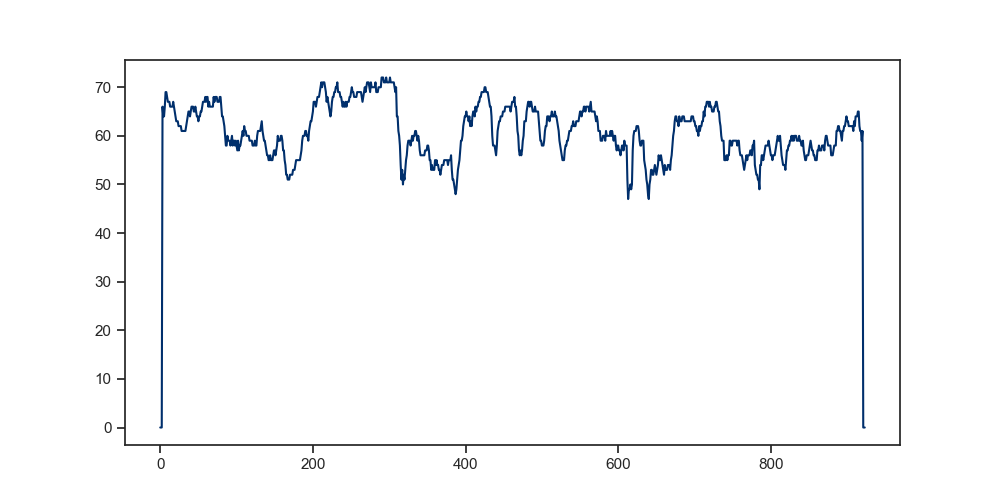

In [95]:
fig, ax = plt.subplots()
ax.plot(np.array(shape_list))
plt.show()

In [19]:
#nonzero = np.nonzero(peaks_rolling[401])[0]

In [20]:
#peaks_dict = {"RSP_Troughs": list(nonzero)}

In [21]:
#time_intervals = np.diff(nonzero) / fs_radar  # Time in seconds between peaks
#respiration_rate_bpm = 60 / time_intervals  # Convert to breaths per minute

In [22]:
#respiration_rate_array = np.zeros_like((peaks_rolling.shape[1],))

# We assign the calculated respiration rates between the indices of detected peaks
#for i in range(len(nonzero) - 1):
#    respiration_rate_array[nonzero[i]:nonzero[i + 1]] = respiration_rate_bpm[i]

In [23]:
#rrv = nk.rsp_rrv(respiration_rate_array, peaks_dict, sampling_rate=fs_radar, show=False)

In [24]:
#rrv

In [38]:
epochs = len(peaks_rolling)  # Number of epochs
columns = ['RRV_RMSSD', 'RRV_MeanBB', 'RRV_SDBB', 'RRV_SDSD', 'RRV_CVBB', 
           'RRV_CVSD', 'RRV_MedianBB', 'RRV_MadBB', 'RRV_MCVBB', 'RRV_VLF', 
           'RRV_LF', 'RRV_HF', 'RRV_LFHF', 'RRV_LFn', 'RRV_HFn', 'RRV_SD1', 
           'RRV_SD2', 'RRV_SD2SD1', 'RRV_ApEn', 'RRV_SampEn']

In [39]:
# Initialize the DataFrame with zeros
feature_data = np.empty((epochs, len(columns)))
feature_data.fill(np.nan)

In [40]:
df_features = pd.DataFrame(feature_data, columns=columns)

In [41]:
feature_data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [42]:
for df_peaks_slice, idx in zip(peaks_rolling, np.arange(len(peaks_rolling))):

    
    nonzero = np.nonzero(df_peaks_slice)[0]
    peaks_dict = {"RSP_Troughs": list(nonzero)}

    time_intervals = np.diff(nonzero) / fs_radar  # Time in seconds between peaks
    respiration_rate_bpm = 60 / time_intervals  # Convert to breaths per minute
    display(respiration_rate_bpm)

    respiration_rate_array = np.zeros_like(df_peaks_slice)

    
    # We assign the calculated respiration rates between the indices of detected peaks
    for i in range(len(nonzero) - 1):
        respiration_rate_array[nonzero[i]:nonzero[i + 1]] = respiration_rate_bpm[i]

    if any(value < 5.0 for value in respiration_rate_bpm):
        continue

    #if np.mean(respiration_rate_bpm) < 12.0:
    #    continue

    try:
        rrv = nk.rsp_rrv(respiration_rate_array, peaks_dict, sampling_rate=fs_radar, show=False)
        df_features.loc[idx] = rrv.loc[0]
    except:
        continue

array([], dtype=float64)

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:140: RuntimeWarning: Mean of empty slice
  out["MeanBB"] = np.nanmean(bbi)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

array([], dtype=float64)

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:140: RuntimeWarning: Mean of empty slice
  out["MeanBB"] = np.nanmean(bbi)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

array([20.64614165, 15.64377253, 16.86636442, 14.72944947,  8.43682505])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


array([], dtype=float64)

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:140: RuntimeWarning: Mean of empty slice
  out["MeanBB"] = np.nanmean(bbi)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

array([19.30601318])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value en

array([19.30601318,  1.25096074])

array([19.30601318,  1.25096074, 18.82832584, 13.10235912, 23.46565879,
       11.68836026, 17.89122137, 17.50112007, 14.64111694])

array([19.30601318,  1.25096074, 18.82832584, 13.10235912, 23.46565879,
       11.68836026, 17.89122137, 17.50112007, 14.64111694,  7.33522158,
       20.51601891, 19.6359752 , 24.51621339, 18.21944963,  6.09272642])

array([19.30601318,  1.25096074, 18.82832584, 13.10235912, 23.46565879,
       11.68836026, 17.89122137, 17.50112007, 14.64111694,  7.33522158,
       20.51601891, 19.6359752 , 24.51621339, 18.21944963,  6.09272642,
        5.07305195, 22.56209087, 24.99733362,  7.55463512, 16.28961635])

array([18.82832584, 13.10235912, 23.46565879, 11.68836026, 17.89122137,
       17.50112007, 14.64111694,  7.33522158, 20.51601891, 19.6359752 ,
       24.51621339, 18.21944963,  6.09272642,  5.07305195, 22.56209087,
       24.99733362,  7.55463512, 16.28961635,  7.36935606, 21.53390298,
       15.93087276, 22.35549409, 11.53193269, 16.65541501, 19.82197226,
       22.6230695 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.10235912, 23.46565879, 11.68836026, 17.89122137, 17.50112007,
       14.64111694,  7.33522158, 20.51601891, 19.6359752 , 24.51621339,
       18.21944963,  6.09272642,  5.07305195, 22.56209087, 24.99733362,
        7.55463512, 16.28961635,  7.36935606, 21.53390298, 15.93087276,
       22.35549409, 11.53193269, 16.65541501, 19.82197226, 22.6230695 ,
        6.31194118,  9.55696461, 12.48535052, 18.85255792, 18.96851732,
       15.05878951])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.51601891, 19.6359752 , 24.51621339, 18.21944963,  6.09272642,
        5.07305195, 22.56209087, 24.99733362,  7.55463512, 16.28961635,
        7.36935606, 21.53390298, 15.93087276, 22.35549409, 11.53193269,
       16.65541501, 19.82197226, 22.6230695 ,  6.31194118,  9.55696461,
       12.48535052, 18.85255792, 18.96851732, 15.05878951,  6.60583427,
        9.61814675,  9.58275411, 12.99196231, 14.07319563])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.56209087, 24.99733362,  7.55463512, 16.28961635,  7.36935606,
       21.53390298, 15.93087276, 22.35549409, 11.53193269, 16.65541501,
       19.82197226, 22.6230695 ,  6.31194118,  9.55696461, 12.48535052,
       18.85255792, 18.96851732, 15.05878951,  6.60583427,  9.61814675,
        9.58275411, 12.99196231, 14.07319563,  7.96543638,  5.80136139,
       10.74523198,  8.42954251])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.53390298, 15.93087276, 22.35549409, 11.53193269, 16.65541501,
       19.82197226, 22.6230695 ,  6.31194118,  9.55696461, 12.48535052,
       18.85255792, 18.96851732, 15.05878951,  6.60583427,  9.61814675,
        9.58275411, 12.99196231, 14.07319563,  7.96543638,  5.80136139,
       10.74523198,  8.42954251, 12.60622849, 16.95911722,  8.55508103,
       16.60820578, 12.79060249,  7.95246336])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.55696461, 12.48535052, 18.85255792, 18.96851732, 15.05878951,
        6.60583427,  9.61814675,  9.58275411, 12.99196231, 14.07319563,
        7.96543638,  5.80136139, 10.74523198,  8.42954251, 12.60622849,
       16.95911722,  8.55508103, 16.60820578, 12.79060249,  7.95246336,
       10.96234799, 16.03112175, 14.78520061, 19.16080772,  4.20962354])

array([ 9.61814675,  9.58275411, 12.99196231, 14.07319563,  7.96543638,
        5.80136139, 10.74523198,  8.42954251, 12.60622849, 16.95911722,
        8.55508103, 16.60820578, 12.79060249,  7.95246336, 10.96234799,
       16.03112175, 14.78520061, 19.16080772,  4.20962354, 12.67439974,
       24.2323201 , 15.20336015, 19.5508008 , 15.58758978, 16.8179535 ,
       19.65573633])

array([ 5.80136139, 10.74523198,  8.42954251, 12.60622849, 16.95911722,
        8.55508103, 16.60820578, 12.79060249,  7.95246336, 10.96234799,
       16.03112175, 14.78520061, 19.16080772,  4.20962354, 12.67439974,
       24.2323201 , 15.20336015, 19.5508008 , 15.58758978, 16.8179535 ,
       19.65573633,  6.7094641 , 12.98908224,  4.85328833, 20.04575778,
       17.8721214 ])

array([16.95911722,  8.55508103, 16.60820578, 12.79060249,  7.95246336,
       10.96234799, 16.03112175, 14.78520061, 19.16080772,  4.20962354,
       12.67439974, 24.2323201 , 15.20336015, 19.5508008 , 15.58758978,
       16.8179535 , 19.65573633,  6.7094641 , 12.98908224,  4.85328833,
       20.04575778, 17.8721214 ,  6.36369807, 15.76372074, 17.08272595,
       20.501662  , 18.96237864, 17.4958943 , 18.06219174, 16.34870257])

array([16.03112175, 14.78520061, 19.16080772,  4.20962354, 12.67439974,
       24.2323201 , 15.20336015, 19.5508008 , 15.58758978, 16.8179535 ,
       19.65573633,  6.7094641 , 12.98908224,  4.85328833, 20.04575778,
       17.8721214 ,  6.36369807, 15.76372074, 17.08272595, 20.501662  ,
       18.96237864, 17.4958943 , 18.06219174, 16.34870257, 11.63728898,
       15.6793551 , 23.86710794, 16.31683375, 19.90276834, 17.30982275,
       18.10125116])

array([24.2323201 , 15.20336015, 19.5508008 , 15.58758978, 16.8179535 ,
       19.65573633,  6.7094641 , 12.98908224,  4.85328833, 20.04575778,
       17.8721214 ,  6.36369807, 15.76372074, 17.08272595, 20.501662  ,
       18.96237864, 17.4958943 , 18.06219174, 16.34870257, 11.63728898,
       15.6793551 , 23.86710794, 16.31683375, 19.90276834, 17.30982275,
       18.10125116,  8.32415826, 22.31292841,  9.23172365, 10.8406568 ,
       23.07749114, 13.00061016, 12.35373182])

array([12.98908224,  4.85328833, 20.04575778, 17.8721214 ,  6.36369807,
       15.76372074, 17.08272595, 20.501662  , 18.96237864, 17.4958943 ,
       18.06219174, 16.34870257, 11.63728898, 15.6793551 , 23.86710794,
       16.31683375, 19.90276834, 17.30982275, 18.10125116,  8.32415826,
       22.31292841,  9.23172365, 10.8406568 , 23.07749114, 13.00061016,
       12.35373182, 20.56642682, 11.51606722, 17.98457643, 21.64527152,
       14.73685865, 17.03801977, 14.92074102, 13.42046496])

array([15.76372074, 17.08272595, 20.501662  , 18.96237864, 17.4958943 ,
       18.06219174, 16.34870257, 11.63728898, 15.6793551 , 23.86710794,
       16.31683375, 19.90276834, 17.30982275, 18.10125116,  8.32415826,
       22.31292841,  9.23172365, 10.8406568 , 23.07749114, 13.00061016,
       12.35373182, 20.56642682, 11.51606722, 17.98457643, 21.64527152,
       14.73685865, 17.03801977, 14.92074102, 13.42046496, 23.19625891,
       14.0748859 , 15.4234667 , 13.65503379, 13.97418316, 20.54479313,
       21.22193046, 22.33844834])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.6793551 , 23.86710794, 16.31683375, 19.90276834, 17.30982275,
       18.10125116,  8.32415826, 22.31292841,  9.23172365, 10.8406568 ,
       23.07749114, 13.00061016, 12.35373182, 20.56642682, 11.51606722,
       17.98457643, 21.64527152, 14.73685865, 17.03801977, 14.92074102,
       13.42046496, 23.19625891, 14.0748859 , 15.4234667 , 13.65503379,
       13.97418316, 20.54479313, 21.22193046, 22.33844834, 11.33779992,
       21.96991001, 12.50667022, 20.17691116, 12.41393008, 11.62574405,
       18.20812617, 21.80638258])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.31292841,  9.23172365, 10.8406568 , 23.07749114, 13.00061016,
       12.35373182, 20.56642682, 11.51606722, 17.98457643, 21.64527152,
       14.73685865, 17.03801977, 14.92074102, 13.42046496, 23.19625891,
       14.0748859 , 15.4234667 , 13.65503379, 13.97418316, 20.54479313,
       21.22193046, 22.33844834, 11.33779992, 21.96991001, 12.50667022,
       20.17691116, 12.41393008, 11.62574405, 18.20812617, 21.80638258,
       21.66928624, 21.86333955, 13.33494538, 16.91017316, 19.8690234 ,
       17.30471057, 24.17233911, 17.44380768, 21.13771645])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.51606722, 17.98457643, 21.64527152, 14.73685865, 17.03801977,
       14.92074102, 13.42046496, 23.19625891, 14.0748859 , 15.4234667 ,
       13.65503379, 13.97418316, 20.54479313, 21.22193046, 22.33844834,
       11.33779992, 21.96991001, 12.50667022, 20.17691116, 12.41393008,
       11.62574405, 18.20812617, 21.80638258, 21.66928624, 21.86333955,
       13.33494538, 16.91017316, 19.8690234 , 17.30471057, 24.17233911,
       17.44380768, 21.13771645, 11.99217151, 24.88057325, 13.34709567,
       11.11624929, 21.7497216 , 19.40833057, 19.42763594,  9.61183563])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.0748859 , 15.4234667 , 13.65503379, 13.97418316, 20.54479313,
       21.22193046, 22.33844834, 11.33779992, 21.96991001, 12.50667022,
       20.17691116, 12.41393008, 11.62574405, 18.20812617, 21.80638258,
       21.66928624, 21.86333955, 13.33494538, 16.91017316, 19.8690234 ,
       17.30471057, 24.17233911, 17.44380768, 21.13771645, 11.99217151,
       24.88057325, 13.34709567, 11.11624929, 21.7497216 , 19.40833057,
       19.42763594,  9.61183563, 18.20812617, 15.3749016 , 22.53605769,
       19.36343358, 14.80761941, 11.95546827, 24.2925995 , 18.40255967])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.96991001, 12.50667022, 20.17691116, 12.41393008, 11.62574405,
       18.20812617, 21.80638258, 21.66928624, 21.86333955, 13.33494538,
       16.91017316, 19.8690234 , 17.30471057, 24.17233911, 17.44380768,
       21.13771645, 11.99217151, 24.88057325, 13.34709567, 11.11624929,
       21.7497216 , 19.40833057, 19.42763594,  9.61183563, 18.20812617,
       15.3749016 , 22.53605769, 19.36343358, 14.80761941, 11.95546827,
       24.2925995 , 18.40255967, 15.79772176, 15.69195233, 24.40389421,
       10.02630903, 23.35342766, 23.04119151, 20.03890219, 11.10571456])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.86333955, 13.33494538, 16.91017316, 19.8690234 , 17.30471057,
       24.17233911, 17.44380768, 21.13771645, 11.99217151, 24.88057325,
       13.34709567, 11.11624929, 21.7497216 , 19.40833057, 19.42763594,
        9.61183563, 18.20812617, 15.3749016 , 22.53605769, 19.36343358,
       14.80761941, 11.95546827, 24.2925995 , 18.40255967, 15.79772176,
       15.69195233, 24.40389421, 10.02630903, 23.35342766, 23.04119151,
       20.03890219, 11.10571456, 19.29329931, 21.77396878, 12.42973059,
       20.04575778, 19.62282317, 22.74602096, 16.34870257, 17.21320505,
       15.35878113])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.88057325, 13.34709567, 11.11624929, 21.7497216 , 19.40833057,
       19.42763594,  9.61183563, 18.20812617, 15.3749016 , 22.53605769,
       19.36343358, 14.80761941, 11.95546827, 24.2925995 , 18.40255967,
       15.79772176, 15.69195233, 24.40389421, 10.02630903, 23.35342766,
       23.04119151, 20.03890219, 11.10571456, 19.29329931, 21.77396878,
       12.42973059, 20.04575778, 19.62282317, 22.74602096, 16.34870257,
       17.21320505, 15.35878113, 11.17348398, 22.7813958 , 14.32960382,
       18.69019139, 15.8019822 , 18.65448902, 11.32027628])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.3749016 , 22.53605769, 19.36343358, 14.80761941, 11.95546827,
       24.2925995 , 18.40255967, 15.79772176, 15.69195233, 24.40389421,
       10.02630903, 23.35342766, 23.04119151, 20.03890219, 11.10571456,
       19.29329931, 21.77396878, 12.42973059, 20.04575778, 19.62282317,
       22.74602096, 16.34870257, 17.21320505, 15.35878113, 11.17348398,
       22.7813958 , 14.32960382, 18.69019139, 15.8019822 , 18.65448902,
       11.32027628, 10.73342187, 11.18628293, 22.37256586, 16.32592644,
       20.40882968, 13.75440141, 15.07428608, 11.36198371])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.69195233, 24.40389421, 10.02630903, 23.35342766, 23.04119151,
       20.03890219, 11.10571456, 19.29329931, 21.77396878, 12.42973059,
       20.04575778, 19.62282317, 22.74602096, 16.34870257, 17.21320505,
       15.35878113, 11.17348398, 22.7813958 , 14.32960382, 18.69019139,
       15.8019822 , 18.65448902, 11.32027628, 10.73342187, 11.18628293,
       22.37256586, 16.32592644, 20.40882968, 13.75440141, 15.07428608,
       11.36198371, 13.99420826, 19.50524301, 21.26043179, 15.33065149,
       14.34363525, 11.05542453, 22.31292841, 18.66637464])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.77396878, 12.42973059, 20.04575778, 19.62282317, 22.74602096,
       16.34870257, 17.21320505, 15.35878113, 11.17348398, 22.7813958 ,
       14.32960382, 18.69019139, 15.8019822 , 18.65448902, 11.32027628,
       10.73342187, 11.18628293, 22.37256586, 16.32592644, 20.40882968,
       13.75440141, 15.07428608, 11.36198371, 13.99420826, 19.50524301,
       21.26043179, 15.33065149, 14.34363525, 11.05542453, 22.31292841,
       18.66637464, 20.55921053, 10.3926481 , 14.92834395, 13.48843232,
       18.35068901, 16.66488908, 17.52205443, 21.16826228])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.7813958 , 14.32960382, 18.69019139, 15.8019822 , 18.65448902,
       11.32027628, 10.73342187, 11.18628293, 22.37256586, 16.32592644,
       20.40882968, 13.75440141, 15.07428608, 11.36198371, 13.99420826,
       19.50524301, 21.26043179, 15.33065149, 14.34363525, 11.05542453,
       22.31292841, 18.66637464, 20.55921053, 10.3926481 , 14.92834395,
       13.48843232, 18.35068901, 16.66488908, 17.52205443, 21.16826228,
       22.14427438, 20.12839231, 19.80856998, 10.51386147, 20.91140257,
       23.01404163, 19.74848332, 16.63177689, 14.99328301])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.18628293, 22.37256586, 16.32592644, 20.40882968, 13.75440141,
       15.07428608, 11.36198371, 13.99420826, 19.50524301, 21.26043179,
       15.33065149, 14.34363525, 11.05542453, 22.31292841, 18.66637464,
       20.55921053, 10.3926481 , 14.92834395, 13.48843232, 18.35068901,
       16.66488908, 17.52205443, 21.16826228, 22.14427438, 20.12839231,
       19.80856998, 10.51386147, 20.91140257, 23.01404163, 19.74848332,
       16.63177689, 14.99328301, 10.61865712, 15.57930072, 24.97602302,
       23.24226497, 12.16395059, 11.54101832, 18.99927043, 24.20229244])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.50524301, 21.26043179, 15.33065149, 14.34363525, 11.05542453,
       22.31292841, 18.66637464, 20.55921053, 10.3926481 , 14.92834395,
       13.48843232, 18.35068901, 16.66488908, 17.52205443, 21.16826228,
       22.14427438, 20.12839231, 19.80856998, 10.51386147, 20.91140257,
       23.01404163, 19.74848332, 16.63177689, 14.99328301, 10.61865712,
       15.57930072, 24.97602302, 23.24226497, 12.16395059, 11.54101832,
       18.99927043, 24.20229244, 19.22367126,  7.76178964, 21.87966766,
       20.47300839, 20.15608875, 18.79209429, 13.66777467])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.3926481 , 14.92834395, 13.48843232, 18.35068901, 16.66488908,
       17.52205443, 21.16826228, 22.14427438, 20.12839231, 19.80856998,
       10.51386147, 20.91140257, 23.01404163, 19.74848332, 16.63177689,
       14.99328301, 10.61865712, 15.57930072, 24.97602302, 23.24226497,
       12.16395059, 11.54101832, 18.99927043, 24.20229244, 19.22367126,
        7.76178964, 21.87966766, 20.47300839, 20.15608875, 18.79209429,
       13.66777467, 17.42824212, 12.3433221 , 23.42812875,  7.48228196,
       18.21378614, 20.03890219, 23.42812875, 17.6434056 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.12839231, 19.80856998, 10.51386147, 20.91140257, 23.01404163,
       19.74848332, 16.63177689, 14.99328301, 10.61865712, 15.57930072,
       24.97602302, 23.24226497, 12.16395059, 11.54101832, 18.99927043,
       24.20229244, 19.22367126,  7.76178964, 21.87966766, 20.47300839,
       20.15608875, 18.79209429, 13.66777467, 17.42824212, 12.3433221 ,
       23.42812875,  7.48228196, 18.21378614, 20.03890219, 23.42812875,
       17.6434056 , 22.24515945, 23.26995631, 24.36330561, 13.06146901,
       21.43151061, 17.90762531, 13.95089286, 18.51888432, 15.46009235])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.57930072, 24.97602302, 23.24226497, 12.16395059, 11.54101832,
       18.99927043, 24.20229244, 19.22367126,  7.76178964, 21.87966766,
       20.47300839, 20.15608875, 18.79209429, 13.66777467, 17.42824212,
       12.3433221 , 23.42812875,  7.48228196, 18.21378614, 20.03890219,
       23.42812875, 17.6434056 , 22.24515945, 23.26995631, 24.36330561,
       13.06146901, 21.43151061, 17.90762531, 13.95089286, 18.51888432,
       15.46009235, 13.19084872, 19.91629844, 14.31909824, 13.78352152,
       13.42046496, 20.20474138,  7.54782301])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 7.76178964, 21.87966766, 20.47300839, 20.15608875, 18.79209429,
       13.66777467, 17.42824212, 12.3433221 , 23.42812875,  7.48228196,
       18.21378614, 20.03890219, 23.42812875, 17.6434056 , 22.24515945,
       23.26995631, 24.36330561, 13.06146901, 21.43151061, 17.90762531,
       13.95089286, 18.51888432, 15.46009235, 13.19084872, 19.91629844,
       14.31909824, 13.78352152, 13.42046496, 20.20474138,  7.54782301,
       11.51154224,  9.72671813, 17.63278664, 18.0900741 , 18.46635676,
       16.63649915, 11.44185706])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.3433221 , 23.42812875,  7.48228196, 18.21378614, 20.03890219,
       23.42812875, 17.6434056 , 22.24515945, 23.26995631, 24.36330561,
       13.06146901, 21.43151061, 17.90762531, 13.95089286, 18.51888432,
       15.46009235, 13.19084872, 19.91629844, 14.31909824, 13.78352152,
       13.42046496, 20.20474138,  7.54782301, 11.51154224,  9.72671813,
       17.63278664, 18.0900741 , 18.46635676, 16.63649915, 11.44185706,
       13.98418854, 20.33093338, 17.1477173 , 13.14350606, 16.3395845 ,
       17.60100631, 21.75779799, 12.63885893])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.26995631, 24.36330561, 13.06146901, 21.43151061, 17.90762531,
       13.95089286, 18.51888432, 15.46009235, 13.19084872, 19.91629844,
       14.31909824, 13.78352152, 13.42046496, 20.20474138,  7.54782301,
       11.51154224,  9.72671813, 17.63278664, 18.0900741 , 18.46635676,
       16.63649915, 11.44185706, 13.98418854, 20.33093338, 17.1477173 ,
       13.14350606, 16.3395845 , 17.60100631, 21.75779799, 12.63885893,
       18.94398642, 12.93460265, 13.79975271, 12.38506658, 10.6874145 ,
       10.67962271])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.91629844, 14.31909824, 13.78352152, 13.42046496, 20.20474138,
        7.54782301, 11.51154224,  9.72671813, 17.63278664, 18.0900741 ,
       18.46635676, 16.63649915, 11.44185706, 13.98418854, 20.33093338,
       17.1477173 , 13.14350606, 16.3395845 , 17.60100631, 21.75779799,
       12.63885893, 18.94398642, 12.93460265, 13.79975271, 12.38506658,
       10.6874145 , 10.67962271, 21.0655222 ,  9.29616849, 14.40888971,
       18.4634473 , 19.44052754, 17.70738894, 17.22838871, 14.4926416 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.72671813, 17.63278664, 18.0900741 , 18.46635676, 16.63649915,
       11.44185706, 13.98418854, 20.33093338, 17.1477173 , 13.14350606,
       16.3395845 , 17.60100631, 21.75779799, 12.63885893, 18.94398642,
       12.93460265, 13.79975271, 12.38506658, 10.6874145 , 10.67962271,
       21.0655222 ,  9.29616849, 14.40888971, 18.4634473 , 19.44052754,
       17.70738894, 17.22838871, 14.4926416 , 15.96559946, 23.27920143,
       23.61698912, 10.20086177, 18.35068901, 11.59927744])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.33093338, 17.1477173 , 13.14350606, 16.3395845 , 17.60100631,
       21.75779799, 12.63885893, 18.94398642, 12.93460265, 13.79975271,
       12.38506658, 10.6874145 , 10.67962271, 21.0655222 ,  9.29616849,
       14.40888971, 18.4634473 , 19.44052754, 17.70738894, 17.22838871,
       14.4926416 , 15.96559946, 23.27920143, 23.61698912, 10.20086177,
       18.35068901, 11.59927744,  6.869541  , 21.55370609, 24.53674623,
       11.96523382, 13.97085122, 10.99319887, 15.65422121])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.93460265, 13.79975271, 12.38506658, 10.6874145 , 10.67962271,
       21.0655222 ,  9.29616849, 14.40888971, 18.4634473 , 19.44052754,
       17.70738894, 17.22838871, 14.4926416 , 15.96559946, 23.27920143,
       23.61698912, 10.20086177, 18.35068901, 11.59927744,  6.869541  ,
       21.55370609, 24.53674623, 11.96523382, 13.97085122, 10.99319887,
       15.65422121,  8.39933343, 17.3559686 , 17.43861607, 19.55732644,
       14.252919  , 15.71299276, 16.47743251, 15.93520533, 18.565827  ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.29616849, 14.40888971, 18.4634473 , 19.44052754, 17.70738894,
       17.22838871, 14.4926416 , 15.96559946, 23.27920143, 23.61698912,
       10.20086177, 18.35068901, 11.59927744,  6.869541  , 21.55370609,
       24.53674623, 11.96523382, 13.97085122, 10.99319887, 15.65422121,
        8.39933343, 17.3559686 , 17.43861607, 19.55732644, 14.252919  ,
       15.71299276, 16.47743251, 15.93520533, 18.565827  , 17.90762531,
       18.89511448, 14.62649775, 17.15273712, 15.19153487, 18.92562984,
       16.07069391, 16.90529429])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.27920143, 23.61698912, 10.20086177, 18.35068901, 11.59927744,
        6.869541  , 21.55370609, 24.53674623, 11.96523382, 13.97085122,
       10.99319887, 15.65422121,  8.39933343, 17.3559686 , 17.43861607,
       19.55732644, 14.252919  , 15.71299276, 16.47743251, 15.93520533,
       18.565827  , 17.90762531, 18.89511448, 14.62649775, 17.15273712,
       15.19153487, 18.92562984, 16.07069391, 16.90529429, 17.53254039,
       14.29464504, 14.16676741, 13.03531702, 16.57531825, 20.19081668,
       15.9743048 , 16.45891854])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.55370609, 24.53674623, 11.96523382, 13.97085122, 10.99319887,
       15.65422121,  8.39933343, 17.3559686 , 17.43861607, 19.55732644,
       14.252919  , 15.71299276, 16.47743251, 15.93520533, 18.565827  ,
       17.90762531, 18.89511448, 14.62649775, 17.15273712, 15.19153487,
       18.92562984, 16.07069391, 16.90529429, 17.53254039, 14.29464504,
       14.16676741, 13.03531702, 16.57531825, 20.19081668, 15.9743048 ,
       16.45891854, 16.46354313, 18.05662558, 15.16793943, 21.37677855,
       16.90041823, 16.93460983, 17.59572072, 16.95421007])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.3559686 , 17.43861607, 19.55732644, 14.252919  , 15.71299276,
       16.47743251, 15.93520533, 18.565827  , 17.90762531, 18.89511448,
       14.62649775, 17.15273712, 15.19153487, 18.92562984, 16.07069391,
       16.90529429, 17.53254039, 14.29464504, 14.16676741, 13.03531702,
       16.57531825, 20.19081668, 15.9743048 , 16.45891854, 16.46354313,
       18.05662558, 15.16793943, 21.37677855, 16.90041823, 16.93460983,
       17.59572072, 16.95421007, 17.70203927, 18.58938769, 17.27410083,
       22.97794118, 15.55655117, 20.10422028, 24.93351064, 14.77029241,
       18.88902321, 16.97385574])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.89511448, 14.62649775, 17.15273712, 15.19153487, 18.92562984,
       16.07069391, 16.90529429, 17.53254039, 14.29464504, 14.16676741,
       13.03531702, 16.57531825, 20.19081668, 15.9743048 , 16.45891854,
       16.46354313, 18.05662558, 15.16793943, 21.37677855, 16.90041823,
       16.93460983, 17.59572072, 16.95421007, 17.70203927, 18.58938769,
       17.27410083, 22.97794118, 15.55655117, 20.10422028, 24.93351064,
       14.77029241, 18.88902321, 16.97385574, 14.80949071, 21.45112576,
       18.3852369 , 14.69251505, 12.15385812, 18.39678179, 15.8019822 ,
       15.88336948])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.29464504, 14.16676741, 13.03531702, 16.57531825, 20.19081668,
       15.9743048 , 16.45891854, 16.46354313, 18.05662558, 15.16793943,
       21.37677855, 16.90041823, 16.93460983, 17.59572072, 16.95421007,
       17.70203927, 18.58938769, 17.27410083, 22.97794118, 15.55655117,
       20.10422028, 24.93351064, 14.77029241, 18.88902321, 16.97385574,
       14.80949071, 21.45112576, 18.3852369 , 14.69251505, 12.15385812,
       18.39678179, 15.8019822 , 15.88336948, 18.90730881, 17.53254039,
       16.80830465, 15.10927024, 22.11084906, 18.43730334, 17.36111111,
       16.05308219])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.05662558, 15.16793943, 21.37677855, 16.90041823, 16.93460983,
       17.59572072, 16.95421007, 17.70203927, 18.58938769, 17.27410083,
       22.97794118, 15.55655117, 20.10422028, 24.93351064, 14.77029241,
       18.88902321, 16.97385574, 14.80949071, 21.45112576, 18.3852369 ,
       14.69251505, 12.15385812, 18.39678179, 15.8019822 , 15.88336948,
       18.90730881, 17.53254039, 16.80830465, 15.10927024, 22.11084906,
       18.43730334, 17.36111111, 16.05308219, 16.41741384, 15.44379283,
       13.33798088, 21.64527152, 16.37154233, 14.19250333, 16.89798125,
       18.07333436, 20.9300768 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.58938769, 17.27410083, 22.97794118, 15.55655117, 20.10422028,
       24.93351064, 14.77029241, 18.88902321, 16.97385574, 14.80949071,
       21.45112576, 18.3852369 , 14.69251505, 12.15385812, 18.39678179,
       15.8019822 , 15.88336948, 18.90730881, 17.53254039, 16.80830465,
       15.10927024, 22.11084906, 18.43730334, 17.36111111, 16.05308219,
       16.41741384, 15.44379283, 13.33798088, 21.64527152, 16.37154233,
       14.19250333, 16.89798125, 18.07333436, 20.9300768 , 11.49686059,
       12.82700306, 24.71267398, 14.72944947, 16.52390017, 22.27052452,
       14.74056604, 18.83437801])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.45112576, 18.3852369 , 14.69251505, 12.15385812, 18.39678179,
       15.8019822 , 15.88336948, 18.90730881, 17.53254039, 16.80830465,
       15.10927024, 22.11084906, 18.43730334, 17.36111111, 16.05308219,
       16.41741384, 15.44379283, 13.33798088, 21.64527152, 16.37154233,
       14.19250333, 16.89798125, 18.07333436, 20.9300768 , 11.49686059,
       12.82700306, 24.71267398, 14.72944947, 16.52390017, 22.27052452,
       14.74056604, 18.83437801, 14.30162314, 11.00765546, 13.33798088,
       17.47502237, 18.98695723, 17.53778809, 18.15171933])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.53254039, 16.80830465, 15.10927024, 22.11084906, 18.43730334,
       17.36111111, 16.05308219, 16.41741384, 15.44379283, 13.33798088,
       21.64527152, 16.37154233, 14.19250333, 16.89798125, 18.07333436,
       20.9300768 , 11.49686059, 12.82700306, 24.71267398, 14.72944947,
       16.52390017, 22.27052452, 14.74056604, 18.83437801, 14.30162314,
       11.00765546, 13.33798088, 17.47502237, 18.98695723, 17.53778809,
       18.15171933, 16.56594572, 20.05261807, 20.36626694,  9.35106128,
       14.29813324, 20.88903743, 18.0343952 , 22.52739331, 18.07891083])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.44379283, 13.33798088, 21.64527152, 16.37154233, 14.19250333,
       16.89798125, 18.07333436, 20.9300768 , 11.49686059, 12.82700306,
       24.71267398, 14.72944947, 16.52390017, 22.27052452, 14.74056604,
       18.83437801, 14.30162314, 11.00765546, 13.33798088, 17.47502237,
       18.98695723, 17.53778809, 18.15171933, 16.56594572, 20.05261807,
       20.36626694,  9.35106128, 14.29813324, 20.88903743, 18.0343952 ,
       22.52739331, 18.07891083, 18.15734428, 18.24781999, 17.32005616,
       18.88902321, 18.11244204, 18.57171157, 18.16860465, 24.57791527,
       17.12766735])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.82700306, 24.71267398, 14.72944947, 16.52390017, 22.27052452,
       14.74056604, 18.83437801, 14.30162314, 11.00765546, 13.33798088,
       17.47502237, 18.98695723, 17.53778809, 18.15171933, 16.56594572,
       20.05261807, 20.36626694,  9.35106128, 14.29813324, 20.88903743,
       18.0343952 , 22.52739331, 18.07891083, 18.15734428, 18.24781999,
       17.32005616, 18.88902321, 18.11244204, 18.57171157, 18.16860465,
       24.57791527, 17.12766735, 16.29414627, 21.72552836, 16.09718407,
       18.67232314, 18.39678179, 16.91505485, 19.59657191, 19.33787129,
       17.6806729 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.00765546, 13.33798088, 17.47502237, 18.98695723, 17.53778809,
       18.15171933, 16.56594572, 20.05261807, 20.36626694,  9.35106128,
       14.29813324, 20.88903743, 18.0343952 , 22.52739331, 18.07891083,
       18.15734428, 18.24781999, 17.32005616, 18.88902321, 18.11244204,
       18.57171157, 18.16860465, 24.57791527, 17.12766735, 16.29414627,
       21.72552836, 16.09718407, 18.67232314, 18.39678179, 16.91505485,
       19.59657191, 19.33787129, 17.6806729 , 16.62705732, 18.37370649,
       16.16825331, 24.11265432, 14.30860806, 20.88159301,  9.99211289,
       24.52647551])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.05261807, 20.36626694,  9.35106128, 14.29813324, 20.88903743,
       18.0343952 , 22.52739331, 18.07891083, 18.15734428, 18.24781999,
       17.32005616, 18.88902321, 18.11244204, 18.57171157, 18.16860465,
       24.57791527, 17.12766735, 16.29414627, 21.72552836, 16.09718407,
       18.67232314, 18.39678179, 16.91505485, 19.59657191, 19.33787129,
       17.6806729 , 16.62705732, 18.37370649, 16.16825331, 24.11265432,
       14.30860806, 20.88159301,  9.99211289, 24.52647551, 11.3752184 ,
       21.677303  , 17.07774701, 20.5232049 , 17.71809797, 14.6338037 ,
       18.92562984, 16.34414226, 14.55383756])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.24781999, 17.32005616, 18.88902321, 18.11244204, 18.57171157,
       18.16860465, 24.57791527, 17.12766735, 16.29414627, 21.72552836,
       16.09718407, 18.67232314, 18.39678179, 16.91505485, 19.59657191,
       19.33787129, 17.6806729 , 16.62705732, 18.37370649, 16.16825331,
       24.11265432, 14.30860806, 20.88159301,  9.99211289, 24.52647551,
       11.3752184 , 21.677303  , 17.07774701, 20.5232049 , 17.71809797,
       14.6338037 , 18.92562984, 16.34414226, 14.55383756, 18.29339682,
       16.50528169, 17.28429204, 17.69134964, 19.76847166, 17.75030294,
       17.82590508, 18.58938769, 15.95690359])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.72552836, 16.09718407, 18.67232314, 18.39678179, 16.91505485,
       19.59657191, 19.33787129, 17.6806729 , 16.62705732, 18.37370649,
       16.16825331, 24.11265432, 14.30860806, 20.88159301,  9.99211289,
       24.52647551, 11.3752184 , 21.677303  , 17.07774701, 20.5232049 ,
       17.71809797, 14.6338037 , 18.92562984, 16.34414226, 14.55383756,
       18.29339682, 16.50528169, 17.28429204, 17.69134964, 19.76847166,
       17.75030294, 17.82590508, 18.58938769, 15.95690359, 17.26900973,
       16.53322517, 18.06776133, 17.49067164, 18.03994766, 16.68862148,
       17.51681614, 16.21299115])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.37370649, 16.16825331, 24.11265432, 14.30860806, 20.88159301,
        9.99211289, 24.52647551, 11.3752184 , 21.677303  , 17.07774701,
       20.5232049 , 17.71809797, 14.6338037 , 18.92562984, 16.34414226,
       14.55383756, 18.29339682, 16.50528169, 17.28429204, 17.69134964,
       19.76847166, 17.75030294, 17.82590508, 18.58938769, 15.95690359,
       17.26900973, 16.53322517, 18.06776133, 17.49067164, 18.03994766,
       16.68862148, 17.51681614, 16.21299115, 16.19059132, 17.53254039,
       17.67533937, 17.53778809, 18.05662558, 17.93503214, 16.99847694,
       17.09269253, 17.34055934])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.677303  , 17.07774701, 20.5232049 , 17.71809797, 14.6338037 ,
       18.92562984, 16.34414226, 14.55383756, 18.29339682, 16.50528169,
       17.28429204, 17.69134964, 19.76847166, 17.75030294, 17.82590508,
       18.58938769, 15.95690359, 17.26900973, 16.53322517, 18.06776133,
       17.49067164, 18.03994766, 16.68862148, 17.51681614, 16.21299115,
       16.19059132, 17.53254039, 17.67533937, 17.53778809, 18.05662558,
       17.93503214, 16.99847694, 17.09269253, 17.34055934, 16.67437393,
       16.394446  , 18.75      , 15.63333778, 20.8370377 , 16.47743251,
       12.26323776])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.50528169, 17.28429204, 17.69134964, 19.76847166, 17.75030294,
       17.82590508, 18.58938769, 15.95690359, 17.26900973, 16.53322517,
       18.06776133, 17.49067164, 18.03994766, 16.68862148, 17.51681614,
       16.21299115, 16.19059132, 17.53254039, 17.67533937, 17.53778809,
       18.05662558, 17.93503214, 16.99847694, 17.09269253, 17.34055934,
       16.67437393, 16.394446  , 18.75      , 15.63333778, 20.8370377 ,
       16.47743251, 12.26323776,  9.67851833, 19.74182951, 15.87046316,
       17.39203028, 17.41270431, 16.70289339, 18.00115207, 16.2715218 ,
       16.74585596])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.53322517, 18.06776133, 17.49067164, 18.03994766, 16.68862148,
       17.51681614, 16.21299115, 16.19059132, 17.53254039, 17.67533937,
       17.53778809, 18.05662558, 17.93503214, 16.99847694, 17.09269253,
       17.34055934, 16.67437393, 16.394446  , 18.75      , 15.63333778,
       20.8370377 , 16.47743251, 12.26323776,  9.67851833, 19.74182951,
       15.87046316, 17.39203028, 17.41270431, 16.70289339, 18.00115207,
       16.2715218 , 16.74585596, 19.33787129, 16.54723242, 16.71242156,
       17.17284584, 14.72574768, 16.77462067, 15.75524334, 20.33093338])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.53254039, 17.67533937, 17.53778809, 18.05662558, 17.93503214,
       16.99847694, 17.09269253, 17.34055934, 16.67437393, 16.394446  ,
       18.75      , 15.63333778, 20.8370377 , 16.47743251, 12.26323776,
        9.67851833, 19.74182951, 15.87046316, 17.39203028, 17.41270431,
       16.70289339, 18.00115207, 16.2715218 , 16.74585596, 19.33787129,
       16.54723242, 16.71242156, 17.17284584, 14.72574768, 16.77462067,
       15.75524334, 20.33093338, 12.70738452,  9.44603418, 16.08834432,
       16.8179535 , 16.62234043, 16.75543323, 16.80830465, 17.50112007])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.394446  , 18.75      , 15.63333778, 20.8370377 , 16.47743251,
       12.26323776,  9.67851833, 19.74182951, 15.87046316, 17.39203028,
       17.41270431, 16.70289339, 18.00115207, 16.2715218 , 16.74585596,
       19.33787129, 16.54723242, 16.71242156, 17.17284584, 14.72574768,
       16.77462067, 15.75524334, 20.33093338, 12.70738452,  9.44603418,
       16.08834432, 16.8179535 , 16.62234043, 16.75543323, 16.80830465,
       17.50112007, 19.04249269, 17.81506537, 19.76847166, 18.04550354,
       16.68862148, 17.81506537, 18.52473917, 15.28665536])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.74182951, 15.87046316, 17.39203028, 17.41270431, 16.70289339,
       18.00115207, 16.2715218 , 16.74585596, 19.33787129, 16.54723242,
       16.71242156, 17.17284584, 14.72574768, 16.77462067, 15.75524334,
       20.33093338, 12.70738452,  9.44603418, 16.08834432, 16.8179535 ,
       16.62234043, 16.75543323, 16.80830465, 17.50112007, 19.04249269,
       17.81506537, 19.76847166, 18.04550354, 16.68862148, 17.81506537,
       18.52473917, 15.28665536, 16.53322517, 17.13768646, 18.06776133,
       17.71274184, 16.81312769, 16.02673687, 17.74492732, 17.12266219,
       16.23095568])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.54723242, 16.71242156, 17.17284584, 14.72574768, 16.77462067,
       15.75524334, 20.33093338, 12.70738452,  9.44603418, 16.08834432,
       16.8179535 , 16.62234043, 16.75543323, 16.80830465, 17.50112007,
       19.04249269, 17.81506537, 19.76847166, 18.04550354, 16.68862148,
       17.81506537, 18.52473917, 15.28665536, 16.53322517, 17.13768646,
       18.06776133, 17.71274184, 16.81312769, 16.02673687, 17.74492732,
       17.12266219, 16.23095568, 17.33542899, 15.12877614, 16.28508894,
       15.16401398, 19.76180438, 16.92971684, 16.04868529, 16.33502927])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.44603418, 16.08834432, 16.8179535 , 16.62234043, 16.75543323,
       16.80830465, 17.50112007, 19.04249269, 17.81506537, 19.76847166,
       18.04550354, 16.68862148, 17.81506537, 18.52473917, 15.28665536,
       16.53322517, 17.13768646, 18.06776133, 17.71274184, 16.81312769,
       16.02673687, 17.74492732, 17.12266219, 16.23095568, 17.33542899,
       15.12877614, 16.28508894, 15.16401398, 19.76180438, 16.92971684,
       16.04868529, 16.33502927, 17.49067164, 17.97905799, 16.71242156,
       16.07510288, 16.2715218 , 17.42824212, 17.02316967, 16.25797725,
       19.09213099])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.81506537, 19.76847166, 18.04550354, 16.68862148, 17.81506537,
       18.52473917, 15.28665536, 16.53322517, 17.13768646, 18.06776133,
       17.71274184, 16.81312769, 16.02673687, 17.74492732, 17.12266219,
       16.23095568, 17.33542899, 15.12877614, 16.28508894, 15.16401398,
       19.76180438, 16.92971684, 16.04868529, 16.33502927, 17.49067164,
       17.97905799, 16.71242156, 16.07510288, 16.2715218 , 17.42824212,
       17.02316967, 16.25797725, 19.09213099, 17.49067164, 15.96559946,
       15.43972332, 20.21171093, 16.89067455, 19.03012342, 17.05786026,
       15.87906504])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.13768646, 18.06776133, 17.71274184, 16.81312769, 16.02673687,
       17.74492732, 17.12266219, 16.23095568, 17.33542899, 15.12877614,
       16.28508894, 15.16401398, 19.76180438, 16.92971684, 16.04868529,
       16.33502927, 17.49067164, 17.97905799, 16.71242156, 16.07510288,
       16.2715218 , 17.42824212, 17.02316967, 16.25797725, 19.09213099,
       17.49067164, 15.96559946, 15.43972332, 20.21171093, 16.89067455,
       19.03012342, 17.05786026, 15.87906504, 16.29414627, 17.57988299,
       18.3852369 , 16.51458568, 18.05662558, 13.51331873, 23.7029733 ,
       24.11265432])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.12877614, 16.28508894, 15.16401398, 19.76180438, 16.92971684,
       16.04868529, 16.33502927, 17.49067164, 17.97905799, 16.71242156,
       16.07510288, 16.2715218 , 17.42824212, 17.02316967, 16.25797725,
       19.09213099, 17.49067164, 15.96559946, 15.43972332, 20.21171093,
       16.89067455, 19.03012342, 17.05786026, 15.87906504, 16.29414627,
       17.57988299, 18.3852369 , 16.51458568, 18.05662558, 13.51331873,
       23.7029733 , 24.11265432,  8.75056004, 18.77403076, 20.43017782,
       10.82263576, 18.41412634, 16.35783082, 23.32553742, 15.28665536,
       20.51601891])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.97905799, 16.71242156, 16.07510288, 16.2715218 , 17.42824212,
       17.02316967, 16.25797725, 19.09213099, 17.49067164, 15.96559946,
       15.43972332, 20.21171093, 16.89067455, 19.03012342, 17.05786026,
       15.87906504, 16.29414627, 17.57988299, 18.3852369 , 16.51458568,
       18.05662558, 13.51331873, 23.7029733 , 24.11265432,  8.75056004,
       18.77403076, 20.43017782, 10.82263576, 18.41412634, 16.35783082,
       23.32553742, 15.28665536, 20.51601891, 17.22838871, 17.44900238,
       17.74492732, 17.78262519, 17.74492732, 18.32199812, 17.98457643,
       16.36239877, 19.59002006])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.96559946, 15.43972332, 20.21171093, 16.89067455, 19.03012342,
       17.05786026, 15.87906504, 16.29414627, 17.57988299, 18.3852369 ,
       16.51458568, 18.05662558, 13.51331873, 23.7029733 , 24.11265432,
        8.75056004, 18.77403076, 20.43017782, 10.82263576, 18.41412634,
       16.35783082, 23.32553742, 15.28665536, 20.51601891, 17.22838871,
       17.44900238, 17.74492732, 17.78262519, 17.74492732, 18.32199812,
       17.98457643, 16.36239877, 19.59002006, 17.62748195, 18.11804267,
       15.44786449, 19.21736635,  7.67838422, 16.51924161])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.57988299, 18.3852369 , 16.51458568, 18.05662558, 13.51331873,
       23.7029733 , 24.11265432,  8.75056004, 18.77403076, 20.43017782,
       10.82263576, 18.41412634, 16.35783082, 23.32553742, 15.28665536,
       20.51601891, 17.22838871, 17.44900238, 17.74492732, 17.78262519,
       17.74492732, 18.32199812, 17.98457643, 16.36239877, 19.59002006,
       17.62748195, 18.11804267, 15.44786449, 19.21736635,  7.67838422,
       16.51924161,  7.09797093, 16.58939694, 17.64871988, 17.22838871,
       17.17788039, 17.44900238, 18.82227755, 19.15454397, 18.63076312])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.77403076, 20.43017782, 10.82263576, 18.41412634, 16.35783082,
       23.32553742, 15.28665536, 20.51601891, 17.22838871, 17.44900238,
       17.74492732, 17.78262519, 17.74492732, 18.32199812, 17.98457643,
       16.36239877, 19.59002006, 17.62748195, 18.11804267, 15.44786449,
       19.21736635,  7.67838422, 16.51924161,  7.09797093, 16.58939694,
       17.64871988, 17.22838871, 17.17788039, 17.44900238, 18.82227755,
       19.15454397, 18.63076312, 17.71809797, 18.15171933, 17.4178805 ,
       18.26488466, 17.04297557, 18.08449074, 17.80965046, 18.54819563,
       18.64855188])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.44900238, 17.74492732, 17.78262519, 17.74492732, 18.32199812,
       17.98457643, 16.36239877, 19.59002006, 17.62748195, 18.11804267,
       15.44786449, 19.21736635,  7.67838422, 16.51924161,  7.09797093,
       16.58939694, 17.64871988, 17.22838871, 17.17788039, 17.44900238,
       18.82227755, 19.15454397, 18.63076312, 17.71809797, 18.15171933,
       17.4178805 , 18.26488466, 17.04297557, 18.08449074, 17.80965046,
       18.54819563, 18.64855188, 18.40834119, 18.57171157, 17.13267544,
       17.8421894 , 18.68423151, 17.81506537, 18.79209429, 17.33030169,
       18.31054688])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.11804267, 15.44786449, 19.21736635,  7.67838422, 16.51924161,
        7.09797093, 16.58939694, 17.64871988, 17.22838871, 17.17788039,
       17.44900238, 18.82227755, 19.15454397, 18.63076312, 17.71809797,
       18.15171933, 17.4178805 , 18.26488466, 17.04297557, 18.08449074,
       17.80965046, 18.54819563, 18.64855188, 18.40834119, 18.57171157,
       17.13267544, 17.8421894 , 18.68423151, 17.81506537, 18.79209429,
       17.33030169, 18.31054688, 21.80638258, 22.423938  , 15.66677807,
       18.07333436, 18.27627885, 18.29339682, 18.20812617, 17.29960142,
       16.3395845 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.58939694, 17.64871988, 17.22838871, 17.17788039, 17.44900238,
       18.82227755, 19.15454397, 18.63076312, 17.71809797, 18.15171933,
       17.4178805 , 18.26488466, 17.04297557, 18.08449074, 17.80965046,
       18.54819563, 18.64855188, 18.40834119, 18.57171157, 17.13267544,
       17.8421894 , 18.68423151, 17.81506537, 18.79209429, 17.33030169,
       18.31054688, 21.80638258, 22.423938  , 15.66677807, 18.07333436,
       18.27627885, 18.29339682, 18.20812617, 17.29960142, 16.3395845 ,
       18.00668408, 21.19122966, 15.05105317, 17.53254039, 18.81623314,
       17.65403736, 17.61158702, 17.24359918, 17.20814978])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.15171933, 17.4178805 , 18.26488466, 17.04297557, 18.08449074,
       17.80965046, 18.54819563, 18.64855188, 18.40834119, 18.57171157,
       17.13267544, 17.8421894 , 18.68423151, 17.81506537, 18.79209429,
       17.33030169, 18.31054688, 21.80638258, 22.423938  , 15.66677807,
       18.07333436, 18.27627885, 18.29339682, 18.20812617, 17.29960142,
       16.3395845 , 18.00668408, 21.19122966, 15.05105317, 17.53254039,
       18.81623314, 17.65403736, 17.61158702, 17.24359918, 17.20814978,
       18.61892278, 14.78893236, 18.3334637 , 16.97385574, 19.3123764 ,
       15.58966343, 13.50864553, 17.65935805])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.57171157, 17.13267544, 17.8421894 , 18.68423151, 17.81506537,
       18.79209429, 17.33030169, 18.31054688, 21.80638258, 22.423938  ,
       15.66677807, 18.07333436, 18.27627885, 18.29339682, 18.20812617,
       17.29960142, 16.3395845 , 18.00668408, 21.19122966, 15.05105317,
       17.53254039, 18.81623314, 17.65403736, 17.61158702, 17.24359918,
       17.20814978, 18.61892278, 14.78893236, 18.3334637 , 16.97385574,
       19.3123764 , 15.58966343, 13.50864553, 17.65935805, 16.88580692,
       17.18291789, 17.3559686 , 16.19954382, 16.78423088, 18.10125116,
       17.44900238, 17.26900973, 17.42305977])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.423938  , 15.66677807, 18.07333436, 18.27627885, 18.29339682,
       18.20812617, 17.29960142, 16.3395845 , 18.00668408, 21.19122966,
       15.05105317, 17.53254039, 18.81623314, 17.65403736, 17.61158702,
       17.24359918, 17.20814978, 18.61892278, 14.78893236, 18.3334637 ,
       16.97385574, 19.3123764 , 15.58966343, 13.50864553, 17.65935805,
       16.88580692, 17.18291789, 17.3559686 , 16.19954382, 16.78423088,
       18.10125116, 17.44900238, 17.26900973, 17.42305977, 18.57759987,
       18.55406903, 20.46585749, 17.53254039, 16.34414226, 18.98080661,
       17.30471057, 18.41991512, 17.18291789])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.19122966, 15.05105317, 17.53254039, 18.81623314, 17.65403736,
       17.61158702, 17.24359918, 17.20814978, 18.61892278, 14.78893236,
       18.3334637 , 16.97385574, 19.3123764 , 15.58966343, 13.50864553,
       17.65935805, 16.88580692, 17.18291789, 17.3559686 , 16.19954382,
       16.78423088, 18.10125116, 17.44900238, 17.26900973, 17.42305977,
       18.57759987, 18.55406903, 20.46585749, 17.53254039, 16.34414226,
       18.98080661, 17.30471057, 18.41991512, 17.18291789, 16.5425607 ,
       17.72881997, 17.33542899, 18.16860465, 16.70289339, 18.73201726,
       20.23963731, 18.73201726, 18.90730881])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.78893236, 18.3334637 , 16.97385574, 19.3123764 , 15.58966343,
       13.50864553, 17.65935805, 16.88580692, 17.18291789, 17.3559686 ,
       16.19954382, 16.78423088, 18.10125116, 17.44900238, 17.26900973,
       17.42305977, 18.57759987, 18.55406903, 20.46585749, 17.53254039,
       16.34414226, 18.98080661, 17.30471057, 18.41991512, 17.18291789,
       16.5425607 , 17.72881997, 17.33542899, 18.16860465, 16.70289339,
       18.73201726, 20.23963731, 18.73201726, 18.90730881, 18.98080661,
       18.93174475, 17.59572072, 18.73800768, 19.64914487, 19.24893233,
       20.40172354, 18.58349191, 16.36696927])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.18291789, 17.3559686 , 16.19954382, 16.78423088, 18.10125116,
       17.44900238, 17.26900973, 17.42305977, 18.57759987, 18.55406903,
       20.46585749, 17.53254039, 16.34414226, 18.98080661, 17.30471057,
       18.41991512, 17.18291789, 16.5425607 , 17.72881997, 17.33542899,
       18.16860465, 16.70289339, 18.73201726, 20.23963731, 18.73201726,
       18.90730881, 18.98080661, 18.93174475, 17.59572072, 18.73800768,
       19.64914487, 19.24893233, 20.40172354, 18.58349191, 16.36696927,
       18.31054688, 17.2486753 , 17.6806729 , 18.0177583 , 16.71718973,
       12.66344284, 16.74107143, 18.70809387])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.55406903, 20.46585749, 17.53254039, 16.34414226, 18.98080661,
       17.30471057, 18.41991512, 17.18291789, 16.5425607 , 17.72881997,
       17.33542899, 18.16860465, 16.70289339, 18.73201726, 20.23963731,
       18.73201726, 18.90730881, 18.98080661, 18.93174475, 17.59572072,
       18.73800768, 19.64914487, 19.24893233, 20.40172354, 18.58349191,
       16.36696927, 18.31054688, 17.2486753 , 17.6806729 , 18.0177583 ,
       16.71718973, 12.66344284, 16.74107143, 18.70809387, 18.20812617,
       18.55406903, 19.15454397, 17.42824212, 19.66233221, 15.87906504,
       15.99610975, 17.82048358, 17.70203927])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.72881997, 17.33542899, 18.16860465, 16.70289339, 18.73201726,
       20.23963731, 18.73201726, 18.90730881, 18.98080661, 18.93174475,
       17.59572072, 18.73800768, 19.64914487, 19.24893233, 20.40172354,
       18.58349191, 16.36696927, 18.31054688, 17.2486753 , 17.6806729 ,
       18.0177583 , 16.71718973, 12.66344284, 16.74107143, 18.70809387,
       18.20812617, 18.55406903, 19.15454397, 17.42824212, 19.66233221,
       15.87906504, 15.99610975, 17.82048358, 17.70203927, 16.85181191,
       18.39100753, 17.4178805 , 16.69813337, 16.55658378, 16.90529429,
       17.31493794, 17.06779784, 16.51458568])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.93174475, 17.59572072, 18.73800768, 19.64914487, 19.24893233,
       20.40172354, 18.58349191, 16.36696927, 18.31054688, 17.2486753 ,
       17.6806729 , 18.0177583 , 16.71718973, 12.66344284, 16.74107143,
       18.70809387, 18.20812617, 18.55406903, 19.15454397, 17.42824212,
       19.66233221, 15.87906504, 15.99610975, 17.82048358, 17.70203927,
       16.85181191, 18.39100753, 17.4178805 , 16.69813337, 16.55658378,
       16.90529429, 17.31493794, 17.06779784, 16.51458568, 15.71720762,
       17.74492732, 18.27627885, 11.53420276, 23.72216599, 16.82278208,
       16.41741384, 14.68515038])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.2486753 , 17.6806729 , 18.0177583 , 16.71718973, 12.66344284,
       16.74107143, 18.70809387, 18.20812617, 18.55406903, 19.15454397,
       17.42824212, 19.66233221, 15.87906504, 15.99610975, 17.82048358,
       17.70203927, 16.85181191, 18.39100753, 17.4178805 , 16.69813337,
       16.55658378, 16.90529429, 17.31493794, 17.06779784, 16.51458568,
       15.71720762, 17.74492732, 18.27627885, 11.53420276, 23.72216599,
       16.82278208, 16.41741384, 14.68515038, 12.96035169, 14.46402123,
       16.76022597, 16.3122912 , 17.00834543, 11.60731973, 10.49502955])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.55406903, 19.15454397, 17.42824212, 19.66233221, 15.87906504,
       15.99610975, 17.82048358, 17.70203927, 16.85181191, 18.39100753,
       17.4178805 , 16.69813337, 16.55658378, 16.90529429, 17.31493794,
       17.06779784, 16.51458568, 15.71720762, 17.74492732, 18.27627885,
       11.53420276, 23.72216599, 16.82278208, 16.41741384, 14.68515038,
       12.96035169, 14.46402123, 16.76022597, 16.3122912 , 17.00834543,
       11.60731973, 10.49502955, 17.01328397, 16.56594572, 17.41270431,
       16.73151057, 16.67437393, 17.06779784, 17.09768019, 18.00668408])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.39100753, 17.4178805 , 16.69813337, 16.55658378, 16.90529429,
       17.31493794, 17.06779784, 16.51458568, 15.71720762, 17.74492732,
       18.27627885, 11.53420276, 23.72216599, 16.82278208, 16.41741384,
       14.68515038, 12.96035169, 14.46402123, 16.76022597, 16.3122912 ,
       17.00834543, 11.60731973, 10.49502955, 17.01328397, 16.56594572,
       17.41270431, 16.73151057, 16.67437393, 17.06779784, 17.09768019,
       18.00668408, 16.92971684, 17.98457643, 16.78423088, 18.41991512,
       16.67437393, 14.29813324, 16.17271598, 15.73408969, 16.70765612])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.74492732, 18.27627885, 11.53420276, 23.72216599, 16.82278208,
       16.41741384, 14.68515038, 12.96035169, 14.46402123, 16.76022597,
       16.3122912 , 17.00834543, 11.60731973, 10.49502955, 17.01328397,
       16.56594572, 17.41270431, 16.73151057, 16.67437393, 17.06779784,
       17.09768019, 18.00668408, 16.92971684, 17.98457643, 16.78423088,
       18.41991512, 16.67437393, 14.29813324, 16.17271598, 15.73408969,
       16.70765612, 16.58939694, 16.28961635, 15.90492671, 18.31627071,
       17.13267544, 17.14270041, 21.15297834, 16.23995288])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.46402123, 16.76022597, 16.3122912 , 17.00834543, 11.60731973,
       10.49502955, 17.01328397, 16.56594572, 17.41270431, 16.73151057,
       16.67437393, 17.06779784, 17.09768019, 18.00668408, 16.92971684,
       17.98457643, 16.78423088, 18.41991512, 16.67437393, 14.29813324,
       16.17271598, 15.73408969, 16.70765612, 16.58939694, 16.28961635,
       15.90492671, 18.31627071, 17.13267544, 17.14270041, 21.15297834,
       16.23995288, 16.14152893, 19.7551416 , 16.29867872, 17.40236115,
       17.70738894, 15.98301964, 16.94930576, 15.63333778, 17.59572072])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.56594572, 17.41270431, 16.73151057, 16.67437393, 17.06779784,
       17.09768019, 18.00668408, 16.92971684, 17.98457643, 16.78423088,
       18.41991512, 16.67437393, 14.29813324, 16.17271598, 15.73408969,
       16.70765612, 16.58939694, 16.28961635, 15.90492671, 18.31627071,
       17.13267544, 17.14270041, 21.15297834, 16.23995288, 16.14152893,
       19.7551416 , 16.29867872, 17.40236115, 17.70738894, 15.98301964,
       16.94930576, 15.63333778, 17.59572072, 15.05105317, 11.87911809,
       14.46937894, 16.03989871, 16.33502927, 16.69337607, 16.14597685])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.98457643, 16.78423088, 18.41991512, 16.67437393, 14.29813324,
       16.17271598, 15.73408969, 16.70765612, 16.58939694, 16.28961635,
       15.90492671, 18.31627071, 17.13267544, 17.14270041, 21.15297834,
       16.23995288, 16.14152893, 19.7551416 , 16.29867872, 17.40236115,
       17.70738894, 15.98301964, 16.94930576, 15.63333778, 17.59572072,
       15.05105317, 11.87911809, 14.46937894, 16.03989871, 16.33502927,
       16.69337607, 16.14597685, 16.94930576, 16.68386959, 15.16009056,
       17.06282761, 17.01822538, 15.61250999, 16.59879603, 17.27410083])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.28961635, 15.90492671, 18.31627071, 17.13267544, 17.14270041,
       21.15297834, 16.23995288, 16.14152893, 19.7551416 , 16.29867872,
       17.40236115, 17.70738894, 15.98301964, 16.94930576, 15.63333778,
       17.59572072, 15.05105317, 11.87911809, 14.46937894, 16.03989871,
       16.33502927, 16.69337607, 16.14597685, 16.94930576, 16.68386959,
       15.16009056, 17.06282761, 17.01822538, 15.61250999, 16.59879603,
       17.27410083, 17.87484747, 18.41991512, 10.81264994, 18.19116734,
       18.17424007, 16.89067455, 15.26674049, 16.56126343])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.7551416 , 16.29867872, 17.40236115, 17.70738894, 15.98301964,
       16.94930576, 15.63333778, 17.59572072, 15.05105317, 11.87911809,
       14.46937894, 16.03989871, 16.33502927, 16.69337607, 16.14597685,
       16.94930576, 16.68386959, 15.16009056, 17.06282761, 17.01822538,
       15.61250999, 16.59879603, 17.27410083, 17.87484747, 18.41991512,
       10.81264994, 18.19116734, 18.17424007, 16.89067455, 15.26674049,
       16.56126343, 17.09269253, 17.07277098, 16.76022597, 17.94052358,
       16.58000849, 16.58939694, 16.73151057, 16.24896007, 16.98369565])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.87911809, 14.46937894, 16.03989871, 16.33502927, 16.69337607,
       16.14597685, 16.94930576, 16.68386959, 15.16009056, 17.06282761,
       17.01822538, 15.61250999, 16.59879603, 17.27410083, 17.87484747,
       18.41991512, 10.81264994, 18.19116734, 18.17424007, 16.89067455,
       15.26674049, 16.56126343, 17.09269253, 17.07277098, 16.76022597,
       17.94052358, 16.58000849, 16.58939694, 16.73151057, 16.24896007,
       16.98369565, 18.41123331, 15.47029703, 17.36368351, 16.76262337,
       16.21074837, 16.20178349, 16.3395845 , 17.28174311])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.68386959, 15.16009056, 17.06282761, 17.01822538, 15.61250999,
       16.59879603, 17.27410083, 17.87484747, 18.41991512, 10.81264994,
       18.19116734, 18.17424007, 16.89067455, 15.26674049, 16.56126343,
       17.09269253, 17.07277098, 16.76022597, 17.94052358, 16.58000849,
       16.58939694, 16.73151057, 16.24896007, 16.98369565, 18.41123331,
       15.47029703, 17.36368351, 16.76262337, 16.21074837, 16.20178349,
       16.3395845 , 17.28174311,  9.63079389, 11.05646759, 17.74492732,
       19.04249269, 14.20798982, 16.64358756, 17.79072415])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.41991512, 10.81264994, 18.19116734, 18.17424007, 16.89067455,
       15.26674049, 16.56126343, 17.09269253, 17.07277098, 16.76022597,
       17.94052358, 16.58000849, 16.58939694, 16.73151057, 16.24896007,
       16.98369565, 18.41123331, 15.47029703, 17.36368351, 16.76262337,
       16.21074837, 16.20178349, 16.3395845 , 17.28174311,  9.63079389,
       11.05646759, 17.74492732, 19.04249269, 14.20798982, 16.64358756,
       17.79072415, 17.4828435 , 17.04049731, 14.80387822, 19.47930519,
       16.46817032, 20.04575778, 21.62130996, 17.77722998, 17.63809452])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.07277098, 16.76022597, 17.94052358, 16.58000849, 16.58939694,
       16.73151057, 16.24896007, 16.98369565, 18.41123331, 15.47029703,
       17.36368351, 16.76262337, 16.21074837, 16.20178349, 16.3395845 ,
       17.28174311,  9.63079389, 11.05646759, 17.74492732, 19.04249269,
       14.20798982, 16.64358756, 17.79072415, 17.4828435 , 17.04049731,
       14.80387822, 19.47930519, 16.46817032, 20.04575778, 21.62130996,
       17.77722998, 17.63809452, 17.07774701, 17.85306216, 17.8421894 ,
       18.28198128, 17.95151654, 17.58779829, 19.1389025 , 18.6752988 ,
       18.7981232 , 19.40833057])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.47029703, 17.36368351, 16.76262337, 16.21074837, 16.20178349,
       16.3395845 , 17.28174311,  9.63079389, 11.05646759, 17.74492732,
       19.04249269, 14.20798982, 16.64358756, 17.79072415, 17.4828435 ,
       17.04049731, 14.80387822, 19.47930519, 16.46817032, 20.04575778,
       21.62130996, 17.77722998, 17.63809452, 17.07774701, 17.85306216,
       17.8421894 , 18.28198128, 17.95151654, 17.58779829, 19.1389025 ,
       18.6752988 , 18.7981232 , 19.40833057, 18.71406899, 18.21095571,
       18.03162025, 18.02330052, 16.42892191, 17.31749668, 17.80423883,
       16.99847694])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.05646759, 17.74492732, 19.04249269, 14.20798982, 16.64358756,
       17.79072415, 17.4828435 , 17.04049731, 14.80387822, 19.47930519,
       16.46817032, 20.04575778, 21.62130996, 17.77722998, 17.63809452,
       17.07774701, 17.85306216, 17.8421894 , 18.28198128, 17.95151654,
       17.58779829, 19.1389025 , 18.6752988 , 18.7981232 , 19.40833057,
       18.71406899, 18.21095571, 18.03162025, 18.02330052, 16.42892191,
       17.31749668, 17.80423883, 16.99847694, 16.58000849, 17.4828435 ,
       16.31910597, 16.32137883, 16.74107143, 16.86636442, 16.50993238,
       18.29910993, 18.59528721])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.04049731, 14.80387822, 19.47930519, 16.46817032, 20.04575778,
       21.62130996, 17.77722998, 17.63809452, 17.07774701, 17.85306216,
       17.8421894 , 18.28198128, 17.95151654, 17.58779829, 19.1389025 ,
       18.6752988 , 18.7981232 , 19.40833057, 18.71406899, 18.21095571,
       18.03162025, 18.02330052, 16.42892191, 17.31749668, 17.80423883,
       16.99847694, 16.58000849, 17.4828435 , 16.31910597, 16.32137883,
       16.74107143, 16.86636442, 16.50993238, 18.29910993, 18.59528721,
       16.55658378, 16.56594572, 17.07774701, 17.06282761, 17.53778809,
       16.83244757, 17.60100631, 16.33502927])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.85306216, 17.8421894 , 18.28198128, 17.95151654, 17.58779829,
       19.1389025 , 18.6752988 , 18.7981232 , 19.40833057, 18.71406899,
       18.21095571, 18.03162025, 18.02330052, 16.42892191, 17.31749668,
       17.80423883, 16.99847694, 16.58000849, 17.4828435 , 16.31910597,
       16.32137883, 16.74107143, 16.86636442, 16.50993238, 18.29910993,
       18.59528721, 16.55658378, 16.56594572, 17.07774701, 17.06282761,
       17.53778809, 16.83244757, 17.60100631, 16.33502927, 12.26965763,
       19.36983471, 13.53360665, 16.89067455, 12.44292843, 13.99253731,
       11.08156028])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.21095571, 18.03162025, 18.02330052, 16.42892191, 17.31749668,
       17.80423883, 16.99847694, 16.58000849, 17.4828435 , 16.31910597,
       16.32137883, 16.74107143, 16.86636442, 16.50993238, 18.29910993,
       18.59528721, 16.55658378, 16.56594572, 17.07774701, 17.06282761,
       17.53778809, 16.83244757, 17.60100631, 16.33502927, 12.26965763,
       19.36983471, 13.53360665, 16.89067455, 12.44292843, 13.99253731,
       11.08156028, 16.55658378, 17.46981216, 15.24687744, 17.96803128,
       19.70862765, 16.90041823, 17.82048358, 17.87484747, 17.46460507])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.4828435 , 16.31910597, 16.32137883, 16.74107143, 16.86636442,
       16.50993238, 18.29910993, 18.59528721, 16.55658378, 16.56594572,
       17.07774701, 17.06282761, 17.53778809, 16.83244757, 17.60100631,
       16.33502927, 12.26965763, 19.36983471, 13.53360665, 16.89067455,
       12.44292843, 13.99253731, 11.08156028, 16.55658378, 17.46981216,
       15.24687744, 17.96803128, 19.70862765, 16.90041823, 17.82048358,
       17.87484747, 17.46460507, 17.17788039, 16.91017316, 18.27627885,
       18.85255792, 16.41741384, 19.39548163, 17.94601838, 17.14270041,
       17.84762412])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.56594572, 17.07774701, 17.06282761, 17.53778809, 16.83244757,
       17.60100631, 16.33502927, 12.26965763, 19.36983471, 13.53360665,
       16.89067455, 12.44292843, 13.99253731, 11.08156028, 16.55658378,
       17.46981216, 15.24687744, 17.96803128, 19.70862765, 16.90041823,
       17.82048358, 17.87484747, 17.46460507, 17.17788039, 16.91017316,
       18.27627885, 18.85255792, 16.41741384, 19.39548163, 17.94601838,
       17.14270041, 17.84762412, 17.73955495, 17.09768019, 16.76022597,
       18.83437801, 18.03994766, 16.10603353, 19.44375311, 21.68933926,
       19.8690234 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.36983471, 13.53360665, 16.89067455, 12.44292843, 13.99253731,
       11.08156028, 16.55658378, 17.46981216, 15.24687744, 17.96803128,
       19.70862765, 16.90041823, 17.82048358, 17.87484747, 17.46460507,
       17.17788039, 16.91017316, 18.27627885, 18.85255792, 16.41741384,
       19.39548163, 17.94601838, 17.14270041, 17.84762412, 17.73955495,
       17.09768019, 16.76022597, 18.83437801, 18.03994766, 16.10603353,
       19.44375311, 21.68933926, 19.8690234 , 22.27052452, 16.59879603,
       16.98861989, 17.64871988, 18.48383281, 16.65541501, 17.45940107,
       17.95151654, 18.40834119])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.46981216, 15.24687744, 17.96803128, 19.70862765, 16.90041823,
       17.82048358, 17.87484747, 17.46460507, 17.17788039, 16.91017316,
       18.27627885, 18.85255792, 16.41741384, 19.39548163, 17.94601838,
       17.14270041, 17.84762412, 17.73955495, 17.09768019, 16.76022597,
       18.83437801, 18.03994766, 16.10603353, 19.44375311, 21.68933926,
       19.8690234 , 22.27052452, 16.59879603, 16.98861989, 17.64871988,
       18.48383281, 16.65541501, 17.45940107, 17.95151654, 18.40834119,
       15.9482172 , 17.39719418, 17.43861607, 11.73517925, 22.83021625,
       19.30919427, 21.69335431, 15.39914586])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.91017316, 18.27627885, 18.85255792, 16.41741384, 19.39548163,
       17.94601838, 17.14270041, 17.84762412, 17.73955495, 17.09768019,
       16.76022597, 18.83437801, 18.03994766, 16.10603353, 19.44375311,
       21.68933926, 19.8690234 , 22.27052452, 16.59879603, 16.98861989,
       17.64871988, 18.48383281, 16.65541501, 17.45940107, 17.95151654,
       18.40834119, 15.9482172 , 17.39719418, 17.43861607, 11.73517925,
       22.83021625, 19.30919427, 21.69335431, 15.39914586, 16.24445523,
       16.20402378, 17.59572072, 16.91993936, 17.17788039, 16.83728448,
       16.51458568, 16.39673989, 20.17343777])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.09768019, 16.76022597, 18.83437801, 18.03994766, 16.10603353,
       19.44375311, 21.68933926, 19.8690234 , 22.27052452, 16.59879603,
       16.98861989, 17.64871988, 18.48383281, 16.65541501, 17.45940107,
       17.95151654, 18.40834119, 15.9482172 , 17.39719418, 17.43861607,
       11.73517925, 22.83021625, 19.30919427, 21.69335431, 15.39914586,
       16.24445523, 16.20402378, 17.59572072, 16.91993936, 17.17788039,
       16.83728448, 16.51458568, 16.39673989, 20.17343777, 14.70726657,
       22.77254178, 16.33502927, 16.41281513, 17.34312565, 15.40927022,
       16.86393726, 16.87608007])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.59879603, 16.98861989, 17.64871988, 18.48383281, 16.65541501,
       17.45940107, 17.95151654, 18.40834119, 15.9482172 , 17.39719418,
       17.43861607, 11.73517925, 22.83021625, 19.30919427, 21.69335431,
       15.39914586, 16.24445523, 16.20402378, 17.59572072, 16.91993936,
       17.17788039, 16.83728448, 16.51458568, 16.39673989, 20.17343777,
       14.70726657, 22.77254178, 16.33502927, 16.41281513, 17.34312565,
       15.40927022, 16.86393726, 16.87608007, 16.8179535 , 15.55655117,
       16.26248959, 16.3395845 , 16.86151079, 17.38686944, 18.49842147,
       18.42860513, 15.32263337])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.39719418, 17.43861607, 11.73517925, 22.83021625, 19.30919427,
       21.69335431, 15.39914586, 16.24445523, 16.20402378, 17.59572072,
       16.91993936, 17.17788039, 16.83728448, 16.51458568, 16.39673989,
       20.17343777, 14.70726657, 22.77254178, 16.33502927, 16.41281513,
       17.34312565, 15.40927022, 16.86393726, 16.87608007, 16.8179535 ,
       15.55655117, 16.26248959, 16.3395845 , 16.86151079, 17.38686944,
       18.49842147, 18.42860513, 15.32263337, 16.89554498, 16.84696665,
       16.88580692, 17.04297557, 20.09732464, 15.46621354,  7.86757301])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.20402378, 17.59572072, 16.91993936, 17.17788039, 16.83728448,
       16.51458568, 16.39673989, 20.17343777, 14.70726657, 22.77254178,
       16.33502927, 16.41281513, 17.34312565, 15.40927022, 16.86393726,
       16.87608007, 16.8179535 , 15.55655117, 16.26248959, 16.3395845 ,
       16.86151079, 17.38686944, 18.49842147, 18.42860513, 15.32263337,
       16.89554498, 16.84696665, 16.88580692, 17.04297557, 20.09732464,
       15.46621354,  7.86757301, 15.75736184, 18.37370649, 16.58000849,
       16.66488908, 16.83244757, 20.02520506, 14.29115854, 16.83728448])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.77254178, 16.33502927, 16.41281513, 17.34312565, 15.40927022,
       16.86393726, 16.87608007, 16.8179535 , 15.55655117, 16.26248959,
       16.3395845 , 16.86151079, 17.38686944, 18.49842147, 18.42860513,
       15.32263337, 16.89554498, 16.84696665, 16.88580692, 17.04297557,
       20.09732464, 15.46621354,  7.86757301, 15.75736184, 18.37370649,
       16.58000849, 16.66488908, 16.83244757, 20.02520506, 14.29115854,
       16.83728448, 16.81312769, 17.41270431, 17.45420018, 17.60629507,
       17.33542899, 16.31683375, 17.50634897, 17.56934033, 16.94930576])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.55655117, 16.26248959, 16.3395845 , 16.86151079, 17.38686944,
       18.49842147, 18.42860513, 15.32263337, 16.89554498, 16.84696665,
       16.88580692, 17.04297557, 20.09732464, 15.46621354,  7.86757301,
       15.75736184, 18.37370649, 16.58000849, 16.66488908, 16.83244757,
       20.02520506, 14.29115854, 16.83728448, 16.81312769, 17.41270431,
       17.45420018, 17.60629507, 17.33542899, 16.31683375, 17.50634897,
       17.56934033, 16.94930576, 16.31683375, 17.72881997, 16.30321369,
       22.05259691, 16.28056405, 10.23471616, 15.77220727, 18.06776133])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.84696665, 16.88580692, 17.04297557, 20.09732464, 15.46621354,
        7.86757301, 15.75736184, 18.37370649, 16.58000849, 16.66488908,
       16.83244757, 20.02520506, 14.29115854, 16.83728448, 16.81312769,
       17.41270431, 17.45420018, 17.60629507, 17.33542899, 16.31683375,
       17.50634897, 17.56934033, 16.94930576, 16.31683375, 17.72881997,
       16.30321369, 22.05259691, 16.28056405, 10.23471616, 15.77220727,
       18.06776133, 17.04793424, 16.31683375, 17.05289581, 15.32664138,
       17.17788039, 17.10267075, 16.90041823, 17.17284584])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.37370649, 16.58000849, 16.66488908, 16.83244757, 20.02520506,
       14.29115854, 16.83728448, 16.81312769, 17.41270431, 17.45420018,
       17.60629507, 17.33542899, 16.31683375, 17.50634897, 17.56934033,
       16.94930576, 16.31683375, 17.72881997, 16.30321369, 22.05259691,
       16.28056405, 10.23471616, 15.77220727, 18.06776133, 17.04793424,
       16.31683375, 17.05289581, 15.32664138, 17.17788039, 17.10267075,
       16.90041823, 17.17284584, 15.7849542 , 13.91279829, 12.21466542,
       23.52690223,  8.39812957, 19.52474175, 19.38264969, 16.87122085])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.41270431, 17.45420018, 17.60629507, 17.33542899, 16.31683375,
       17.50634897, 17.56934033, 16.94930576, 16.31683375, 17.72881997,
       16.30321369, 22.05259691, 16.28056405, 10.23471616, 15.77220727,
       18.06776133, 17.04793424, 16.31683375, 17.05289581, 15.32664138,
       17.17788039, 17.10267075, 16.90041823, 17.17284584, 15.7849542 ,
       13.91279829, 12.21466542, 23.52690223,  8.39812957, 19.52474175,
       19.38264969, 16.87122085, 15.46009235, 23.27920143, 12.1111513 ,
       17.6806729 , 16.50063362, 21.45505309, 18.45472441, 23.11390533])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.72881997, 16.30321369, 22.05259691, 16.28056405, 10.23471616,
       15.77220727, 18.06776133, 17.04793424, 16.31683375, 17.05289581,
       15.32664138, 17.17788039, 17.10267075, 16.90041823, 17.17284584,
       15.7849542 , 13.91279829, 12.21466542, 23.52690223,  8.39812957,
       19.52474175, 19.38264969, 16.87122085, 15.46009235, 23.27920143,
       12.1111513 , 17.6806729 , 16.50063362, 21.45505309, 18.45472441,
       23.11390533, 15.21915584, 16.09276298, 15.05492035, 14.56107107,
       16.03550903, 16.25346741, 16.70289339, 13.35013671])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.31683375, 17.05289581, 15.32664138, 17.17788039, 17.10267075,
       16.90041823, 17.17284584, 15.7849542 , 13.91279829, 12.21466542,
       23.52690223,  8.39812957, 19.52474175, 19.38264969, 16.87122085,
       15.46009235, 23.27920143, 12.1111513 , 17.6806729 , 16.50063362,
       21.45505309, 18.45472441, 23.11390533, 15.21915584, 16.09276298,
       15.05492035, 14.56107107, 16.03550903, 16.25346741, 16.70289339,
       13.35013671, 20.04575778, 17.60100631, 16.80830465, 18.46635676,
       17.69134964, 18.3852369 , 17.41270431, 18.10125116, 17.60629507])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.91279829, 12.21466542, 23.52690223,  8.39812957, 19.52474175,
       19.38264969, 16.87122085, 15.46009235, 23.27920143, 12.1111513 ,
       17.6806729 , 16.50063362, 21.45505309, 18.45472441, 23.11390533,
       15.21915584, 16.09276298, 15.05492035, 14.56107107, 16.03550903,
       16.25346741, 16.70289339, 13.35013671, 20.04575778, 17.60100631,
       16.80830465, 18.46635676, 17.69134964, 18.3852369 , 17.41270431,
       18.10125116, 17.60629507, 17.80423883, 17.40236115, 14.53578516,
       21.44719985, 18.17987899, 17.39719418, 18.42570755, 17.59572072,
       17.5482929 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.27920143, 12.1111513 , 17.6806729 , 16.50063362, 21.45505309,
       18.45472441, 23.11390533, 15.21915584, 16.09276298, 15.05492035,
       14.56107107, 16.03550903, 16.25346741, 16.70289339, 13.35013671,
       20.04575778, 17.60100631, 16.80830465, 18.46635676, 17.69134964,
       18.3852369 , 17.41270431, 18.10125116, 17.60629507, 17.80423883,
       17.40236115, 14.53578516, 21.44719985, 18.17987899, 17.39719418,
       18.42570755, 17.59572072, 17.5482929 , 16.76022597, 16.82761344,
       23.77993101, 14.65943207, 17.09768019, 15.86616572, 16.4358345 ,
       16.83728448])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.09276298, 15.05492035, 14.56107107, 16.03550903, 16.25346741,
       16.70289339, 13.35013671, 20.04575778, 17.60100631, 16.80830465,
       18.46635676, 17.69134964, 18.3852369 , 17.41270431, 18.10125116,
       17.60629507, 17.80423883, 17.40236115, 14.53578516, 21.44719985,
       18.17987899, 17.39719418, 18.42570755, 17.59572072, 17.5482929 ,
       16.76022597, 16.82761344, 23.77993101, 14.65943207, 17.09768019,
       15.86616572, 16.4358345 , 16.83728448, 16.8179535 , 17.82048358,
       17.83132988, 16.47280011, 17.16781424, 16.75543323, 16.99354698,
       15.10927024, 19.30601318])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.60100631, 16.80830465, 18.46635676, 17.69134964, 18.3852369 ,
       17.41270431, 18.10125116, 17.60629507, 17.80423883, 17.40236115,
       14.53578516, 21.44719985, 18.17987899, 17.39719418, 18.42570755,
       17.59572072, 17.5482929 , 16.76022597, 16.82761344, 23.77993101,
       14.65943207, 17.09768019, 15.86616572, 16.4358345 , 16.83728448,
       16.8179535 , 17.82048358, 17.83132988, 16.47280011, 17.16781424,
       16.75543323, 16.99354698, 15.10927024, 19.30601318, 17.23345588,
       17.50634897, 12.51201153, 17.49067164, 17.28939215, 16.33502927,
       16.35326542, 16.06188322])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.40236115, 14.53578516, 21.44719985, 18.17987899, 17.39719418,
       18.42570755, 17.59572072, 17.5482929 , 16.76022597, 16.82761344,
       23.77993101, 14.65943207, 17.09768019, 15.86616572, 16.4358345 ,
       16.83728448, 16.8179535 , 17.82048358, 17.83132988, 16.47280011,
       17.16781424, 16.75543323, 16.99354698, 15.10927024, 19.30601318,
       17.23345588, 17.50634897, 12.51201153, 17.49067164, 17.28939215,
       16.33502927, 16.35326542, 16.06188322, 17.07774701, 17.44380768,
       16.19954382, 16.73628963, 18.45472441, 17.04793424, 16.78904011,
       16.47280011, 18.27627885])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.82761344, 23.77993101, 14.65943207, 17.09768019, 15.86616572,
       16.4358345 , 16.83728448, 16.8179535 , 17.82048358, 17.83132988,
       16.47280011, 17.16781424, 16.75543323, 16.99354698, 15.10927024,
       19.30601318, 17.23345588, 17.50634897, 12.51201153, 17.49067164,
       17.28939215, 16.33502927, 16.35326542, 16.06188322, 17.07774701,
       17.44380768, 16.19954382, 16.73628963, 18.45472441, 17.04793424,
       16.78904011, 16.47280011, 18.27627885,  8.98539334, 17.64871988,
       17.31493794, 17.13267544, 19.10458102, 18.62484107, 17.11765995,
       17.39203028])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.82048358, 17.83132988, 16.47280011, 17.16781424, 16.75543323,
       16.99354698, 15.10927024, 19.30601318, 17.23345588, 17.50634897,
       12.51201153, 17.49067164, 17.28939215, 16.33502927, 16.35326542,
       16.06188322, 17.07774701, 17.44380768, 16.19954382, 16.73628963,
       18.45472441, 17.04793424, 16.78904011, 16.47280011, 18.27627885,
        8.98539334, 17.64871988, 17.31493794, 17.13267544, 19.10458102,
       18.62484107, 17.11765995, 17.39203028, 18.72004792, 19.26158777,
       13.57279361, 21.34562842, 22.83466485, 20.91140257, 15.09759083,
       21.44719985, 22.82576938])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.50634897, 12.51201153, 17.49067164, 17.28939215, 16.33502927,
       16.35326542, 16.06188322, 17.07774701, 17.44380768, 16.19954382,
       16.73628963, 18.45472441, 17.04793424, 16.78904011, 16.47280011,
       18.27627885,  8.98539334, 17.64871988, 17.31493794, 17.13267544,
       19.10458102, 18.62484107, 17.11765995, 17.39203028, 18.72004792,
       19.26158777, 13.57279361, 21.34562842, 22.83466485, 20.91140257,
       15.09759083, 21.44719985, 22.82576938, 24.97602302, 24.69184576,
       18.39100753, 14.00424235, 11.98236196, 12.5146839 , 23.76064477,
       15.26276374, 24.99733362])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.44380768, 16.19954382, 16.73628963, 18.45472441, 17.04793424,
       16.78904011, 16.47280011, 18.27627885,  8.98539334, 17.64871988,
       17.31493794, 17.13267544, 19.10458102, 18.62484107, 17.11765995,
       17.39203028, 18.72004792, 19.26158777, 13.57279361, 21.34562842,
       22.83466485, 20.91140257, 15.09759083, 21.44719985, 22.82576938,
       24.97602302, 24.69184576, 18.39100753, 14.00424235, 11.98236196,
       12.5146839 , 23.76064477, 15.26276374, 24.99733362, 10.92148183,
       11.06795429, 17.62218045, 14.98944743, 18.85862568, 16.94440428,
       17.09768019])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.64871988, 17.31493794, 17.13267544, 19.10458102, 18.62484107,
       17.11765995, 17.39203028, 18.72004792, 19.26158777, 13.57279361,
       21.34562842, 22.83466485, 20.91140257, 15.09759083, 21.44719985,
       22.82576938, 24.97602302, 24.69184576, 18.39100753, 14.00424235,
       11.98236196, 12.5146839 , 23.76064477, 15.26276374, 24.99733362,
       10.92148183, 11.06795429, 17.62218045, 14.98944743, 18.85862568,
       16.94440428, 17.09768019, 14.17019347, 17.30982275, 19.05487805,
       18.11804267, 18.10125116, 14.55383756,  9.5088851 , 16.76022597])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.26158777, 13.57279361, 21.34562842, 22.83466485, 20.91140257,
       15.09759083, 21.44719985, 22.82576938, 24.97602302, 24.69184576,
       18.39100753, 14.00424235, 11.98236196, 12.5146839 , 23.76064477,
       15.26276374, 24.99733362, 10.92148183, 11.06795429, 17.62218045,
       14.98944743, 18.85862568, 16.94440428, 17.09768019, 14.17019347,
       17.30982275, 19.05487805, 18.11804267, 18.10125116, 14.55383756,
        9.5088851 , 16.76022597, 18.72603068, 16.80830465, 13.02951968,
       24.73353736, 17.79342545, 16.60349957, 16.48670512, 20.73381104,
       22.48417114])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.69184576, 18.39100753, 14.00424235, 11.98236196, 12.5146839 ,
       23.76064477, 15.26276374, 24.99733362, 10.92148183, 11.06795429,
       17.62218045, 14.98944743, 18.85862568, 16.94440428, 17.09768019,
       14.17019347, 17.30982275, 19.05487805, 18.11804267, 18.10125116,
       14.55383756,  9.5088851 , 16.76022597, 18.72603068, 16.80830465,
       13.02951968, 24.73353736, 17.79342545, 16.60349957, 16.48670512,
       20.73381104, 22.48417114, 11.55923259, 17.70738894, 16.46354313,
       14.77774275, 23.81375737, 20.8778728 , 14.10198556, 19.09835398])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.06795429, 17.62218045, 14.98944743, 18.85862568, 16.94440428,
       17.09768019, 14.17019347, 17.30982275, 19.05487805, 18.11804267,
       18.10125116, 14.55383756,  9.5088851 , 16.76022597, 18.72603068,
       16.80830465, 13.02951968, 24.73353736, 17.79342545, 16.60349957,
       16.48670512, 20.73381104, 22.48417114, 11.55923259, 17.70738894,
       16.46354313, 14.77774275, 23.81375737, 20.8778728 , 14.10198556,
       19.09835398, 16.86151079, 16.62234043, 16.72196062, 16.84696665,
       18.41991512, 18.12364677, 16.53322517, 17.85850351, 17.85306216])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.30982275, 19.05487805, 18.11804267, 18.10125116, 14.55383756,
        9.5088851 , 16.76022597, 18.72603068, 16.80830465, 13.02951968,
       24.73353736, 17.79342545, 16.60349957, 16.48670512, 20.73381104,
       22.48417114, 11.55923259, 17.70738894, 16.46354313, 14.77774275,
       23.81375737, 20.8778728 , 14.10198556, 19.09835398, 16.86151079,
       16.62234043, 16.72196062, 16.84696665, 18.41991512, 18.12364677,
       16.53322517, 17.85850351, 17.85306216, 16.71718973, 19.42119655,
       16.60349957, 19.26158777, 18.39100753, 16.42201513, 17.78262519,
       17.28429204, 18.40834119])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.80830465, 13.02951968, 24.73353736, 17.79342545, 16.60349957,
       16.48670512, 20.73381104, 22.48417114, 11.55923259, 17.70738894,
       16.46354313, 14.77774275, 23.81375737, 20.8778728 , 14.10198556,
       19.09835398, 16.86151079, 16.62234043, 16.72196062, 16.84696665,
       18.41991512, 18.12364677, 16.53322517, 17.85850351, 17.85306216,
       16.71718973, 19.42119655, 16.60349957, 19.26158777, 18.39100753,
       16.42201513, 17.78262519, 17.28429204, 18.40834119, 15.10927024,
       16.84696665, 17.07277098, 17.90762531, 17.78262519, 17.37140528,
       17.09768019])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.70738894, 16.46354313, 14.77774275, 23.81375737, 20.8778728 ,
       14.10198556, 19.09835398, 16.86151079, 16.62234043, 16.72196062,
       16.84696665, 18.41991512, 18.12364677, 16.53322517, 17.85850351,
       17.85306216, 16.71718973, 19.42119655, 16.60349957, 19.26158777,
       18.39100753, 16.42201513, 17.78262519, 17.28429204, 18.40834119,
       15.10927024, 16.84696665, 17.07277098, 17.90762531, 17.78262519,
       17.37140528, 17.09768019,  8.53017179, 13.91445025, 19.09213099,
       14.44619083, 13.49153811, 17.40753119, 18.58938769, 10.88091922])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.62234043, 16.72196062, 16.84696665, 18.41991512, 18.12364677,
       16.53322517, 17.85850351, 17.85306216, 16.71718973, 19.42119655,
       16.60349957, 19.26158777, 18.39100753, 16.42201513, 17.78262519,
       17.28429204, 18.40834119, 15.10927024, 16.84696665, 17.07277098,
       17.90762531, 17.78262519, 17.37140528, 17.09768019,  8.53017179,
       13.91445025, 19.09213099, 14.44619083, 13.49153811, 17.40753119,
       18.58938769, 10.88091922, 24.05326355, 18.58938769, 10.02630903,
       19.80856998, 22.27052452, 17.19804814, 18.58938769, 17.4178805 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.42119655, 16.60349957, 19.26158777, 18.39100753, 16.42201513,
       17.78262519, 17.28429204, 18.40834119, 15.10927024, 16.84696665,
       17.07277098, 17.90762531, 17.78262519, 17.37140528, 17.09768019,
        8.53017179, 13.91445025, 19.09213099, 14.44619083, 13.49153811,
       17.40753119, 18.58938769, 10.88091922, 24.05326355, 18.58938769,
       10.02630903, 19.80856998, 22.27052452, 17.19804814, 18.58938769,
       17.4178805 , 18.16860465, 13.34709567, 16.34414226, 15.8618706 ,
       16.76502146, 19.21106557, 19.22998031, 17.38171166, 18.25350467])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.84696665, 17.07277098, 17.90762531, 17.78262519, 17.37140528,
       17.09768019,  8.53017179, 13.91445025, 19.09213099, 14.44619083,
       13.49153811, 17.40753119, 18.58938769, 10.88091922, 24.05326355,
       18.58938769, 10.02630903, 19.80856998, 22.27052452, 17.19804814,
       18.58938769, 17.4178805 , 18.16860465, 13.34709567, 16.34414226,
       15.8618706 , 16.76502146, 19.21106557, 19.22998031, 17.38171166,
       18.25350467, 17.83675799, 18.96851732, 17.18795835, 17.90215399,
       17.3559686 , 19.37624008, 16.53789162, 17.97354294, 16.76981969])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.91445025, 19.09213099, 14.44619083, 13.49153811, 17.40753119,
       18.58938769, 10.88091922, 24.05326355, 18.58938769, 10.02630903,
       19.80856998, 22.27052452, 17.19804814, 18.58938769, 17.4178805 ,
       18.16860465, 13.34709567, 16.34414226, 15.8618706 , 16.76502146,
       19.21106557, 19.22998031, 17.38171166, 18.25350467, 17.83675799,
       18.96851732, 17.18795835, 17.90215399, 17.3559686 , 19.37624008,
       16.53789162, 17.97354294, 16.76981969, 22.05259691, 14.91694246,
       16.12819983, 17.85306216, 17.02811683, 17.08770779, 16.20402378,
       17.86394817])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.05326355, 18.58938769, 10.02630903, 19.80856998, 22.27052452,
       17.19804814, 18.58938769, 17.4178805 , 18.16860465, 13.34709567,
       16.34414226, 15.8618706 , 16.76502146, 19.21106557, 19.22998031,
       17.38171166, 18.25350467, 17.83675799, 18.96851732, 17.18795835,
       17.90215399, 17.3559686 , 19.37624008, 16.53789162, 17.97354294,
       16.76981969, 22.05259691, 14.91694246, 16.12819983, 17.85306216,
       17.02811683, 17.08770779, 16.20402378, 17.86394817, 22.45831736,
       17.07277098, 17.76106396, 15.66259022, 14.11557456, 22.96893375,
       24.58822912, 13.18491224, 13.31373551])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.34709567, 16.34414226, 15.8618706 , 16.76502146, 19.21106557,
       19.22998031, 17.38171166, 18.25350467, 17.83675799, 18.96851732,
       17.18795835, 17.90215399, 17.3559686 , 19.37624008, 16.53789162,
       17.97354294, 16.76981969, 22.05259691, 14.91694246, 16.12819983,
       17.85306216, 17.02811683, 17.08770779, 16.20402378, 17.86394817,
       22.45831736, 17.07277098, 17.76106396, 15.66259022, 14.11557456,
       22.96893375, 24.58822912, 13.18491224, 13.31373551, 17.47502237,
       16.83244757, 16.56126343, 17.56407374, 17.85850351, 16.67912041,
       16.87608007, 18.43730334])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.96851732, 17.18795835, 17.90215399, 17.3559686 , 19.37624008,
       16.53789162, 17.97354294, 16.76981969, 22.05259691, 14.91694246,
       16.12819983, 17.85306216, 17.02811683, 17.08770779, 16.20402378,
       17.86394817, 22.45831736, 17.07277098, 17.76106396, 15.66259022,
       14.11557456, 22.96893375, 24.58822912, 13.18491224, 13.31373551,
       17.47502237, 16.83244757, 16.56126343, 17.56407374, 17.85850351,
       16.67912041, 16.87608007, 18.43730334, 16.07951427, 15.99610975,
       17.92954406, 17.19300176, 15.97866103, 18.17424007, 16.50993238,
       16.93460983, 16.84696665])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.91694246, 16.12819983, 17.85306216, 17.02811683, 17.08770779,
       16.20402378, 17.86394817, 22.45831736, 17.07277098, 17.76106396,
       15.66259022, 14.11557456, 22.96893375, 24.58822912, 13.18491224,
       13.31373551, 17.47502237, 16.83244757, 16.56126343, 17.56407374,
       17.85850351, 16.67912041, 16.87608007, 18.43730334, 16.07951427,
       15.99610975, 17.92954406, 17.19300176, 15.97866103, 18.17424007,
       16.50993238, 16.93460983, 16.84696665, 16.16825331, 17.36625667,
       18.15171933, 17.88030211, 18.3852369 , 18.05106285, 21.46291209,
       17.81506537])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.07277098, 17.76106396, 15.66259022, 14.11557456, 22.96893375,
       24.58822912, 13.18491224, 13.31373551, 17.47502237, 16.83244757,
       16.56126343, 17.56407374, 17.85850351, 16.67912041, 16.87608007,
       18.43730334, 16.07951427, 15.99610975, 17.92954406, 17.19300176,
       15.97866103, 18.17424007, 16.50993238, 16.93460983, 16.84696665,
       16.16825331, 17.36625667, 18.15171933, 17.88030211, 18.3852369 ,
       18.05106285, 21.46291209, 17.81506537,  8.989529  , 10.21152841,
       24.21229339, 22.38966374, 19.66893253, 17.44380768, 16.75064322,
       17.39203028])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.83244757, 16.56126343, 17.56407374, 17.85850351, 16.67912041,
       16.87608007, 18.43730334, 16.07951427, 15.99610975, 17.92954406,
       17.19300176, 15.97866103, 18.17424007, 16.50993238, 16.93460983,
       16.84696665, 16.16825331, 17.36625667, 18.15171933, 17.88030211,
       18.3852369 , 18.05106285, 21.46291209, 17.81506537,  8.989529  ,
       10.21152841, 24.21229339, 22.38966374, 19.66893253, 17.44380768,
       16.75064322, 17.39203028, 15.73408969, 12.9374586 , 18.91951889,
       18.51303318, 18.02884615, 16.46817032, 19.16080772, 18.18552142,
       17.51681614])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.99610975, 17.92954406, 17.19300176, 15.97866103, 18.17424007,
       16.50993238, 16.93460983, 16.84696665, 16.16825331, 17.36625667,
       18.15171933, 17.88030211, 18.3852369 , 18.05106285, 21.46291209,
       17.81506537,  8.989529  , 10.21152841, 24.21229339, 22.38966374,
       19.66893253, 17.44380768, 16.75064322, 17.39203028, 15.73408969,
       12.9374586 , 18.91951889, 18.51303318, 18.02884615, 16.46817032,
       19.16080772, 18.18552142, 17.51681614, 18.12925433, 16.14152893,
       18.73201726, 16.65541501, 16.94930576, 16.58000849, 17.80423883,
       17.25883652])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.36625667, 18.15171933, 17.88030211, 18.3852369 , 18.05106285,
       21.46291209, 17.81506537,  8.989529  , 10.21152841, 24.21229339,
       22.38966374, 19.66893253, 17.44380768, 16.75064322, 17.39203028,
       15.73408969, 12.9374586 , 18.91951889, 18.51303318, 18.02884615,
       16.46817032, 19.16080772, 18.18552142, 17.51681614, 18.12925433,
       16.14152893, 18.73201726, 16.65541501, 16.94930576, 16.58000849,
       17.80423883, 17.25883652, 15.82759319, 15.28266823, 17.93503214,
       17.2182633 , 16.55190678, 16.03112175, 16.33502927, 16.84212417,
       16.97385574])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.21152841, 24.21229339, 22.38966374, 19.66893253, 17.44380768,
       16.75064322, 17.39203028, 15.73408969, 12.9374586 , 18.91951889,
       18.51303318, 18.02884615, 16.46817032, 19.16080772, 18.18552142,
       17.51681614, 18.12925433, 16.14152893, 18.73201726, 16.65541501,
       16.94930576, 16.58000849, 17.80423883, 17.25883652, 15.82759319,
       15.28266823, 17.93503214, 17.2182633 , 16.55190678, 16.03112175,
       16.33502927, 16.84212417, 16.97385574, 16.26248959, 14.67044316,
       16.98861989, 16.6601507 , 15.94387755, 17.20814978, 16.52856135,
       15.70878016])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.9374586 , 18.91951889, 18.51303318, 18.02884615, 16.46817032,
       19.16080772, 18.18552142, 17.51681614, 18.12925433, 16.14152893,
       18.73201726, 16.65541501, 16.94930576, 16.58000849, 17.80423883,
       17.25883652, 15.82759319, 15.28266823, 17.93503214, 17.2182633 ,
       16.55190678, 16.03112175, 16.33502927, 16.84212417, 16.97385574,
       16.26248959, 14.67044316, 16.98861989, 16.6601507 , 15.94387755,
       17.20814978, 16.52856135, 15.70878016, 17.37140528, 16.2715218 ,
       16.93460983, 16.98861989, 17.39203028, 17.53778809, 15.76796286,
       16.98861989])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.14152893, 18.73201726, 16.65541501, 16.94930576, 16.58000849,
       17.80423883, 17.25883652, 15.82759319, 15.28266823, 17.93503214,
       17.2182633 , 16.55190678, 16.03112175, 16.33502927, 16.84212417,
       16.97385574, 16.26248959, 14.67044316, 16.98861989, 16.6601507 ,
       15.94387755, 17.20814978, 16.52856135, 15.70878016, 17.37140528,
       16.2715218 , 16.93460983, 16.98861989, 17.39203028, 17.53778809,
       15.76796286, 16.98861989, 17.96803128, 18.07891083, 17.60629507,
       16.39903442, 16.69337607, 17.45420018, 17.10267075, 17.20814978,
       17.22838871])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.28266823, 17.93503214, 17.2182633 , 16.55190678, 16.03112175,
       16.33502927, 16.84212417, 16.97385574, 16.26248959, 14.67044316,
       16.98861989, 16.6601507 , 15.94387755, 17.20814978, 16.52856135,
       15.70878016, 17.37140528, 16.2715218 , 16.93460983, 16.98861989,
       17.39203028, 17.53778809, 15.76796286, 16.98861989, 17.96803128,
       18.07891083, 17.60629507, 16.39903442, 16.69337607, 17.45420018,
       17.10267075, 17.20814978, 17.22838871, 15.7849542 , 16.77462067,
       16.36696927, 17.50112007, 17.57988299, 18.35068901, 16.76022597,
       17.58515906])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.67044316, 16.98861989, 16.6601507 , 15.94387755, 17.20814978,
       16.52856135, 15.70878016, 17.37140528, 16.2715218 , 16.93460983,
       16.98861989, 17.39203028, 17.53778809, 15.76796286, 16.98861989,
       17.96803128, 18.07891083, 17.60629507, 16.39903442, 16.69337607,
       17.45420018, 17.10267075, 17.20814978, 17.22838871, 15.7849542 ,
       16.77462067, 16.36696927, 17.50112007, 17.57988299, 18.35068901,
       16.76022597, 17.58515906, 17.29960142, 18.51888432, 16.81312769,
       17.45420018, 16.57063066, 17.34055934, 16.13708345, 17.23852604,
       17.46460507])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.2715218 , 16.93460983, 16.98861989, 17.39203028, 17.53778809,
       15.76796286, 16.98861989, 17.96803128, 18.07891083, 17.60629507,
       16.39903442, 16.69337607, 17.45420018, 17.10267075, 17.20814978,
       17.22838871, 15.7849542 , 16.77462067, 16.36696927, 17.50112007,
       17.57988299, 18.35068901, 16.76022597, 17.58515906, 17.29960142,
       18.51888432, 16.81312769, 17.45420018, 16.57063066, 17.34055934,
       16.13708345, 17.23852604, 17.46460507, 16.87608007, 18.53059772,
       18.63076312, 18.49550189, 18.46635676, 18.05662558, 17.32005616,
       17.75568182, 16.5425607 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.07891083, 17.60629507, 16.39903442, 16.69337607, 17.45420018,
       17.10267075, 17.20814978, 17.22838871, 15.7849542 , 16.77462067,
       16.36696927, 17.50112007, 17.57988299, 18.35068901, 16.76022597,
       17.58515906, 17.29960142, 18.51888432, 16.81312769, 17.45420018,
       16.57063066, 17.34055934, 16.13708345, 17.23852604, 17.46460507,
       16.87608007, 18.53059772, 18.63076312, 18.49550189, 18.46635676,
       18.05662558, 17.32005616, 17.75568182, 16.5425607 , 16.50993238,
       17.10267075, 18.14047988, 17.47502237, 16.66488908, 15.43159073,
       20.5232049 , 14.93214832])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.77462067, 16.36696927, 17.50112007, 17.57988299, 18.35068901,
       16.76022597, 17.58515906, 17.29960142, 18.51888432, 16.81312769,
       17.45420018, 16.57063066, 17.34055934, 16.13708345, 17.23852604,
       17.46460507, 16.87608007, 18.53059772, 18.63076312, 18.49550189,
       18.46635676, 18.05662558, 17.32005616, 17.75568182, 16.5425607 ,
       16.50993238, 17.10267075, 18.14047988, 17.47502237, 16.66488908,
       15.43159073, 20.5232049 , 14.93214832, 15.69195233, 16.69813337,
       17.40236115, 16.59879603, 16.69813337, 16.49598818, 18.14609786,
       16.91017316, 17.46460507])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.51888432, 16.81312769, 17.45420018, 16.57063066, 17.34055934,
       16.13708345, 17.23852604, 17.46460507, 16.87608007, 18.53059772,
       18.63076312, 18.49550189, 18.46635676, 18.05662558, 17.32005616,
       17.75568182, 16.5425607 , 16.50993238, 17.10267075, 18.14047988,
       17.47502237, 16.66488908, 15.43159073, 20.5232049 , 14.93214832,
       15.69195233, 16.69813337, 17.40236115, 16.59879603, 16.69813337,
       16.49598818, 18.14609786, 16.91017316, 17.46460507, 17.10766423,
       16.97385574, 16.88580692, 16.93460983, 16.12819983, 16.19954382,
       15.22113261, 14.88095238])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.53059772, 18.63076312, 18.49550189, 18.46635676, 18.05662558,
       17.32005616, 17.75568182, 16.5425607 , 16.50993238, 17.10267075,
       18.14047988, 17.47502237, 16.66488908, 15.43159073, 20.5232049 ,
       14.93214832, 15.69195233, 16.69813337, 17.40236115, 16.59879603,
       16.69813337, 16.49598818, 18.14609786, 16.91017316, 17.46460507,
       17.10766423, 16.97385574, 16.88580692, 16.93460983, 16.12819983,
       16.19954382, 15.22113261, 14.88095238, 10.48939313, 16.42201513,
       15.71299276, 17.45940107, 15.14441716, 15.83186976, 16.66488908,
       17.42305977])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.10267075, 18.14047988, 17.47502237, 16.66488908, 15.43159073,
       20.5232049 , 14.93214832, 15.69195233, 16.69813337, 17.40236115,
       16.59879603, 16.69813337, 16.49598818, 18.14609786, 16.91017316,
       17.46460507, 17.10766423, 16.97385574, 16.88580692, 16.93460983,
       16.12819983, 16.19954382, 15.22113261, 14.88095238, 10.48939313,
       16.42201513, 15.71299276, 17.45940107, 15.14441716, 15.83186976,
       16.66488908, 17.42305977, 16.11489274, 16.20850622, 16.32137883,
       15.93087276, 15.62083444, 16.28961635, 17.91857798, 15.30262471])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.69813337, 17.40236115, 16.59879603, 16.69813337, 16.49598818,
       18.14609786, 16.91017316, 17.46460507, 17.10766423, 16.97385574,
       16.88580692, 16.93460983, 16.12819983, 16.19954382, 15.22113261,
       14.88095238, 10.48939313, 16.42201513, 15.71299276, 17.45940107,
       15.14441716, 15.83186976, 16.66488908, 17.42305977, 16.11489274,
       16.20850622, 16.32137883, 15.93087276, 15.62083444, 16.28961635,
       17.91857798, 15.30262471, 16.63649915, 17.16278559, 16.83728448,
       16.40821899, 15.82331893, 17.07277098, 17.76644936, 15.51330421])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.97385574, 16.88580692, 16.93460983, 16.12819983, 16.19954382,
       15.22113261, 14.88095238, 10.48939313, 16.42201513, 15.71299276,
       17.45940107, 15.14441716, 15.83186976, 16.66488908, 17.42305977,
       16.11489274, 16.20850622, 16.32137883, 15.93087276, 15.62083444,
       16.28961635, 17.91857798, 15.30262471, 16.63649915, 17.16278559,
       16.83728448, 16.40821899, 15.82331893, 17.07277098, 17.76644936,
       15.51330421, 16.1637931 , 17.32005616, 19.35703667, 15.57722983,
       15.95038791, 15.98738063, 12.00691598, 15.57930072])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.42201513, 15.71299276, 17.45940107, 15.14441716, 15.83186976,
       16.66488908, 17.42305977, 16.11489274, 16.20850622, 16.32137883,
       15.93087276, 15.62083444, 16.28961635, 17.91857798, 15.30262471,
       16.63649915, 17.16278559, 16.83728448, 16.40821899, 15.82331893,
       17.07277098, 17.76644936, 15.51330421, 16.1637931 , 17.32005616,
       19.35703667, 15.57722983, 15.95038791, 15.98738063, 12.00691598,
       15.57930072, 21.77396878, 24.76489856, 16.72196062, 15.47233958,
       10.76497336, 16.70765612, 17.45940107, 16.22646081])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.20850622, 16.32137883, 15.93087276, 15.62083444, 16.28961635,
       17.91857798, 15.30262471, 16.63649915, 17.16278559, 16.83728448,
       16.40821899, 15.82331893, 17.07277098, 17.76644936, 15.51330421,
       16.1637931 , 17.32005616, 19.35703667, 15.57722983, 15.95038791,
       15.98738063, 12.00691598, 15.57930072, 21.77396878, 24.76489856,
       16.72196062, 15.47233958, 10.76497336, 16.70765612, 17.45940107,
       16.22646081, 17.24359918,  6.95929093, 22.63617925, 10.40002662,
       16.88094209, 18.37946989])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.16278559, 16.83728448, 16.40821899, 15.82331893, 17.07277098,
       17.76644936, 15.51330421, 16.1637931 , 17.32005616, 19.35703667,
       15.57722983, 15.95038791, 15.98738063, 12.00691598, 15.57930072,
       21.77396878, 24.76489856, 16.72196062, 15.47233958, 10.76497336,
       16.70765612, 17.45940107, 16.22646081, 17.24359918,  6.95929093,
       22.63617925, 10.40002662, 16.88094209, 18.37946989,  9.20851014,
       21.00887415, 10.91537817, 11.53647372, 13.13761211, 12.92889453,
       16.44967715])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.32005616, 19.35703667, 15.57722983, 15.95038791, 15.98738063,
       12.00691598, 15.57930072, 21.77396878, 24.76489856, 16.72196062,
       15.47233958, 10.76497336, 16.70765612, 17.45940107, 16.22646081,
       17.24359918,  6.95929093, 22.63617925, 10.40002662, 16.88094209,
       18.37946989,  9.20851014, 21.00887415, 10.91537817, 11.53647372,
       13.13761211, 12.92889453, 16.44967715, 15.43565595, 13.55709162,
       16.08392808, 16.394446  , 15.15224981, 14.32960382, 18.57171157,
       16.02673687])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.76489856, 16.72196062, 15.47233958, 10.76497336, 16.70765612,
       17.45940107, 16.22646081, 17.24359918,  6.95929093, 22.63617925,
       10.40002662, 16.88094209, 18.37946989,  9.20851014, 21.00887415,
       10.91537817, 11.53647372, 13.13761211, 12.92889453, 16.44967715,
       15.43565595, 13.55709162, 16.08392808, 16.394446  , 15.15224981,
       14.32960382, 18.57171157, 16.02673687, 16.42661901, 15.95255922,
       17.17788039, 18.54232595, 24.2925995 , 11.67904126, 15.12487093,
       19.77514344])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 6.95929093, 22.63617925, 10.40002662, 16.88094209, 18.37946989,
        9.20851014, 21.00887415, 10.91537817, 11.53647372, 13.13761211,
       12.92889453, 16.44967715, 15.43565595, 13.55709162, 16.08392808,
       16.394446  , 15.15224981, 14.32960382, 18.57171157, 16.02673687,
       16.42661901, 15.95255922, 17.17788039, 18.54232595, 24.2925995 ,
       11.67904126, 15.12487093, 19.77514344, 15.98301964, 17.19804814,
       17.72881997, 17.35082914, 18.43150362, 15.54210875, 19.09835398,
       18.63076312, 15.87476294])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.00887415, 10.91537817, 11.53647372, 13.13761211, 12.92889453,
       16.44967715, 15.43565595, 13.55709162, 16.08392808, 16.394446  ,
       15.15224981, 14.32960382, 18.57171157, 16.02673687, 16.42661901,
       15.95255922, 17.17788039, 18.54232595, 24.2925995 , 11.67904126,
       15.12487093, 19.77514344, 15.98301964, 17.19804814, 17.72881997,
       17.35082914, 18.43150362, 15.54210875, 19.09835398, 18.63076312,
       15.87476294, 11.39402042, 13.2580043 , 16.91993936, 19.65573633,
       18.12364677, 16.51924161, 18.41991512, 17.47502237])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.55709162, 16.08392808, 16.394446  , 15.15224981, 14.32960382,
       18.57171157, 16.02673687, 16.42661901, 15.95255922, 17.17788039,
       18.54232595, 24.2925995 , 11.67904126, 15.12487093, 19.77514344,
       15.98301964, 17.19804814, 17.72881997, 17.35082914, 18.43150362,
       15.54210875, 19.09835398, 18.63076312, 15.87476294, 11.39402042,
       13.2580043 , 16.91993936, 19.65573633, 18.12364677, 16.51924161,
       18.41991512, 17.47502237, 17.82590508, 10.7987007 , 19.70862765,
       16.29867872, 17.19300176, 10.83063771, 17.6434056 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.95255922, 17.17788039, 18.54232595, 24.2925995 , 11.67904126,
       15.12487093, 19.77514344, 15.98301964, 17.19804814, 17.72881997,
       17.35082914, 18.43150362, 15.54210875, 19.09835398, 18.63076312,
       15.87476294, 11.39402042, 13.2580043 , 16.91993936, 19.65573633,
       18.12364677, 16.51924161, 18.41991512, 17.47502237, 17.82590508,
       10.7987007 , 19.70862765, 16.29867872, 17.19300176, 10.83063771,
       17.6434056 , 18.24781999, 18.14047988, 16.38069611, 18.12925433,
       21.00134409, 14.48905786, 21.58944363, 14.46759259, 16.94440428])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.19804814, 17.72881997, 17.35082914, 18.43150362, 15.54210875,
       19.09835398, 18.63076312, 15.87476294, 11.39402042, 13.2580043 ,
       16.91993936, 19.65573633, 18.12364677, 16.51924161, 18.41991512,
       17.47502237, 17.82590508, 10.7987007 , 19.70862765, 16.29867872,
       17.19300176, 10.83063771, 17.6434056 , 18.24781999, 18.14047988,
       16.38069611, 18.12925433, 21.00134409, 14.48905786, 21.58944363,
       14.46759259, 16.94440428, 17.66468194, 18.27627885, 10.42686182,
       24.21729696, 18.27627885, 16.76502146, 24.70225548, 13.7221897 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.2580043 , 16.91993936, 19.65573633, 18.12364677, 16.51924161,
       18.41991512, 17.47502237, 17.82590508, 10.7987007 , 19.70862765,
       16.29867872, 17.19300176, 10.83063771, 17.6434056 , 18.24781999,
       18.14047988, 16.38069611, 18.12925433, 21.00134409, 14.48905786,
       21.58944363, 14.46759259, 16.94440428, 17.66468194, 18.27627885,
       10.42686182, 24.21729696, 18.27627885, 16.76502146, 24.70225548,
       13.7221897 , 13.19976346, 21.03149677, 19.06727953, 18.19116734,
       16.76502146, 16.15933536, 15.64168446, 14.9664751 , 15.72142474])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.7987007 , 19.70862765, 16.29867872, 17.19300176, 10.83063771,
       17.6434056 , 18.24781999, 18.14047988, 16.38069611, 18.12925433,
       21.00134409, 14.48905786, 21.58944363, 14.46759259, 16.94440428,
       17.66468194, 18.27627885, 10.42686182, 24.21729696, 18.27627885,
       16.76502146, 24.70225548, 13.7221897 , 13.19976346, 21.03149677,
       19.06727953, 18.19116734, 16.76502146, 16.15933536, 15.64168446,
       14.9664751 , 15.72142474, 15.36683714, 16.57531825,  9.37650024,
       11.57293107, 18.22511664, 18.36794671, 18.14047988])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.14047988, 16.38069611, 18.12925433, 21.00134409, 14.48905786,
       21.58944363, 14.46759259, 16.94440428, 17.66468194, 18.27627885,
       10.42686182, 24.21729696, 18.27627885, 16.76502146, 24.70225548,
       13.7221897 , 13.19976346, 21.03149677, 19.06727953, 18.19116734,
       16.76502146, 16.15933536, 15.64168446, 14.9664751 , 15.72142474,
       15.36683714, 16.57531825,  9.37650024, 11.57293107, 18.22511664,
       18.36794671, 18.14047988, 11.92626705, 13.40511325, 18.55406903,
       18.57171157, 18.81623314, 13.35013671, 19.39548163, 22.97794118])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.27627885, 10.42686182, 24.21729696, 18.27627885, 16.76502146,
       24.70225548, 13.7221897 , 13.19976346, 21.03149677, 19.06727953,
       18.19116734, 16.76502146, 16.15933536, 15.64168446, 14.9664751 ,
       15.72142474, 15.36683714, 16.57531825,  9.37650024, 11.57293107,
       18.22511664, 18.36794671, 18.14047988, 11.92626705, 13.40511325,
       18.55406903, 18.57171157, 18.81623314, 13.35013671, 19.39548163,
       22.97794118, 16.45429655, 17.59572072, 17.55881031, 13.35317912,
       18.28768727, 17.6806729 , 19.36343358, 20.38043478])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.03149677, 19.06727953, 18.19116734, 16.76502146, 16.15933536,
       15.64168446, 14.9664751 , 15.72142474, 15.36683714, 16.57531825,
        9.37650024, 11.57293107, 18.22511664, 18.36794671, 18.14047988,
       11.92626705, 13.40511325, 18.55406903, 18.57171157, 18.81623314,
       13.35013671, 19.39548163, 22.97794118, 16.45429655, 17.59572072,
       17.55881031, 13.35317912, 18.28768727, 17.6806729 , 19.36343358,
       20.38043478, 11.50024534, 16.41741384, 18.98080661, 19.21736635,
       14.0310704 , 17.61158702,  9.49963521, 16.89067455])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.57531825,  9.37650024, 11.57293107, 18.22511664, 18.36794671,
       18.14047988, 11.92626705, 13.40511325, 18.55406903, 18.57171157,
       18.81623314, 13.35013671, 19.39548163, 22.97794118, 16.45429655,
       17.59572072, 17.55881031, 13.35317912, 18.28768727, 17.6806729 ,
       19.36343358, 20.38043478, 11.50024534, 16.41741384, 18.98080661,
       19.21736635, 14.0310704 , 17.61158702,  9.49963521, 16.89067455,
       16.84696665, 17.78262519, 17.56934033, 18.84043408, 16.4358345 ,
       17.06282761, 15.90924518, 16.0442908 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.40511325, 18.55406903, 18.57171157, 18.81623314, 13.35013671,
       19.39548163, 22.97794118, 16.45429655, 17.59572072, 17.55881031,
       13.35317912, 18.28768727, 17.6806729 , 19.36343358, 20.38043478,
       11.50024534, 16.41741384, 18.98080661, 19.21736635, 14.0310704 ,
       17.61158702,  9.49963521, 16.89067455, 16.84696665, 17.78262519,
       17.56934033, 18.84043408, 16.4358345 , 17.06282761, 15.90924518,
       16.0442908 , 16.96402721, 18.23646125, 18.02330052, 17.60629507,
       17.06779784, 17.2486753 , 20.56642682, 17.93503214, 14.53218006])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.59572072, 17.55881031, 13.35317912, 18.28768727, 17.6806729 ,
       19.36343358, 20.38043478, 11.50024534, 16.41741384, 18.98080661,
       19.21736635, 14.0310704 , 17.61158702,  9.49963521, 16.89067455,
       16.84696665, 17.78262519, 17.56934033, 18.84043408, 16.4358345 ,
       17.06282761, 15.90924518, 16.0442908 , 16.96402721, 18.23646125,
       18.02330052, 17.60629507, 17.06779784, 17.2486753 , 20.56642682,
       17.93503214, 14.53218006, 20.07322713, 21.09206263, 20.61708304,
       11.53647372, 19.12328655, 11.1564642 , 11.02007711, 16.55190678])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.41741384, 18.98080661, 19.21736635, 14.0310704 , 17.61158702,
        9.49963521, 16.89067455, 16.84696665, 17.78262519, 17.56934033,
       18.84043408, 16.4358345 , 17.06282761, 15.90924518, 16.0442908 ,
       16.96402721, 18.23646125, 18.02330052, 17.60629507, 17.06779784,
       17.2486753 , 20.56642682, 17.93503214, 14.53218006, 20.07322713,
       21.09206263, 20.61708304, 11.53647372, 19.12328655, 11.1564642 ,
       11.02007711, 16.55190678, 16.24896007, 16.74585596, 17.92954406,
       16.25346741, 18.45472441, 17.46460507, 17.11266063, 16.61762621])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.78262519, 17.56934033, 18.84043408, 16.4358345 , 17.06282761,
       15.90924518, 16.0442908 , 16.96402721, 18.23646125, 18.02330052,
       17.60629507, 17.06779784, 17.2486753 , 20.56642682, 17.93503214,
       14.53218006, 20.07322713, 21.09206263, 20.61708304, 11.53647372,
       19.12328655, 11.1564642 , 11.02007711, 16.55190678, 16.24896007,
       16.74585596, 17.92954406, 16.25346741, 18.45472441, 17.46460507,
       17.11266063, 16.61762621, 18.15734428, 17.77183803, 17.67000905,
       18.10125116, 16.23095568, 14.32259839, 13.62962317, 18.12364677,
       16.44967715])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.23646125, 18.02330052, 17.60629507, 17.06779784, 17.2486753 ,
       20.56642682, 17.93503214, 14.53218006, 20.07322713, 21.09206263,
       20.61708304, 11.53647372, 19.12328655, 11.1564642 , 11.02007711,
       16.55190678, 16.24896007, 16.74585596, 17.92954406, 16.25346741,
       18.45472441, 17.46460507, 17.11266063, 16.61762621, 18.15734428,
       17.77183803, 17.67000905, 18.10125116, 16.23095568, 14.32259839,
       13.62962317, 18.12364677, 16.44967715, 16.73151057, 16.72673423,
       17.12266219, 16.12819983, 17.67000905, 17.6434056 , 19.26158777,
       21.00134409])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.09206263, 20.61708304, 11.53647372, 19.12328655, 11.1564642 ,
       11.02007711, 16.55190678, 16.24896007, 16.74585596, 17.92954406,
       16.25346741, 18.45472441, 17.46460507, 17.11266063, 16.61762621,
       18.15734428, 17.77183803, 17.67000905, 18.10125116, 16.23095568,
       14.32259839, 13.62962317, 18.12364677, 16.44967715, 16.73151057,
       16.72673423, 17.12266219, 16.12819983, 17.67000905, 17.6434056 ,
       19.26158777, 21.00134409, 11.57521731, 18.72004792, 17.72881997,
       18.81019262, 14.56469053, 16.90041823, 17.13768646, 17.28429204])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.74585596, 17.92954406, 16.25346741, 18.45472441, 17.46460507,
       17.11266063, 16.61762621, 18.15734428, 17.77183803, 17.67000905,
       18.10125116, 16.23095568, 14.32259839, 13.62962317, 18.12364677,
       16.44967715, 16.73151057, 16.72673423, 17.12266219, 16.12819983,
       17.67000905, 17.6434056 , 19.26158777, 21.00134409, 11.57521731,
       18.72004792, 17.72881997, 18.81019262, 14.56469053, 16.90041823,
       17.13768646, 17.28429204, 17.22838871, 17.19300176, 17.97354294,
       16.60349957, 12.377218  , 21.62130996])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.77183803, 17.67000905, 18.10125116, 16.23095568, 14.32259839,
       13.62962317, 18.12364677, 16.44967715, 16.73151057, 16.72673423,
       17.12266219, 16.12819983, 17.67000905, 17.6434056 , 19.26158777,
       21.00134409, 11.57521731, 18.72004792, 17.72881997, 18.81019262,
       14.56469053, 16.90041823, 17.13768646, 17.28429204, 17.22838871,
       17.19300176, 17.97354294, 16.60349957, 12.377218  , 21.62130996,
        3.58174399, 16.92482669, 16.91505485, 16.2715218 , 15.98301964,
       17.44900238, 17.32517741, 16.08392808])

array([16.72673423, 17.12266219, 16.12819983, 17.67000905, 17.6434056 ,
       19.26158777, 21.00134409, 11.57521731, 18.72004792, 17.72881997,
       18.81019262, 14.56469053, 16.90041823, 17.13768646, 17.28429204,
       17.22838871, 17.19300176, 17.97354294, 16.60349957, 12.377218  ,
       21.62130996,  3.58174399, 16.92482669, 16.91505485, 16.2715218 ,
       15.98301964, 17.44900238, 17.32517741, 16.08392808, 17.64871988,
       17.39719418, 16.72673423, 13.95421529, 16.51458568, 16.89067455,
       15.61667111, 16.22196844])

array([18.72004792, 17.72881997, 18.81019262, 14.56469053, 16.90041823,
       17.13768646, 17.28429204, 17.22838871, 17.19300176, 17.97354294,
       16.60349957, 12.377218  , 21.62130996,  3.58174399, 16.92482669,
       16.91505485, 16.2715218 , 15.98301964, 17.44900238, 17.32517741,
       16.08392808, 17.64871988, 17.39719418, 16.72673423, 13.95421529,
       16.51458568, 16.89067455, 15.61667111, 16.22196844, 15.4234667 ,
       16.76981969, 16.40821899, 16.76502146, 15.34269442, 17.38171166,
       16.33502927, 16.21299115])

array([17.19300176, 17.97354294, 16.60349957, 12.377218  , 21.62130996,
        3.58174399, 16.92482669, 16.91505485, 16.2715218 , 15.98301964,
       17.44900238, 17.32517741, 16.08392808, 17.64871988, 17.39719418,
       16.72673423, 13.95421529, 16.51458568, 16.89067455, 15.61667111,
       16.22196844, 15.4234667 , 16.76981969, 16.40821899, 16.76502146,
       15.34269442, 17.38171166, 16.33502927, 16.21299115, 16.14597685,
        6.75899758,  9.25651659,  9.21865167, 16.36239877])

array([16.92482669, 16.91505485, 16.2715218 , 15.98301964, 17.44900238,
       17.32517741, 16.08392808, 17.64871988, 17.39719418, 16.72673423,
       13.95421529, 16.51458568, 16.89067455, 15.61667111, 16.22196844,
       15.4234667 , 16.76981969, 16.40821899, 16.76502146, 15.34269442,
       17.38171166, 16.33502927, 16.21299115, 16.14597685,  6.75899758,
        9.25651659,  9.21865167, 16.36239877, 16.0574815 , 15.33867801,
       15.6584046 , 16.24896007, 16.30321369, 15.29463587, 17.13768646,
       16.58470139])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.39719418, 16.72673423, 13.95421529, 16.51458568, 16.89067455,
       15.61667111, 16.22196844, 15.4234667 , 16.76981969, 16.40821899,
       16.76502146, 15.34269442, 17.38171166, 16.33502927, 16.21299115,
       16.14597685,  6.75899758,  9.25651659,  9.21865167, 16.36239877,
       16.0574815 , 15.33867801, 15.6584046 , 16.24896007, 16.30321369,
       15.29463587, 17.13768646, 16.58470139, 16.45891854, 17.50112007,
       18.27057998, 12.47206258, 17.34569272, 17.94052358, 17.08770779,
       16.36239877])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.76981969, 16.40821899, 16.76502146, 15.34269442, 17.38171166,
       16.33502927, 16.21299115, 16.14597685,  6.75899758,  9.25651659,
        9.21865167, 16.36239877, 16.0574815 , 15.33867801, 15.6584046 ,
       16.24896007, 16.30321369, 15.29463587, 17.13768646, 16.58470139,
       16.45891854, 17.50112007, 18.27057998, 12.47206258, 17.34569272,
       17.94052358, 17.08770779, 16.36239877, 17.18291789, 18.08449074,
       18.23078718, 11.55467363, 18.66637464, 14.95883329, 17.33030169,
       15.26674049, 20.94504021])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 6.75899758,  9.25651659,  9.21865167, 16.36239877, 16.0574815 ,
       15.33867801, 15.6584046 , 16.24896007, 16.30321369, 15.29463587,
       17.13768646, 16.58470139, 16.45891854, 17.50112007, 18.27057998,
       12.47206258, 17.34569272, 17.94052358, 17.08770779, 16.36239877,
       17.18291789, 18.08449074, 18.23078718, 11.55467363, 18.66637464,
       14.95883329, 17.33030169, 15.26674049, 20.94504021, 19.72521461,
       18.34494364, 15.04332478, 16.30775118, 15.96995094, 15.91788916,
       16.32137883, 15.60835109])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.33867801, 15.6584046 , 16.24896007, 16.30321369, 15.29463587,
       17.13768646, 16.58470139, 16.45891854, 17.50112007, 18.27057998,
       12.47206258, 17.34569272, 17.94052358, 17.08770779, 16.36239877,
       17.18291789, 18.08449074, 18.23078718, 11.55467363, 18.66637464,
       14.95883329, 17.33030169, 15.26674049, 20.94504021, 19.72521461,
       18.34494364, 15.04332478, 16.30775118, 15.96995094, 15.91788916,
       16.32137883, 15.60835109, 15.50919799, 15.9743048 , 15.96995094,
       13.83233003, 22.08584621, 15.41129669, 16.13708345, 16.18164872])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.50112007, 18.27057998, 12.47206258, 17.34569272, 17.94052358,
       17.08770779, 16.36239877, 17.18291789, 18.08449074, 18.23078718,
       11.55467363, 18.66637464, 14.95883329, 17.33030169, 15.26674049,
       20.94504021, 19.72521461, 18.34494364, 15.04332478, 16.30775118,
       15.96995094, 15.91788916, 16.32137883, 15.60835109, 15.50919799,
       15.9743048 , 15.96995094, 13.83233003, 22.08584621, 15.41129669,
       16.13708345, 16.18164872, 15.87476294, 14.97029893, 12.30185807,
        8.95928899, 10.2293558 , 12.34592288])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.08449074, 18.23078718, 11.55467363, 18.66637464, 14.95883329,
       17.33030169, 15.26674049, 20.94504021, 19.72521461, 18.34494364,
       15.04332478, 16.30775118, 15.96995094, 15.91788916, 16.32137883,
       15.60835109, 15.50919799, 15.9743048 , 15.96995094, 13.83233003,
       22.08584621, 15.41129669, 16.13708345, 16.18164872, 15.87476294,
       14.97029893, 12.30185807,  8.95928899, 10.2293558 , 12.34592288,
        7.39446618, 10.33946533, 18.36219054, 24.09282484,  8.59839313,
       20.77424216])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.34494364, 15.04332478, 16.30775118, 15.96995094, 15.91788916,
       16.32137883, 15.60835109, 15.50919799, 15.9743048 , 15.96995094,
       13.83233003, 22.08584621, 15.41129669, 16.13708345, 16.18164872,
       15.87476294, 14.97029893, 12.30185807,  8.95928899, 10.2293558 ,
       12.34592288,  7.39446618, 10.33946533, 18.36219054, 24.09282484,
        8.59839313, 20.77424216, 16.56126343, 17.76644936, 20.60620714,
       13.92437025, 19.72853535, 14.01932049, 18.1996428 , 12.80457823])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.9743048 , 15.96995094, 13.83233003, 22.08584621, 15.41129669,
       16.13708345, 16.18164872, 15.87476294, 14.97029893, 12.30185807,
        8.95928899, 10.2293558 , 12.34592288,  7.39446618, 10.33946533,
       18.36219054, 24.09282484,  8.59839313, 20.77424216, 16.56126343,
       17.76644936, 20.60620714, 13.92437025, 19.72853535, 14.01932049,
       18.1996428 , 12.80457823, 23.23765616,  3.14327289])

array([14.97029893, 12.30185807,  8.95928899, 10.2293558 , 12.34592288,
        7.39446618, 10.33946533, 18.36219054, 24.09282484,  8.59839313,
       20.77424216, 16.56126343, 17.76644936, 20.60620714, 13.92437025,
       19.72853535, 14.01932049, 18.1996428 , 12.80457823, 23.23765616,
        3.14327289,  3.92062563,  5.6876092 , 16.12819983,  9.70738072,
       23.51274077])

array([10.33946533, 18.36219054, 24.09282484,  8.59839313, 20.77424216,
       16.56126343, 17.76644936, 20.60620714, 13.92437025, 19.72853535,
       14.01932049, 18.1996428 , 12.80457823, 23.23765616,  3.14327289,
        3.92062563,  5.6876092 , 16.12819983,  9.70738072, 23.51274077,
       15.82331893, 15.562749  , 16.47280011, 13.06729483, 15.48460624,
       17.63278664, 15.54210875])

array([17.76644936, 20.60620714, 13.92437025, 19.72853535, 14.01932049,
       18.1996428 , 12.80457823, 23.23765616,  3.14327289,  3.92062563,
        5.6876092 , 16.12819983,  9.70738072, 23.51274077, 15.82331893,
       15.562749  , 16.47280011, 13.06729483, 15.48460624, 17.63278664,
       15.54210875,  9.98360027, 16.74585596, 15.97866103, 15.79346361,
       16.23995288, 18.22511664, 16.74585596, 24.38358302, 23.61698912])

array([ 3.14327289,  3.92062563,  5.6876092 , 16.12819983,  9.70738072,
       23.51274077, 15.82331893, 15.562749  , 16.47280011, 13.06729483,
       15.48460624, 17.63278664, 15.54210875,  9.98360027, 16.74585596,
       15.97866103, 15.79346361, 16.23995288, 18.22511664, 16.74585596,
       24.38358302, 23.61698912, 20.85186833, 15.85328734, 19.29965415,
       20.6825803 , 10.55553054, 15.29064457, 14.49622712, 14.68515038])

array([ 5.6876092 , 16.12819983,  9.70738072, 23.51274077, 15.82331893,
       15.562749  , 16.47280011, 13.06729483, 15.48460624, 17.63278664,
       15.54210875,  9.98360027, 16.74585596, 15.97866103, 15.79346361,
       16.23995288, 18.22511664, 16.74585596, 24.38358302, 23.61698912,
       20.85186833, 15.85328734, 19.29965415, 20.6825803 , 10.55553054,
       15.29064457, 14.49622712, 14.68515038, 14.15307971, 16.119326  ,
       17.20309748, 15.04718798, 16.49598818, 16.23095568, 15.85757781,
       16.32137883])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.562749  , 16.47280011, 13.06729483, 15.48460624, 17.63278664,
       15.54210875,  9.98360027, 16.74585596, 15.97866103, 15.79346361,
       16.23995288, 18.22511664, 16.74585596, 24.38358302, 23.61698912,
       20.85186833, 15.85328734, 19.29965415, 20.6825803 , 10.55553054,
       15.29064457, 14.49622712, 14.68515038, 14.15307971, 16.119326  ,
       17.20309748, 15.04718798, 16.49598818, 16.23095568, 15.85757781,
       16.32137883, 15.65004006, 17.03801977, 17.10766423, 14.3682565 ,
       15.23894668, 15.95690359, 14.40003686, 15.7594809 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.74585596, 15.97866103, 15.79346361, 16.23995288, 18.22511664,
       16.74585596, 24.38358302, 23.61698912, 20.85186833, 15.85328734,
       19.29965415, 20.6825803 , 10.55553054, 15.29064457, 14.49622712,
       14.68515038, 14.15307971, 16.119326  , 17.20309748, 15.04718798,
       16.49598818, 16.23095568, 15.85757781, 16.32137883, 15.65004006,
       17.03801977, 17.10766423, 14.3682565 , 15.23894668, 15.95690359,
       14.40003686, 15.7594809 , 15.10148196, 15.02403846, 15.65004006,
       15.72142474, 14.95119929, 15.93520533, 15.77645396, 16.98861989])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.85328734, 19.29965415, 20.6825803 , 10.55553054, 15.29064457,
       14.49622712, 14.68515038, 14.15307971, 16.119326  , 17.20309748,
       15.04718798, 16.49598818, 16.23095568, 15.85757781, 16.32137883,
       15.65004006, 17.03801977, 17.10766423, 14.3682565 , 15.23894668,
       15.95690359, 14.40003686, 15.7594809 , 15.10148196, 15.02403846,
       15.65004006, 15.72142474, 14.95119929, 15.93520533, 15.77645396,
       16.98861989, 14.65576538, 17.45940107, 15.44786449, 15.63333778,
       14.79266599,  9.46281492, 14.62649775])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.119326  , 17.20309748, 15.04718798, 16.49598818, 16.23095568,
       15.85757781, 16.32137883, 15.65004006, 17.03801977, 17.10766423,
       14.3682565 , 15.23894668, 15.95690359, 14.40003686, 15.7594809 ,
       15.10148196, 15.02403846, 15.65004006, 15.72142474, 14.95119929,
       15.93520533, 15.77645396, 16.98861989, 14.65576538, 17.45940107,
       15.44786449, 15.63333778, 14.79266599,  9.46281492, 14.62649775,
       16.20850622, 14.9473852 , 15.67516051, 15.06266067, 16.60349957,
       15.19941634, 15.60003994])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.03801977, 17.10766423, 14.3682565 , 15.23894668, 15.95690359,
       14.40003686, 15.7594809 , 15.10148196, 15.02403846, 15.65004006,
       15.72142474, 14.95119929, 15.93520533, 15.77645396, 16.98861989,
       14.65576538, 17.45940107, 15.44786449, 15.63333778, 14.79266599,
        9.46281492, 14.62649775, 16.20850622, 14.9473852 , 15.67516051,
       15.06266067, 16.60349957, 15.19941634, 15.60003994, 15.27868318,
       14.3894278 , 12.76274232, 11.99953922, 14.11557456, 16.82761344,
       15.16793943])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.02403846, 15.65004006, 15.72142474, 14.95119929, 15.93520533,
       15.77645396, 16.98861989, 14.65576538, 17.45940107, 15.44786449,
       15.63333778, 14.79266599,  9.46281492, 14.62649775, 16.20850622,
       14.9473852 , 15.67516051, 15.06266067, 16.60349957, 15.19941634,
       15.60003994, 15.27868318, 14.3894278 , 12.76274232, 11.99953922,
       14.11557456, 16.82761344, 15.16793943, 14.81510746, 16.23095568,
        9.42400483, 18.0900741 , 11.68020532, 11.73753005, 12.64431377])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.45940107, 15.44786449, 15.63333778, 14.79266599,  9.46281492,
       14.62649775, 16.20850622, 14.9473852 , 15.67516051, 15.06266067,
       16.60349957, 15.19941634, 15.60003994, 15.27868318, 14.3894278 ,
       12.76274232, 11.99953922, 14.11557456, 16.82761344, 15.16793943,
       14.81510746, 16.23095568,  9.42400483, 18.0900741 , 11.68020532,
       11.73753005, 12.64431377, 11.67904126, 14.04452301, 23.06840551,
       15.47438268, 15.34470342, 15.47642631, 13.68373424])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.9473852 , 15.67516051, 15.06266067, 16.60349957, 15.19941634,
       15.60003994, 15.27868318, 14.3894278 , 12.76274232, 11.99953922,
       14.11557456, 16.82761344, 15.16793943, 14.81510746, 16.23095568,
        9.42400483, 18.0900741 , 11.68020532, 11.73753005, 12.64431377,
       11.67904126, 14.04452301, 23.06840551, 15.47438268, 15.34470342,
       15.47642631, 13.68373424, 14.48905786, 13.19381896, 14.28419064,
       16.34870257, 13.9775167 , 13.80625589, 15.08204633, 23.21463946])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.3894278 , 12.76274232, 11.99953922, 14.11557456, 16.82761344,
       15.16793943, 14.81510746, 16.23095568,  9.42400483, 18.0900741 ,
       11.68020532, 11.73753005, 12.64431377, 11.67904126, 14.04452301,
       23.06840551, 15.47438268, 15.34470342, 15.47642631, 13.68373424,
       14.48905786, 13.19381896, 14.28419064, 16.34870257, 13.9775167 ,
       13.80625589, 15.08204633, 23.21463946, 12.3903045 , 15.33867801,
       15.52152318, 15.95255922,  9.97340426, 12.95462083, 17.24359918])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.23095568,  9.42400483, 18.0900741 , 11.68020532, 11.73753005,
       12.64431377, 11.67904126, 14.04452301, 23.06840551, 15.47438268,
       15.34470342, 15.47642631, 13.68373424, 14.48905786, 13.19381896,
       14.28419064, 16.34870257, 13.9775167 , 13.80625589, 15.08204633,
       23.21463946, 12.3903045 , 15.33867801, 15.52152318, 15.95255922,
        9.97340426, 12.95462083, 17.24359918, 15.24291103, 15.90924518,
       14.28767374, 14.10198556, 14.39296242, 14.22869111, 15.35475629])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.04452301, 23.06840551, 15.47438268, 15.34470342, 15.47642631,
       13.68373424, 14.48905786, 13.19381896, 14.28419064, 16.34870257,
       13.9775167 , 13.80625589, 15.08204633, 23.21463946, 12.3903045 ,
       15.33867801, 15.52152318, 15.95255922,  9.97340426, 12.95462083,
       17.24359918, 15.24291103, 15.90924518, 14.28767374, 14.10198556,
       14.39296242, 14.22869111, 15.35475629, 15.48051519, 14.58644511,
       14.43551367, 13.80950978, 14.41066158, 14.66677096, 14.4998144 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.19381896, 14.28419064, 16.34870257, 13.9775167 , 13.80625589,
       15.08204633, 23.21463946, 12.3903045 , 15.33867801, 15.52152318,
       15.95255922,  9.97340426, 12.95462083, 17.24359918, 15.24291103,
       15.90924518, 14.28767374, 14.10198556, 14.39296242, 14.22869111,
       15.35475629, 15.48051519, 14.58644511, 14.43551367, 13.80950978,
       14.41066158, 14.66677096, 14.4998144 , 15.13659261, 14.72944947,
       14.38236377, 15.12096774, 14.77029241, 14.73315313, 14.87906298,
       15.01633778])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.33867801, 15.52152318, 15.95255922,  9.97340426, 12.95462083,
       17.24359918, 15.24291103, 15.90924518, 14.28767374, 14.10198556,
       14.39296242, 14.22869111, 15.35475629, 15.48051519, 14.58644511,
       14.43551367, 13.80950978, 14.41066158, 14.66677096, 14.4998144 ,
       15.13659261, 14.72944947, 14.38236377, 15.12096774, 14.77029241,
       14.73315313, 14.87906298, 15.01633778, 15.07816521, 14.45688379,
       13.09650201, 15.14833247, 14.12237889, 14.10538036, 14.50699431])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.90924518, 14.28767374, 14.10198556, 14.39296242, 14.22869111,
       15.35475629, 15.48051519, 14.58644511, 14.43551367, 13.80950978,
       14.41066158, 14.66677096, 14.4998144 , 15.13659261, 14.72944947,
       14.38236377, 15.12096774, 14.77029241, 14.73315313, 14.87906298,
       15.01633778, 15.07816521, 14.45688379, 13.09650201, 15.14833247,
       14.12237889, 14.10538036, 14.50699431, 13.79325565, 13.12878109,
       14.45688379, 13.43893349, 14.93595463, 14.14283128, 12.8749176 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.58644511, 14.43551367, 13.80950978, 14.41066158, 14.66677096,
       14.4998144 , 15.13659261, 14.72944947, 14.38236377, 15.12096774,
       14.77029241, 14.73315313, 14.87906298, 15.01633778, 15.07816521,
       14.45688379, 13.09650201, 15.14833247, 14.12237889, 14.10538036,
       14.50699431, 13.79325565, 13.12878109, 14.45688379, 13.43893349,
       14.93595463, 14.14283128, 12.8749176 , 16.25572201, 15.04912033,
       13.00926954, 13.35622293, 13.57908459, 15.99610975, 11.72109422])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.72944947, 14.38236377, 15.12096774, 14.77029241, 14.73315313,
       14.87906298, 15.01633778, 15.07816521, 14.45688379, 13.09650201,
       15.14833247, 14.12237889, 14.10538036, 14.50699431, 13.79325565,
       13.12878109, 14.45688379, 13.43893349, 14.93595463, 14.14283128,
       12.8749176 , 16.25572201, 15.04912033, 13.00926954, 13.35622293,
       13.57908459, 15.99610975, 11.72109422, 17.06779784, 15.16009056,
       17.82590508, 12.1614259 , 14.98178215, 15.14441716, 14.62284752])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.45688379, 13.09650201, 15.14833247, 14.12237889, 14.10538036,
       14.50699431, 13.79325565, 13.12878109, 14.45688379, 13.43893349,
       14.93595463, 14.14283128, 12.8749176 , 16.25572201, 15.04912033,
       13.00926954, 13.35622293, 13.57908459, 15.99610975, 11.72109422,
       17.06779784, 15.16009056, 17.82590508, 12.1614259 , 14.98178215,
       15.14441716, 14.62284752, 13.07312584, 15.07040895, 17.42824212,
       16.41281513, 12.27865675, 14.67411721, 14.62649775, 15.38701418])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.12878109, 14.45688379, 13.43893349, 14.93595463, 14.14283128,
       12.8749176 , 16.25572201, 15.04912033, 13.00926954, 13.35622293,
       13.57908459, 15.99610975, 11.72109422, 17.06779784, 15.16009056,
       17.82590508, 12.1614259 , 14.98178215, 15.14441716, 14.62284752,
       13.07312584, 15.07040895, 17.42824212, 16.41281513, 12.27865675,
       14.67411721, 14.62649775, 15.38701418, 12.41656071, 14.90176755,
       12.14881816, 18.93786361, 20.43017782,  9.70255837, 15.39509984])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.04912033, 13.00926954, 13.35622293, 13.57908459, 15.99610975,
       11.72109422, 17.06779784, 15.16009056, 17.82590508, 12.1614259 ,
       14.98178215, 15.14441716, 14.62284752, 13.07312584, 15.07040895,
       17.42824212, 16.41281513, 12.27865675, 14.67411721, 14.62649775,
       15.38701418, 12.41656071, 14.90176755, 12.14881816, 18.93786361,
       20.43017782,  9.70255837, 15.39509984, 14.17705057, 17.30982275,
       14.59371108, 12.3981697 ,  9.46281492, 12.3903045 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.16009056, 17.82590508, 12.1614259 , 14.98178215, 15.14441716,
       14.62284752, 13.07312584, 15.07040895, 17.42824212, 16.41281513,
       12.27865675, 14.67411721, 14.62649775, 15.38701418, 12.41656071,
       14.90176755, 12.14881816, 18.93786361, 20.43017782,  9.70255837,
       15.39509984, 14.17705057, 17.30982275, 14.59371108, 12.3981697 ,
        9.46281492, 12.3903045 , 12.80737705, 13.62962317, 10.27419779,
       14.11557456, 12.98332595, 14.51418132, 13.75440141])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.07040895, 17.42824212, 16.41281513, 12.27865675, 14.67411721,
       14.62649775, 15.38701418, 12.41656071, 14.90176755, 12.14881816,
       18.93786361, 20.43017782,  9.70255837, 15.39509984, 14.17705057,
       17.30982275, 14.59371108, 12.3981697 ,  9.46281492, 12.3903045 ,
       12.80737705, 13.62962317, 10.27419779, 14.11557456, 12.98332595,
       14.51418132, 13.75440141, 13.73183736, 13.13761211, 16.26248959,
       12.377218  , 11.99953922, 12.55221722])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.90176755, 12.14881816, 18.93786361, 20.43017782,  9.70255837,
       15.39509984, 14.17705057, 17.30982275, 14.59371108, 12.3981697 ,
        9.46281492, 12.3903045 , 12.80737705, 13.62962317, 10.27419779,
       14.11557456, 12.98332595, 14.51418132, 13.75440141, 13.73183736,
       13.13761211, 16.26248959, 12.377218  , 11.99953922, 12.55221722,
       10.73637197, 16.44275291, 11.81802138, 15.37893701, 14.71095908,
       13.03821762, 14.84889762])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.30982275, 14.59371108, 12.3981697 ,  9.46281492, 12.3903045 ,
       12.80737705, 13.62962317, 10.27419779, 14.11557456, 12.98332595,
       14.51418132, 13.75440141, 13.73183736, 13.13761211, 16.26248959,
       12.377218  , 11.99953922, 12.55221722, 10.73637197, 16.44275291,
       11.81802138, 15.37893701, 14.71095908, 13.03821762, 14.84889762,
       16.14597685, 12.06874356, 12.89191419, 13.6709636 , 14.18048161,
       16.46817032, 16.41281513])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.62962317, 10.27419779, 14.11557456, 12.98332595, 14.51418132,
       13.75440141, 13.73183736, 13.13761211, 16.26248959, 12.377218  ,
       11.99953922, 12.55221722, 10.73637197, 16.44275291, 11.81802138,
       15.37893701, 14.71095908, 13.03821762, 14.84889762, 16.14597685,
       12.06874356, 12.89191419, 13.6709636 , 14.18048161, 16.46817032,
       16.41281513, 16.49598818, 11.20125215, 14.78520061, 11.29844774,
       15.31862745, 13.88477488, 13.27753229])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.13761211, 16.26248959, 12.377218  , 11.99953922, 12.55221722,
       10.73637197, 16.44275291, 11.81802138, 15.37893701, 14.71095908,
       13.03821762, 14.84889762, 16.14597685, 12.06874356, 12.89191419,
       13.6709636 , 14.18048161, 16.46817032, 16.41281513, 16.49598818,
       11.20125215, 14.78520061, 11.29844774, 15.31862745, 13.88477488,
       13.27753229, 14.50699431, 13.02083333, 13.40818078, 13.17305531,
       13.72861996, 15.13659261, 13.47602346])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.44275291, 11.81802138, 15.37893701, 14.71095908, 13.03821762,
       14.84889762, 16.14597685, 12.06874356, 12.89191419, 13.6709636 ,
       14.18048161, 16.46817032, 16.41281513, 16.49598818, 11.20125215,
       14.78520061, 11.29844774, 15.31862745, 13.88477488, 13.27753229,
       14.50699431, 13.02083333, 13.40818078, 13.17305531, 13.72861996,
       15.13659261, 13.47602346, 14.09181097, 12.19432882, 15.26276374,
       14.28419064, 13.93099144, 12.45880289, 14.43551367])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.06874356, 12.89191419, 13.6709636 , 14.18048161, 16.46817032,
       16.41281513, 16.49598818, 11.20125215, 14.78520061, 11.29844774,
       15.31862745, 13.88477488, 13.27753229, 14.50699431, 13.02083333,
       13.40818078, 13.17305531, 13.72861996, 15.13659261, 13.47602346,
       14.09181097, 12.19432882, 15.26276374, 14.28419064, 13.93099144,
       12.45880289, 14.43551367, 10.12331548, 15.39105595, 15.62083444,
       16.70289339, 14.6998871 , 12.92889453, 13.5257964 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.20125215, 14.78520061, 11.29844774, 15.31862745, 13.88477488,
       13.27753229, 14.50699431, 13.02083333, 13.40818078, 13.17305531,
       13.72861996, 15.13659261, 13.47602346, 14.09181097, 12.19432882,
       15.26276374, 14.28419064, 13.93099144, 12.45880289, 14.43551367,
       10.12331548, 15.39105595, 15.62083444, 16.70289339, 14.6998871 ,
       12.92889453, 13.5257964 , 14.38236377, 12.32514724, 17.24359918,
       11.3929127 , 13.06729483, 14.63745941, 15.55861657])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.02083333, 13.40818078, 13.17305531, 13.72861996, 15.13659261,
       13.47602346, 14.09181097, 12.19432882, 15.26276374, 14.28419064,
       13.93099144, 12.45880289, 14.43551367, 10.12331548, 15.39105595,
       15.62083444, 16.70289339, 14.6998871 , 12.92889453, 13.5257964 ,
       14.38236377, 12.32514724, 17.24359918, 11.3929127 , 13.06729483,
       14.63745941, 15.55861657, 16.13264042, 12.09115766, 10.99526178,
       13.95421529, 15.84042985, 13.07312584])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.19432882, 15.26276374, 14.28419064, 13.93099144, 12.45880289,
       14.43551367, 10.12331548, 15.39105595, 15.62083444, 16.70289339,
       14.6998871 , 12.92889453, 13.5257964 , 14.38236377, 12.32514724,
       17.24359918, 11.3929127 , 13.06729483, 14.63745941, 15.55861657,
       16.13264042, 12.09115766, 10.99526178, 13.95421529, 15.84042985,
       13.07312584, 13.3714628 , 14.0310704 , 12.69362002, 14.46402123,
       14.60826477, 16.15933536, 11.7752713 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.39105595, 15.62083444, 16.70289339, 14.6998871 , 12.92889453,
       13.5257964 , 14.38236377, 12.32514724, 17.24359918, 11.3929127 ,
       13.06729483, 14.63745941, 15.55861657, 16.13264042, 12.09115766,
       10.99526178, 13.95421529, 15.84042985, 13.07312584, 13.3714628 ,
       14.0310704 , 12.69362002, 14.46402123, 14.60826477, 16.15933536,
       11.7752713 ,  9.4904033 , 14.42485229, 14.92074102, 13.23554326,
       13.20273772, 13.5257964 , 15.913566  ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.32514724, 17.24359918, 11.3929127 , 13.06729483, 14.63745941,
       15.55861657, 16.13264042, 12.09115766, 10.99526178, 13.95421529,
       15.84042985, 13.07312584, 13.3714628 , 14.0310704 , 12.69362002,
       14.46402123, 14.60826477, 16.15933536, 11.7752713 ,  9.4904033 ,
       14.42485229, 14.92074102, 13.23554326, 13.20273772, 13.5257964 ,
       15.913566  , 14.81885432, 13.79650341, 16.6601507 ,  9.99211289,
       12.97757475, 13.31978859, 18.25919289])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.09115766, 10.99526178, 13.95421529, 15.84042985, 13.07312584,
       13.3714628 , 14.0310704 , 12.69362002, 14.46402123, 14.60826477,
       16.15933536, 11.7752713 ,  9.4904033 , 14.42485229, 14.92074102,
       13.23554326, 13.20273772, 13.5257964 , 15.913566  , 14.81885432,
       13.79650341, 16.6601507 ,  9.99211289, 12.97757475, 13.31978859,
       18.25919289, 11.25072005, 13.86178141, 14.51058692, 21.69737086,
       15.59381238, 13.99420826, 12.54684154])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.0310704 , 12.69362002, 14.46402123, 14.60826477, 16.15933536,
       11.7752713 ,  9.4904033 , 14.42485229, 14.92074102, 13.23554326,
       13.20273772, 13.5257964 , 15.913566  , 14.81885432, 13.79650341,
       16.6601507 ,  9.99211289, 12.97757475, 13.31978859, 18.25919289,
       11.25072005, 13.86178141, 14.51058692, 21.69737086, 15.59381238,
       13.99420826, 12.54684154, 12.13623654, 13.25650452, 22.36402672,
       22.23671727, 13.19679054, 14.05462941, 15.57930072])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.42485229, 14.92074102, 13.23554326, 13.20273772, 13.5257964 ,
       15.913566  , 14.81885432, 13.79650341, 16.6601507 ,  9.99211289,
       12.97757475, 13.31978859, 18.25919289, 11.25072005, 13.86178141,
       14.51058692, 21.69737086, 15.59381238, 13.99420826, 12.54684154,
       12.13623654, 13.25650452, 22.36402672, 22.23671727, 13.19679054,
       14.05462941, 15.57930072, 13.46363741, 13.88477488, 13.34405602,
       19.14828431, 16.82278208, 15.03560431,  9.90093782, 15.90492671])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.79650341, 16.6601507 ,  9.99211289, 12.97757475, 13.31978859,
       18.25919289, 11.25072005, 13.86178141, 14.51058692, 21.69737086,
       15.59381238, 13.99420826, 12.54684154, 12.13623654, 13.25650452,
       22.36402672, 22.23671727, 13.19679054, 14.05462941, 15.57930072,
       13.46363741, 13.88477488, 13.34405602, 19.14828431, 16.82278208,
       15.03560431,  9.90093782, 15.90492671, 21.48652365, 14.46045163,
       14.2390644 , 13.99420826, 17.03801977, 22.1526465 , 22.87924639,
       13.48843232])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.86178141, 14.51058692, 21.69737086, 15.59381238, 13.99420826,
       12.54684154, 12.13623654, 13.25650452, 22.36402672, 22.23671727,
       13.19679054, 14.05462941, 15.57930072, 13.46363741, 13.88477488,
       13.34405602, 19.14828431, 16.82278208, 15.03560431,  9.90093782,
       15.90492671, 21.48652365, 14.46045163, 14.2390644 , 13.99420826,
       17.03801977, 22.1526465 , 22.87924639, 13.48843232, 12.98044971,
       12.25041815, 24.05326355, 13.82580227, 12.81297835, 19.98422578,
       17.02811683, 20.98630014])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.25650452, 22.36402672, 22.23671727, 13.19679054, 14.05462941,
       15.57930072, 13.46363741, 13.88477488, 13.34405602, 19.14828431,
       16.82278208, 15.03560431,  9.90093782, 15.90492671, 21.48652365,
       14.46045163, 14.2390644 , 13.99420826, 17.03801977, 22.1526465 ,
       22.87924639, 13.48843232, 12.98044971, 12.25041815, 24.05326355,
       13.82580227, 12.81297835, 19.98422578, 17.02811683, 20.98630014,
       13.96419209, 14.39649877, 20.1491575 , 10.10759876, 14.05462941,
       21.25272035, 24.7963394 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.88477488, 13.34405602, 19.14828431, 16.82278208, 15.03560431,
        9.90093782, 15.90492671, 21.48652365, 14.46045163, 14.2390644 ,
       13.99420826, 17.03801977, 22.1526465 , 22.87924639, 13.48843232,
       12.98044971, 12.25041815, 24.05326355, 13.82580227, 12.81297835,
       19.98422578, 17.02811683, 20.98630014, 13.96419209, 14.39649877,
       20.1491575 , 10.10759876, 14.05462941, 21.25272035, 24.7963394 ,
       12.25554277, 14.26332765, 11.64885686, 18.16297272, 21.0693096 ,
       21.05416816, 11.34438529, 13.88477488])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.46045163, 14.2390644 , 13.99420826, 17.03801977, 22.1526465 ,
       22.87924639, 13.48843232, 12.98044971, 12.25041815, 24.05326355,
       13.82580227, 12.81297835, 19.98422578, 17.02811683, 20.98630014,
       13.96419209, 14.39649877, 20.1491575 , 10.10759876, 14.05462941,
       21.25272035, 24.7963394 , 12.25554277, 14.26332765, 11.64885686,
       18.16297272, 21.0693096 , 21.05416816, 11.34438529, 13.88477488,
       20.48732517, 13.4512741 , 13.03821762, 12.73223598, 19.46636213,
       19.78181972, 12.47471791])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.25041815, 24.05326355, 13.82580227, 12.81297835, 19.98422578,
       17.02811683, 20.98630014, 13.96419209, 14.39649877, 20.1491575 ,
       10.10759876, 14.05462941, 21.25272035, 24.7963394 , 12.25554277,
       14.26332765, 11.64885686, 18.16297272, 21.0693096 , 21.05416816,
       11.34438529, 13.88477488, 20.48732517, 13.4512741 , 13.03821762,
       12.73223598, 19.46636213, 19.78181972, 12.47471791, 15.19547459,
       19.14828431, 11.41288469, 13.57593837, 23.37205824, 21.29133358,
       23.97452946, 14.44975339, 14.35769419])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.39649877, 20.1491575 , 10.10759876, 14.05462941, 21.25272035,
       24.7963394 , 12.25554277, 14.26332765, 11.64885686, 18.16297272,
       21.0693096 , 21.05416816, 11.34438529, 13.88477488, 20.48732517,
       13.4512741 , 13.03821762, 12.73223598, 19.46636213, 19.78181972,
       12.47471791, 15.19547459, 19.14828431, 11.41288469, 13.57593837,
       23.37205824, 21.29133358, 23.97452946, 14.44975339, 14.35769419,
       15.14441716, 12.47206258, 13.18491224, 13.44818683, 18.28198128,
       14.70726657, 13.76409443])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.26332765, 11.64885686, 18.16297272, 21.0693096 , 21.05416816,
       11.34438529, 13.88477488, 20.48732517, 13.4512741 , 13.03821762,
       12.73223598, 19.46636213, 19.78181972, 12.47471791, 15.19547459,
       19.14828431, 11.41288469, 13.57593837, 23.37205824, 21.29133358,
       23.97452946, 14.44975339, 14.35769419, 15.14441716, 12.47206258,
       13.18491224, 13.44818683, 18.28198128, 14.70726657, 13.76409443,
       17.65935805, 13.7576309 , 17.30982275, 14.77774275, 12.47737436,
       13.52891942, 13.36231471])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.4512741 , 13.03821762, 12.73223598, 19.46636213, 19.78181972,
       12.47471791, 15.19547459, 19.14828431, 11.41288469, 13.57593837,
       23.37205824, 21.29133358, 23.97452946, 14.44975339, 14.35769419,
       15.14441716, 12.47206258, 13.18491224, 13.44818683, 18.28198128,
       14.70726657, 13.76409443, 17.65935805, 13.7576309 , 17.30982275,
       14.77774275, 12.47737436, 13.52891942, 13.36231471, 14.43551367,
       14.66677096, 14.84137538, 14.6484375 , 15.54623242, 14.0884227 ,
       14.21833293])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.14828431, 11.41288469, 13.57593837, 23.37205824, 21.29133358,
       23.97452946, 14.44975339, 14.35769419, 15.14441716, 12.47206258,
       13.18491224, 13.44818683, 18.28198128, 14.70726657, 13.76409443,
       17.65935805, 13.7576309 , 17.30982275, 14.77774275, 12.47737436,
       13.52891942, 13.36231471, 14.43551367, 14.66677096, 14.84137538,
       14.6484375 , 15.54623242, 14.0884227 , 14.21833293, 15.79772176,
       13.02951968, 15.625     , 13.13761211, 13.99420826, 14.0985924 ,
       14.68883179])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.47206258, 13.18491224, 13.44818683, 18.28198128, 14.70726657,
       13.76409443, 17.65935805, 13.7576309 , 17.30982275, 14.77774275,
       12.47737436, 13.52891942, 13.36231471, 14.43551367, 14.66677096,
       14.84137538, 14.6484375 , 15.54623242, 14.0884227 , 14.21833293,
       15.79772176, 13.02951968, 15.625     , 13.13761211, 13.99420826,
       14.0985924 , 14.68883179, 14.05125899, 14.35417687, 14.0985924 ,
       13.34709567, 15.15616917, 17.19300176, 16.50528169, 15.08981458])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.7576309 , 17.30982275, 14.77774275, 12.47737436, 13.52891942,
       13.36231471, 14.43551367, 14.66677096, 14.84137538, 14.6484375 ,
       15.54623242, 14.0884227 , 14.21833293, 15.79772176, 13.02951968,
       15.625     , 13.13761211, 13.99420826, 14.0985924 , 14.68883179,
       14.05125899, 14.35417687, 14.0985924 , 13.34709567, 15.15616917,
       17.19300176, 16.50528169, 15.08981458, 14.97029893, 13.35926813,
       14.01764354, 14.98178215, 14.22178398, 13.88806589, 15.27470021])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.66677096, 14.84137538, 14.6484375 , 15.54623242, 14.0884227 ,
       14.21833293, 15.79772176, 13.02951968, 15.625     , 13.13761211,
       13.99420826, 14.0985924 , 14.68883179, 14.05125899, 14.35417687,
       14.0985924 , 13.34709567, 15.15616917, 17.19300176, 16.50528169,
       15.08981458, 14.97029893, 13.35926813, 14.01764354, 14.98178215,
       14.22178398, 13.88806589, 15.27470021, 14.56831179, 15.13268337,
       14.79640152, 14.18391431, 12.96035169, 15.53386797, 16.27604167,
       15.41129669])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.02951968, 15.625     , 13.13761211, 13.99420826, 14.0985924 ,
       14.68883179, 14.05125899, 14.35417687, 14.0985924 , 13.34709567,
       15.15616917, 17.19300176, 16.50528169, 15.08981458, 14.97029893,
       13.35926813, 14.01764354, 14.98178215, 14.22178398, 13.88806589,
       15.27470021, 14.56831179, 15.13268337, 14.79640152, 14.18391431,
       12.96035169, 15.53386797, 16.27604167, 15.41129669, 14.99328301,
       14.40003686, 14.23560496, 15.25481645, 16.76022597, 14.17705057,
       15.31862745])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.35417687, 14.0985924 , 13.34709567, 15.15616917, 17.19300176,
       16.50528169, 15.08981458, 14.97029893, 13.35926813, 14.01764354,
       14.98178215, 14.22178398, 13.88806589, 15.27470021, 14.56831179,
       15.13268337, 14.79640152, 14.18391431, 12.96035169, 15.53386797,
       16.27604167, 15.41129669, 14.99328301, 14.40003686, 14.23560496,
       15.25481645, 16.76022597, 14.17705057, 15.31862745, 15.4641726 ,
       14.23214719, 14.7516994 , 15.35475629, 15.4234667 , 13.44510096,
       14.23560496])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.35926813, 14.01764354, 14.98178215, 14.22178398, 13.88806589,
       15.27470021, 14.56831179, 15.13268337, 14.79640152, 14.18391431,
       12.96035169, 15.53386797, 16.27604167, 15.41129669, 14.99328301,
       14.40003686, 14.23560496, 15.25481645, 16.76022597, 14.17705057,
       15.31862745, 15.4641726 , 14.23214719, 14.7516994 , 15.35475629,
       15.4234667 , 13.44510096, 14.23560496, 14.12578351, 13.46054445,
       15.96125034, 17.43342755, 15.90492671, 16.28056405, 14.64477631,
       14.72574768])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.13268337, 14.79640152, 14.18391431, 12.96035169, 15.53386797,
       16.27604167, 15.41129669, 14.99328301, 14.40003686, 14.23560496,
       15.25481645, 16.76022597, 14.17705057, 15.31862745, 15.4641726 ,
       14.23214719, 14.7516994 , 15.35475629, 15.4234667 , 13.44510096,
       14.23560496, 14.12578351, 13.46054445, 15.96125034, 17.43342755,
       15.90492671, 16.28056405, 14.64477631, 14.72574768, 14.97029893,
       14.93595463, 13.81928066, 14.16163142, 14.8885148 , 17.4854521 ,
       16.28961635])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.40003686, 14.23560496, 15.25481645, 16.76022597, 14.17705057,
       15.31862745, 15.4641726 , 14.23214719, 14.7516994 , 15.35475629,
       15.4234667 , 13.44510096, 14.23560496, 14.12578351, 13.46054445,
       15.96125034, 17.43342755, 15.90492671, 16.28056405, 14.64477631,
       14.72574768, 14.97029893, 14.93595463, 13.81928066, 14.16163142,
       14.8885148 , 17.4854521 , 16.28961635, 13.97418316, 15.991744  ,
       13.91445025, 15.78920776, 14.3682565 , 14.06137509, 15.06653381,
       14.24252552])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.23214719, 14.7516994 , 15.35475629, 15.4234667 , 13.44510096,
       14.23560496, 14.12578351, 13.46054445, 15.96125034, 17.43342755,
       15.90492671, 16.28056405, 14.64477631, 14.72574768, 14.97029893,
       14.93595463, 13.81928066, 14.16163142, 14.8885148 , 17.4854521 ,
       16.28961635, 13.97418316, 15.991744  , 13.91445025, 15.78920776,
       14.3682565 , 14.06137509, 15.06653381, 14.24252552,  8.81639332,
       20.81852905, 19.7551416 ,  8.2150368 , 23.35342766, 18.85862568])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.46054445, 15.96125034, 17.43342755, 15.90492671, 16.28056405,
       14.64477631, 14.72574768, 14.97029893, 14.93595463, 13.81928066,
       14.16163142, 14.8885148 , 17.4854521 , 16.28961635, 13.97418316,
       15.991744  , 13.91445025, 15.78920776, 14.3682565 , 14.06137509,
       15.06653381, 14.24252552,  8.81639332, 20.81852905, 19.7551416 ,
        8.2150368 , 23.35342766, 18.85862568, 10.56028656, 11.57293107,
       13.23404856, 12.10364594, 15.12877614, 13.42507733, 17.2562951 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.93595463, 13.81928066, 14.16163142, 14.8885148 , 17.4854521 ,
       16.28961635, 13.97418316, 15.991744  , 13.91445025, 15.78920776,
       14.3682565 , 14.06137509, 15.06653381, 14.24252552,  8.81639332,
       20.81852905, 19.7551416 ,  8.2150368 , 23.35342766, 18.85862568,
       10.56028656, 11.57293107, 13.23404856, 12.10364594, 15.12877614,
       13.42507733, 17.2562951 , 13.53204388, 12.0340419 , 13.12290034,
       12.80737705, 15.69825854, 14.10198556, 14.05800144])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.991744  , 13.91445025, 15.78920776, 14.3682565 , 14.06137509,
       15.06653381, 14.24252552,  8.81639332, 20.81852905, 19.7551416 ,
        8.2150368 , 23.35342766, 18.85862568, 10.56028656, 11.57293107,
       13.23404856, 12.10364594, 15.12877614, 13.42507733, 17.2562951 ,
       13.53204388, 12.0340419 , 13.12290034, 12.80737705, 15.69825854,
       14.10198556, 14.05800144, 15.3106219 , 14.44797189, 13.00493841,
       15.30862182, 13.32281719, 15.47847048, 13.1567868 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.81852905, 19.7551416 ,  8.2150368 , 23.35342766, 18.85862568,
       10.56028656, 11.57293107, 13.23404856, 12.10364594, 15.12877614,
       13.42507733, 17.2562951 , 13.53204388, 12.0340419 , 13.12290034,
       12.80737705, 15.69825854, 14.10198556, 14.05800144, 15.3106219 ,
       14.44797189, 13.00493841, 15.30862182, 13.32281719, 15.47847048,
       13.1567868 , 14.54661122, 14.58644511, 16.3282012 , 15.43768937,
       14.70173128, 14.09350571, 14.35417687, 14.73315313])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.57293107, 13.23404856, 12.10364594, 15.12877614, 13.42507733,
       17.2562951 , 13.53204388, 12.0340419 , 13.12290034, 12.80737705,
       15.69825854, 14.10198556, 14.05800144, 15.3106219 , 14.44797189,
       13.00493841, 15.30862182, 13.32281719, 15.47847048, 13.1567868 ,
       14.54661122, 14.58644511, 16.3282012 , 15.43768937, 14.70173128,
       14.09350571, 14.35417687, 14.73315313, 14.23560496, 13.89959673,
       14.54119618, 14.04452301, 15.70456982, 14.78520061, 14.51058692])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.0340419 , 13.12290034, 12.80737705, 15.69825854, 14.10198556,
       14.05800144, 15.3106219 , 14.44797189, 13.00493841, 15.30862182,
       13.32281719, 15.47847048, 13.1567868 , 14.54661122, 14.58644511,
       16.3282012 , 15.43768937, 14.70173128, 14.09350571, 14.35417687,
       14.73315313, 14.23560496, 13.89959673, 14.54119618, 14.04452301,
       15.70456982, 14.78520061, 14.51058692, 14.18048161, 13.78676471,
       15.46825502, 14.76284958, 14.15307971, 13.41124971, 15.66887284])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.44797189, 13.00493841, 15.30862182, 13.32281719, 15.47847048,
       13.1567868 , 14.54661122, 14.58644511, 16.3282012 , 15.43768937,
       14.70173128, 14.09350571, 14.35417687, 14.73315313, 14.23560496,
       13.89959673, 14.54119618, 14.04452301, 15.70456982, 14.78520061,
       14.51058692, 14.18048161, 13.78676471, 15.46825502, 14.76284958,
       14.15307971, 13.41124971, 15.66887284, 15.88121697, 15.29263996,
       13.81765122, 16.13930588, 15.96125034, 14.6980434 , 13.47292481,
       14.8301063 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.58644511, 16.3282012 , 15.43768937, 14.70173128, 14.09350571,
       14.35417687, 14.73315313, 14.23560496, 13.89959673, 14.54119618,
       14.04452301, 15.70456982, 14.78520061, 14.51058692, 14.18048161,
       13.78676471, 15.46825502, 14.76284958, 14.15307971, 13.41124971,
       15.66887284, 15.88121697, 15.29263996, 13.81765122, 16.13930588,
       15.96125034, 14.6980434 , 13.47292481, 14.8301063 , 16.02673687,
       16.26700444, 14.37883436, 14.38412913, 14.66860683, 14.99520154,
       14.54119618])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.89959673, 14.54119618, 14.04452301, 15.70456982, 14.78520061,
       14.51058692, 14.18048161, 13.78676471, 15.46825502, 14.76284958,
       14.15307971, 13.41124971, 15.66887284, 15.88121697, 15.29263996,
       13.81765122, 16.13930588, 15.96125034, 14.6980434 , 13.47292481,
       14.8301063 , 16.02673687, 16.26700444, 14.37883436, 14.38412913,
       14.66860683, 14.99520154, 14.54119618, 14.8526616 , 15.07428608,
       14.79640152, 13.31524827, 14.94166773, 14.54661122, 14.25638686])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.78676471, 15.46825502, 14.76284958, 14.15307971, 13.41124971,
       15.66887284, 15.88121697, 15.29263996, 13.81765122, 16.13930588,
       15.96125034, 14.6980434 , 13.47292481, 14.8301063 , 16.02673687,
       16.26700444, 14.37883436, 14.38412913, 14.66860683, 14.99520154,
       14.54119618, 14.8526616 , 15.07428608, 14.79640152, 13.31524827,
       14.94166773, 14.54661122, 14.25638686, 14.21143585, 14.92834395,
       15.60419441, 15.57102046, 14.4372921 , 16.80589416, 14.76099005,
       14.40180656])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.29263996, 13.81765122, 16.13930588, 15.96125034, 14.6980434 ,
       13.47292481, 14.8301063 , 16.02673687, 16.26700444, 14.37883436,
       14.38412913, 14.66860683, 14.99520154, 14.54119618, 14.8526616 ,
       15.07428608, 14.79640152, 13.31524827, 14.94166773, 14.54661122,
       14.25638686, 14.21143585, 14.92834395, 15.60419441, 15.57102046,
       14.4372921 , 16.80589416, 14.76099005, 14.40180656, 14.65576538,
       16.62941677, 13.63120856, 15.53592735, 14.8545443 , 15.8618706 ,
       15.65213036])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.26700444, 14.37883436, 14.38412913, 14.66860683, 14.99520154,
       14.54119618, 14.8526616 , 15.07428608, 14.79640152, 13.31524827,
       14.94166773, 14.54661122, 14.25638686, 14.21143585, 14.92834395,
       15.60419441, 15.57102046, 14.4372921 , 16.80589416, 14.76099005,
       14.40180656, 14.65576538, 16.62941677, 13.63120856, 15.53592735,
       14.8545443 , 15.8618706 , 15.65213036, 14.74613062, 14.42840433,
       15.86831415, 13.45281828, 14.70726657, 14.89040661, 14.61372989,
       15.81691186])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.07428608, 14.79640152, 13.31524827, 14.94166773, 14.54661122,
       14.25638686, 14.21143585, 14.92834395, 15.60419441, 15.57102046,
       14.4372921 , 16.80589416, 14.76099005, 14.40180656, 14.65576538,
       16.62941677, 13.63120856, 15.53592735, 14.8545443 , 15.8618706 ,
       15.65213036, 14.74613062, 14.42840433, 15.86831415, 13.45281828,
       14.70726657, 14.89040661, 14.61372989, 15.81691186, 14.29115854,
       14.6575985 , 13.60904657, 15.47642631, 14.97412471, 15.2231099 ,
       14.07826766])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.92834395, 15.60419441, 15.57102046, 14.4372921 , 16.80589416,
       14.76099005, 14.40180656, 14.65576538, 16.62941677, 13.63120856,
       15.53592735, 14.8545443 , 15.8618706 , 15.65213036, 14.74613062,
       14.42840433, 15.86831415, 13.45281828, 14.70726657, 14.89040661,
       14.61372989, 15.81691186, 14.29115854, 14.6575985 , 13.60904657,
       15.47642631, 14.97412471, 15.2231099 , 14.07826766, 13.83559622,
       14.86019528, 13.84704006, 14.3594535 , 13.92768006, 14.99904006,
       16.09276298])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.62941677, 13.63120856, 15.53592735, 14.8545443 , 15.8618706 ,
       15.65213036, 14.74613062, 14.42840433, 15.86831415, 13.45281828,
       14.70726657, 14.89040661, 14.61372989, 15.81691186, 14.29115854,
       14.6575985 , 13.60904657, 15.47642631, 14.97412471, 15.2231099 ,
       14.07826766, 13.83559622, 14.86019528, 13.84704006, 14.3594535 ,
       13.92768006, 14.99904006, 16.09276298, 14.09350571, 14.74056604,
       15.12487093, 14.25985641, 13.88477488, 13.81765122, 14.33837024])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.42840433, 15.86831415, 13.45281828, 14.70726657, 14.89040661,
       14.61372989, 15.81691186, 14.29115854, 14.6575985 , 13.60904657,
       15.47642631, 14.97412471, 15.2231099 , 14.07826766, 13.83559622,
       14.86019528, 13.84704006, 14.3594535 , 13.92768006, 14.99904006,
       16.09276298, 14.09350571, 14.74056604, 15.12487093, 14.25985641,
       13.88477488, 13.81765122, 14.33837024, 14.26853768, 14.44263002,
       14.49443414, 15.04912033, 13.94259369, 16.59879603, 12.90895572,
       19.62282317])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.6575985 , 13.60904657, 15.47642631, 14.97412471, 15.2231099 ,
       14.07826766, 13.83559622, 14.86019528, 13.84704006, 14.3594535 ,
       13.92768006, 14.99904006, 16.09276298, 14.09350571, 14.74056604,
       15.12487093, 14.25985641, 13.88477488, 13.81765122, 14.33837024,
       14.26853768, 14.44263002, 14.49443414, 15.04912033, 13.94259369,
       16.59879603, 12.90895572, 19.62282317, 21.43151061, 21.0466056 ,
       16.31683375, 15.35475629, 14.55022349, 13.79000941, 13.2805417 ,
       17.33542899])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.86019528, 13.84704006, 14.3594535 , 13.92768006, 14.99904006,
       16.09276298, 14.09350571, 14.74056604, 15.12487093, 14.25985641,
       13.88477488, 13.81765122, 14.33837024, 14.26853768, 14.44263002,
       14.49443414, 15.04912033, 13.94259369, 16.59879603, 12.90895572,
       19.62282317, 21.43151061, 21.0466056 , 16.31683375, 15.35475629,
       14.55022349, 13.79000941, 13.2805417 , 17.33542899, 13.44201652,
       13.75117343, 13.47757332, 13.61537121, 13.18342896, 12.78502073,
       13.99755136])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.74056604, 15.12487093, 14.25985641, 13.88477488, 13.81765122,
       14.33837024, 14.26853768, 14.44263002, 14.49443414, 15.04912033,
       13.94259369, 16.59879603, 12.90895572, 19.62282317, 21.43151061,
       21.0466056 , 16.31683375, 15.35475629, 14.55022349, 13.79000941,
       13.2805417 , 17.33542899, 13.44201652, 13.75117343, 13.47757332,
       13.61537121, 13.18342896, 12.78502073, 13.99755136, 14.34363525,
       13.64231665, 13.96419209, 15.80411328, 14.85077937, 14.05125899,
       14.39649877])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.44263002, 14.49443414, 15.04912033, 13.94259369, 16.59879603,
       12.90895572, 19.62282317, 21.43151061, 21.0466056 , 16.31683375,
       15.35475629, 14.55022349, 13.79000941, 13.2805417 , 17.33542899,
       13.44201652, 13.75117343, 13.47757332, 13.61537121, 13.18342896,
       12.78502073, 13.99755136, 14.34363525, 13.64231665, 13.96419209,
       15.80411328, 14.85077937, 14.05125899, 14.39649877, 13.88148543,
       14.47295295, 14.4998144 , 13.86178141, 13.87162642, 14.65026878,
       14.06306252])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.0466056 , 16.31683375, 15.35475629, 14.55022349, 13.79000941,
       13.2805417 , 17.33542899, 13.44201652, 13.75117343, 13.47757332,
       13.61537121, 13.18342896, 12.78502073, 13.99755136, 14.34363525,
       13.64231665, 13.96419209, 15.80411328, 14.85077937, 14.05125899,
       14.39649877, 13.88148543, 14.47295295, 14.4998144 , 13.86178141,
       13.87162642, 14.65026878, 14.06306252, 14.70911259, 14.0310704 ,
       14.54300074, 15.77433033, 13.88642019, 13.48687996, 14.16848023])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.75117343, 13.47757332, 13.61537121, 13.18342896, 12.78502073,
       13.99755136, 14.34363525, 13.64231665, 13.96419209, 15.80411328,
       14.85077937, 14.05125899, 14.39649877, 13.88148543, 14.47295295,
       14.4998144 , 13.86178141, 13.87162642, 14.65026878, 14.06306252,
       14.70911259, 14.0310704 , 14.54300074, 15.77433033, 13.88642019,
       13.48687996, 14.16848023, 15.77433033, 15.70667471, 13.72861996,
       15.40724428, 14.03947526, 14.1138745 , 14.70173128, 15.30662226])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.64231665, 13.96419209, 15.80411328, 14.85077937, 14.05125899,
       14.39649877, 13.88148543, 14.47295295, 14.4998144 , 13.86178141,
       13.87162642, 14.65026878, 14.06306252, 14.70911259, 14.0310704 ,
       14.54300074, 15.77433033, 13.88642019, 13.48687996, 14.16848023,
       15.77433033, 15.70667471, 13.72861996, 15.40724428, 14.03947526,
       14.1138745 , 14.70173128, 15.30662226, 14.98561381, 14.68883179,
       14.23387587, 14.33837024, 14.47474061, 13.8683432 , 14.3331091 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.47295295, 14.4998144 , 13.86178141, 13.87162642, 14.65026878,
       14.06306252, 14.70911259, 14.0310704 , 14.54300074, 15.77433033,
       13.88642019, 13.48687996, 14.16848023, 15.77433033, 15.70667471,
       13.72861996, 15.40724428, 14.03947526, 14.1138745 , 14.70173128,
       15.30662226, 14.98561381, 14.68883179, 14.23387587, 14.33837024,
       14.47474061, 13.8683432 , 14.3331091 , 14.67779309, 15.29064457,
       14.80387822, 14.54119618, 14.67779309, 13.98418854, 15.62291694])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.0310704 , 14.54300074, 15.77433033, 13.88642019, 13.48687996,
       14.16848023, 15.77433033, 15.70667471, 13.72861996, 15.40724428,
       14.03947526, 14.1138745 , 14.70173128, 15.30662226, 14.98561381,
       14.68883179, 14.23387587, 14.33837024, 14.47474061, 13.8683432 ,
       14.3331091 , 14.67779309, 15.29064457, 14.80387822, 14.54119618,
       14.67779309, 13.98418854, 15.62291694, 13.84540406, 13.81602216,
       17.14270041, 15.68355193, 14.09181097, 14.39649877, 13.6901285 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.70667471, 13.72861996, 15.40724428, 14.03947526, 14.1138745 ,
       14.70173128, 15.30662226, 14.98561381, 14.68883179, 14.23387587,
       14.33837024, 14.47474061, 13.8683432 , 14.3331091 , 14.67779309,
       15.29064457, 14.80387822, 14.54119618, 14.67779309, 13.98418854,
       15.62291694, 13.84540406, 13.81602216, 17.14270041, 15.68355193,
       14.09181097, 14.39649877, 13.6901285 , 13.43585187, 15.34671294,
       14.14795364, 14.04957439, 14.61190773, 14.48726666, 13.58695652,
       13.92437025])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.68883179, 14.23387587, 14.33837024, 14.47474061, 13.8683432 ,
       14.3331091 , 14.67779309, 15.29064457, 14.80387822, 14.54119618,
       14.67779309, 13.98418854, 15.62291694, 13.84540406, 13.81602216,
       17.14270041, 15.68355193, 14.09181097, 14.39649877, 13.6901285 ,
       13.43585187, 15.34671294, 14.14795364, 14.04957439, 14.61190773,
       14.48726666, 13.58695652, 13.92437025, 14.53758839, 14.27201315,
       14.44975339, 13.39132671, 14.58462974, 14.89040661, 14.10877679])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.29064457, 14.80387822, 14.54119618, 14.67779309, 13.98418854,
       15.62291694, 13.84540406, 13.81602216, 17.14270041, 15.68355193,
       14.09181097, 14.39649877, 13.6901285 , 13.43585187, 15.34671294,
       14.14795364, 14.04957439, 14.61190773, 14.48726666, 13.58695652,
       13.92437025, 14.53758839, 14.27201315, 14.44975339, 13.39132671,
       14.58462974, 14.89040661, 14.10877679, 13.86670217, 14.72574768,
       13.05274003, 14.77960651, 14.45153533, 14.17190712, 14.48726666])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.81602216, 17.14270041, 15.68355193, 14.09181097, 14.39649877,
       13.6901285 , 13.43585187, 15.34671294, 14.14795364, 14.04957439,
       14.61190773, 14.48726666, 13.58695652, 13.92437025, 14.53758839,
       14.27201315, 14.44975339, 13.39132671, 14.58462974, 14.89040661,
       14.10877679, 13.86670217, 14.72574768, 13.05274003, 14.77960651,
       14.45153533, 14.17190712, 14.48726666, 15.27071931, 13.92602496,
       14.01093974, 14.72389747, 14.13089352, 13.91279829, 14.84701634])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.34671294, 14.14795364, 14.04957439, 14.61190773, 14.48726666,
       13.58695652, 13.92437025, 14.53758839, 14.27201315, 14.44975339,
       13.39132671, 14.58462974, 14.89040661, 14.10877679, 13.86670217,
       14.72574768, 13.05274003, 14.77960651, 14.45153533, 14.17190712,
       14.48726666, 15.27071931, 13.92602496, 14.01093974, 14.72389747,
       14.13089352, 13.91279829, 14.84701634, 14.11217486, 14.71834966,
       14.05800144, 14.70357591, 14.00926479, 13.54768786, 14.24079475])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.27201315, 14.44975339, 13.39132671, 14.58462974, 14.89040661,
       14.10877679, 13.86670217, 14.72574768, 13.05274003, 14.77960651,
       14.45153533, 14.17190712, 14.48726666, 15.27071931, 13.92602496,
       14.01093974, 14.72389747, 14.13089352, 13.91279829, 14.84701634,
       14.11217486, 14.71834966, 14.05800144, 14.70357591, 14.00926479,
       13.54768786, 14.24079475, 14.62284752, 14.38589492, 14.54661122,
       14.37883436, 14.49802054, 14.48010626, 14.163343  ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.72574768, 13.05274003, 14.77960651, 14.45153533, 14.17190712,
       14.48726666, 15.27071931, 13.92602496, 14.01093974, 14.72389747,
       14.13089352, 13.91279829, 14.84701634, 14.11217486, 14.71834966,
       14.05800144, 14.70357591, 14.00926479, 13.54768786, 14.24079475,
       14.62284752, 14.38589492, 14.54661122, 14.37883436, 14.49802054,
       14.48010626, 14.163343  , 15.90061058, 14.27722953, 14.35769419,
       14.13259768, 13.6901285 , 13.55709162, 10.74326183])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.92602496, 14.01093974, 14.72389747, 14.13089352, 13.91279829,
       14.84701634, 14.11217486, 14.71834966, 14.05800144, 14.70357591,
       14.00926479, 13.54768786, 14.24079475, 14.62284752, 14.38589492,
       14.54661122, 14.37883436, 14.49802054, 14.48010626, 14.163343  ,
       15.90061058, 14.27722953, 14.35769419, 14.13259768, 13.6901285 ,
       13.55709162, 10.74326183, 13.66140126, 24.46503132, 13.69332788,
       11.45975944, 16.38756817, 12.08741619])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.71834966, 14.05800144, 14.70357591, 14.00926479, 13.54768786,
       14.24079475, 14.62284752, 14.38589492, 14.54661122, 14.37883436,
       14.49802054, 14.48010626, 14.163343  , 15.90061058, 14.27722953,
       14.35769419, 14.13259768, 13.6901285 , 13.55709162, 10.74326183,
       13.66140126, 24.46503132, 13.69332788, 11.45975944, 16.38756817,
       12.08741619,  5.86054711, 11.91656498,  7.40895872, 11.4946052 ,
       20.79636202, 17.91309997])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.38589492, 14.54661122, 14.37883436, 14.49802054, 14.48010626,
       14.163343  , 15.90061058, 14.27722953, 14.35769419, 14.13259768,
       13.6901285 , 13.55709162, 10.74326183, 13.66140126, 24.46503132,
       13.69332788, 11.45975944, 16.38756817, 12.08741619,  5.86054711,
       11.91656498,  7.40895872, 11.4946052 , 20.79636202, 17.91309997,
       19.92984694, 19.06417765, 12.93603047, 21.35729907, 10.70596565,
       17.0901998 , 14.67963172, 16.99108308])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.27722953, 14.35769419, 14.13259768, 13.6901285 , 13.55709162,
       10.74326183, 13.66140126, 24.46503132, 13.69332788, 11.45975944,
       16.38756817, 12.08741619,  5.86054711, 11.91656498,  7.40895872,
       11.4946052 , 20.79636202, 17.91309997, 19.92984694, 19.06417765,
       12.93603047, 21.35729907, 10.70596565, 17.0901998 , 14.67963172,
       16.99108308, 15.08787177, 15.30862182, 14.16848023, 14.50340347,
       13.90454438, 15.05492035, 15.16205201, 15.75524334])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.46503132, 13.69332788, 11.45975944, 16.38756817, 12.08741619,
        5.86054711, 11.91656498,  7.40895872, 11.4946052 , 20.79636202,
       17.91309997, 19.92984694, 19.06417765, 12.93603047, 21.35729907,
       10.70596565, 17.0901998 , 14.67963172, 16.99108308, 15.08787177,
       15.30862182, 14.16848023, 14.50340347, 13.90454438, 15.05492035,
       15.16205201, 15.75524334, 14.13089352, 14.1189759 , 14.93405123,
       14.19938204, 14.57193484, 15.08981458, 14.3366161 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.91656498,  7.40895872, 11.4946052 , 20.79636202, 17.91309997,
       19.92984694, 19.06417765, 12.93603047, 21.35729907, 10.70596565,
       17.0901998 , 14.67963172, 16.99108308, 15.08787177, 15.30862182,
       14.16848023, 14.50340347, 13.90454438, 15.05492035, 15.16205201,
       15.75524334, 14.13089352, 14.1189759 , 14.93405123, 14.19938204,
       14.57193484, 15.08981458, 14.3366161 , 14.42485229, 15.17972798,
       14.61372989, 14.22005825, 13.94259369, 16.37382982, 13.86998461])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.06417765, 12.93603047, 21.35729907, 10.70596565, 17.0901998 ,
       14.67963172, 16.99108308, 15.08787177, 15.30862182, 14.16848023,
       14.50340347, 13.90454438, 15.05492035, 15.16205201, 15.75524334,
       14.13089352, 14.1189759 , 14.93405123, 14.19938204, 14.57193484,
       15.08981458, 14.3366161 , 14.42485229, 15.17972798, 14.61372989,
       14.22005825, 13.94259369, 16.37382982, 13.86998461, 14.46937894,
       11.31699662, 14.05125899, 14.06812725, 16.75782926, 13.66299405,
       13.97251699])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.30862182, 14.16848023, 14.50340347, 13.90454438, 15.05492035,
       15.16205201, 15.75524334, 14.13089352, 14.1189759 , 14.93405123,
       14.19938204, 14.57193484, 15.08981458, 14.3366161 , 14.42485229,
       15.17972798, 14.61372989, 14.22005825, 13.94259369, 16.37382982,
       13.86998461, 14.46937894, 11.31699662, 14.05125899, 14.06812725,
       16.75782926, 13.66299405, 13.97251699, 15.40319401, 15.45193829,
       14.89229889, 17.60894065, 13.59799257, 12.61708656, 15.28266823])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.1189759 , 14.93405123, 14.19938204, 14.57193484, 15.08981458,
       14.3366161 , 14.42485229, 15.17972798, 14.61372989, 14.22005825,
       13.94259369, 16.37382982, 13.86998461, 14.46937894, 11.31699662,
       14.05125899, 14.06812725, 16.75782926, 13.66299405, 13.97251699,
       15.40319401, 15.45193829, 14.89229889, 17.60894065, 13.59799257,
       12.61708656, 15.28266823, 13.38979662, 15.14637456, 14.54119618,
       14.77215429, 15.88552257, 12.96608763, 14.45331771, 14.4854759 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.17972798, 14.61372989, 14.22005825, 13.94259369, 16.37382982,
       13.86998461, 14.46937894, 11.31699662, 14.05125899, 14.06812725,
       16.75782926, 13.66299405, 13.97251699, 15.40319401, 15.45193829,
       14.89229889, 17.60894065, 13.59799257, 12.61708656, 15.28266823,
       13.38979662, 15.14637456, 14.54119618, 14.77215429, 15.88552257,
       12.96608763, 14.45331771, 14.4854759 , 16.13486163, 13.85686414,
       13.67415403, 14.89987285, 15.07816521, 14.62102308, 14.60462363])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.31699662, 14.05125899, 14.06812725, 16.75782926, 13.66299405,
       13.97251699, 15.40319401, 15.45193829, 14.89229889, 17.60894065,
       13.59799257, 12.61708656, 15.28266823, 13.38979662, 15.14637456,
       14.54119618, 14.77215429, 15.88552257, 12.96608763, 14.45331771,
       14.4854759 , 16.13486163, 13.85686414, 13.67415403, 14.89987285,
       15.07816521, 14.62102308, 14.60462363, 14.99520154, 14.07995915,
       12.78362605, 12.433687  , 16.43813999, 11.17241872, 14.5123839 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.45193829, 14.89229889, 17.60894065, 13.59799257, 12.61708656,
       15.28266823, 13.38979662, 15.14637456, 14.54119618, 14.77215429,
       15.88552257, 12.96608763, 14.45331771, 14.4854759 , 16.13486163,
       13.85686414, 13.67415403, 14.89987285, 15.07816521, 14.62102308,
       14.60462363, 14.99520154, 14.07995915, 12.78362605, 12.433687  ,
       16.43813999, 11.17241872, 14.5123839 , 14.8357387 , 14.45153533,
       14.38412913, 13.67894245, 13.37604155, 13.247513  , 14.6191991 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.14637456, 14.54119618, 14.77215429, 15.88552257, 12.96608763,
       14.45331771, 14.4854759 , 16.13486163, 13.85686414, 13.67415403,
       14.89987285, 15.07816521, 14.62102308, 14.60462363, 14.99520154,
       14.07995915, 12.78362605, 12.433687  , 16.43813999, 11.17241872,
       14.5123839 , 14.8357387 , 14.45153533, 14.38412913, 13.67894245,
       13.37604155, 13.247513  , 14.6191991 , 13.79000941, 15.04718798,
       13.82580227, 13.55395559, 11.6280512 , 13.01504887])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.85686414, 13.67415403, 14.89987285, 15.07816521, 14.62102308,
       14.60462363, 14.99520154, 14.07995915, 12.78362605, 12.433687  ,
       16.43813999, 11.17241872, 14.5123839 , 14.8357387 , 14.45153533,
       14.38412913, 13.67894245, 13.37604155, 13.247513  , 14.6191991 ,
       13.79000941, 15.04718798, 13.82580227, 13.55395559, 11.6280512 ,
       13.01504887, 14.00089606, 15.49689236, 15.64586115, 14.38589492,
       14.31210308, 13.63914106, 14.93405123, 14.21833293])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.07995915, 12.78362605, 12.433687  , 16.43813999, 11.17241872,
       14.5123839 , 14.8357387 , 14.45153533, 14.38412913, 13.67894245,
       13.37604155, 13.247513  , 14.6191991 , 13.79000941, 15.04718798,
       13.82580227, 13.55395559, 11.6280512 , 13.01504887, 14.00089606,
       15.49689236, 15.64586115, 14.38589492, 14.31210308, 13.63914106,
       14.93405123, 14.21833293, 14.99904006, 14.99712055, 15.38095551,
       14.83761712, 13.76247798, 13.65344285, 14.18734867])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.45153533, 14.38412913, 13.67894245, 13.37604155, 13.247513  ,
       14.6191991 , 13.79000941, 15.04718798, 13.82580227, 13.55395559,
       11.6280512 , 13.01504887, 14.00089606, 15.49689236, 15.64586115,
       14.38589492, 14.31210308, 13.63914106, 14.93405123, 14.21833293,
       14.99904006, 14.99712055, 15.38095551, 14.83761712, 13.76247798,
       13.65344285, 14.18734867, 14.96838677, 13.20869026, 14.15307971,
       12.6908707 , 13.92768006, 14.59189391, 15.29064457])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.04718798, 13.82580227, 13.55395559, 11.6280512 , 13.01504887,
       14.00089606, 15.49689236, 15.64586115, 14.38589492, 14.31210308,
       13.63914106, 14.93405123, 14.21833293, 14.99904006, 14.99712055,
       15.38095551, 14.83761712, 13.76247798, 13.65344285, 14.18734867,
       14.96838677, 13.20869026, 14.15307971, 12.6908707 , 13.92768006,
       14.59189391, 15.29064457, 15.49689236, 16.21972318, 13.79650341,
       13.17898111, 13.67734594, 14.6980434 , 15.44990112])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.49689236, 15.64586115, 14.38589492, 14.31210308, 13.63914106,
       14.93405123, 14.21833293, 14.99904006, 14.99712055, 15.38095551,
       14.83761712, 13.76247798, 13.65344285, 14.18734867, 14.96838677,
       13.20869026, 14.15307971, 12.6908707 , 13.92768006, 14.59189391,
       15.29064457, 15.49689236, 16.21972318, 13.79650341, 13.17898111,
       13.67734594, 14.6980434 , 15.44990112, 13.85686414, 13.12437003,
       13.46518442, 18.49258324, 17.59572072, 15.02018713, 12.43500637,
       15.17776195])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.99712055, 15.38095551, 14.83761712, 13.76247798, 13.65344285,
       14.18734867, 14.96838677, 13.20869026, 14.15307971, 12.6908707 ,
       13.92768006, 14.59189391, 15.29064457, 15.49689236, 16.21972318,
       13.79650341, 13.17898111, 13.67734594, 14.6980434 , 15.44990112,
       13.85686414, 13.12437003, 13.46518442, 18.49258324, 17.59572072,
       15.02018713, 12.43500637, 15.17776195, 14.31909824, 12.47604599,
       11.74223447, 12.46542921,  9.25359286, 13.78514292])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.20869026, 14.15307971, 12.6908707 , 13.92768006, 14.59189391,
       15.29064457, 15.49689236, 16.21972318, 13.79650341, 13.17898111,
       13.67734594, 14.6980434 , 15.44990112, 13.85686414, 13.12437003,
       13.46518442, 18.49258324, 17.59572072, 15.02018713, 12.43500637,
       15.17776195, 14.31909824, 12.47604599, 11.74223447, 12.46542921,
        9.25359286, 13.78514292, 13.09942991, 12.53074209, 11.96279094,
       14.54841713, 14.10028877, 13.53516979])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.21972318, 13.79650341, 13.17898111, 13.67734594, 14.6980434 ,
       15.44990112, 13.85686414, 13.12437003, 13.46518442, 18.49258324,
       17.59572072, 15.02018713, 12.43500637, 15.17776195, 14.31909824,
       12.47604599, 11.74223447, 12.46542921,  9.25359286, 13.78514292,
       13.09942991, 12.53074209, 11.96279094, 14.54841713, 14.10028877,
       13.53516979, 12.95748563, 13.97085122, 14.6009843 , 13.44047483,
       12.09240532, 12.30831845, 12.8975897 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.12437003, 13.46518442, 18.49258324, 17.59572072, 15.02018713,
       12.43500637, 15.17776195, 14.31909824, 12.47604599, 11.74223447,
       12.46542921,  9.25359286, 13.78514292, 13.09942991, 12.53074209,
       11.96279094, 14.54841713, 14.10028877, 13.53516979, 12.95748563,
       13.97085122, 14.6009843 , 13.44047483, 12.09240532, 12.30831845,
       12.8975897 , 13.00061016, 14.73500566, 14.74056604, 15.29263996,
       14.3155998 , 14.99712055, 14.00759025])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.47604599, 11.74223447, 12.46542921,  9.25359286, 13.78514292,
       13.09942991, 12.53074209, 11.96279094, 14.54841713, 14.10028877,
       13.53516979, 12.95748563, 13.97085122, 14.6009843 , 13.44047483,
       12.09240532, 12.30831845, 12.8975897 , 13.00061016, 14.73500566,
       14.74056604, 15.29263996, 14.3155998 , 14.99712055, 14.00759025,
       13.90454438, 12.45483048, 13.03821762, 13.26851223, 12.46145257,
       14.72389747, 15.0937017 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.53074209, 11.96279094, 14.54841713, 14.10028877, 13.53516979,
       12.95748563, 13.97085122, 14.6009843 , 13.44047483, 12.09240532,
       12.30831845, 12.8975897 , 13.00061016, 14.73500566, 14.74056604,
       15.29263996, 14.3155998 , 14.99712055, 14.00759025, 13.90454438,
       12.45483048, 13.03821762, 13.26851223, 12.46145257, 14.72389747,
       15.0937017 , 14.56288058, 14.67411721, 13.86670217, 14.29464504,
       17.11266063, 16.19730477, 15.95038791])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.97085122, 14.6009843 , 13.44047483, 12.09240532, 12.30831845,
       12.8975897 , 13.00061016, 14.73500566, 14.74056604, 15.29263996,
       14.3155998 , 14.99712055, 14.00759025, 13.90454438, 12.45483048,
       13.03821762, 13.26851223, 12.46145257, 14.72389747, 15.0937017 ,
       14.56288058, 14.67411721, 13.86670217, 14.29464504, 17.11266063,
       16.19730477, 15.95038791, 13.8111373 , 13.65026209, 13.06729483,
       16.54956927, 12.9531889 , 14.23733447, 13.4173918 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.73500566, 14.74056604, 15.29263996, 14.3155998 , 14.99712055,
       14.00759025, 13.90454438, 12.45483048, 13.03821762, 13.26851223,
       12.46145257, 14.72389747, 15.0937017 , 14.56288058, 14.67411721,
       13.86670217, 14.29464504, 17.11266063, 16.19730477, 15.95038791,
       13.8111373 , 13.65026209, 13.06729483, 16.54956927, 12.9531889 ,
       14.23733447, 13.4173918 , 14.18219775, 14.44085028, 13.69172801,
       15.3890348 , 15.14833247, 14.71095908, 14.04115744, 13.77865961])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.45483048, 13.03821762, 13.26851223, 12.46145257, 14.72389747,
       15.0937017 , 14.56288058, 14.67411721, 13.86670217, 14.29464504,
       17.11266063, 16.19730477, 15.95038791, 13.8111373 , 13.65026209,
       13.06729483, 16.54956927, 12.9531889 , 14.23733447, 13.4173918 ,
       14.18219775, 14.44085028, 13.69172801, 15.3890348 , 15.14833247,
       14.71095908, 14.04115744, 13.77865961, 14.93024589, 13.35622293,
       12.77665722, 12.94603403, 13.9161026 , 15.30462322, 16.18164872])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.67411721, 13.86670217, 14.29464504, 17.11266063, 16.19730477,
       15.95038791, 13.8111373 , 13.65026209, 13.06729483, 16.54956927,
       12.9531889 , 14.23733447, 13.4173918 , 14.18219775, 14.44085028,
       13.69172801, 15.3890348 , 15.14833247, 14.71095908, 14.04115744,
       13.77865961, 14.93024589, 13.35622293, 12.77665722, 12.94603403,
       13.9161026 , 15.30462322, 16.18164872, 14.67779309, 15.11706656,
       14.3982676 , 12.79060249, 13.96419209, 13.16565554, 13.29711789])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.65026209, 13.06729483, 16.54956927, 12.9531889 , 14.23733447,
       13.4173918 , 14.18219775, 14.44085028, 13.69172801, 15.3890348 ,
       15.14833247, 14.71095908, 14.04115744, 13.77865961, 14.93024589,
       13.35622293, 12.77665722, 12.94603403, 13.9161026 , 15.30462322,
       16.18164872, 14.67779309, 15.11706656, 14.3982676 , 12.79060249,
       13.96419209, 13.16565554, 13.29711789, 14.03275057, 13.60430694,
       13.61062718, 13.2580043 , 14.52497521, 15.23102417, 14.97029893])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.44085028, 13.69172801, 15.3890348 , 15.14833247, 14.71095908,
       14.04115744, 13.77865961, 14.93024589, 13.35622293, 12.77665722,
       12.94603403, 13.9161026 , 15.30462322, 16.18164872, 14.67779309,
       15.11706656, 14.3982676 , 12.79060249, 13.96419209, 13.16565554,
       13.29711789, 14.03275057, 13.60430694, 13.61062718, 13.2580043 ,
       14.52497521, 15.23102417, 14.97029893, 12.36807388, 20.17343777,
       13.21166855, 16.01140866, 19.03012342,  7.6945174 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.35622293, 12.77665722, 12.94603403, 13.9161026 , 15.30462322,
       16.18164872, 14.67779309, 15.11706656, 14.3982676 , 12.79060249,
       13.96419209, 13.16565554, 13.29711789, 14.03275057, 13.60430694,
       13.61062718, 13.2580043 , 14.52497521, 15.23102417, 14.97029893,
       12.36807388, 20.17343777, 13.21166855, 16.01140866, 19.03012342,
        7.6945174 , 15.99829352, 13.42200206, 14.95692406, 13.91940848,
       13.3729887 , 13.30164586, 16.24445523, 18.25350467])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.11706656, 14.3982676 , 12.79060249, 13.96419209, 13.16565554,
       13.29711789, 14.03275057, 13.60430694, 13.61062718, 13.2580043 ,
       14.52497521, 15.23102417, 14.97029893, 12.36807388, 20.17343777,
       13.21166855, 16.01140866, 19.03012342,  7.6945174 , 15.99829352,
       13.42200206, 14.95692406, 13.91940848, 13.3729887 , 13.30164586,
       16.24445523, 18.25350467, 13.91775534, 15.49074686, 15.04718798,
        9.90093782, 14.95119929, 21.81856265, 20.54839558])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.60430694, 13.61062718, 13.2580043 , 14.52497521, 15.23102417,
       14.97029893, 12.36807388, 20.17343777, 13.21166855, 16.01140866,
       19.03012342,  7.6945174 , 15.99829352, 13.42200206, 14.95692406,
       13.91940848, 13.3729887 , 13.30164586, 16.24445523, 18.25350467,
       13.91775534, 15.49074686, 15.04718798,  9.90093782, 14.95119929,
       21.81856265, 20.54839558, 17.2486753 , 11.45303948, 13.49153811,
       18.00668408, 16.32592644, 14.32259839,  9.26236959])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.17343777, 13.21166855, 16.01140866, 19.03012342,  7.6945174 ,
       15.99829352, 13.42200206, 14.95692406, 13.91940848, 13.3729887 ,
       13.30164586, 16.24445523, 18.25350467, 13.91775534, 15.49074686,
       15.04718798,  9.90093782, 14.95119929, 21.81856265, 20.54839558,
       17.2486753 , 11.45303948, 13.49153811, 18.00668408, 16.32592644,
       14.32259839,  9.26236959, 14.252919  , 14.58281483, 19.14515602,
       24.6866442 , 14.18048161, 13.82254069, 11.58551656, 14.35769419])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.42200206, 14.95692406, 13.91940848, 13.3729887 , 13.30164586,
       16.24445523, 18.25350467, 13.91775534, 15.49074686, 15.04718798,
        9.90093782, 14.95119929, 21.81856265, 20.54839558, 17.2486753 ,
       11.45303948, 13.49153811, 18.00668408, 16.32592644, 14.32259839,
        9.26236959, 14.252919  , 14.58281483, 19.14515602, 24.6866442 ,
       14.18048161, 13.82254069, 11.58551656, 14.35769419, 19.01159961,
       15.97648262, 12.76552288, 10.93166978, 11.87069489, 13.12437003])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.49074686, 15.04718798,  9.90093782, 14.95119929, 21.81856265,
       20.54839558, 17.2486753 , 11.45303948, 13.49153811, 18.00668408,
       16.32592644, 14.32259839,  9.26236959, 14.252919  , 14.58281483,
       19.14515602, 24.6866442 , 14.18048161, 13.82254069, 11.58551656,
       14.35769419, 19.01159961, 15.97648262, 12.76552288, 10.93166978,
       11.87069489, 13.12437003, 14.89797864, 14.37354348, 17.90215399,
       19.18904536, 21.97815079,  7.27646694, 17.76106396])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.45303948, 13.49153811, 18.00668408, 16.32592644, 14.32259839,
        9.26236959, 14.252919  , 14.58281483, 19.14515602, 24.6866442 ,
       14.18048161, 13.82254069, 11.58551656, 14.35769419, 19.01159961,
       15.97648262, 12.76552288, 10.93166978, 11.87069489, 13.12437003,
       14.89797864, 14.37354348, 17.90215399, 19.18904536, 21.97815079,
        7.27646694, 17.76106396,  8.95928899, 12.65797148, 18.03994766,
       17.58779829, 19.81861999, 15.50919799, 12.85232507])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.58281483, 19.14515602, 24.6866442 , 14.18048161, 13.82254069,
       11.58551656, 14.35769419, 19.01159961, 15.97648262, 12.76552288,
       10.93166978, 11.87069489, 13.12437003, 14.89797864, 14.37354348,
       17.90215399, 19.18904536, 21.97815079,  7.27646694, 17.76106396,
        8.95928899, 12.65797148, 18.03994766, 17.58779829, 19.81861999,
       15.50919799, 12.85232507, 11.10781991, 14.77029241, 17.00834543,
       11.26369666, 15.23894668, 12.83965158, 14.93785851, 22.06089985])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.97648262, 12.76552288, 10.93166978, 11.87069489, 13.12437003,
       14.89797864, 14.37354348, 17.90215399, 19.18904536, 21.97815079,
        7.27646694, 17.76106396,  8.95928899, 12.65797148, 18.03994766,
       17.58779829, 19.81861999, 15.50919799, 12.85232507, 11.10781991,
       14.77029241, 17.00834543, 11.26369666, 15.23894668, 12.83965158,
       14.93785851, 22.06089985, 10.93779167, 14.02435376, 10.78379498,
       20.30979203, 12.70325203, 24.88057325, 22.64492754])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.37354348, 17.90215399, 19.18904536, 21.97815079,  7.27646694,
       17.76106396,  8.95928899, 12.65797148, 18.03994766, 17.58779829,
       19.81861999, 15.50919799, 12.85232507, 11.10781991, 14.77029241,
       17.00834543, 11.26369666, 15.23894668, 12.83965158, 14.93785851,
       22.06089985, 10.93779167, 14.02435376, 10.78379498, 20.30979203,
       12.70325203, 24.88057325, 22.64492754, 12.07745027, 13.07896205,
       14.6631006 , 12.98188767, 13.86670217, 13.73988744, 14.66493555])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.65797148, 18.03994766, 17.58779829, 19.81861999, 15.50919799,
       12.85232507, 11.10781991, 14.77029241, 17.00834543, 11.26369666,
       15.23894668, 12.83965158, 14.93785851, 22.06089985, 10.93779167,
       14.02435376, 10.78379498, 20.30979203, 12.70325203, 24.88057325,
       22.64492754, 12.07745027, 13.07896205, 14.6631006 , 12.98188767,
       13.86670217, 13.73988744, 14.66493555, 13.95421529, 12.7488577 ,
       13.69332788, 12.28895763, 13.82417129, 17.74224073, 14.92264103])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.77029241, 17.00834543, 11.26369666, 15.23894668, 12.83965158,
       14.93785851, 22.06089985, 10.93779167, 14.02435376, 10.78379498,
       20.30979203, 12.70325203, 24.88057325, 22.64492754, 12.07745027,
       13.07896205, 14.6631006 , 12.98188767, 13.86670217, 13.73988744,
       14.66493555, 13.95421529, 12.7488577 , 13.69332788, 12.28895763,
       13.82417129, 17.74224073, 14.92264103, 12.92319144, 20.06978935,
       12.31607987, 19.87239274, 18.86773466, 24.63474879, 15.54623242,
       12.8551448 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.02435376, 10.78379498, 20.30979203, 12.70325203, 24.88057325,
       22.64492754, 12.07745027, 13.07896205, 14.6631006 , 12.98188767,
       13.86670217, 13.73988744, 14.66493555, 13.95421529, 12.7488577 ,
       13.69332788, 12.28895763, 13.82417129, 17.74224073, 14.92264103,
       12.92319144, 20.06978935, 12.31607987, 19.87239274, 18.86773466,
       24.63474879, 15.54623242, 12.8551448 , 20.91140257, 12.30444141,
       15.40724428, 12.58997636, 17.19047968, 13.72540408, 13.92768006])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.07896205, 14.6631006 , 12.98188767, 13.86670217, 13.73988744,
       14.66493555, 13.95421529, 12.7488577 , 13.69332788, 12.28895763,
       13.82417129, 17.74224073, 14.92264103, 12.92319144, 20.06978935,
       12.31607987, 19.87239274, 18.86773466, 24.63474879, 15.54623242,
       12.8551448 , 20.91140257, 12.30444141, 15.40724428, 12.58997636,
       17.19047968, 13.72540408, 13.92768006, 14.09350571, 13.60430694,
       12.89191419, 13.66777467, 13.02951968, 13.88642019, 13.76571127])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.7488577 , 13.69332788, 12.28895763, 13.82417129, 17.74224073,
       14.92264103, 12.92319144, 20.06978935, 12.31607987, 19.87239274,
       18.86773466, 24.63474879, 15.54623242, 12.8551448 , 20.91140257,
       12.30444141, 15.40724428, 12.58997636, 17.19047968, 13.72540408,
       13.92768006, 14.09350571, 13.60430694, 12.89191419, 13.66777467,
       13.02951968, 13.88642019, 13.76571127, 15.54210875, 14.30511475,
       14.54841713, 13.44973029, 14.72204774, 13.8749112 , 13.20571332])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.06978935, 12.31607987, 19.87239274, 18.86773466, 24.63474879,
       15.54623242, 12.8551448 , 20.91140257, 12.30444141, 15.40724428,
       12.58997636, 17.19047968, 13.72540408, 13.92768006, 14.09350571,
       13.60430694, 12.89191419, 13.66777467, 13.02951968, 13.88642019,
       13.76571127, 15.54210875, 14.30511475, 14.54841713, 13.44973029,
       14.72204774, 13.8749112 , 13.20571332, 14.68515038, 14.29464504,
       14.24252552, 12.80597749, 13.50241963, 13.68693062, 14.53218006])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.30444141, 15.40724428, 12.58997636, 17.19047968, 13.72540408,
       13.92768006, 14.09350571, 13.60430694, 12.89191419, 13.66777467,
       13.02951968, 13.88642019, 13.76571127, 15.54210875, 14.30511475,
       14.54841713, 13.44973029, 14.72204774, 13.8749112 , 13.20571332,
       14.68515038, 14.29464504, 14.24252552, 12.80597749, 13.50241963,
       13.68693062, 14.53218006, 14.3982676 , 12.48269067, 14.82072847,
       13.70614035, 13.59168406, 13.51643599, 13.9775167 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.60430694, 12.89191419, 13.66777467, 13.02951968, 13.88642019,
       13.76571127, 15.54210875, 14.30511475, 14.54841713, 13.44973029,
       14.72204774, 13.8749112 , 13.20571332, 14.68515038, 14.29464504,
       14.24252552, 12.80597749, 13.50241963, 13.68693062, 14.53218006,
       14.3982676 , 12.48269067, 14.82072847, 13.70614035, 13.59168406,
       13.51643599, 13.9775167 , 14.24425672, 19.75847243, 12.44821542,
       15.73197745, 14.70911259, 13.84540406, 12.3981697 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.30511475, 14.54841713, 13.44973029, 14.72204774, 13.8749112 ,
       13.20571332, 14.68515038, 14.29464504, 14.24252552, 12.80597749,
       13.50241963, 13.68693062, 14.53218006, 14.3982676 , 12.48269067,
       14.82072847, 13.70614035, 13.59168406, 13.51643599, 13.9775167 ,
       14.24425672, 19.75847243, 12.44821542, 15.73197745, 14.70911259,
       13.84540406, 12.3981697 , 12.75718485, 10.07025006, 19.03321423,
       14.55022349, 11.89962429, 13.72861996, 13.23554326])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.29464504, 14.24252552, 12.80597749, 13.50241963, 13.68693062,
       14.53218006, 14.3982676 , 12.48269067, 14.82072847, 13.70614035,
       13.59168406, 13.51643599, 13.9775167 , 14.24425672, 19.75847243,
       12.44821542, 15.73197745, 14.70911259, 13.84540406, 12.3981697 ,
       12.75718485, 10.07025006, 19.03321423, 14.55022349, 11.89962429,
       13.72861996, 13.23554326, 14.10198556, 14.75727238, 16.85908502,
       13.03821762, 14.2028239 , 13.22508746, 13.66458722])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.48269067, 14.82072847, 13.70614035, 13.59168406, 13.51643599,
       13.9775167 , 14.24425672, 19.75847243, 12.44821542, 15.73197745,
       14.70911259, 13.84540406, 12.3981697 , 12.75718485, 10.07025006,
       19.03321423, 14.55022349, 11.89962429, 13.72861996, 13.23554326,
       14.10198556, 14.75727238, 16.85908502, 13.03821762, 14.2028239 ,
       13.22508746, 13.66458722, 12.63068549, 12.85937671, 12.42050874,
       14.26332765, 13.42353952, 13.31071104, 14.27722953])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.75847243, 12.44821542, 15.73197745, 14.70911259, 13.84540406,
       12.3981697 , 12.75718485, 10.07025006, 19.03321423, 14.55022349,
       11.89962429, 13.72861996, 13.23554326, 14.10198556, 14.75727238,
       16.85908502, 13.03821762, 14.2028239 , 13.22508746, 13.66458722,
       12.63068549, 12.85937671, 12.42050874, 14.26332765, 13.42353952,
       13.31071104, 14.27722953, 14.03779348, 14.32610024, 13.74956001,
       11.76345111, 13.98085183, 13.99253731])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.07025006, 19.03321423, 14.55022349, 11.89962429, 13.72861996,
       13.23554326, 14.10198556, 14.75727238, 16.85908502, 13.03821762,
       14.2028239 , 13.22508746, 13.66458722, 12.63068549, 12.85937671,
       12.42050874, 14.26332765, 13.42353952, 13.31071104, 14.27722953,
       14.03779348, 14.32610024, 13.74956001, 11.76345111, 13.98085183,
       13.99253731, 13.70293499, 12.95175729, 12.72946991, 15.02403846,
       14.98561381, 14.72019847, 14.09181097])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.75727238, 16.85908502, 13.03821762, 14.2028239 , 13.22508746,
       13.66458722, 12.63068549, 12.85937671, 12.42050874, 14.26332765,
       13.42353952, 13.31071104, 14.27722953, 14.03779348, 14.32610024,
       13.74956001, 11.76345111, 13.98085183, 13.99253731, 13.70293499,
       12.95175729, 12.72946991, 15.02403846, 14.98561381, 14.72019847,
       14.09181097, 13.67415403, 12.81437944, 12.31996426, 14.42307692,
       12.04269859, 13.31978859, 14.52857674])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.85937671, 12.42050874, 14.26332765, 13.42353952, 13.31071104,
       14.27722953, 14.03779348, 14.32610024, 13.74956001, 11.76345111,
       13.98085183, 13.99253731, 13.70293499, 12.95175729, 12.72946991,
       15.02403846, 14.98561381, 14.72019847, 14.09181097, 13.67415403,
       12.81437944, 12.31996426, 14.42307692, 12.04269859, 13.31978859,
       14.52857674, 14.29464504, 13.29560926, 13.47602346, 14.06475036,
       22.803561  , 14.01596699, 13.33191126])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.32610024, 13.74956001, 11.76345111, 13.98085183, 13.99253731,
       13.70293499, 12.95175729, 12.72946991, 15.02403846, 14.98561381,
       14.72019847, 14.09181097, 13.67415403, 12.81437944, 12.31996426,
       14.42307692, 12.04269859, 13.31978859, 14.52857674, 14.29464504,
       13.29560926, 13.47602346, 14.06475036, 22.803561  , 14.01596699,
       13.33191126, 12.99052212, 12.85655513, 12.31607987, 13.00061016,
       13.43431159, 14.16848023, 13.36079124])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.95175729, 12.72946991, 15.02403846, 14.98561381, 14.72019847,
       14.09181097, 13.67415403, 12.81437944, 12.31996426, 14.42307692,
       12.04269859, 13.31978859, 14.52857674, 14.29464504, 13.29560926,
       13.47602346, 14.06475036, 22.803561  , 14.01596699, 13.33191126,
       12.99052212, 12.85655513, 12.31607987, 13.00061016, 13.43431159,
       14.16848023, 13.36079124, 14.55745342, 14.52317511, 14.30162314,
       14.24079475, 13.12143097, 14.37178072, 12.93888705])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.81437944, 12.31996426, 14.42307692, 12.04269859, 13.31978859,
       14.52857674, 14.29464504, 13.29560926, 13.47602346, 14.06475036,
       22.803561  , 14.01596699, 13.33191126, 12.99052212, 12.85655513,
       12.31607987, 13.00061016, 13.43431159, 14.16848023, 13.36079124,
       14.55745342, 14.52317511, 14.30162314, 14.24079475, 13.12143097,
       14.37178072, 12.93888705, 15.7849542 , 18.96544748, 12.42841234,
       16.23545303, 19.7518119 , 13.22956649, 12.88341029])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.29560926, 13.47602346, 14.06475036, 22.803561  , 14.01596699,
       13.33191126, 12.99052212, 12.85655513, 12.31607987, 13.00061016,
       13.43431159, 14.16848023, 13.36079124, 14.55745342, 14.52317511,
       14.30162314, 14.24079475, 13.12143097, 14.37178072, 12.93888705,
       15.7849542 , 18.96544748, 12.42841234, 16.23545303, 19.7518119 ,
       13.22956649, 12.88341029, 13.05855806, 12.82840722, 13.71416033,
       12.31219794, 12.96752241, 21.34174103, 13.588532  ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.85655513, 12.31607987, 13.00061016, 13.43431159, 14.16848023,
       13.36079124, 14.55745342, 14.52317511, 14.30162314, 14.24079475,
       13.12143097, 14.37178072, 12.93888705, 15.7849542 , 18.96544748,
       12.42841234, 16.23545303, 19.7518119 , 13.22956649, 12.88341029,
       13.05855806, 12.82840722, 13.71416033, 12.31219794, 12.96752241,
       21.34174103, 13.588532  , 13.90949555, 13.32130272, 18.55700713,
       14.03611211, 12.00814633, 12.78641571, 13.90124555])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.52317511, 14.30162314, 14.24079475, 13.12143097, 14.37178072,
       12.93888705, 15.7849542 , 18.96544748, 12.42841234, 16.23545303,
       19.7518119 , 13.22956649, 12.88341029, 13.05855806, 12.82840722,
       13.71416033, 12.31219794, 12.96752241, 21.34174103, 13.588532  ,
       13.90949555, 13.32130272, 18.55700713, 14.03611211, 12.00814633,
       12.78641571, 13.90124555, 13.61853574, 13.6248692 , 15.11511673,
       16.22196844,  9.55151194, 22.18199886, 13.77056404])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.96544748, 12.42841234, 16.23545303, 19.7518119 , 13.22956649,
       12.88341029, 13.05855806, 12.82840722, 13.71416033, 12.31219794,
       12.96752241, 21.34174103, 13.588532  , 13.90949555, 13.32130272,
       18.55700713, 14.03611211, 12.00814633, 12.78641571, 13.90124555,
       13.61853574, 13.6248692 , 15.11511673, 16.22196844,  9.55151194,
       22.18199886, 13.77056404, 13.80788264, 18.0984556 , 17.47241688,
       13.26701008, 22.42822967, 19.15141363, 15.92221467, 15.21520384])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.82840722, 13.71416033, 12.31219794, 12.96752241, 21.34174103,
       13.588532  , 13.90949555, 13.32130272, 18.55700713, 14.03611211,
       12.00814633, 12.78641571, 13.90124555, 13.61853574, 13.6248692 ,
       15.11511673, 16.22196844,  9.55151194, 22.18199886, 13.77056404,
       13.80788264, 18.0984556 , 17.47241688, 13.26701008, 22.42822967,
       19.15141363, 15.92221467, 15.21520384, 13.82906538, 16.87122085,
       11.41510812, 14.26332765, 14.62649775, 14.25985641, 14.46402123])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.32130272, 18.55700713, 14.03611211, 12.00814633, 12.78641571,
       13.90124555, 13.61853574, 13.6248692 , 15.11511673, 16.22196844,
        9.55151194, 22.18199886, 13.77056404, 13.80788264, 18.0984556 ,
       17.47241688, 13.26701008, 22.42822967, 19.15141363, 15.92221467,
       15.21520384, 13.82906538, 16.87122085, 11.41510812, 14.26332765,
       14.62649775, 14.25985641, 14.46402123, 14.74427529, 14.64111694,
       18.30482662, 13.17305531, 15.04718798, 14.80387822, 13.78352152,
       12.62796336])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.6248692 , 15.11511673, 16.22196844,  9.55151194, 22.18199886,
       13.77056404, 13.80788264, 18.0984556 , 17.47241688, 13.26701008,
       22.42822967, 19.15141363, 15.92221467, 15.21520384, 13.82906538,
       16.87122085, 11.41510812, 14.26332765, 14.62649775, 14.25985641,
       14.46402123, 14.74427529, 14.64111694, 18.30482662, 13.17305531,
       15.04718798, 14.80387822, 13.78352152, 12.62796336, 18.05106285,
       13.17601754, 12.47206258, 12.60080645, 14.79266599, 16.18164872,
       15.80624494])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.0984556 , 17.47241688, 13.26701008, 22.42822967, 19.15141363,
       15.92221467, 15.21520384, 13.82906538, 16.87122085, 11.41510812,
       14.26332765, 14.62649775, 14.25985641, 14.46402123, 14.74427529,
       14.64111694, 18.30482662, 13.17305531, 15.04718798, 14.80387822,
       13.78352152, 12.62796336, 18.05106285, 13.17601754, 12.47206258,
       12.60080645, 14.79266599, 16.18164872, 15.80624494, 15.62916778,
       19.4340796 , 13.51176064, 15.55655117, 14.93595463, 12.35373182,
       11.52739524, 24.87001273])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.87122085, 11.41510812, 14.26332765, 14.62649775, 14.25985641,
       14.46402123, 14.74427529, 14.64111694, 18.30482662, 13.17305531,
       15.04718798, 14.80387822, 13.78352152, 12.62796336, 18.05106285,
       13.17601754, 12.47206258, 12.60080645, 14.79266599, 16.18164872,
       15.80624494, 15.62916778, 19.4340796 , 13.51176064, 15.55655117,
       14.93595463, 12.35373182, 11.52739524, 24.87001273, 15.51330421,
       13.16417659, 17.43083445, 11.7035354 , 24.28756477, 17.77992717,
       15.625     ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.64111694, 18.30482662, 13.17305531, 15.04718798, 14.80387822,
       13.78352152, 12.62796336, 18.05106285, 13.17601754, 12.47206258,
       12.60080645, 14.79266599, 16.18164872, 15.80624494, 15.62916778,
       19.4340796 , 13.51176064, 15.55655117, 14.93595463, 12.35373182,
       11.52739524, 24.87001273, 15.51330421, 13.16417659, 17.43083445,
       11.7035354 , 24.28756477, 17.77992717, 15.625     , 13.62011855,
       13.55238811, 14.67963172, 13.69172801, 13.94923223, 13.71737095,
       13.49309154])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.17601754, 12.47206258, 12.60080645, 14.79266599, 16.18164872,
       15.80624494, 15.62916778, 19.4340796 , 13.51176064, 15.55655117,
       14.93595463, 12.35373182, 11.52739524, 24.87001273, 15.51330421,
       13.16417659, 17.43083445, 11.7035354 , 24.28756477, 17.77992717,
       15.625     , 13.62011855, 13.55238811, 14.67963172, 13.69172801,
       13.94923223, 13.71737095, 13.49309154, 13.75440141, 13.70614035,
       13.21464817, 14.09689643, 13.89959673, 13.50708852, 11.68719457])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.4340796 , 13.51176064, 15.55655117, 14.93595463, 12.35373182,
       11.52739524, 24.87001273, 15.51330421, 13.16417659, 17.43083445,
       11.7035354 , 24.28756477, 17.77992717, 15.625     , 13.62011855,
       13.55238811, 14.67963172, 13.69172801, 13.94923223, 13.71737095,
       13.49309154, 13.75440141, 13.70614035, 13.21464817, 14.09689643,
       13.89959673, 13.50708852, 11.68719457, 22.06505366, 16.41511416,
       15.21915584, 13.20571332, 14.91504391, 17.96252299, 20.40172354,
       14.71834966])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.16417659, 17.43083445, 11.7035354 , 24.28756477, 17.77992717,
       15.625     , 13.62011855, 13.55238811, 14.67963172, 13.69172801,
       13.94923223, 13.71737095, 13.49309154, 13.75440141, 13.70614035,
       13.21464817, 14.09689643, 13.89959673, 13.50708852, 11.68719457,
       22.06505366, 16.41511416, 15.21915584, 13.20571332, 14.91504391,
       17.96252299, 20.40172354, 14.71834966, 13.99922351, 13.88477488,
       13.5964149 , 15.04139392, 12.75857376, 24.91230867, 15.16205201,
       14.10028877])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.55238811, 14.67963172, 13.69172801, 13.94923223, 13.71737095,
       13.49309154, 13.75440141, 13.70614035, 13.21464817, 14.09689643,
       13.89959673, 13.50708852, 11.68719457, 22.06505366, 16.41511416,
       15.21915584, 13.20571332, 14.91504391, 17.96252299, 20.40172354,
       14.71834966, 13.99922351, 13.88477488, 13.5964149 , 15.04139392,
       12.75857376, 24.91230867, 15.16205201, 14.10028877, 13.41124971,
       14.01261509, 15.42752765, 13.80300353, 13.54455617, 14.04789019])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.70614035, 13.21464817, 14.09689643, 13.89959673, 13.50708852,
       11.68719457, 22.06505366, 16.41511416, 15.21915584, 13.20571332,
       14.91504391, 17.96252299, 20.40172354, 14.71834966, 13.99922351,
       13.88477488, 13.5964149 , 15.04139392, 12.75857376, 24.91230867,
       15.16205201, 14.10028877, 13.41124971, 14.01261509, 15.42752765,
       13.80300353, 13.54455617, 14.04789019, 12.60758472, 13.99086676,
       13.97418316, 13.99086676, 16.44044613, 14.63014981, 15.54829508,
       14.29987797])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.41511416, 15.21915584, 13.20571332, 14.91504391, 17.96252299,
       20.40172354, 14.71834966, 13.99922351, 13.88477488, 13.5964149 ,
       15.04139392, 12.75857376, 24.91230867, 15.16205201, 14.10028877,
       13.41124971, 14.01261509, 15.42752765, 13.80300353, 13.54455617,
       14.04789019, 12.60758472, 13.99086676, 13.97418316, 13.99086676,
       16.44044613, 14.63014981, 15.54829508, 14.29987797, 14.35769419,
       15.16009056, 14.10198556, 14.01764354, 14.052944  , 15.42752765,
       14.2269637 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.88477488, 13.5964149 , 15.04139392, 12.75857376, 24.91230867,
       15.16205201, 14.10028877, 13.41124971, 14.01261509, 15.42752765,
       13.80300353, 13.54455617, 14.04789019, 12.60758472, 13.99086676,
       13.97418316, 13.99086676, 16.44044613, 14.63014981, 15.54829508,
       14.29987797, 14.35769419, 15.16009056, 14.10198556, 14.01764354,
       14.052944  , 15.42752765, 14.2269637 , 14.8620799 , 13.85358789,
       13.7237967 , 14.24252552, 16.87608007, 13.97918406, 13.53048147])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.01261509, 15.42752765, 13.80300353, 13.54455617, 14.04789019,
       12.60758472, 13.99086676, 13.97418316, 13.99086676, 16.44044613,
       14.63014981, 15.54829508, 14.29987797, 14.35769419, 15.16009056,
       14.10198556, 14.01764354, 14.052944  , 15.42752765, 14.2269637 ,
       14.8620799 , 13.85358789, 13.7237967 , 14.24252552, 16.87608007,
       13.97918406, 13.53048147, 12.44821542, 15.63542362, 14.78147074,
       15.36482234, 14.13259768, 13.82254069, 13.87819754])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.99086676, 13.97418316, 13.99086676, 16.44044613, 14.63014981,
       15.54829508, 14.29987797, 14.35769419, 15.16009056, 14.10198556,
       14.01764354, 14.052944  , 15.42752765, 14.2269637 , 14.8620799 ,
       13.85358789, 13.7237967 , 14.24252552, 16.87608007, 13.97918406,
       13.53048147, 12.44821542, 15.63542362, 14.78147074, 15.36482234,
       14.13259768, 13.82254069, 13.87819754, 13.61062718, 14.29638892,
       14.1582095 , 12.93317515, 15.51946762, 14.33486239, 14.0884227 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.16009056, 14.10198556, 14.01764354, 14.052944  , 15.42752765,
       14.2269637 , 14.8620799 , 13.85358789, 13.7237967 , 14.24252552,
       16.87608007, 13.97918406, 13.53048147, 12.44821542, 15.63542362,
       14.78147074, 15.36482234, 14.13259768, 13.82254069, 13.87819754,
       13.61062718, 14.29638892, 14.1582095 , 12.93317515, 15.51946762,
       14.33486239, 14.0884227 , 13.62803814, 14.59189391, 13.68693062,
       14.25638686, 15.07428608, 15.55448633, 15.48051519, 14.59734679])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.85358789, 13.7237967 , 14.24252552, 16.87608007, 13.97918406,
       13.53048147, 12.44821542, 15.63542362, 14.78147074, 15.36482234,
       14.13259768, 13.82254069, 13.87819754, 13.61062718, 14.29638892,
       14.1582095 , 12.93317515, 15.51946762, 14.33486239, 14.0884227 ,
       13.62803814, 14.59189391, 13.68693062, 14.25638686, 15.07428608,
       15.55448633, 15.48051519, 14.59734679, 14.29464504, 14.50879039,
       13.9858575 , 14.77774275, 15.21915584, 14.40534726, 13.91775534])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.63542362, 14.78147074, 15.36482234, 14.13259768, 13.82254069,
       13.87819754, 13.61062718, 14.29638892, 14.1582095 , 12.93317515,
       15.51946762, 14.33486239, 14.0884227 , 13.62803814, 14.59189391,
       13.68693062, 14.25638686, 15.07428608, 15.55448633, 15.48051519,
       14.59734679, 14.29464504, 14.50879039, 13.9858575 , 14.77774275,
       15.21915584, 14.40534726, 13.91775534, 14.87717405, 14.18734867,
       14.72944947, 14.29464504, 14.10198556, 14.54300074, 14.97412471])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.29638892, 14.1582095 , 12.93317515, 15.51946762, 14.33486239,
       14.0884227 , 13.62803814, 14.59189391, 13.68693062, 14.25638686,
       15.07428608, 15.55448633, 15.48051519, 14.59734679, 14.29464504,
       14.50879039, 13.9858575 , 14.77774275, 15.21915584, 14.40534726,
       13.91775534, 14.87717405, 14.18734867, 14.72944947, 14.29464504,
       14.10198556, 14.54300074, 14.97412471, 13.49775397, 14.30511475,
       13.97584973, 15.88552257, 14.04789019, 14.51597919, 13.92271593])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.59189391, 13.68693062, 14.25638686, 15.07428608, 15.55448633,
       15.48051519, 14.59734679, 14.29464504, 14.50879039, 13.9858575 ,
       14.77774275, 15.21915584, 14.40534726, 13.91775534, 14.87717405,
       14.18734867, 14.72944947, 14.29464504, 14.10198556, 14.54300074,
       14.97412471, 13.49775397, 14.30511475, 13.97584973, 15.88552257,
       14.04789019, 14.51597919, 13.92271593, 14.48368558, 14.43018101,
       14.46759259, 14.0698163 , 16.04868529, 14.3208481 , 14.25638686,
       15.15029089])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.50879039, 13.9858575 , 14.77774275, 15.21915584, 14.40534726,
       13.91775534, 14.87717405, 14.18734867, 14.72944947, 14.29464504,
       14.10198556, 14.54300074, 14.97412471, 13.49775397, 14.30511475,
       13.97584973, 15.88552257, 14.04789019, 14.51597919, 13.92271593,
       14.48368558, 14.43018101, 14.46759259, 14.0698163 , 16.04868529,
       14.3208481 , 14.25638686, 15.15029089, 13.05855806, 13.64072867,
       14.96838677, 14.48368558, 14.27201315, 14.51597919, 14.63563132])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.18734867, 14.72944947, 14.29464504, 14.10198556, 14.54300074,
       14.97412471, 13.49775397, 14.30511475, 13.97584973, 15.88552257,
       14.04789019, 14.51597919, 13.92271593, 14.48368558, 14.43018101,
       14.46759259, 14.0698163 , 16.04868529, 14.3208481 , 14.25638686,
       15.15029089, 13.05855806, 13.64072867, 14.96838677, 14.48368558,
       14.27201315, 14.51597919, 14.63563132, 14.10877679, 14.12067719,
       14.04115744, 14.18563128, 12.94031581, 14.59916532, 12.90611233])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.30511475, 13.97584973, 15.88552257, 14.04789019, 14.51597919,
       13.92271593, 14.48368558, 14.43018101, 14.46759259, 14.0698163 ,
       16.04868529, 14.3208481 , 14.25638686, 15.15029089, 13.05855806,
       13.64072867, 14.96838677, 14.48368558, 14.27201315, 14.51597919,
       14.63563132, 14.10877679, 14.12067719, 14.04115744, 14.18563128,
       12.94031581, 14.59916532, 12.90611233, 14.59916532, 14.48010626,
       14.96265322, 14.17533567, 14.02939064, 14.02099785, 14.14453832])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.43018101, 14.46759259, 14.0698163 , 16.04868529, 14.3208481 ,
       14.25638686, 15.15029089, 13.05855806, 13.64072867, 14.96838677,
       14.48368558, 14.27201315, 14.51597919, 14.63563132, 14.10877679,
       14.12067719, 14.04115744, 14.18563128, 12.94031581, 14.59916532,
       12.90611233, 14.59916532, 14.48010626, 14.96265322, 14.17533567,
       14.02939064, 14.02099785, 14.14453832, 13.98919661, 15.04332478,
       15.16597645, 15.17972798, 14.21833293, 13.60430694, 15.22113261])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.64072867, 14.96838677, 14.48368558, 14.27201315, 14.51597919,
       14.63563132, 14.10877679, 14.12067719, 14.04115744, 14.18563128,
       12.94031581, 14.59916532, 12.90611233, 14.59916532, 14.48010626,
       14.96265322, 14.17533567, 14.02939064, 14.02099785, 14.14453832,
       13.98919661, 15.04332478, 15.16597645, 15.17972798, 14.21833293,
       13.60430694, 15.22113261, 14.35417687, 14.28767374, 14.86396499,
       13.77865961, 14.31035535, 15.18956578, 14.16676741])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.12067719, 14.04115744, 14.18563128, 12.94031581, 14.59916532,
       12.90611233, 14.59916532, 14.48010626, 14.96265322, 14.17533567,
       14.02939064, 14.02099785, 14.14453832, 13.98919661, 15.04332478,
       15.16597645, 15.17972798, 14.21833293, 13.60430694, 15.22113261,
       14.35417687, 14.28767374, 14.86396499, 13.77865961, 14.31035535,
       15.18956578, 14.16676741, 16.11489274, 15.28665536, 14.49084951,
       14.6338037 , 14.89608491, 14.10368275, 13.46982759, 14.18391431])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.48010626, 14.96265322, 14.17533567, 14.02939064, 14.02099785,
       14.14453832, 13.98919661, 15.04332478, 15.16597645, 15.17972798,
       14.21833293, 13.60430694, 15.22113261, 14.35417687, 14.28767374,
       14.86396499, 13.77865961, 14.31035535, 15.18956578, 14.16676741,
       16.11489274, 15.28665536, 14.49084951, 14.6338037 , 14.89608491,
       14.10368275, 13.46982759, 14.18391431, 13.77703974, 13.29862687,
       13.90124555, 14.44085028, 14.43373568, 14.98561381, 13.7721824 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.04332478, 15.16597645, 15.17972798, 14.21833293, 13.60430694,
       15.22113261, 14.35417687, 14.28767374, 14.86396499, 13.77865961,
       14.31035535, 15.18956578, 14.16676741, 16.11489274, 15.28665536,
       14.49084951, 14.6338037 , 14.89608491, 14.10368275, 13.46982759,
       14.18391431, 13.77703974, 13.29862687, 13.90124555, 14.44085028,
       14.43373568, 14.98561381, 13.7721824 , 14.51058692, 13.52735773,
       13.73666628, 13.19233367, 13.41585575, 14.30686119])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.28767374, 14.86396499, 13.77865961, 14.31035535, 15.18956578,
       14.16676741, 16.11489274, 15.28665536, 14.49084951, 14.6338037 ,
       14.89608491, 14.10368275, 13.46982759, 14.18391431, 13.77703974,
       13.29862687, 13.90124555, 14.44085028, 14.43373568, 14.98561381,
       13.7721824 , 14.51058692, 13.52735773, 13.73666628, 13.19233367,
       13.41585575, 14.30686119, 12.58591988, 14.91504391, 14.53578516,
       15.02211255, 14.36649503, 13.91940848, 14.3982676 , 13.81276521])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.28665536, 14.49084951, 14.6338037 , 14.89608491, 14.10368275,
       13.46982759, 14.18391431, 13.77703974, 13.29862687, 13.90124555,
       14.44085028, 14.43373568, 14.98561381, 13.7721824 , 14.51058692,
       13.52735773, 13.73666628, 13.19233367, 13.41585575, 14.30686119,
       12.58591988, 14.91504391, 14.53578516, 15.02211255, 14.36649503,
       13.91940848, 14.3982676 , 13.81276521, 14.99712055, 14.04115744,
       15.6793551 , 13.71416033, 13.1302521 , 14.42307692, 13.68533224])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.29862687, 13.90124555, 14.44085028, 14.43373568, 14.98561381,
       13.7721824 , 14.51058692, 13.52735773, 13.73666628, 13.19233367,
       13.41585575, 14.30686119, 12.58591988, 14.91504391, 14.53578516,
       15.02211255, 14.36649503, 13.91940848, 14.3982676 , 13.81276521,
       14.99712055, 14.04115744, 15.6793551 , 13.71416033, 13.1302521 ,
       14.42307692, 13.68533224, 13.63120856, 13.92768006, 14.364734  ,
       13.56493807, 14.24945282, 14.79079894, 14.0462064 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.52735773, 13.73666628, 13.19233367, 13.41585575, 14.30686119,
       12.58591988, 14.91504391, 14.53578516, 15.02211255, 14.36649503,
       13.91940848, 14.3982676 , 13.81276521, 14.99712055, 14.04115744,
       15.6793551 , 13.71416033, 13.1302521 , 14.42307692, 13.68533224,
       13.63120856, 13.92768006, 14.364734  , 13.56493807, 14.24945282,
       14.79079894, 14.0462064 , 15.17579643, 14.07319563, 14.40180656,
       14.56469053, 14.38412913, 14.13771263, 14.61555251])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.91504391, 14.53578516, 15.02211255, 14.36649503, 13.91940848,
       14.3982676 , 13.81276521, 14.99712055, 14.04115744, 15.6793551 ,
       13.71416033, 13.1302521 , 14.42307692, 13.68533224, 13.63120856,
       13.92768006, 14.364734  , 13.56493807, 14.24945282, 14.79079894,
       14.0462064 , 15.17579643, 14.07319563, 14.40180656, 14.56469053,
       14.38412913, 14.13771263, 14.61555251, 14.20626743, 13.83886396,
       14.93976288, 13.72540408, 14.29987797, 13.77056404, 13.8946526 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.04115744, 15.6793551 , 13.71416033, 13.1302521 , 14.42307692,
       13.68533224, 13.63120856, 13.92768006, 14.364734  , 13.56493807,
       14.24945282, 14.79079894, 14.0462064 , 15.17579643, 14.07319563,
       14.40180656, 14.56469053, 14.38412913, 14.13771263, 14.61555251,
       14.20626743, 13.83886396, 14.93976288, 13.72540408, 14.29987797,
       13.77056404, 13.8946526 , 13.77703974, 13.99420826, 13.53048147,
       13.97918406, 13.78838687, 13.87655417, 14.16676741])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.92768006, 14.364734  , 13.56493807, 14.24945282, 14.79079894,
       14.0462064 , 15.17579643, 14.07319563, 14.40180656, 14.56469053,
       14.38412913, 14.13771263, 14.61555251, 14.20626743, 13.83886396,
       14.93976288, 13.72540408, 14.29987797, 13.77056404, 13.8946526 ,
       13.77703974, 13.99420826, 13.53048147, 13.97918406, 13.78838687,
       13.87655417, 14.16676741, 13.85195035, 15.21717959, 14.70357591,
       14.92264103, 14.09011663, 14.14453832, 13.86178141])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.07319563, 14.40180656, 14.56469053, 14.38412913, 14.13771263,
       14.61555251, 14.20626743, 13.83886396, 14.93976288, 13.72540408,
       14.29987797, 13.77056404, 13.8946526 , 13.77703974, 13.99420826,
       13.53048147, 13.97918406, 13.78838687, 13.87655417, 14.16676741,
       13.85195035, 15.21717959, 14.70357591, 14.92264103, 14.09011663,
       14.14453832, 13.86178141, 13.51799516, 13.9625283 , 13.94425274,
       14.78893236, 14.24945282, 14.09520087, 14.23214719])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.83886396, 14.93976288, 13.72540408, 14.29987797, 13.77056404,
       13.8946526 , 13.77703974, 13.99420826, 13.53048147, 13.97918406,
       13.78838687, 13.87655417, 14.16676741, 13.85195035, 15.21717959,
       14.70357591, 14.92264103, 14.09011663, 14.14453832, 13.86178141,
       13.51799516, 13.9625283 , 13.94425274, 14.78893236, 14.24945282,
       14.09520087, 14.23214719, 13.66299405, 15.07040895, 13.71737095,
       14.15478923, 14.39649877, 14.68147081, 15.30262471])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.99420826, 13.53048147, 13.97918406, 13.78838687, 13.87655417,
       14.16676741, 13.85195035, 15.21717959, 14.70357591, 14.92264103,
       14.09011663, 14.14453832, 13.86178141, 13.51799516, 13.9625283 ,
       13.94425274, 14.78893236, 14.24945282, 14.09520087, 14.23214719,
       13.66299405, 15.07040895, 13.71737095, 14.15478923, 14.39649877,
       14.68147081, 15.30262471, 14.58100037, 14.4998144 , 14.30511475,
       13.87326862, 14.39119489, 12.27608422, 13.57279361])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.21717959, 14.70357591, 14.92264103, 14.09011663, 14.14453832,
       13.86178141, 13.51799516, 13.9625283 , 13.94425274, 14.78893236,
       14.24945282, 14.09520087, 14.23214719, 13.66299405, 15.07040895,
       13.71737095, 14.15478923, 14.39649877, 14.68147081, 15.30262471,
       14.58100037, 14.4998144 , 14.30511475, 13.87326862, 14.39119489,
       12.27608422, 13.57279361, 13.588532  , 14.28593198, 13.68053934,
       13.88642019, 16.15933536, 12.90611233, 13.89794829])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.9625283 , 13.94425274, 14.78893236, 14.24945282, 14.09520087,
       14.23214719, 13.66299405, 15.07040895, 13.71737095, 14.15478923,
       14.39649877, 14.68147081, 15.30262471, 14.58100037, 14.4998144 ,
       14.30511475, 13.87326862, 14.39119489, 12.27608422, 13.57279361,
       13.588532  , 14.28593198, 13.68053934, 13.88642019, 16.15933536,
       12.90611233, 13.89794829, 13.27001472, 12.84950658, 20.59172377,
       16.03770357, 20.91513475, 23.68381164, 15.41535122, 24.51621339,
       15.25878906])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.07040895, 13.71737095, 14.15478923, 14.39649877, 14.68147081,
       15.30262471, 14.58100037, 14.4998144 , 14.30511475, 13.87326862,
       14.39119489, 12.27608422, 13.57279361, 13.588532  , 14.28593198,
       13.68053934, 13.88642019, 16.15933536, 12.90611233, 13.89794829,
       13.27001472, 12.84950658, 20.59172377, 16.03770357, 20.91513475,
       23.68381164, 15.41535122, 24.51621339, 15.25878906, 14.2390644 ,
       10.88496192, 11.98236196, 15.33867801, 23.34412351, 15.83614865,
       13.7576309 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.4998144 , 14.30511475, 13.87326862, 14.39119489, 12.27608422,
       13.57279361, 13.588532  , 14.28593198, 13.68053934, 13.88642019,
       16.15933536, 12.90611233, 13.89794829, 13.27001472, 12.84950658,
       20.59172377, 16.03770357, 20.91513475, 23.68381164, 15.41535122,
       24.51621339, 15.25878906, 14.2390644 , 10.88496192, 11.98236196,
       15.33867801, 23.34412351, 15.83614865, 13.7576309 ,  9.72671813,
       15.87046316, 14.01093974, 14.58281483, 13.01215856, 13.4173918 ,
       12.71565755])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.28593198, 13.68053934, 13.88642019, 16.15933536, 12.90611233,
       13.89794829, 13.27001472, 12.84950658, 20.59172377, 16.03770357,
       20.91513475, 23.68381164, 15.41535122, 24.51621339, 15.25878906,
       14.2390644 , 10.88496192, 11.98236196, 15.33867801, 23.34412351,
       15.83614865, 13.7576309 ,  9.72671813, 15.87046316, 14.01093974,
       14.58281483, 13.01215856, 13.4173918 , 12.71565755, 13.82254069,
       11.76345111, 15.49279482, 15.23894668, 13.40818078, 14.73685865,
       14.28419064])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.84950658, 20.59172377, 16.03770357, 20.91513475, 23.68381164,
       15.41535122, 24.51621339, 15.25878906, 14.2390644 , 10.88496192,
       11.98236196, 15.33867801, 23.34412351, 15.83614865, 13.7576309 ,
        9.72671813, 15.87046316, 14.01093974, 14.58281483, 13.01215856,
       13.4173918 , 12.71565755, 13.82254069, 11.76345111, 15.49279482,
       15.23894668, 13.40818078, 14.73685865, 14.28419064, 16.6459517 ,
       14.4998144 , 13.42353952, 14.15307971, 13.62011855, 12.29411456,
       15.70036174])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.88496192, 11.98236196, 15.33867801, 23.34412351, 15.83614865,
       13.7576309 ,  9.72671813, 15.87046316, 14.01093974, 14.58281483,
       13.01215856, 13.4173918 , 12.71565755, 13.82254069, 11.76345111,
       15.49279482, 15.23894668, 13.40818078, 14.73685865, 14.28419064,
       16.6459517 , 14.4998144 , 13.42353952, 14.15307971, 13.62011855,
       12.29411456, 15.70036174, 15.58344415, 15.33065149, 14.44975339,
       16.11046192, 14.73685865, 13.48843232, 13.51331873])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.87046316, 14.01093974, 14.58281483, 13.01215856, 13.4173918 ,
       12.71565755, 13.82254069, 11.76345111, 15.49279482, 15.23894668,
       13.40818078, 14.73685865, 14.28419064, 16.6459517 , 14.4998144 ,
       13.42353952, 14.15307971, 13.62011855, 12.29411456, 15.70036174,
       15.58344415, 15.33065149, 14.44975339, 16.11046192, 14.73685865,
       13.48843232, 13.51331873, 16.46354313, 15.10148196, 13.60430694,
       14.87528561, 14.43907097, 16.75303788, 17.11515992, 14.04115744])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.76345111, 15.49279482, 15.23894668, 13.40818078, 14.73685865,
       14.28419064, 16.6459517 , 14.4998144 , 13.42353952, 14.15307971,
       13.62011855, 12.29411456, 15.70036174, 15.58344415, 15.33065149,
       14.44975339, 16.11046192, 14.73685865, 13.48843232, 13.51331873,
       16.46354313, 15.10148196, 13.60430694, 14.87528561, 14.43907097,
       16.75303788, 17.11515992, 14.04115744, 12.45880289, 14.21143585,
       15.1875972 , 11.85628288, 21.34562842, 17.20309748, 14.68515038])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.4998144 , 13.42353952, 14.15307971, 13.62011855, 12.29411456,
       15.70036174, 15.58344415, 15.33065149, 14.44975339, 16.11046192,
       14.73685865, 13.48843232, 13.51331873, 16.46354313, 15.10148196,
       13.60430694, 14.87528561, 14.43907097, 16.75303788, 17.11515992,
       14.04115744, 12.45880289, 14.21143585, 15.1875972 , 11.85628288,
       21.34562842, 17.20309748, 14.68515038, 13.91114672, 14.19078469,
       14.44619083, 14.34012482, 13.41432005, 13.2325542 , 14.66677096])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.33065149, 14.44975339, 16.11046192, 14.73685865, 13.48843232,
       13.51331873, 16.46354313, 15.10148196, 13.60430694, 14.87528561,
       14.43907097, 16.75303788, 17.11515992, 14.04115744, 12.45880289,
       14.21143585, 15.1875972 , 11.85628288, 21.34562842, 17.20309748,
       14.68515038, 13.91114672, 14.19078469, 14.44619083, 14.34012482,
       13.41432005, 13.2325542 , 14.66677096, 11.96523382, 15.34269442,
       15.27071931, 14.05631522, 16.70527441, 15.94387755, 15.913566  ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.10148196, 13.60430694, 14.87528561, 14.43907097, 16.75303788,
       17.11515992, 14.04115744, 12.45880289, 14.21143585, 15.1875972 ,
       11.85628288, 21.34562842, 17.20309748, 14.68515038, 13.91114672,
       14.19078469, 14.44619083, 14.34012482, 13.41432005, 13.2325542 ,
       14.66677096, 11.96523382, 15.34269442, 15.27071931, 14.05631522,
       16.70527441, 15.94387755, 15.913566  , 15.687751  , 18.23078718,
       22.71956185, 20.15608875, 18.0900741 , 18.41991512, 12.84950658,
       13.15826409])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.21143585, 15.1875972 , 11.85628288, 21.34562842, 17.20309748,
       14.68515038, 13.91114672, 14.19078469, 14.44619083, 14.34012482,
       13.41432005, 13.2325542 , 14.66677096, 11.96523382, 15.34269442,
       15.27071931, 14.05631522, 16.70527441, 15.94387755, 15.913566  ,
       15.687751  , 18.23078718, 22.71956185, 20.15608875, 18.0900741 ,
       18.41991512, 12.84950658, 13.15826409,  7.54685085, 15.4234667 ,
       10.45570128,  7.17401286, 13.91114672, 23.22384067])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.19078469, 14.44619083, 14.34012482, 13.41432005, 13.2325542 ,
       14.66677096, 11.96523382, 15.34269442, 15.27071931, 14.05631522,
       16.70527441, 15.94387755, 15.913566  , 15.687751  , 18.23078718,
       22.71956185, 20.15608875, 18.0900741 , 18.41991512, 12.84950658,
       13.15826409,  7.54685085, 15.4234667 , 10.45570128,  7.17401286,
       13.91114672, 23.22384067, 14.70542101, 13.90784477, 16.73389976,
       24.80683743, 16.38298616, 12.37591087, 13.94259369, 17.51158099])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.34269442, 15.27071931, 14.05631522, 16.70527441, 15.94387755,
       15.913566  , 15.687751  , 18.23078718, 22.71956185, 20.15608875,
       18.0900741 , 18.41991512, 12.84950658, 13.15826409,  7.54685085,
       15.4234667 , 10.45570128,  7.17401286, 13.91114672, 23.22384067,
       14.70542101, 13.90784477, 16.73389976, 24.80683743, 16.38298616,
       12.37591087, 13.94259369, 17.51158099, 15.3346637 , 16.58939694,
       15.50509394, 15.21520384, 13.71897682, 15.1875972 , 14.56107107])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.23078718, 22.71956185, 20.15608875, 18.0900741 , 18.41991512,
       12.84950658, 13.15826409,  7.54685085, 15.4234667 , 10.45570128,
        7.17401286, 13.91114672, 23.22384067, 14.70542101, 13.90784477,
       16.73389976, 24.80683743, 16.38298616, 12.37591087, 13.94259369,
       17.51158099, 15.3346637 , 16.58939694, 15.50509394, 15.21520384,
       13.71897682, 15.1875972 , 14.56107107, 11.76581325, 18.89511448,
       14.17705057, 14.64477631, 19.98422578, 13.99755136, 12.94031581,
       14.10198556])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.4234667 , 10.45570128,  7.17401286, 13.91114672, 23.22384067,
       14.70542101, 13.90784477, 16.73389976, 24.80683743, 16.38298616,
       12.37591087, 13.94259369, 17.51158099, 15.3346637 , 16.58939694,
       15.50509394, 15.21520384, 13.71897682, 15.1875972 , 14.56107107,
       11.76581325, 18.89511448, 14.17705057, 14.64477631, 19.98422578,
       13.99755136, 12.94031581, 14.10198556, 19.68876008, 18.24213885,
        9.47658903, 14.21488355, 12.80737705, 14.55022349, 17.96803128])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.90784477, 16.73389976, 24.80683743, 16.38298616, 12.37591087,
       13.94259369, 17.51158099, 15.3346637 , 16.58939694, 15.50509394,
       15.21520384, 13.71897682, 15.1875972 , 14.56107107, 11.76581325,
       18.89511448, 14.17705057, 14.64477631, 19.98422578, 13.99755136,
       12.94031581, 14.10198556, 19.68876008, 18.24213885,  9.47658903,
       14.21488355, 12.80737705, 14.55022349, 17.96803128, 10.81764054,
       22.87924639, 14.51597919, 11.10992605, 18.84043408, 24.49059561,
        9.39981551])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.58939694, 15.50509394, 15.21520384, 13.71897682, 15.1875972 ,
       14.56107107, 11.76581325, 18.89511448, 14.17705057, 14.64477631,
       19.98422578, 13.99755136, 12.94031581, 14.10198556, 19.68876008,
       18.24213885,  9.47658903, 14.21488355, 12.80737705, 14.55022349,
       17.96803128, 10.81764054, 22.87924639, 14.51597919, 11.10992605,
       18.84043408, 24.49059561,  9.39981551, 14.69620015, 23.74138979,
       14.61190773, 13.02951968, 12.34592288, 15.02018713,  9.55229051])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.89511448, 14.17705057, 14.64477631, 19.98422578, 13.99755136,
       12.94031581, 14.10198556, 19.68876008, 18.24213885,  9.47658903,
       14.21488355, 12.80737705, 14.55022349, 17.96803128, 10.81764054,
       22.87924639, 14.51597919, 11.10992605, 18.84043408, 24.49059561,
        9.39981551, 14.69620015, 23.74138979, 14.61190773, 13.02951968,
       12.34592288, 15.02018713,  9.55229051, 19.14828431, 18.67827542,
       13.17898111, 13.82254069, 15.67096817, 13.42661549, 11.91898902])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.24213885,  9.47658903, 14.21488355, 12.80737705, 14.55022349,
       17.96803128, 10.81764054, 22.87924639, 14.51597919, 11.10992605,
       18.84043408, 24.49059561,  9.39981551, 14.69620015, 23.74138979,
       14.61190773, 13.02951968, 12.34592288, 15.02018713,  9.55229051,
       19.14828431, 18.67827542, 13.17898111, 13.82254069, 15.67096817,
       13.42661549, 11.91898902, 16.86151079,  9.99211289, 15.53386797,
        9.72026377, 14.92454152, 13.68373424, 14.26332765])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.87924639, 14.51597919, 11.10992605, 18.84043408, 24.49059561,
        9.39981551, 14.69620015, 23.74138979, 14.61190773, 13.02951968,
       12.34592288, 15.02018713,  9.55229051, 19.14828431, 18.67827542,
       13.17898111, 13.82254069, 15.67096817, 13.42661549, 11.91898902,
       16.86151079,  9.99211289, 15.53386797,  9.72026377, 14.92454152,
       13.68373424, 14.26332765, 14.80761941, 13.37909579, 13.83396293,
       14.42485229, 12.36155063, 12.87774725, 15.35073356])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.74138979, 14.61190773, 13.02951968, 12.34592288, 15.02018713,
        9.55229051, 19.14828431, 18.67827542, 13.17898111, 13.82254069,
       15.67096817, 13.42661549, 11.91898902, 16.86151079,  9.99211289,
       15.53386797,  9.72026377, 14.92454152, 13.68373424, 14.26332765,
       14.80761941, 13.37909579, 13.83396293, 14.42485229, 12.36155063,
       12.87774725, 15.35073356, 14.77401664, 12.67439974, 15.82759319,
       13.52267482, 15.10148196, 15.12487093, 12.26323776])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.67827542, 13.17898111, 13.82254069, 15.67096817, 13.42661549,
       11.91898902, 16.86151079,  9.99211289, 15.53386797,  9.72026377,
       14.92454152, 13.68373424, 14.26332765, 14.80761941, 13.37909579,
       13.83396293, 14.42485229, 12.36155063, 12.87774725, 15.35073356,
       14.77401664, 12.67439974, 15.82759319, 13.52267482, 15.10148196,
       15.12487093, 12.26323776, 11.82875744, 13.40971507, 13.22359513,
       13.0063818 , 13.04111952, 13.71576545, 20.95627682])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.99211289, 15.53386797,  9.72026377, 14.92454152, 13.68373424,
       14.26332765, 14.80761941, 13.37909579, 13.83396293, 14.42485229,
       12.36155063, 12.87774725, 15.35073356, 14.77401664, 12.67439974,
       15.82759319, 13.52267482, 15.10148196, 15.12487093, 12.26323776,
       11.82875744, 13.40971507, 13.22359513, 13.0063818 , 13.04111952,
       13.71576545, 20.95627682, 10.74326183, 19.04249269, 15.562749  ,
       12.3903045 , 15.17186691, 17.85850351, 19.0828041 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.37909579, 13.83396293, 14.42485229, 12.36155063, 12.87774725,
       15.35073356, 14.77401664, 12.67439974, 15.82759319, 13.52267482,
       15.10148196, 15.12487093, 12.26323776, 11.82875744, 13.40971507,
       13.22359513, 13.0063818 , 13.04111952, 13.71576545, 20.95627682,
       10.74326183, 19.04249269, 15.562749  , 12.3903045 , 15.17186691,
       17.85850351, 19.0828041 , 16.74585596, 14.6191991 , 22.04844779,
       22.55340647, 22.8747804 , 16.61291466,  9.1875735 , 13.62328528])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.67439974, 15.82759319, 13.52267482, 15.10148196, 15.12487093,
       12.26323776, 11.82875744, 13.40971507, 13.22359513, 13.0063818 ,
       13.04111952, 13.71576545, 20.95627682, 10.74326183, 19.04249269,
       15.562749  , 12.3903045 , 15.17186691, 17.85850351, 19.0828041 ,
       16.74585596, 14.6191991 , 22.04844779, 22.55340647, 22.8747804 ,
       16.61291466,  9.1875735 , 13.62328528, 12.35373182, 14.26853768,
       14.11727503, 13.36841205, 10.32034346, 13.22807315])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.40971507, 13.22359513, 13.0063818 , 13.04111952, 13.71576545,
       20.95627682, 10.74326183, 19.04249269, 15.562749  , 12.3903045 ,
       15.17186691, 17.85850351, 19.0828041 , 16.74585596, 14.6191991 ,
       22.04844779, 22.55340647, 22.8747804 , 16.61291466,  9.1875735 ,
       13.62328528, 12.35373182, 14.26853768, 14.11727503, 13.36841205,
       10.32034346, 13.22807315, 12.6908707 , 12.88624368, 13.43585187,
       12.85232507, 13.44201652, 15.00096006, 15.52152318])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.04249269, 15.562749  , 12.3903045 , 15.17186691, 17.85850351,
       19.0828041 , 16.74585596, 14.6191991 , 22.04844779, 22.55340647,
       22.8747804 , 16.61291466,  9.1875735 , 13.62328528, 12.35373182,
       14.26853768, 14.11727503, 13.36841205, 10.32034346, 13.22807315,
       12.6908707 , 12.88624368, 13.43585187, 12.85232507, 13.44201652,
       15.00096006, 15.52152318, 13.76409443, 11.90687868, 13.99420826,
       15.07816521, 11.48446688, 14.42840433, 11.865887  ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.6191991 , 22.04844779, 22.55340647, 22.8747804 , 16.61291466,
        9.1875735 , 13.62328528, 12.35373182, 14.26853768, 14.11727503,
       13.36841205, 10.32034346, 13.22807315, 12.6908707 , 12.88624368,
       13.43585187, 12.85232507, 13.44201652, 15.00096006, 15.52152318,
       13.76409443, 11.90687868, 13.99420826, 15.07816521, 11.48446688,
       14.42840433, 11.865887  , 13.99755136, 13.78676471, 13.56336806,
       13.74149859, 13.40818078, 14.64111694, 13.40511325])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.26853768, 14.11727503, 13.36841205, 10.32034346, 13.22807315,
       12.6908707 , 12.88624368, 13.43585187, 12.85232507, 13.44201652,
       15.00096006, 15.52152318, 13.76409443, 11.90687868, 13.99420826,
       15.07816521, 11.48446688, 14.42840433, 11.865887  , 13.99755136,
       13.78676471, 13.56336806, 13.74149859, 13.40818078, 14.64111694,
       13.40511325, 13.32281719, 14.78333544, 12.68125744, 13.16713483,
       12.77387181, 14.05800144, 17.27410083])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.88624368, 13.43585187, 12.85232507, 13.44201652, 15.00096006,
       15.52152318, 13.76409443, 11.90687868, 13.99420826, 15.07816521,
       11.48446688, 14.42840433, 11.865887  , 13.99755136, 13.78676471,
       13.56336806, 13.74149859, 13.40818078, 14.64111694, 13.40511325,
       13.32281719, 14.78333544, 12.68125744, 13.16713483, 12.77387181,
       14.05800144, 17.27410083, 17.26392163, 16.57063066, 14.90935115,
       21.46291209, 11.89962429, 19.22998031, 14.32960382, 14.86396499])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.90687868, 13.99420826, 15.07816521, 11.48446688, 14.42840433,
       11.865887  , 13.99755136, 13.78676471, 13.56336806, 13.74149859,
       13.40818078, 14.64111694, 13.40511325, 13.32281719, 14.78333544,
       12.68125744, 13.16713483, 12.77387181, 14.05800144, 17.27410083,
       17.26392163, 16.57063066, 14.90935115, 21.46291209, 11.89962429,
       19.22998031, 14.32960382, 14.86396499, 13.55866019,  7.78602751,
       12.36415911,  9.21865167, 15.05105317])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.78676471, 13.56336806, 13.74149859, 13.40818078, 14.64111694,
       13.40511325, 13.32281719, 14.78333544, 12.68125744, 13.16713483,
       12.77387181, 14.05800144, 17.27410083, 17.26392163, 16.57063066,
       14.90935115, 21.46291209, 11.89962429, 19.22998031, 14.32960382,
       14.86396499, 13.55866019,  7.78602751, 12.36415911,  9.21865167,
       15.05105317, 14.05125899, 12.72394137, 14.4854759 , 16.30775118,
       13.57279361, 14.364734  , 14.98178215, 23.26533651])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.78333544, 12.68125744, 13.16713483, 12.77387181, 14.05800144,
       17.27410083, 17.26392163, 16.57063066, 14.90935115, 21.46291209,
       11.89962429, 19.22998031, 14.32960382, 14.86396499, 13.55866019,
        7.78602751, 12.36415911,  9.21865167, 15.05105317, 14.05125899,
       12.72394137, 14.4854759 , 16.30775118, 13.57279361, 14.364734  ,
       14.98178215, 23.26533651,  9.73722476, 13.78676471, 14.31909824,
       13.82906538, 13.93761893, 14.67779309])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.57063066, 14.90935115, 21.46291209, 11.89962429, 19.22998031,
       14.32960382, 14.86396499, 13.55866019,  7.78602751, 12.36415911,
        9.21865167, 15.05105317, 14.05125899, 12.72394137, 14.4854759 ,
       16.30775118, 13.57279361, 14.364734  , 14.98178215, 23.26533651,
        9.73722476, 13.78676471, 14.31909824, 13.82906538, 13.93761893,
       14.67779309, 12.15133762, 12.15259774, 14.70542101, 17.12766735,
       16.43352966, 13.0338672 , 13.10528964])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 7.78602751, 12.36415911,  9.21865167, 15.05105317, 14.05125899,
       12.72394137, 14.4854759 , 16.30775118, 13.57279361, 14.364734  ,
       14.98178215, 23.26533651,  9.73722476, 13.78676471, 14.31909824,
       13.82906538, 13.93761893, 14.67779309, 12.15133762, 12.15259774,
       14.70542101, 17.12766735, 16.43352966, 13.0338672 , 13.10528964,
       11.23023479, 14.79640152,  7.67235171, 10.77982706,  8.88187813,
       19.28060217])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.72394137, 14.4854759 , 16.30775118, 13.57279361, 14.364734  ,
       14.98178215, 23.26533651,  9.73722476, 13.78676471, 14.31909824,
       13.82906538, 13.93761893, 14.67779309, 12.15133762, 12.15259774,
       14.70542101, 17.12766735, 16.43352966, 13.0338672 , 13.10528964,
       11.23023479, 14.79640152,  7.67235171, 10.77982706,  8.88187813,
       19.28060217, 14.99712055, 13.78676471, 13.79975271, 12.33812382,
       11.18841894, 15.26674049])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.78676471, 14.31909824, 13.82906538, 13.93761893, 14.67779309,
       12.15133762, 12.15259774, 14.70542101, 17.12766735, 16.43352966,
       13.0338672 , 13.10528964, 11.23023479, 14.79640152,  7.67235171,
       10.77982706,  8.88187813, 19.28060217, 14.99712055, 13.78676471,
       13.79975271, 12.33812382, 11.18841894, 15.26674049, 14.10538036,
       12.63613328, 13.39285714, 13.14645501, 13.8683432 , 14.37530667,
       10.07457875])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.15259774, 14.70542101, 17.12766735, 16.43352966, 13.0338672 ,
       13.10528964, 11.23023479, 14.79640152,  7.67235171, 10.77982706,
        8.88187813, 19.28060217, 14.99712055, 13.78676471, 13.79975271,
       12.33812382, 11.18841894, 15.26674049, 14.10538036, 12.63613328,
       13.39285714, 13.14645501, 13.8683432 , 14.37530667, 10.07457875,
       13.78676471, 14.60826477, 12.22741027, 15.35073356, 14.27027521,
       13.60114903, 13.43277166])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.79640152,  7.67235171, 10.77982706,  8.88187813, 19.28060217,
       14.99712055, 13.78676471, 13.79975271, 12.33812382, 11.18841894,
       15.26674049, 14.10538036, 12.63613328, 13.39285714, 13.14645501,
       13.8683432 , 14.37530667, 10.07457875, 13.78676471, 14.60826477,
       12.22741027, 15.35073356, 14.27027521, 13.60114903, 13.43277166,
       24.03353158, 13.28355248, 23.41876499, 15.9743048 , 15.79346361,
       12.72946991, 14.66493555, 14.3208481 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.78676471, 13.79975271, 12.33812382, 11.18841894, 15.26674049,
       14.10538036, 12.63613328, 13.39285714, 13.14645501, 13.8683432 ,
       14.37530667, 10.07457875, 13.78676471, 14.60826477, 12.22741027,
       15.35073356, 14.27027521, 13.60114903, 13.43277166, 24.03353158,
       13.28355248, 23.41876499, 15.9743048 , 15.79346361, 12.72946991,
       14.66493555, 14.3208481 , 14.82447818, 15.77857816, 16.62705732,
       14.27375152, 16.90529429, 11.99953922, 16.62234043])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.63613328, 13.39285714, 13.14645501, 13.8683432 , 14.37530667,
       10.07457875, 13.78676471, 14.60826477, 12.22741027, 15.35073356,
       14.27027521, 13.60114903, 13.43277166, 24.03353158, 13.28355248,
       23.41876499, 15.9743048 , 15.79346361, 12.72946991, 14.66493555,
       14.3208481 , 14.82447818, 15.77857816, 16.62705732, 14.27375152,
       16.90529429, 11.99953922, 16.62234043, 12.49200512, 15.10927024,
       14.57918636, 13.88971198, 13.18491224, 13.80950978, 13.85686414])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.60826477, 12.22741027, 15.35073356, 14.27027521, 13.60114903,
       13.43277166, 24.03353158, 13.28355248, 23.41876499, 15.9743048 ,
       15.79346361, 12.72946991, 14.66493555, 14.3208481 , 14.82447818,
       15.77857816, 16.62705732, 14.27375152, 16.90529429, 11.99953922,
       16.62234043, 12.49200512, 15.10927024, 14.57918636, 13.88971198,
       13.18491224, 13.80950978, 13.85686414, 14.44975339, 14.67227995,
       14.8357387 , 14.18906647, 13.24152542, 15.80837718, 14.84325522,
       19.68214646])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.28355248, 23.41876499, 15.9743048 , 15.79346361, 12.72946991,
       14.66493555, 14.3208481 , 14.82447818, 15.77857816, 16.62705732,
       14.27375152, 16.90529429, 11.99953922, 16.62234043, 12.49200512,
       15.10927024, 14.57918636, 13.88971198, 13.18491224, 13.80950978,
       13.85686414, 14.44975339, 14.67227995, 14.8357387 , 14.18906647,
       13.24152542, 15.80837718, 14.84325522, 19.68214646, 14.61372989,
       13.40971507, 12.86926203, 19.91629844,  9.17390794, 21.13390442])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.77857816, 16.62705732, 14.27375152, 16.90529429, 11.99953922,
       16.62234043, 12.49200512, 15.10927024, 14.57918636, 13.88971198,
       13.18491224, 13.80950978, 13.85686414, 14.44975339, 14.67227995,
       14.8357387 , 14.18906647, 13.24152542, 15.80837718, 14.84325522,
       19.68214646, 14.61372989, 13.40971507, 12.86926203, 19.91629844,
        9.17390794, 21.13390442, 10.2499344 , 24.78060901, 13.62170173,
       13.68693062, 16.30094589, 23.65035318, 15.76796286, 17.20309748,
       15.76796286])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.10927024, 14.57918636, 13.88971198, 13.18491224, 13.80950978,
       13.85686414, 14.44975339, 14.67227995, 14.8357387 , 14.18906647,
       13.24152542, 15.80837718, 14.84325522, 19.68214646, 14.61372989,
       13.40971507, 12.86926203, 19.91629844,  9.17390794, 21.13390442,
       10.2499344 , 24.78060901, 13.62170173, 13.68693062, 16.30094589,
       23.65035318, 15.76796286, 17.20309748, 15.76796286, 17.32005616,
       15.33867801, 18.74700048, 14.3243491 , 15.27470021, 21.08826705,
       15.02981916, 15.49074686])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.67227995, 14.8357387 , 14.18906647, 13.24152542, 15.80837718,
       14.84325522, 19.68214646, 14.61372989, 13.40971507, 12.86926203,
       19.91629844,  9.17390794, 21.13390442, 10.2499344 , 24.78060901,
       13.62170173, 13.68693062, 16.30094589, 23.65035318, 15.76796286,
       17.20309748, 15.76796286, 17.32005616, 15.33867801, 18.74700048,
       14.3243491 , 15.27470021, 21.08826705, 15.02981916, 15.49074686,
       14.4926416 , 13.49464532, 13.27753229, 18.00115207, 14.37530667,
       17.91036222, 14.72019847])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.40971507, 12.86926203, 19.91629844,  9.17390794, 21.13390442,
       10.2499344 , 24.78060901, 13.62170173, 13.68693062, 16.30094589,
       23.65035318, 15.76796286, 17.20309748, 15.76796286, 17.32005616,
       15.33867801, 18.74700048, 14.3243491 , 15.27470021, 21.08826705,
       15.02981916, 15.49074686, 14.4926416 , 13.49464532, 13.27753229,
       18.00115207, 14.37530667, 17.91036222, 14.72019847, 16.96157186,
       15.96995094, 16.06849033, 15.79985169, 18.88902321, 17.69669284,
       16.89554498, 17.50373413, 15.60835109])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.78060901, 13.62170173, 13.68693062, 16.30094589, 23.65035318,
       15.76796286, 17.20309748, 15.76796286, 17.32005616, 15.33867801,
       18.74700048, 14.3243491 , 15.27470021, 21.08826705, 15.02981916,
       15.49074686, 14.4926416 , 13.49464532, 13.27753229, 18.00115207,
       14.37530667, 17.91036222, 14.72019847, 16.96157186, 15.96995094,
       16.06849033, 15.79985169, 18.88902321, 17.69669284, 16.89554498,
       17.50373413, 15.60835109, 17.59307912, 18.01498847, 15.68985139,
       15.95907667, 19.82532566, 17.73955495, 16.89310941, 18.57759987])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.33867801, 18.74700048, 14.3243491 , 15.27470021, 21.08826705,
       15.02981916, 15.49074686, 14.4926416 , 13.49464532, 13.27753229,
       18.00115207, 14.37530667, 17.91036222, 14.72019847, 16.96157186,
       15.96995094, 16.06849033, 15.79985169, 18.88902321, 17.69669284,
       16.89554498, 17.50373413, 15.60835109, 17.59307912, 18.01498847,
       15.68985139, 15.95907667, 19.82532566, 17.73955495, 16.89310941,
       18.57759987, 17.80694423, 17.99009825, 18.01221949, 17.10017511,
       15.72353415, 19.25842235, 21.58149171, 20.23264848, 12.53744517])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.49464532, 13.27753229, 18.00115207, 14.37530667, 17.91036222,
       14.72019847, 16.96157186, 15.96995094, 16.06849033, 15.79985169,
       18.88902321, 17.69669284, 16.89554498, 17.50373413, 15.60835109,
       17.59307912, 18.01498847, 15.68985139, 15.95907667, 19.82532566,
       17.73955495, 16.89310941, 18.57759987, 17.80694423, 17.99009825,
       18.01221949, 17.10017511, 15.72353415, 19.25842235, 21.58149171,
       20.23264848, 12.53744517, 17.7154195 , 18.31913397, 19.87239274,
       20.41594077, 21.43151061, 18.63668893, 13.18639586, 14.99904006,
       22.58383118])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.96995094, 16.06849033, 15.79985169, 18.88902321, 17.69669284,
       16.89554498, 17.50373413, 15.60835109, 17.59307912, 18.01498847,
       15.68985139, 15.95907667, 19.82532566, 17.73955495, 16.89310941,
       18.57759987, 17.80694423, 17.99009825, 18.01221949, 17.10017511,
       15.72353415, 19.25842235, 21.58149171, 20.23264848, 12.53744517,
       17.7154195 , 18.31913397, 19.87239274, 20.41594077, 21.43151061,
       18.63668893, 13.18639586, 14.99904006, 22.58383118, 15.22904483,
       16.60585235, 14.41066158, 17.01822538, 23.83312996, 19.68545271,
       15.46213221, 18.23362377, 16.43122546])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.01498847, 15.68985139, 15.95907667, 19.82532566, 17.73955495,
       16.89310941, 18.57759987, 17.80694423, 17.99009825, 18.01221949,
       17.10017511, 15.72353415, 19.25842235, 21.58149171, 20.23264848,
       12.53744517, 17.7154195 , 18.31913397, 19.87239274, 20.41594077,
       21.43151061, 18.63668893, 13.18639586, 14.99904006, 22.58383118,
       15.22904483, 16.60585235, 14.41066158, 17.01822538, 23.83312996,
       19.68545271, 15.46213221, 18.23362377, 16.43122546, 17.22838871,
       19.70862765, 20.42305681, 14.96456391,  9.13315408, 22.74160683,
       12.51334757])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.99009825, 18.01221949, 17.10017511, 15.72353415, 19.25842235,
       21.58149171, 20.23264848, 12.53744517, 17.7154195 , 18.31913397,
       19.87239274, 20.41594077, 21.43151061, 18.63668893, 13.18639586,
       14.99904006, 22.58383118, 15.22904483, 16.60585235, 14.41066158,
       17.01822538, 23.83312996, 19.68545271, 15.46213221, 18.23362377,
       16.43122546, 17.22838871, 19.70862765, 20.42305681, 14.96456391,
        9.13315408, 22.74160683, 12.51334757,  9.8568004 , 10.34220281,
        9.34658638, 11.68253414, 23.70776856, 14.64660667])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.31913397, 19.87239274, 20.41594077, 21.43151061, 18.63668893,
       13.18639586, 14.99904006, 22.58383118, 15.22904483, 16.60585235,
       14.41066158, 17.01822538, 23.83312996, 19.68545271, 15.46213221,
       18.23362377, 16.43122546, 17.22838871, 19.70862765, 20.42305681,
       14.96456391,  9.13315408, 22.74160683, 12.51334757,  9.8568004 ,
       10.34220281,  9.34658638, 11.68253414, 23.70776856, 14.64660667,
       19.20476893, 23.9451369 , 15.03560431, 14.74984267, 11.98358728,
       12.9617852 , 12.41787644])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.60585235, 14.41066158, 17.01822538, 23.83312996, 19.68545271,
       15.46213221, 18.23362377, 16.43122546, 17.22838871, 19.70862765,
       20.42305681, 14.96456391,  9.13315408, 22.74160683, 12.51334757,
        9.8568004 , 10.34220281,  9.34658638, 11.68253414, 23.70776856,
       14.64660667, 19.20476893, 23.9451369 , 15.03560431, 14.74984267,
       11.98358728, 12.9617852 , 12.41787644, 12.47737436, 20.35211879,
       10.98804501, 12.17279526, 12.39423585, 12.81578084, 12.69912224])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.70862765, 20.42305681, 14.96456391,  9.13315408, 22.74160683,
       12.51334757,  9.8568004 , 10.34220281,  9.34658638, 11.68253414,
       23.70776856, 14.64660667, 19.20476893, 23.9451369 , 15.03560431,
       14.74984267, 11.98358728, 12.9617852 , 12.41787644, 12.47737436,
       20.35211879, 10.98804501, 12.17279526, 12.39423585, 12.81578084,
       12.69912224, 14.47831727, 16.49134534, 14.76284958, 14.00424235,
       13.64390499, 17.10766423, 11.80017118])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.34220281,  9.34658638, 11.68253414, 23.70776856, 14.64660667,
       19.20476893, 23.9451369 , 15.03560431, 14.74984267, 11.98358728,
       12.9617852 , 12.41787644, 12.47737436, 20.35211879, 10.98804501,
       12.17279526, 12.39423585, 12.81578084, 12.69912224, 14.47831727,
       16.49134534, 14.76284958, 14.00424235, 13.64390499, 17.10766423,
       11.80017118, 12.48402045, 13.18491224, 12.39161468, 13.39591907,
       16.67912041, 17.28174311, 15.12877614])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.9451369 , 15.03560431, 14.74984267, 11.98358728, 12.9617852 ,
       12.41787644, 12.47737436, 20.35211879, 10.98804501, 12.17279526,
       12.39423585, 12.81578084, 12.69912224, 14.47831727, 16.49134534,
       14.76284958, 14.00424235, 13.64390499, 17.10766423, 11.80017118,
       12.48402045, 13.18491224, 12.39161468, 13.39591907, 16.67912041,
       17.28174311, 15.12877614, 15.41535122, 13.8946526 , 13.31071104,
       14.24772036, 14.11217486, 12.9732647 , 13.81765122])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.35211879, 10.98804501, 12.17279526, 12.39423585, 12.81578084,
       12.69912224, 14.47831727, 16.49134534, 14.76284958, 14.00424235,
       13.64390499, 17.10766423, 11.80017118, 12.48402045, 13.18491224,
       12.39161468, 13.39591907, 16.67912041, 17.28174311, 15.12877614,
       15.41535122, 13.8946526 , 13.31071104, 14.24772036, 14.11217486,
       12.9732647 , 13.81765122, 14.05462941, 18.91341188, 13.63279432,
       13.43893349, 15.5730897 , 14.57918636, 12.69224521, 21.4158443 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.49134534, 14.76284958, 14.00424235, 13.64390499, 17.10766423,
       11.80017118, 12.48402045, 13.18491224, 12.39161468, 13.39591907,
       16.67912041, 17.28174311, 15.12877614, 15.41535122, 13.8946526 ,
       13.31071104, 14.24772036, 14.11217486, 12.9732647 , 13.81765122,
       14.05462941, 18.91341188, 13.63279432, 13.43893349, 15.5730897 ,
       14.57918636, 12.69224521, 21.4158443 , 14.165055  , 11.68020532,
       16.35326542,  9.11539359, 13.62645349, 18.8253012 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.18491224, 12.39161468, 13.39591907, 16.67912041, 17.28174311,
       15.12877614, 15.41535122, 13.8946526 , 13.31071104, 14.24772036,
       14.11217486, 12.9732647 , 13.81765122, 14.05462941, 18.91341188,
       13.63279432, 13.43893349, 15.5730897 , 14.57918636, 12.69224521,
       21.4158443 , 14.165055  , 11.68020532, 16.35326542,  9.11539359,
       13.62645349, 18.8253012 , 13.46982759, 11.82995154, 11.54670411,
       12.710141  , 12.50533561, 11.83951303])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.8946526 , 13.31071104, 14.24772036, 14.11217486, 12.9732647 ,
       13.81765122, 14.05462941, 18.91341188, 13.63279432, 13.43893349,
       15.5730897 , 14.57918636, 12.69224521, 21.4158443 , 14.165055  ,
       11.68020532, 16.35326542,  9.11539359, 13.62645349, 18.8253012 ,
       13.46982759, 11.82995154, 11.54670411, 12.710141  , 12.50533561,
       11.83951303, 11.03668299, 12.55625201, 18.54526033, 16.86879228,
       15.37086831, 13.87162642, 12.46675532, 13.91940848])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.91341188, 13.63279432, 13.43893349, 15.5730897 , 14.57918636,
       12.69224521, 21.4158443 , 14.165055  , 11.68020532, 16.35326542,
        9.11539359, 13.62645349, 18.8253012 , 13.46982759, 11.82995154,
       11.54670411, 12.710141  , 12.50533561, 11.83951303, 11.03668299,
       12.55625201, 18.54526033, 16.86879228, 15.37086831, 13.87162642,
       12.46675532, 13.91940848, 18.34781588, 15.18562913, 13.31071104,
       15.31462363, 13.25350599, 13.69812975, 14.17190712])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.68020532, 16.35326542,  9.11539359, 13.62645349, 18.8253012 ,
       13.46982759, 11.82995154, 11.54670411, 12.710141  , 12.50533561,
       11.83951303, 11.03668299, 12.55625201, 18.54526033, 16.86879228,
       15.37086831, 13.87162642, 12.46675532, 13.91940848, 18.34781588,
       15.18562913, 13.31071104, 15.31462363, 13.25350599, 13.69812975,
       14.17190712, 14.21315949, 16.25121342, 14.80387822, 13.0979658 ,
       17.43861607, 15.62708361, 13.99922351])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.82995154, 11.54670411, 12.710141  , 12.50533561, 11.83951303,
       11.03668299, 12.55625201, 18.54526033, 16.86879228, 15.37086831,
       13.87162642, 12.46675532, 13.91940848, 18.34781588, 15.18562913,
       13.31071104, 15.31462363, 13.25350599, 13.69812975, 14.17190712,
       14.21315949, 16.25121342, 14.80387822, 13.0979658 , 17.43861607,
       15.62708361, 13.99922351, 15.71088618, 12.57511536,  9.11539359,
       13.19530458, 20.26413626, 10.71673525, 13.81439349])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.55625201, 18.54526033, 16.86879228, 15.37086831, 13.87162642,
       12.46675532, 13.91940848, 18.34781588, 15.18562913, 13.31071104,
       15.31462363, 13.25350599, 13.69812975, 14.17190712, 14.21315949,
       16.25121342, 14.80387822, 13.0979658 , 17.43861607, 15.62708361,
       13.99922351, 15.71088618, 12.57511536,  9.11539359, 13.19530458,
       20.26413626, 10.71673525, 13.81439349, 12.32385109, 10.73637197,
       12.32255521, 15.17186691, 13.81439349, 14.73871211])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.18562913, 13.31071104, 15.31462363, 13.25350599, 13.69812975,
       14.17190712, 14.21315949, 16.25121342, 14.80387822, 13.0979658 ,
       17.43861607, 15.62708361, 13.99922351, 15.71088618, 12.57511536,
        9.11539359, 13.19530458, 20.26413626, 10.71673525, 13.81439349,
       12.32385109, 10.73637197, 12.32255521, 15.17186691, 13.81439349,
       14.73871211, 13.99587961, 15.10148196, 13.06146901, 14.36121324,
       12.43500637, 13.02807115, 15.20533281])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.25121342, 14.80387822, 13.0979658 , 17.43861607, 15.62708361,
       13.99922351, 15.71088618, 12.57511536,  9.11539359, 13.19530458,
       20.26413626, 10.71673525, 13.81439349, 12.32385109, 10.73637197,
       12.32255521, 15.17186691, 13.81439349, 14.73871211, 13.99587961,
       15.10148196, 13.06146901, 14.36121324, 12.43500637, 13.02807115,
       15.20533281, 14.97795245, 14.66677096, 13.68533224, 14.91124825,
       14.0985924 , 14.08334335, 15.98084004, 14.84137538])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.57511536,  9.11539359, 13.19530458, 20.26413626, 10.71673525,
       13.81439349, 12.32385109, 10.73637197, 12.32255521, 15.17186691,
       13.81439349, 14.73871211, 13.99587961, 15.10148196, 13.06146901,
       14.36121324, 12.43500637, 13.02807115, 15.20533281, 14.97795245,
       14.66677096, 13.68533224, 14.91124825, 14.0985924 , 14.08334335,
       15.98084004, 14.84137538, 12.43104911, 19.17334751,  9.4643434 ,
       15.47642631, 24.85418876, 16.17718112, 13.27151755])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.73637197, 12.32255521, 15.17186691, 13.81439349, 14.73871211,
       13.99587961, 15.10148196, 13.06146901, 14.36121324, 12.43500637,
       13.02807115, 15.20533281, 14.97795245, 14.66677096, 13.68533224,
       14.91124825, 14.0985924 , 14.08334335, 15.98084004, 14.84137538,
       12.43104911, 19.17334751,  9.4643434 , 15.47642631, 24.85418876,
       16.17718112, 13.27151755, 15.74889128, 15.65631263, 14.07150576,
        9.07796886, 13.94591217, 14.37001839])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.10148196, 13.06146901, 14.36121324, 12.43500637, 13.02807115,
       15.20533281, 14.97795245, 14.66677096, 13.68533224, 14.91124825,
       14.0985924 , 14.08334335, 15.98084004, 14.84137538, 12.43104911,
       19.17334751,  9.4643434 , 15.47642631, 24.85418876, 16.17718112,
       13.27151755, 15.74889128, 15.65631263, 14.07150576,  9.07796886,
       13.94591217, 14.37001839, 12.8650236 , 15.18956578, 16.77462067,
       15.00672301, 13.27001472, 12.55894331, 20.69719181])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.66677096, 13.68533224, 14.91124825, 14.0985924 , 14.08334335,
       15.98084004, 14.84137538, 12.43104911, 19.17334751,  9.4643434 ,
       15.47642631, 24.85418876, 16.17718112, 13.27151755, 15.74889128,
       15.65631263, 14.07150576,  9.07796886, 13.94591217, 14.37001839,
       12.8650236 , 15.18956578, 16.77462067, 15.00672301, 13.27001472,
       12.55894331, 20.69719181,  7.93469429, 11.73400421, 11.90445957,
       12.35894326, 12.47604599,  9.28438441])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.17334751,  9.4643434 , 15.47642631, 24.85418876, 16.17718112,
       13.27151755, 15.74889128, 15.65631263, 14.07150576,  9.07796886,
       13.94591217, 14.37001839, 12.8650236 , 15.18956578, 16.77462067,
       15.00672301, 13.27001472, 12.55894331, 20.69719181,  7.93469429,
       11.73400421, 11.90445957, 12.35894326, 12.47604599,  9.28438441,
       21.23731424, 14.14624577, 11.3279362 , 12.71703744, 17.17536274,
       16.83244757, 13.66140126])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.65631263, 14.07150576,  9.07796886, 13.94591217, 14.37001839,
       12.8650236 , 15.18956578, 16.77462067, 15.00672301, 13.27001472,
       12.55894331, 20.69719181,  7.93469429, 11.73400421, 11.90445957,
       12.35894326, 12.47604599,  9.28438441, 21.23731424, 14.14624577,
       11.3279362 , 12.71703744, 17.17536274, 16.83244757, 13.66140126,
       12.81578084, 12.80317929, 12.21848608, 13.9608649 , 11.46760936,
       11.6511732 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.18956578, 16.77462067, 15.00672301, 13.27001472, 12.55894331,
       20.69719181,  7.93469429, 11.73400421, 11.90445957, 12.35894326,
       12.47604599,  9.28438441, 21.23731424, 14.14624577, 11.3279362 ,
       12.71703744, 17.17536274, 16.83244757, 13.66140126, 12.81578084,
       12.80317929, 12.21848608, 13.9608649 , 11.46760936, 11.6511732 ,
       11.10992605,  7.85860381, 15.66887284, 15.4234667 , 13.8372299 ,
       12.20830295])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.73400421, 11.90445957, 12.35894326, 12.47604599,  9.28438441,
       21.23731424, 14.14624577, 11.3279362 , 12.71703744, 17.17536274,
       16.83244757, 13.66140126, 12.81578084, 12.80317929, 12.21848608,
       13.9608649 , 11.46760936, 11.6511732 , 11.10992605,  7.85860381,
       15.66887284, 15.4234667 , 13.8372299 , 12.20830295, 11.91414193,
       15.41332369, 13.84049841, 12.3173744 , 12.16268812, 13.77056404,
       13.77865961])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.14624577, 11.3279362 , 12.71703744, 17.17536274, 16.83244757,
       13.66140126, 12.81578084, 12.80317929, 12.21848608, 13.9608649 ,
       11.46760936, 11.6511732 , 11.10992605,  7.85860381, 15.66887284,
       15.4234667 , 13.8372299 , 12.20830295, 11.91414193, 15.41332369,
       13.84049841, 12.3173744 , 12.16268812, 13.77056404, 13.77865961,
       13.22061146, 13.88971198, 14.87906298, 20.88903743, 21.33785506,
       17.0901998 , 16.33047659, 19.11704731, 16.38069611])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.80317929, 12.21848608, 13.9608649 , 11.46760936, 11.6511732 ,
       11.10992605,  7.85860381, 15.66887284, 15.4234667 , 13.8372299 ,
       12.20830295, 11.91414193, 15.41332369, 13.84049841, 12.3173744 ,
       12.16268812, 13.77056404, 13.77865961, 13.22061146, 13.88971198,
       14.87906298, 20.88903743, 21.33785506, 17.0901998 , 16.33047659,
       19.11704731, 16.38069611, 18.13486537, 14.58281483, 15.25084591,
       14.33486239, 15.1307295 , 13.69172801, 14.61190773])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 7.85860381, 15.66887284, 15.4234667 , 13.8372299 , 12.20830295,
       11.91414193, 15.41332369, 13.84049841, 12.3173744 , 12.16268812,
       13.77056404, 13.77865961, 13.22061146, 13.88971198, 14.87906298,
       20.88903743, 21.33785506, 17.0901998 , 16.33047659, 19.11704731,
       16.38069611, 18.13486537, 14.58281483, 15.25084591, 14.33486239,
       15.1307295 , 13.69172801, 14.61190773, 16.12154354, 16.42892191,
       15.83828896, 15.03946355, 14.93024589, 13.4543628 , 14.46402123,
       14.44085028])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.41332369, 13.84049841, 12.3173744 , 12.16268812, 13.77056404,
       13.77865961, 13.22061146, 13.88971198, 14.87906298, 20.88903743,
       21.33785506, 17.0901998 , 16.33047659, 19.11704731, 16.38069611,
       18.13486537, 14.58281483, 15.25084591, 14.33486239, 15.1307295 ,
       13.69172801, 14.61190773, 16.12154354, 16.42892191, 15.83828896,
       15.03946355, 14.93024589, 13.4543628 , 14.46402123, 14.44085028,
       13.47602346, 14.63563132, 15.5730897 , 16.15488007, 14.62649775,
       14.66677096, 14.43018101])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.88971198, 14.87906298, 20.88903743, 21.33785506, 17.0901998 ,
       16.33047659, 19.11704731, 16.38069611, 18.13486537, 14.58281483,
       15.25084591, 14.33486239, 15.1307295 , 13.69172801, 14.61190773,
       16.12154354, 16.42892191, 15.83828896, 15.03946355, 14.93024589,
       13.4543628 , 14.46402123, 14.44085028, 13.47602346, 14.63563132,
       15.5730897 , 16.15488007, 14.62649775, 14.66677096, 14.43018101,
       14.02939064, 14.94357307, 14.14283128, 16.03331509, 14.41597983,
       16.73389976, 16.09939552, 16.50993238])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.58281483, 15.25084591, 14.33486239, 15.1307295 , 13.69172801,
       14.61190773, 16.12154354, 16.42892191, 15.83828896, 15.03946355,
       14.93024589, 13.4543628 , 14.46402123, 14.44085028, 13.47602346,
       14.63563132, 15.5730897 , 16.15488007, 14.62649775, 14.66677096,
       14.43018101, 14.02939064, 14.94357307, 14.14283128, 16.03331509,
       14.41597983, 16.73389976, 16.09939552, 16.50993238, 16.3282012 ,
       14.07995915, 14.74984267, 12.3303346 , 13.51643599, 11.97134539])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.42892191, 15.83828896, 15.03946355, 14.93024589, 13.4543628 ,
       14.46402123, 14.44085028, 13.47602346, 14.63563132, 15.5730897 ,
       16.15488007, 14.62649775, 14.66677096, 14.43018101, 14.02939064,
       14.94357307, 14.14283128, 16.03331509, 14.41597983, 16.73389976,
       16.09939552, 16.50993238, 16.3282012 , 14.07995915, 14.74984267,
       12.3303346 , 13.51643599, 11.97134539, 13.87162642, 17.39461185,
       16.81071582, 22.21563981, 23.52690223, 17.72881997, 18.97158815,
       17.25121449, 17.93777744, 16.48206751])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.63563132, 15.5730897 , 16.15488007, 14.62649775, 14.66677096,
       14.43018101, 14.02939064, 14.94357307, 14.14283128, 16.03331509,
       14.41597983, 16.73389976, 16.09939552, 16.50993238, 16.3282012 ,
       14.07995915, 14.74984267, 12.3303346 , 13.51643599, 11.97134539,
       13.87162642, 17.39461185, 16.81071582, 22.21563981, 23.52690223,
       17.72881997, 18.97158815, 17.25121449, 17.93777744, 16.48206751,
       16.04648774, 16.56126343, 14.14624577, 18.75900432, 10.69619387,
       12.42314216])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.94357307, 14.14283128, 16.03331509, 14.41597983, 16.73389976,
       16.09939552, 16.50993238, 16.3282012 , 14.07995915, 14.74984267,
       12.3303346 , 13.51643599, 11.97134539, 13.87162642, 17.39461185,
       16.81071582, 22.21563981, 23.52690223, 17.72881997, 18.97158815,
       17.25121449, 17.93777744, 16.48206751, 16.04648774, 16.56126343,
       14.14624577, 18.75900432, 10.69619387, 12.42314216,  9.44298952,
       15.93303875, 10.69131466, 12.19306004, 11.51380428, 13.0979658 ,
       13.10235912])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.07995915, 14.74984267, 12.3303346 , 13.51643599, 11.97134539,
       13.87162642, 17.39461185, 16.81071582, 22.21563981, 23.52690223,
       17.72881997, 18.97158815, 17.25121449, 17.93777744, 16.48206751,
       16.04648774, 16.56126343, 14.14624577, 18.75900432, 10.69619387,
       12.42314216,  9.44298952, 15.93303875, 10.69131466, 12.19306004,
       11.51380428, 13.0979658 , 13.10235912, 11.80017118, 14.65210053,
       13.96419209, 13.80788264, 16.12819983, 16.03550903, 16.10824742])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.39461185, 16.81071582, 22.21563981, 23.52690223, 17.72881997,
       18.97158815, 17.25121449, 17.93777744, 16.48206751, 16.04648774,
       16.56126343, 14.14624577, 18.75900432, 10.69619387, 12.42314216,
        9.44298952, 15.93303875, 10.69131466, 12.19306004, 11.51380428,
       13.0979658 , 13.10235912, 11.80017118, 14.65210053, 13.96419209,
       13.80788264, 16.12819983, 16.03550903, 16.10824742, 15.36079434,
       14.27896917, 14.52497521, 14.6631006 , 13.17898111, 14.75913098,
       14.93405123])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.56126343, 14.14624577, 18.75900432, 10.69619387, 12.42314216,
        9.44298952, 15.93303875, 10.69131466, 12.19306004, 11.51380428,
       13.0979658 , 13.10235912, 11.80017118, 14.65210053, 13.96419209,
       13.80788264, 16.12819983, 16.03550903, 16.10824742, 15.36079434,
       14.27896917, 14.52497521, 14.6631006 , 13.17898111, 14.75913098,
       14.93405123, 13.23404856, 12.70876261, 14.42840433, 14.74613062,
       12.89475132, 14.63014981, 15.95907667])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.93303875, 10.69131466, 12.19306004, 11.51380428, 13.0979658 ,
       13.10235912, 11.80017118, 14.65210053, 13.96419209, 13.80788264,
       16.12819983, 16.03550903, 16.10824742, 15.36079434, 14.27896917,
       14.52497521, 14.6631006 , 13.17898111, 14.75913098, 14.93405123,
       13.23404856, 12.70876261, 14.42840433, 14.74613062, 12.89475132,
       14.63014981, 15.95907667, 17.76106396, 16.11046192, 15.30262471,
       18.31627071, 16.59174572, 16.74346335, 16.02454533, 15.18562913])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.65210053, 13.96419209, 13.80788264, 16.12819983, 16.03550903,
       16.10824742, 15.36079434, 14.27896917, 14.52497521, 14.6631006 ,
       13.17898111, 14.75913098, 14.93405123, 13.23404856, 12.70876261,
       14.42840433, 14.74613062, 12.89475132, 14.63014981, 15.95907667,
       17.76106396, 16.11046192, 15.30262471, 18.31627071, 16.59174572,
       16.74346335, 16.02454533, 15.18562913, 14.97029893, 14.98944743,
       14.3894278 ,  9.90093782, 11.23023479, 16.07730827, 19.10458102])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.27896917, 14.52497521, 14.6631006 , 13.17898111, 14.75913098,
       14.93405123, 13.23404856, 12.70876261, 14.42840433, 14.74613062,
       12.89475132, 14.63014981, 15.95907667, 17.76106396, 16.11046192,
       15.30262471, 18.31627071, 16.59174572, 16.74346335, 16.02454533,
       15.18562913, 14.97029893, 14.98944743, 14.3894278 ,  9.90093782,
       11.23023479, 16.07730827, 19.10458102, 16.83728448, 21.64527152,
       14.0664386 ,  9.21285377, 21.87966766, 21.3884833 , 13.61853574,
       13.67734594])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.70876261, 14.42840433, 14.74613062, 12.89475132, 14.63014981,
       15.95907667, 17.76106396, 16.11046192, 15.30262471, 18.31627071,
       16.59174572, 16.74346335, 16.02454533, 15.18562913, 14.97029893,
       14.98944743, 14.3894278 ,  9.90093782, 11.23023479, 16.07730827,
       19.10458102, 16.83728448, 21.64527152, 14.0664386 ,  9.21285377,
       21.87966766, 21.3884833 , 13.61853574, 13.67734594, 11.08051248,
       13.73666628, 13.72058307, 16.40362542, 15.31862745, 17.00094299,
       10.7304734 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.11046192, 15.30262471, 18.31627071, 16.59174572, 16.74346335,
       16.02454533, 15.18562913, 14.97029893, 14.98944743, 14.3894278 ,
        9.90093782, 11.23023479, 16.07730827, 19.10458102, 16.83728448,
       21.64527152, 14.0664386 ,  9.21285377, 21.87966766, 21.3884833 ,
       13.61853574, 13.67734594, 11.08051248, 13.73666628, 13.72058307,
       16.40362542, 15.31862745, 17.00094299, 10.7304734 , 12.14252409,
       13.32736267, 14.55564526, 24.32285181, 23.84282808,  9.90679686,
       12.0291008 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.98944743, 14.3894278 ,  9.90093782, 11.23023479, 16.07730827,
       19.10458102, 16.83728448, 21.64527152, 14.0664386 ,  9.21285377,
       21.87966766, 21.3884833 , 13.61853574, 13.67734594, 11.08051248,
       13.73666628, 13.72058307, 16.40362542, 15.31862745, 17.00094299,
       10.7304734 , 12.14252409, 13.32736267, 14.55564526, 24.32285181,
       23.84282808,  9.90679686, 12.0291008 , 21.69335431, 13.53360665,
       13.04983296, 13.59326064, 12.60216152, 14.63563132, 14.1582095 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.64527152, 14.0664386 ,  9.21285377, 21.87966766, 21.3884833 ,
       13.61853574, 13.67734594, 11.08051248, 13.73666628, 13.72058307,
       16.40362542, 15.31862745, 17.00094299, 10.7304734 , 12.14252409,
       13.32736267, 14.55564526, 24.32285181, 23.84282808,  9.90679686,
       12.0291008 , 21.69335431, 13.53360665, 13.04983296, 13.59326064,
       12.60216152, 14.63563132, 14.1582095 , 12.45747847, 12.17405984,
       12.70187514, 13.33342815, 12.01430182, 13.51799516])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.73666628, 13.72058307, 16.40362542, 15.31862745, 17.00094299,
       10.7304734 , 12.14252409, 13.32736267, 14.55564526, 24.32285181,
       23.84282808,  9.90679686, 12.0291008 , 21.69335431, 13.53360665,
       13.04983296, 13.59326064, 12.60216152, 14.63563132, 14.1582095 ,
       12.45747847, 12.17405984, 12.70187514, 13.33342815, 12.01430182,
       13.51799516, 12.92034179, 12.8551448 , 12.9617852 , 14.92454152,
       15.00672301, 14.83949601, 13.96419209])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.32736267, 14.55564526, 24.32285181, 23.84282808,  9.90679686,
       12.0291008 , 21.69335431, 13.53360665, 13.04983296, 13.59326064,
       12.60216152, 14.63563132, 14.1582095 , 12.45747847, 12.17405984,
       12.70187514, 13.33342815, 12.01430182, 13.51799516, 12.92034179,
       12.8551448 , 12.9617852 , 14.92454152, 15.00672301, 14.83949601,
       13.96419209, 14.15649915, 18.92257387, 10.07544493, 11.38959083,
       14.31210308, 11.91898902, 12.06625824])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.53360665, 13.04983296, 13.59326064, 12.60216152, 14.63563132,
       14.1582095 , 12.45747847, 12.17405984, 12.70187514, 13.33342815,
       12.01430182, 13.51799516, 12.92034179, 12.8551448 , 12.9617852 ,
       14.92454152, 15.00672301, 14.83949601, 13.96419209, 14.15649915,
       18.92257387, 10.07544493, 11.38959083, 14.31210308, 11.91898902,
       12.06625824, 12.45615434, 17.92405935, 23.81859756, 16.93216298,
       12.47604599, 12.13246713, 12.85937671])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.17405984, 12.70187514, 13.33342815, 12.01430182, 13.51799516,
       12.92034179, 12.8551448 , 12.9617852 , 14.92454152, 15.00672301,
       14.83949601, 13.96419209, 14.15649915, 18.92257387, 10.07544493,
       11.38959083, 14.31210308, 11.91898902, 12.06625824, 12.45615434,
       17.92405935, 23.81859756, 16.93216298, 12.47604599, 12.13246713,
       12.85937671, 10.21330835, 12.46675532, 12.55356186, 12.54952881,
       12.02786616, 14.20110276])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.8551448 , 12.9617852 , 14.92454152, 15.00672301, 14.83949601,
       13.96419209, 14.15649915, 18.92257387, 10.07544493, 11.38959083,
       14.31210308, 11.91898902, 12.06625824, 12.45615434, 17.92405935,
       23.81859756, 16.93216298, 12.47604599, 12.13246713, 12.85937671,
       10.21330835, 12.46675532, 12.55356186, 12.54952881, 12.02786616,
       14.20110276, 13.98418854, 14.67411721, 12.91180035, 13.8946526 ,
       14.79079894, 12.79060249, 11.88032238])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.92257387, 10.07544493, 11.38959083, 14.31210308, 11.91898902,
       12.06625824, 12.45615434, 17.92405935, 23.81859756, 16.93216298,
       12.47604599, 12.13246713, 12.85937671, 10.21330835, 12.46675532,
       12.55356186, 12.54952881, 12.02786616, 14.20110276, 13.98418854,
       14.67411721, 12.91180035, 13.8946526 , 14.79079894, 12.79060249,
       11.88032238, 12.95748563, 12.59674299, 14.60826477, 11.80492596,
       14.8357387 , 12.17785514])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.92405935, 23.81859756, 16.93216298, 12.47604599, 12.13246713,
       12.85937671, 10.21330835, 12.46675532, 12.55356186, 12.54952881,
       12.02786616, 14.20110276, 13.98418854, 14.67411721, 12.91180035,
       13.8946526 , 14.79079894, 12.79060249, 11.88032238, 12.95748563,
       12.59674299, 14.60826477, 11.80492596, 14.8357387 , 12.17785514,
       11.71757824, 16.75064322, 13.06875209, 12.32125959, 11.0930992 ,
       13.46673179, 12.63613328])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.46675532, 12.55356186, 12.54952881, 12.02786616, 14.20110276,
       13.98418854, 14.67411721, 12.91180035, 13.8946526 , 14.79079894,
       12.79060249, 11.88032238, 12.95748563, 12.59674299, 14.60826477,
       11.80492596, 14.8357387 , 12.17785514, 11.71757824, 16.75064322,
       13.06875209, 12.32125959, 11.0930992 , 13.46673179, 12.63613328,
       13.10235912, 13.22359513, 13.35774536, 11.74694266, 14.93214832,
       14.53037818])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.67411721, 12.91180035, 13.8946526 , 14.79079894, 12.79060249,
       11.88032238, 12.95748563, 12.59674299, 14.60826477, 11.80492596,
       14.8357387 , 12.17785514, 11.71757824, 16.75064322, 13.06875209,
       12.32125959, 11.0930992 , 13.46673179, 12.63613328, 13.10235912,
       13.22359513, 13.35774536, 11.74694266, 14.93214832, 14.53037818,
       10.76794083, 14.79079894, 12.43764594, 10.8386515 , 12.34202212,
       12.4973339 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.59674299, 14.60826477, 11.80492596, 14.8357387 , 12.17785514,
       11.71757824, 16.75064322, 13.06875209, 12.32125959, 11.0930992 ,
       13.46673179, 12.63613328, 13.10235912, 13.22359513, 13.35774536,
       11.74694266, 14.93214832, 14.53037818, 10.76794083, 14.79079894,
       12.43764594, 10.8386515 , 12.34202212, 12.4973339 , 13.87819754,
       12.83262155, 14.4035767 , 13.93761893, 12.71703744, 15.34671294,
       13.31978859])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.75064322, 13.06875209, 12.32125959, 11.0930992 , 13.46673179,
       12.63613328, 13.10235912, 13.22359513, 13.35774536, 11.74694266,
       14.93214832, 14.53037818, 10.76794083, 14.79079894, 12.43764594,
       10.8386515 , 12.34202212, 12.4973339 , 13.87819754, 12.83262155,
       14.4035767 , 13.93761893, 12.71703744, 15.34671294, 13.31978859,
       12.18925525, 12.48535052, 14.27549032, 13.71255558, 14.24252552,
       11.38848397, 12.41261519])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.22359513, 13.35774536, 11.74694266, 14.93214832, 14.53037818,
       10.76794083, 14.79079894, 12.43764594, 10.8386515 , 12.34202212,
       12.4973339 , 13.87819754, 12.83262155, 14.4035767 , 13.93761893,
       12.71703744, 15.34671294, 13.31978859, 12.18925525, 12.48535052,
       14.27549032, 13.71255558, 14.24252552, 11.38848397, 12.41261519,
       12.8933326 , 12.28509278, 14.14795364, 11.87189748, 13.30315586,
       14.40711827])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.79079894, 12.43764594, 10.8386515 , 12.34202212, 12.4973339 ,
       13.87819754, 12.83262155, 14.4035767 , 13.93761893, 12.71703744,
       15.34671294, 13.31978859, 12.18925525, 12.48535052, 14.27549032,
       13.71255558, 14.24252552, 11.38848397, 12.41261519, 12.8933326 ,
       12.28509278, 14.14795364, 11.87189748, 13.30315586, 14.40711827,
       14.40003686, 14.76099005, 14.09689643, 13.73988744, 13.60746633,
       11.48897059, 13.10822148])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.83262155, 14.4035767 , 13.93761893, 12.71703744, 15.34671294,
       13.31978859, 12.18925525, 12.48535052, 14.27549032, 13.71255558,
       14.24252552, 11.38848397, 12.41261519, 12.8933326 , 12.28509278,
       14.14795364, 11.87189748, 13.30315586, 14.40711827, 14.40003686,
       14.76099005, 14.09689643, 13.73988744, 13.60746633, 11.48897059,
       13.10822148, 15.18169452, 14.4998144 , 13.36841205, 13.56022911,
       14.73130107, 13.41432005, 11.0994033 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.48535052, 14.27549032, 13.71255558, 14.24252552, 11.38848397,
       12.41261519, 12.8933326 , 12.28509278, 14.14795364, 11.87189748,
       13.30315586, 14.40711827, 14.40003686, 14.76099005, 14.09689643,
       13.73988744, 13.60746633, 11.48897059, 13.10822148, 15.18169452,
       14.4998144 , 13.36841205, 13.56022911, 14.73130107, 13.41432005,
       11.0994033 , 12.92604236, 12.95748563, 14.33486239, 13.56336806,
       13.08042192, 14.82447818, 13.19679054])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.28509278, 14.14795364, 11.87189748, 13.30315586, 14.40711827,
       14.40003686, 14.76099005, 14.09689643, 13.73988744, 13.60746633,
       11.48897059, 13.10822148, 15.18169452, 14.4998144 , 13.36841205,
       13.56022911, 14.73130107, 13.41432005, 11.0994033 , 12.92604236,
       12.95748563, 14.33486239, 13.56336806, 13.08042192, 14.82447818,
       13.19679054, 12.00937692, 12.93603047, 12.16268812, 14.08165105,
       13.50708852, 13.47292481])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.76099005, 14.09689643, 13.73988744, 13.60746633, 11.48897059,
       13.10822148, 15.18169452, 14.4998144 , 13.36841205, 13.56022911,
       14.73130107, 13.41432005, 11.0994033 , 12.92604236, 12.95748563,
       14.33486239, 13.56336806, 13.08042192, 14.82447818, 13.19679054,
       12.00937692, 12.93603047, 12.16268812, 14.08165105, 13.50708852,
       13.47292481, 14.01596699, 14.95501531, 12.29927582, 12.38506658,
        8.57574094,  8.70053456])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.4998144 , 13.36841205, 13.56022911, 14.73130107, 13.41432005,
       11.0994033 , 12.92604236, 12.95748563, 14.33486239, 13.56336806,
       13.08042192, 14.82447818, 13.19679054, 12.00937692, 12.93603047,
       12.16268812, 14.08165105, 13.50708852, 13.47292481, 14.01596699,
       14.95501531, 12.29927582, 12.38506658,  8.57574094,  8.70053456,
        9.92693774, 22.32993521, 19.07659124, 21.84296365, 20.29923783,
       12.14126606, 11.93233887])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.95748563, 14.33486239, 13.56336806, 13.08042192, 14.82447818,
       13.19679054, 12.00937692, 12.93603047, 12.16268812, 14.08165105,
       13.50708852, 13.47292481, 14.01596699, 14.95501531, 12.29927582,
       12.38506658,  8.57574094,  8.70053456,  9.92693774, 22.32993521,
       19.07659124, 21.84296365, 20.29923783, 12.14126606, 11.93233887,
       12.6252424 , 13.14203207, 11.83234047, 12.64294962, 13.77542024,
       13.75601596, 12.34592288])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.93603047, 12.16268812, 14.08165105, 13.50708852, 13.47292481,
       14.01596699, 14.95501531, 12.29927582, 12.38506658,  8.57574094,
        8.70053456,  9.92693774, 22.32993521, 19.07659124, 21.84296365,
       20.29923783, 12.14126606, 11.93233887, 12.6252424 , 13.14203207,
       11.83234047, 12.64294962, 13.77542024, 13.75601596, 12.34592288,
       13.1893641 , 13.25050882, 13.80625589, 14.91694246, 12.72946991,
       14.05462941])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.95501531, 12.29927582, 12.38506658,  8.57574094,  8.70053456,
        9.92693774, 22.32993521, 19.07659124, 21.84296365, 20.29923783,
       12.14126606, 11.93233887, 12.6252424 , 13.14203207, 11.83234047,
       12.64294962, 13.77542024, 13.75601596, 12.34592288, 13.1893641 ,
       13.25050882, 13.80625589, 14.91694246, 12.72946991, 14.05462941,
       14.19250333, 13.98919661, 13.550821  , 13.64390499, 13.0063818 ,
       12.83683865, 13.39745055])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.32993521, 19.07659124, 21.84296365, 20.29923783, 12.14126606,
       11.93233887, 12.6252424 , 13.14203207, 11.83234047, 12.64294962,
       13.77542024, 13.75601596, 12.34592288, 13.1893641 , 13.25050882,
       13.80625589, 14.91694246, 12.72946991, 14.05462941, 14.19250333,
       13.98919661, 13.550821  , 13.64390499, 13.0063818 , 12.83683865,
       13.39745055, 13.99086676, 13.78190051, 13.42661549, 13.68053934,
       13.79163234, 12.91606966, 13.35774536])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.14203207, 11.83234047, 12.64294962, 13.77542024, 13.75601596,
       12.34592288, 13.1893641 , 13.25050882, 13.80625589, 14.91694246,
       12.72946991, 14.05462941, 14.19250333, 13.98919661, 13.550821  ,
       13.64390499, 13.0063818 , 12.83683865, 13.39745055, 13.99086676,
       13.78190051, 13.42661549, 13.68053934, 13.79163234, 12.91606966,
       13.35774536, 13.52891942, 14.12918978, 14.63745941, 13.58538141,
       15.04332478, 13.6821366 , 13.33191126])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.25050882, 13.80625589, 14.91694246, 12.72946991, 14.05462941,
       14.19250333, 13.98919661, 13.550821  , 13.64390499, 13.0063818 ,
       12.83683865, 13.39745055, 13.99086676, 13.78190051, 13.42661549,
       13.68053934, 13.79163234, 12.91606966, 13.35774536, 13.52891942,
       14.12918978, 14.63745941, 13.58538141, 15.04332478, 13.6821366 ,
       13.33191126, 14.21143585, 14.84513555, 13.74311012, 14.26853768,
       14.45510053, 15.4234667 , 13.51331873])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.98919661, 13.550821  , 13.64390499, 13.0063818 , 12.83683865,
       13.39745055, 13.99086676, 13.78190051, 13.42661549, 13.68053934,
       13.79163234, 12.91606966, 13.35774536, 13.52891942, 14.12918978,
       14.63745941, 13.58538141, 15.04332478, 13.6821366 , 13.33191126,
       14.21143585, 14.84513555, 13.74311012, 14.26853768, 14.45510053,
       15.4234667 , 13.51331873, 14.165055  , 15.34671294, 14.32610024,
       14.81698065, 14.04957439, 15.65004006, 14.00926479])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.78190051, 13.42661549, 13.68053934, 13.79163234, 12.91606966,
       13.35774536, 13.52891942, 14.12918978, 14.63745941, 13.58538141,
       15.04332478, 13.6821366 , 13.33191126, 14.21143585, 14.84513555,
       13.74311012, 14.26853768, 14.45510053, 15.4234667 , 13.51331873,
       14.165055  , 15.34671294, 14.32610024, 14.81698065, 14.04957439,
       15.65004006, 14.00926479, 13.27753229, 13.21912014, 15.28864971,
       14.61555251, 14.77960651, 14.01932049, 14.12237889])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.12918978, 14.63745941, 13.58538141, 15.04332478, 13.6821366 ,
       13.33191126, 14.21143585, 14.84513555, 13.74311012, 14.26853768,
       14.45510053, 15.4234667 , 13.51331873, 14.165055  , 15.34671294,
       14.32610024, 14.81698065, 14.04957439, 15.65004006, 14.00926479,
       13.27753229, 13.21912014, 15.28864971, 14.61555251, 14.77960651,
       14.01932049, 14.12237889, 14.48368558, 14.3770703 , 13.1700944 ,
       12.94889503, 13.44510096, 14.28941592, 15.30462322])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.84513555, 13.74311012, 14.26853768, 14.45510053, 15.4234667 ,
       13.51331873, 14.165055  , 15.34671294, 14.32610024, 14.81698065,
       14.04957439, 15.65004006, 14.00926479, 13.27753229, 13.21912014,
       15.28864971, 14.61555251, 14.77960651, 14.01932049, 14.12237889,
       14.48368558, 14.3770703 , 13.1700944 , 12.94889503, 13.44510096,
       14.28941592, 15.30462322, 13.67894245, 13.98418854, 13.18194601,
       12.50266724, 14.10877679, 15.2568025 , 13.20125042])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.34671294, 14.32610024, 14.81698065, 14.04957439, 15.65004006,
       14.00926479, 13.27753229, 13.21912014, 15.28864971, 14.61555251,
       14.77960651, 14.01932049, 14.12237889, 14.48368558, 14.3770703 ,
       13.1700944 , 12.94889503, 13.44510096, 14.28941592, 15.30462322,
       13.67894245, 13.98418854, 13.18194601, 12.50266724, 14.10877679,
       15.2568025 , 13.20125042, 12.74192672, 13.46054445, 13.87819754,
       13.34861602, 13.22956649, 14.12408099, 14.20110276])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.21912014, 15.28864971, 14.61555251, 14.77960651, 14.01932049,
       14.12237889, 14.48368558, 14.3770703 , 13.1700944 , 12.94889503,
       13.44510096, 14.28941592, 15.30462322, 13.67894245, 13.98418854,
       13.18194601, 12.50266724, 14.10877679, 15.2568025 , 13.20125042,
       12.74192672, 13.46054445, 13.87819754, 13.34861602, 13.22956649,
       14.12408099, 14.20110276, 14.12578351, 13.94425274, 13.63914106,
       13.79000941, 13.82417129, 14.47295295, 14.67044316])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.3770703 , 13.1700944 , 12.94889503, 13.44510096, 14.28941592,
       15.30462322, 13.67894245, 13.98418854, 13.18194601, 12.50266724,
       14.10877679, 15.2568025 , 13.20125042, 12.74192672, 13.46054445,
       13.87819754, 13.34861602, 13.22956649, 14.12408099, 14.20110276,
       14.12578351, 13.94425274, 13.63914106, 13.79000941, 13.82417129,
       14.47295295, 14.67044316, 15.85114297, 13.69652875, 13.77380113,
       13.84540406, 14.26506391, 14.3471474 , 13.78676471])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.98418854, 13.18194601, 12.50266724, 14.10877679, 15.2568025 ,
       13.20125042, 12.74192672, 13.46054445, 13.87819754, 13.34861602,
       13.22956649, 14.12408099, 14.20110276, 14.12578351, 13.94425274,
       13.63914106, 13.79000941, 13.82417129, 14.47295295, 14.67044316,
       15.85114297, 13.69652875, 13.77380113, 13.84540406, 14.26506391,
       14.3471474 , 13.78676471, 14.17362119, 14.68331036, 16.60585235,
       15.40116967, 14.95692406, 14.44619083, 14.40180656])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.46054445, 13.87819754, 13.34861602, 13.22956649, 14.12408099,
       14.20110276, 14.12578351, 13.94425274, 13.63914106, 13.79000941,
       13.82417129, 14.47295295, 14.67044316, 15.85114297, 13.69652875,
       13.77380113, 13.84540406, 14.26506391, 14.3471474 , 13.78676471,
       14.17362119, 14.68331036, 16.60585235, 15.40116967, 14.95692406,
       14.44619083, 14.40180656, 12.944604  , 13.65185228, 14.364734  ,
       12.84105851, 13.17305531, 13.8111373 , 13.56807919])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.94425274, 13.63914106, 13.79000941, 13.82417129, 14.47295295,
       14.67044316, 15.85114297, 13.69652875, 13.77380113, 13.84540406,
       14.26506391, 14.3471474 , 13.78676471, 14.17362119, 14.68331036,
       16.60585235, 15.40116967, 14.95692406, 14.44619083, 14.40180656,
       12.944604  , 13.65185228, 14.364734  , 12.84105851, 13.17305531,
       13.8111373 , 13.56807919, 13.90619438, 14.13430226, 16.26926281,
       14.99520154, 14.06812725, 14.32610024, 13.57122177])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.69652875, 13.77380113, 13.84540406, 14.26506391, 14.3471474 ,
       13.78676471, 14.17362119, 14.68331036, 16.60585235, 15.40116967,
       14.95692406, 14.44619083, 14.40180656, 12.944604  , 13.65185228,
       14.364734  , 12.84105851, 13.17305531, 13.8111373 , 13.56807919,
       13.90619438, 14.13430226, 16.26926281, 14.99520154, 14.06812725,
       14.32610024, 13.57122177, 12.81297835, 13.87326862, 13.98919661,
       14.14624577, 14.14453832, 13.97251699, 13.68053934])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.68331036, 16.60585235, 15.40116967, 14.95692406, 14.44619083,
       14.40180656, 12.944604  , 13.65185228, 14.364734  , 12.84105851,
       13.17305531, 13.8111373 , 13.56807919, 13.90619438, 14.13430226,
       16.26926281, 14.99520154, 14.06812725, 14.32610024, 13.57122177,
       12.81297835, 13.87326862, 13.98919661, 14.14624577, 14.14453832,
       13.97251699, 13.68053934, 13.0164945 , 13.75924621, 13.17601754,
       15.453976  , 15.82973119, 14.6009843 , 12.58591988])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.65185228, 14.364734  , 12.84105851, 13.17305531, 13.8111373 ,
       13.56807919, 13.90619438, 14.13430226, 16.26926281, 14.99520154,
       14.06812725, 14.32610024, 13.57122177, 12.81297835, 13.87326862,
       13.98919661, 14.14624577, 14.14453832, 13.97251699, 13.68053934,
       13.0164945 , 13.75924621, 13.17601754, 15.453976  , 15.82973119,
       14.6009843 , 12.58591988, 13.7576309 , 13.5775113 , 12.22358402,
       13.14203207, 12.99916805, 13.9161026 , 13.48067411])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.13430226, 16.26926281, 14.99520154, 14.06812725, 14.32610024,
       13.57122177, 12.81297835, 13.87326862, 13.98919661, 14.14624577,
       14.14453832, 13.97251699, 13.68053934, 13.0164945 , 13.75924621,
       13.17601754, 15.453976  , 15.82973119, 14.6009843 , 12.58591988,
       13.7576309 , 13.5775113 , 12.22358402, 13.14203207, 12.99916805,
       13.9161026 , 13.48067411, 14.72944947, 13.32433201, 14.65576538,
       13.78190051, 13.6137895 , 13.19530458, 14.79640152])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.87326862, 13.98919661, 14.14624577, 14.14453832, 13.97251699,
       13.68053934, 13.0164945 , 13.75924621, 13.17601754, 15.453976  ,
       15.82973119, 14.6009843 , 12.58591988, 13.7576309 , 13.5775113 ,
       12.22358402, 13.14203207, 12.99916805, 13.9161026 , 13.48067411,
       14.72944947, 13.32433201, 14.65576538, 13.78190051, 13.6137895 ,
       13.19530458, 14.79640152, 15.08398764, 13.8749112 , 13.58380665,
       14.33135624, 13.19381896, 14.67227995, 13.67734594])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.75924621, 13.17601754, 15.453976  , 15.82973119, 14.6009843 ,
       12.58591988, 13.7576309 , 13.5775113 , 12.22358402, 13.14203207,
       12.99916805, 13.9161026 , 13.48067411, 14.72944947, 13.32433201,
       14.65576538, 13.78190051, 13.6137895 , 13.19530458, 14.79640152,
       15.08398764, 13.8749112 , 13.58380665, 14.33135624, 13.19381896,
       14.67227995, 13.67734594, 15.16793943, 14.38059885, 14.01429084,
       13.82743363, 13.00782551, 13.77865961, 13.20571332])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.5775113 , 12.22358402, 13.14203207, 12.99916805, 13.9161026 ,
       13.48067411, 14.72944947, 13.32433201, 14.65576538, 13.78190051,
       13.6137895 , 13.19530458, 14.79640152, 15.08398764, 13.8749112 ,
       13.58380665, 14.33135624, 13.19381896, 14.67227995, 13.67734594,
       15.16793943, 14.38059885, 14.01429084, 13.82743363, 13.00782551,
       13.77865961, 13.20571332, 13.01504887, 13.93927679, 14.59007719,
       13.13761211, 13.0745844 , 13.83069751, 13.7721824 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.32433201, 14.65576538, 13.78190051, 13.6137895 , 13.19530458,
       14.79640152, 15.08398764, 13.8749112 , 13.58380665, 14.33135624,
       13.19381896, 14.67227995, 13.67734594, 15.16793943, 14.38059885,
       14.01429084, 13.82743363, 13.00782551, 13.77865961, 13.20571332,
       13.01504887, 13.93927679, 14.59007719, 13.13761211, 13.0745844 ,
       13.83069751, 13.7721824 , 13.11262169, 13.46363741, 13.61220815,
       14.17533567, 13.34101776, 13.51331873])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.8749112 , 13.58380665, 14.33135624, 13.19381896, 14.67227995,
       13.67734594, 15.16793943, 14.38059885, 14.01429084, 13.82743363,
       13.00782551, 13.77865961, 13.20571332, 13.01504887, 13.93927679,
       14.59007719, 13.13761211, 13.0745844 , 13.83069751, 13.7721824 ,
       13.11262169, 13.46363741, 13.61220815, 14.17533567, 13.34101776,
       13.51331873, 13.55395559, 13.32887853, 14.0664386 , 14.31210308,
       14.52317511, 13.7077436 , 13.18342896])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.38059885, 14.01429084, 13.82743363, 13.00782551, 13.77865961,
       13.20571332, 13.01504887, 13.93927679, 14.59007719, 13.13761211,
       13.0745844 , 13.83069751, 13.7721824 , 13.11262169, 13.46363741,
       13.61220815, 14.17533567, 13.34101776, 13.51331873, 13.55395559,
       13.32887853, 14.0664386 , 14.31210308, 14.52317511, 13.7077436 ,
       13.18342896, 13.40818078, 13.80625589, 14.55564526, 14.36121324,
       13.58223227, 16.48902491, 12.7808376 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.93927679, 14.59007719, 13.13761211, 13.0745844 , 13.83069751,
       13.7721824 , 13.11262169, 13.46363741, 13.61220815, 14.17533567,
       13.34101776, 13.51331873, 13.55395559, 13.32887853, 14.0664386 ,
       14.31210308, 14.52317511, 13.7077436 , 13.18342896, 13.40818078,
       13.80625589, 14.55564526, 14.36121324, 13.58223227, 16.48902491,
       12.7808376 , 14.768431  , 15.12291909, 14.23214719, 14.05125899,
       14.0748859 , 15.18562913, 14.42130199, 15.47438268])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.46363741, 13.61220815, 14.17533567, 13.34101776, 13.51331873,
       13.55395559, 13.32887853, 14.0664386 , 14.31210308, 14.52317511,
       13.7077436 , 13.18342896, 13.40818078, 13.80625589, 14.55564526,
       14.36121324, 13.58223227, 16.48902491, 12.7808376 , 14.768431  ,
       15.12291909, 14.23214719, 14.05125899, 14.0748859 , 15.18562913,
       14.42130199, 15.47438268, 13.91940848, 13.48998504, 13.17601754,
       12.96752241, 13.61537121, 13.70614035, 13.79163234])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.32887853, 14.0664386 , 14.31210308, 14.52317511, 13.7077436 ,
       13.18342896, 13.40818078, 13.80625589, 14.55564526, 14.36121324,
       13.58223227, 16.48902491, 12.7808376 , 14.768431  , 15.12291909,
       14.23214719, 14.05125899, 14.0748859 , 15.18562913, 14.42130199,
       15.47438268, 13.91940848, 13.48998504, 13.17601754, 12.96752241,
       13.61537121, 13.70614035, 13.79163234, 13.02807115, 12.9531889 ,
       14.39473038, 13.36688719, 13.55238811, 13.73827667])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.80625589, 14.55564526, 14.36121324, 13.58223227, 16.48902491,
       12.7808376 , 14.768431  , 15.12291909, 14.23214719, 14.05125899,
       14.0748859 , 15.18562913, 14.42130199, 15.47438268, 13.91940848,
       13.48998504, 13.17601754, 12.96752241, 13.61537121, 13.70614035,
       13.79163234, 13.02807115, 12.9531889 , 14.39473038, 13.36688719,
       13.55238811, 13.73827667, 14.1582095 , 13.91279829, 13.22956649,
       14.0698163 , 13.68373424, 13.56022911, 15.62083444])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.12291909, 14.23214719, 14.05125899, 14.0748859 , 15.18562913,
       14.42130199, 15.47438268, 13.91940848, 13.48998504, 13.17601754,
       12.96752241, 13.61537121, 13.70614035, 13.79163234, 13.02807115,
       12.9531889 , 14.39473038, 13.36688719, 13.55238811, 13.73827667,
       14.1582095 , 13.91279829, 13.22956649, 14.0698163 , 13.68373424,
       13.56022911, 15.62083444, 14.0462064 , 12.76552288, 11.58551656,
       14.04957439, 14.26159182, 15.75524334, 13.66618076])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.48998504, 13.17601754, 12.96752241, 13.61537121, 13.70614035,
       13.79163234, 13.02807115, 12.9531889 , 14.39473038, 13.36688719,
       13.55238811, 13.73827667, 14.1582095 , 13.91279829, 13.22956649,
       14.0698163 , 13.68373424, 13.56022911, 15.62083444, 14.0462064 ,
       12.76552288, 11.58551656, 14.04957439, 14.26159182, 15.75524334,
       13.66618076, 13.97584973, 14.6338037 , 12.63749596, 12.94317429,
       14.65210053, 13.08772616, 14.0462064 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.9531889 , 14.39473038, 13.36688719, 13.55238811, 13.73827667,
       14.1582095 , 13.91279829, 13.22956649, 14.0698163 , 13.68373424,
       13.56022911, 15.62083444, 14.0462064 , 12.76552288, 11.58551656,
       14.04957439, 14.26159182, 15.75524334, 13.66618076, 13.97584973,
       14.6338037 , 12.63749596, 12.94317429, 14.65210053, 13.08772616,
       14.0462064 , 13.56493807, 13.51331873, 13.13466711, 13.77865961,
       13.50864553, 13.03531702, 14.13600724])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.91279829, 13.22956649, 14.0698163 , 13.68373424, 13.56022911,
       15.62083444, 14.0462064 , 12.76552288, 11.58551656, 14.04957439,
       14.26159182, 15.75524334, 13.66618076, 13.97584973, 14.6338037 ,
       12.63749596, 12.94317429, 14.65210053, 13.08772616, 14.0462064 ,
       13.56493807, 13.51331873, 13.13466711, 13.77865961, 13.50864553,
       13.03531702, 14.13600724, 13.31373551, 13.4512741 , 14.65576538,
       13.70934722, 15.06653381, 14.09011663, 14.57918636])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.76552288, 11.58551656, 14.04957439, 14.26159182, 15.75524334,
       13.66618076, 13.97584973, 14.6338037 , 12.63749596, 12.94317429,
       14.65210053, 13.08772616, 14.0462064 , 13.56493807, 13.51331873,
       13.13466711, 13.77865961, 13.50864553, 13.03531702, 14.13600724,
       13.31373551, 13.4512741 , 14.65576538, 13.70934722, 15.06653381,
       14.09011663, 14.57918636, 14.89608491, 14.66860683, 13.29711789,
       13.68053934, 13.50397557, 13.64549371, 13.41124971])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.6338037 , 12.63749596, 12.94317429, 14.65210053, 13.08772616,
       14.0462064 , 13.56493807, 13.51331873, 13.13466711, 13.77865961,
       13.50864553, 13.03531702, 14.13600724, 13.31373551, 13.4512741 ,
       14.65576538, 13.70934722, 15.06653381, 14.09011663, 14.57918636,
       14.89608491, 14.66860683, 13.29711789, 13.68053934, 13.50397557,
       13.64549371, 13.41124971, 13.33646296, 13.29862687, 14.11217486,
       13.50397557, 13.60904657, 13.83559622])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.51331873, 13.13466711, 13.77865961, 13.50864553, 13.03531702,
       14.13600724, 13.31373551, 13.4512741 , 14.65576538, 13.70934722,
       15.06653381, 14.09011663, 14.57918636, 14.89608491, 14.66860683,
       13.29711789, 13.68053934, 13.50397557, 13.64549371, 13.41124971,
       13.33646296, 13.29862687, 14.11217486, 13.50397557, 13.60904657,
       13.83559622, 14.46045163, 13.93099144, 13.82743363, 14.15478923,
       14.20971262, 13.49775397, 14.61372989, 14.11217486])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.4512741 , 14.65576538, 13.70934722, 15.06653381, 14.09011663,
       14.57918636, 14.89608491, 14.66860683, 13.29711789, 13.68053934,
       13.50397557, 13.64549371, 13.41124971, 13.33646296, 13.29862687,
       14.11217486, 13.50397557, 13.60904657, 13.83559622, 14.46045163,
       13.93099144, 13.82743363, 14.15478923, 14.20971262, 13.49775397,
       14.61372989, 14.11217486, 14.35769419, 17.91309997, 13.24152542,
       13.0063818 , 13.58065825, 13.32584717, 13.40664684])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.66860683, 13.29711789, 13.68053934, 13.50397557, 13.64549371,
       13.41124971, 13.33646296, 13.29862687, 14.11217486, 13.50397557,
       13.60904657, 13.83559622, 14.46045163, 13.93099144, 13.82743363,
       14.15478923, 14.20971262, 13.49775397, 14.61372989, 14.11217486,
       14.35769419, 17.91309997, 13.24152542, 13.0063818 , 13.58065825,
       13.32584717, 13.40664684, 13.79487934, 15.02596487, 13.63914106,
       14.80200834, 13.34101776, 13.41124971])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.29862687, 14.11217486, 13.50397557, 13.60904657, 13.83559622,
       14.46045163, 13.93099144, 13.82743363, 14.15478923, 14.20971262,
       13.49775397, 14.61372989, 14.11217486, 14.35769419, 17.91309997,
       13.24152542, 13.0063818 , 13.58065825, 13.32584717, 13.40664684,
       13.79487934, 15.02596487, 13.63914106, 14.80200834, 13.34101776,
       13.41124971, 13.89959673, 13.06292498, 13.94259369, 13.79975271,
       13.66140126, 13.33646296, 13.45281828])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.93099144, 13.82743363, 14.15478923, 14.20971262, 13.49775397,
       14.61372989, 14.11217486, 14.35769419, 17.91309997, 13.24152542,
       13.0063818 , 13.58065825, 13.32584717, 13.40664684, 13.79487934,
       15.02596487, 13.63914106, 14.80200834, 13.34101776, 13.41124971,
       13.89959673, 13.06292498, 13.94259369, 13.79975271, 13.66140126,
       13.33646296, 13.45281828, 13.70934722, 13.20273772, 13.90454438,
       14.82447818, 13.68053934, 13.97918406, 13.59483759])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.91309997, 13.24152542, 13.0063818 , 13.58065825, 13.32584717,
       13.40664684, 13.79487934, 15.02596487, 13.63914106, 14.80200834,
       13.34101776, 13.41124971, 13.89959673, 13.06292498, 13.94259369,
       13.79975271, 13.66140126, 13.33646296, 13.45281828, 13.70934722,
       13.20273772, 13.90454438, 14.82447818, 13.68053934, 13.97918406,
       13.59483759, 13.84049841, 13.70934722, 14.49802054, 14.6980434 ,
       14.15137061, 14.72019847, 13.49464532])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.02596487, 13.63914106, 14.80200834, 13.34101776, 13.41124971,
       13.89959673, 13.06292498, 13.94259369, 13.79975271, 13.66140126,
       13.33646296, 13.45281828, 13.70934722, 13.20273772, 13.90454438,
       14.82447818, 13.68053934, 13.97918406, 13.59483759, 13.84049841,
       13.70934722, 14.49802054, 14.6980434 , 14.15137061, 14.72019847,
       13.49464532, 14.26159182, 14.8885148 , 13.62011855, 14.60644397,
       13.09357542, 15.02789177, 13.06146901])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.06292498, 13.94259369, 13.79975271, 13.66140126, 13.33646296,
       13.45281828, 13.70934722, 13.20273772, 13.90454438, 14.82447818,
       13.68053934, 13.97918406, 13.59483759, 13.84049841, 13.70934722,
       14.49802054, 14.6980434 , 14.15137061, 14.72019847, 13.49464532,
       14.26159182, 14.8885148 , 13.62011855, 14.60644397, 13.09357542,
       15.02789177, 13.06146901, 13.47292481, 15.3890348 , 14.4818957 ,
       14.10538036, 15.70667471, 13.6901285 , 13.36993725])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.20273772, 13.90454438, 14.82447818, 13.68053934, 13.97918406,
       13.59483759, 13.84049841, 13.70934722, 14.49802054, 14.6980434 ,
       14.15137061, 14.72019847, 13.49464532, 14.26159182, 14.8885148 ,
       13.62011855, 14.60644397, 13.09357542, 15.02789177, 13.06146901,
       13.47292481, 15.3890348 , 14.4818957 , 14.10538036, 15.70667471,
       13.6901285 , 13.36993725, 12.7211789 , 14.37001839, 13.2760281 ,
       13.17157469, 13.550821  , 13.79325565, 13.34709567])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.70934722, 14.49802054, 14.6980434 , 14.15137061, 14.72019847,
       13.49464532, 14.26159182, 14.8885148 , 13.62011855, 14.60644397,
       13.09357542, 15.02789177, 13.06146901, 13.47292481, 15.3890348 ,
       14.4818957 , 14.10538036, 15.70667471, 13.6901285 , 13.36993725,
       12.7211789 , 14.37001839, 13.2760281 , 13.17157469, 13.550821  ,
       13.79325565, 13.34709567, 13.3061769 , 13.87655417, 13.48687996,
       12.81858455, 14.12578351, 13.16417659, 13.98251999])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.8885148 , 13.62011855, 14.60644397, 13.09357542, 15.02789177,
       13.06146901, 13.47292481, 15.3890348 , 14.4818957 , 14.10538036,
       15.70667471, 13.6901285 , 13.36993725, 12.7211789 , 14.37001839,
       13.2760281 , 13.17157469, 13.550821  , 13.79325565, 13.34709567,
       13.3061769 , 13.87655417, 13.48687996, 12.81858455, 14.12578351,
       13.16417659, 13.98251999, 12.60622849, 13.45590768, 14.56469053,
       13.13466711, 12.65523758, 13.17601754, 13.66936895])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.3890348 , 14.4818957 , 14.10538036, 15.70667471, 13.6901285 ,
       13.36993725, 12.7211789 , 14.37001839, 13.2760281 , 13.17157469,
       13.550821  , 13.79325565, 13.34709567, 13.3061769 , 13.87655417,
       13.48687996, 12.81858455, 14.12578351, 13.16417659, 13.98251999,
       12.60622849, 13.45590768, 14.56469053, 13.13466711, 12.65523758,
       13.17601754, 13.66936895, 12.97613775, 12.66891892, 13.90619438,
       14.32610024, 14.37178072, 14.36649503])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.37001839, 13.2760281 , 13.17157469, 13.550821  , 13.79325565,
       13.34709567, 13.3061769 , 13.87655417, 13.48687996, 12.81858455,
       14.12578351, 13.16417659, 13.98251999, 12.60622849, 13.45590768,
       14.56469053, 13.13466711, 12.65523758, 13.17601754, 13.66936895,
       12.97613775, 12.66891892, 13.90619438, 14.32610024, 14.37178072,
       14.36649503, 14.08672917, 14.74613062, 14.27722953, 12.9374586 ,
       13.63120856, 14.68147081, 13.09503855])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.87655417, 13.48687996, 12.81858455, 14.12578351, 13.16417659,
       13.98251999, 12.60622849, 13.45590768, 14.56469053, 13.13466711,
       12.65523758, 13.17601754, 13.66936895, 12.97613775, 12.66891892,
       13.90619438, 14.32610024, 14.37178072, 14.36649503, 14.08672917,
       14.74613062, 14.27722953, 12.9374586 , 13.63120856, 14.68147081,
       13.09503855, 14.84513555, 13.10968788, 15.03367543, 17.24613687,
       13.92933555, 16.13486163, 14.41775344, 13.26550826])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.45590768, 14.56469053, 13.13466711, 12.65523758, 13.17601754,
       13.66936895, 12.97613775, 12.66891892, 13.90619438, 14.32610024,
       14.37178072, 14.36649503, 14.08672917, 14.74613062, 14.27722953,
       12.9374586 , 13.63120856, 14.68147081, 13.09503855, 14.84513555,
       13.10968788, 15.03367543, 17.24613687, 13.92933555, 16.13486163,
       14.41775344, 13.26550826, 13.64549371, 13.7221897 , 13.6137895 ,
       13.25350599, 14.11727503, 12.96465317, 15.18956578])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.66891892, 13.90619438, 14.32610024, 14.37178072, 14.36649503,
       14.08672917, 14.74613062, 14.27722953, 12.9374586 , 13.63120856,
       14.68147081, 13.09503855, 14.84513555, 13.10968788, 15.03367543,
       17.24613687, 13.92933555, 16.13486163, 14.41775344, 13.26550826,
       13.64549371, 13.7221897 , 13.6137895 , 13.25350599, 14.11727503,
       12.96465317, 15.18956578, 14.16163142, 14.18563128, 13.94093505,
       14.38766114, 14.16848023, 13.71897682, 14.13600724])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.74613062, 14.27722953, 12.9374586 , 13.63120856, 14.68147081,
       13.09503855, 14.84513555, 13.10968788, 15.03367543, 17.24613687,
       13.92933555, 16.13486163, 14.41775344, 13.26550826, 13.64549371,
       13.7221897 , 13.6137895 , 13.25350599, 14.11727503, 12.96465317,
       15.18956578, 14.16163142, 14.18563128, 13.94093505, 14.38766114,
       14.16848023, 13.71897682, 14.13600724, 13.35317912, 13.24002938,
       14.44441021, 14.86396499, 13.69652875, 13.73344662, 14.57193484])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.10968788, 15.03367543, 17.24613687, 13.92933555, 16.13486163,
       14.41775344, 13.26550826, 13.64549371, 13.7221897 , 13.6137895 ,
       13.25350599, 14.11727503, 12.96465317, 15.18956578, 14.16163142,
       14.18563128, 13.94093505, 14.38766114, 14.16848023, 13.71897682,
       14.13600724, 13.35317912, 13.24002938, 14.44441021, 14.86396499,
       13.69652875, 13.73344662, 14.57193484, 16.76981969, 14.05968806,
       15.33065149, 13.58380665, 14.0985924 , 15.48051519, 14.21660803])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.7221897 , 13.6137895 , 13.25350599, 14.11727503, 12.96465317,
       15.18956578, 14.16163142, 14.18563128, 13.94093505, 14.38766114,
       14.16848023, 13.71897682, 14.13600724, 13.35317912, 13.24002938,
       14.44441021, 14.86396499, 13.69652875, 13.73344662, 14.57193484,
       16.76981969, 14.05968806, 15.33065149, 13.58380665, 14.0985924 ,
       15.48051519, 14.21660803, 14.46223621, 14.18219775, 13.99755136,
       14.01429084, 13.0745844 , 13.03676716, 15.14833247])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.18563128, 13.94093505, 14.38766114, 14.16848023, 13.71897682,
       14.13600724, 13.35317912, 13.24002938, 14.44441021, 14.86396499,
       13.69652875, 13.73344662, 14.57193484, 16.76981969, 14.05968806,
       15.33065149, 13.58380665, 14.0985924 , 15.48051519, 14.21660803,
       14.46223621, 14.18219775, 13.99755136, 14.01429084, 13.0745844 ,
       13.03676716, 15.14833247, 14.26680058, 21.83889303, 16.74824925,
       15.1131674 , 16.54956927, 20.09732464, 24.32285181,  9.47888862])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.24002938, 14.44441021, 14.86396499, 13.69652875, 13.73344662,
       14.57193484, 16.76981969, 14.05968806, 15.33065149, 13.58380665,
       14.0985924 , 15.48051519, 14.21660803, 14.46223621, 14.18219775,
       13.99755136, 14.01429084, 13.0745844 , 13.03676716, 15.14833247,
       14.26680058, 21.83889303, 16.74824925, 15.1131674 , 16.54956927,
       20.09732464, 24.32285181,  9.47888862, 15.25481645, 11.45415893,
       14.35417687, 11.25504226, 13.90784477, 13.81602216, 14.59371108])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.05968806, 15.33065149, 13.58380665, 14.0985924 , 15.48051519,
       14.21660803, 14.46223621, 14.18219775, 13.99755136, 14.01429084,
       13.0745844 , 13.03676716, 15.14833247, 14.26680058, 21.83889303,
       16.74824925, 15.1131674 , 16.54956927, 20.09732464, 24.32285181,
        9.47888862, 15.25481645, 11.45415893, 14.35417687, 11.25504226,
       13.90784477, 13.81602216, 14.59371108, 13.92768006, 14.34363525,
       15.83828896, 13.84213324, 14.60280374, 11.71406437])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.18219775, 13.99755136, 14.01429084, 13.0745844 , 13.03676716,
       15.14833247, 14.26680058, 21.83889303, 16.74824925, 15.1131674 ,
       16.54956927, 20.09732464, 24.32285181,  9.47888862, 15.25481645,
       11.45415893, 14.35417687, 11.25504226, 13.90784477, 13.81602216,
       14.59371108, 13.92768006, 14.34363525, 15.83828896, 13.84213324,
       14.60280374, 11.71406437, 11.17348398, 11.90687868, 11.98971762,
       11.98236196, 12.96035169, 13.24152542, 12.86361142])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.83889303, 16.74824925, 15.1131674 , 16.54956927, 20.09732464,
       24.32285181,  9.47888862, 15.25481645, 11.45415893, 14.35417687,
       11.25504226, 13.90784477, 13.81602216, 14.59371108, 13.92768006,
       14.34363525, 15.83828896, 13.84213324, 14.60280374, 11.71406437,
       11.17348398, 11.90687868, 11.98971762, 11.98236196, 12.96035169,
       13.24152542, 12.86361142, 13.36231471, 10.36965755, 11.81563823,
       13.36993725, 13.01504887, 14.94357307])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.45415893, 14.35417687, 11.25504226, 13.90784477, 13.81602216,
       14.59371108, 13.92768006, 14.34363525, 15.83828896, 13.84213324,
       14.60280374, 11.71406437, 11.17348398, 11.90687868, 11.98971762,
       11.98236196, 12.96035169, 13.24152542, 12.86361142, 13.36231471,
       10.36965755, 11.81563823, 13.36993725, 13.01504887, 14.94357307,
       13.21762915, 11.45975944, 12.75163221, 12.16773959, 10.83764913,
       11.91293077])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.34363525, 15.83828896, 13.84213324, 14.60280374, 11.71406437,
       11.17348398, 11.90687868, 11.98971762, 11.98236196, 12.96035169,
       13.24152542, 12.86361142, 13.36231471, 10.36965755, 11.81563823,
       13.36993725, 13.01504887, 14.94357307, 13.21762915, 11.45975944,
       12.75163221, 12.16773959, 10.83764913, 11.91293077, 15.83400892,
       11.99339883, 11.60731973, 15.57102046, 14.34539111, 14.0698163 ,
       14.67779309])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.90687868, 11.98971762, 11.98236196, 12.96035169, 13.24152542,
       12.86361142, 13.36231471, 10.36965755, 11.81563823, 13.36993725,
       13.01504887, 14.94357307, 13.21762915, 11.45975944, 12.75163221,
       12.16773959, 10.83764913, 11.91293077, 15.83400892, 11.99339883,
       11.60731973, 15.57102046, 14.34539111, 14.0698163 , 14.67779309,
       13.39132671, 21.16443923, 11.37963682,  9.07656262, 18.12645012,
        9.26236959])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.36965755, 11.81563823, 13.36993725, 13.01504887, 14.94357307,
       13.21762915, 11.45975944, 12.75163221, 12.16773959, 10.83764913,
       11.91293077, 15.83400892, 11.99339883, 11.60731973, 15.57102046,
       14.34539111, 14.0698163 , 14.67779309, 13.39132671, 21.16443923,
       11.37963682,  9.07656262, 18.12645012,  9.26236959, 17.37913392,
       24.11265432, 12.87633227, 14.25812143, 12.78920659, 18.69019139,
       12.21211963, 14.94357307])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.45975944, 12.75163221, 12.16773959, 10.83764913, 11.91293077,
       15.83400892, 11.99339883, 11.60731973, 15.57102046, 14.34539111,
       14.0698163 , 14.67779309, 13.39132671, 21.16443923, 11.37963682,
        9.07656262, 18.12645012,  9.26236959, 17.37913392, 24.11265432,
       12.87633227, 14.25812143, 12.78920659, 18.69019139, 12.21211963,
       14.94357307, 12.49866681, 14.65393272, 13.58695652, 12.88057815,
       12.66070657, 13.36383852])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.99339883, 11.60731973, 15.57102046, 14.34539111, 14.0698163 ,
       14.67779309, 13.39132671, 21.16443923, 11.37963682,  9.07656262,
       18.12645012,  9.26236959, 17.37913392, 24.11265432, 12.87633227,
       14.25812143, 12.78920659, 18.69019139, 12.21211963, 14.94357307,
       12.49866681, 14.65393272, 13.58695652, 12.88057815, 12.66070657,
       13.36383852,  9.6395081 , 17.63809452, 14.82260309, 11.74341116,
        8.52148778, 24.23733195])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.16443923, 11.37963682,  9.07656262, 18.12645012,  9.26236959,
       17.37913392, 24.11265432, 12.87633227, 14.25812143, 12.78920659,
       18.69019139, 12.21211963, 14.94357307, 12.49866681, 14.65393272,
       13.58695652, 12.88057815, 12.66070657, 13.36383852,  9.6395081 ,
       17.63809452, 14.82260309, 11.74341116,  8.52148778, 24.23733195,
       11.10781991, 20.51961128, 12.67714193, 19.15454397, 12.69637053,
       12.50400128, 12.34462235, 13.0716676 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.11265432, 12.87633227, 14.25812143, 12.78920659, 18.69019139,
       12.21211963, 14.94357307, 12.49866681, 14.65393272, 13.58695652,
       12.88057815, 12.66070657, 13.36383852,  9.6395081 , 17.63809452,
       14.82260309, 11.74341116,  8.52148778, 24.23733195, 11.10781991,
       20.51961128, 12.67714193, 19.15454397, 12.69637053, 12.50400128,
       12.34462235, 13.0716676 , 19.18276314, 11.58208144, 10.878899  ,
       10.76200753, 10.01602564, 17.02069717])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.65393272, 13.58695652, 12.88057815, 12.66070657, 13.36383852,
        9.6395081 , 17.63809452, 14.82260309, 11.74341116,  8.52148778,
       24.23733195, 11.10781991, 20.51961128, 12.67714193, 19.15454397,
       12.69637053, 12.50400128, 12.34462235, 13.0716676 , 19.18276314,
       11.58208144, 10.878899  , 10.76200753, 10.01602564, 17.02069717,
       11.23238762, 19.5802005 , 10.96337356, 20.81852905, 11.71289355,
       21.02772295, 15.59173763])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.63809452, 14.82260309, 11.74341116,  8.52148778, 24.23733195,
       11.10781991, 20.51961128, 12.67714193, 19.15454397, 12.69637053,
       12.50400128, 12.34462235, 13.0716676 , 19.18276314, 11.58208144,
       10.878899  , 10.76200753, 10.01602564, 17.02069717, 11.23238762,
       19.5802005 , 10.96337356, 20.81852905, 11.71289355, 21.02772295,
       15.59173763, 14.18734867, 20.70816399, 22.90607897, 12.93603047,
       20.37689098, 20.61708304, 11.81325605, 11.4017805 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.51961128, 12.67714193, 19.15454397, 12.69637053, 12.50400128,
       12.34462235, 13.0716676 , 19.18276314, 11.58208144, 10.878899  ,
       10.76200753, 10.01602564, 17.02069717, 11.23238762, 19.5802005 ,
       10.96337356, 20.81852905, 11.71289355, 21.02772295, 15.59173763,
       14.18734867, 20.70816399, 22.90607897, 12.93603047, 20.37689098,
       20.61708304, 11.81325605, 11.4017805 , 18.42281088, 20.99005911,
       13.79163234, 11.96645563, 11.59927744, 13.56650845, 12.45483048])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.58208144, 10.878899  , 10.76200753, 10.01602564, 17.02069717,
       11.23238762, 19.5802005 , 10.96337356, 20.81852905, 11.71289355,
       21.02772295, 15.59173763, 14.18734867, 20.70816399, 22.90607897,
       12.93603047, 20.37689098, 20.61708304, 11.81325605, 11.4017805 ,
       18.42281088, 20.99005911, 13.79163234, 11.96645563, 11.59927744,
       13.56650845, 12.45483048, 12.51067578, 12.48801151, 14.09689643,
       12.83965158, 13.73666628, 13.82091048, 13.99086676])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.5802005 , 10.96337356, 20.81852905, 11.71289355, 21.02772295,
       15.59173763, 14.18734867, 20.70816399, 22.90607897, 12.93603047,
       20.37689098, 20.61708304, 11.81325605, 11.4017805 , 18.42281088,
       20.99005911, 13.79163234, 11.96645563, 11.59927744, 13.56650845,
       12.45483048, 12.51067578, 12.48801151, 14.09689643, 12.83965158,
       13.73666628, 13.82091048, 13.99086676, 12.86361142, 12.57916488,
       12.8480978 , 11.57407407, 12.05632716, 12.94317429])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.70816399, 22.90607897, 12.93603047, 20.37689098, 20.61708304,
       11.81325605, 11.4017805 , 18.42281088, 20.99005911, 13.79163234,
       11.96645563, 11.59927744, 13.56650845, 12.45483048, 12.51067578,
       12.48801151, 14.09689643, 12.83965158, 13.73666628, 13.82091048,
       13.99086676, 12.86361142, 12.57916488, 12.8480978 , 11.57407407,
       12.05632716, 12.94317429, 12.75579623, 14.09689643, 11.9493729 ,
       12.53744517, 11.9105092 , 13.3061769 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.99005911, 13.79163234, 11.96645563, 11.59927744, 13.56650845,
       12.45483048, 12.51067578, 12.48801151, 14.09689643, 12.83965158,
       13.73666628, 13.82091048, 13.99086676, 12.86361142, 12.57916488,
       12.8480978 , 11.57407407, 12.05632716, 12.94317429, 12.75579623,
       14.09689643, 11.9493729 , 12.53744517, 11.9105092 , 13.3061769 ,
       14.15478923, 14.63928795, 13.21912014, 14.00089606, 13.4173918 ,
       13.41585575, 13.59326064])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.48801151, 14.09689643, 12.83965158, 13.73666628, 13.82091048,
       13.99086676, 12.86361142, 12.57916488, 12.8480978 , 11.57407407,
       12.05632716, 12.94317429, 12.75579623, 14.09689643, 11.9493729 ,
       12.53744517, 11.9105092 , 13.3061769 , 14.15478923, 14.63928795,
       13.21912014, 14.00089606, 13.4173918 , 13.41585575, 13.59326064,
       12.36937935, 12.78920659, 12.5       , 13.01504887, 13.0979658 ,
       13.47757332, 14.63014981])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.57916488, 12.8480978 , 11.57407407, 12.05632716, 12.94317429,
       12.75579623, 14.09689643, 11.9493729 , 12.53744517, 11.9105092 ,
       13.3061769 , 14.15478923, 14.63928795, 13.21912014, 14.00089606,
       13.4173918 , 13.41585575, 13.59326064, 12.36937935, 12.78920659,
       12.5       , 13.01504887, 13.0979658 , 13.47757332, 14.63014981,
       14.06475036, 13.64231665, 14.14624577, 13.06001337, 13.36688719,
       13.08480348])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.09689643, 11.9493729 , 12.53744517, 11.9105092 , 13.3061769 ,
       14.15478923, 14.63928795, 13.21912014, 14.00089606, 13.4173918 ,
       13.41585575, 13.59326064, 12.36937935, 12.78920659, 12.5       ,
       13.01504887, 13.0979658 , 13.47757332, 14.63014981, 14.06475036,
       13.64231665, 14.14624577, 13.06001337, 13.36688719, 13.08480348,
       13.58380665, 14.03611211, 13.19233367, 13.12437003, 14.6484375 ,
       13.33798088, 11.80373691])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.63928795, 13.21912014, 14.00089606, 13.4173918 , 13.41585575,
       13.59326064, 12.36937935, 12.78920659, 12.5       , 13.01504887,
       13.0979658 , 13.47757332, 14.63014981, 14.06475036, 13.64231665,
       14.14624577, 13.06001337, 13.36688719, 13.08480348, 13.58380665,
       14.03611211, 13.19233367, 13.12437003, 14.6484375 , 13.33798088,
       11.80373691, 11.31918285, 11.34109165, 11.41622017, 10.94494256,
       11.52739524, 18.19399162])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.78920659, 12.5       , 13.01504887, 13.0979658 , 13.47757332,
       14.63014981, 14.06475036, 13.64231665, 14.14624577, 13.06001337,
       13.36688719, 13.08480348, 13.58380665, 14.03611211, 13.19233367,
       13.12437003, 14.6484375 , 13.33798088, 11.80373691, 11.31918285,
       11.34109165, 11.41622017, 10.94494256, 11.52739524, 18.19399162,
       18.14328843, 13.53360665, 12.58862391, 13.51176064, 12.07247347,
       12.56432937, 10.97775176])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.64231665, 14.14624577, 13.06001337, 13.36688719, 13.08480348,
       13.58380665, 14.03611211, 13.19233367, 13.12437003, 14.6484375 ,
       13.33798088, 11.80373691, 11.31918285, 11.34109165, 11.41622017,
       10.94494256, 11.52739524, 18.19399162, 18.14328843, 13.53360665,
       12.58862391, 13.51176064, 12.07247347, 12.56432937, 10.97775176,
       11.97012257, 12.29927582, 12.15890226, 13.30013619, 13.20571332,
       13.53204388])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.03611211, 13.19233367, 13.12437003, 14.6484375 , 13.33798088,
       11.80373691, 11.31918285, 11.34109165, 11.41622017, 10.94494256,
       11.52739524, 18.19399162, 18.14328843, 13.53360665, 12.58862391,
       13.51176064, 12.07247347, 12.56432937, 10.97775176, 11.97012257,
       12.29927582, 12.15890226, 13.30013619, 13.20571332, 13.53204388,
       13.07750251, 13.02951968, 15.69195233, 13.48532796,  9.21285377,
       14.82260309])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.34109165, 11.41622017, 10.94494256, 11.52739524, 18.19399162,
       18.14328843, 13.53360665, 12.58862391, 13.51176064, 12.07247347,
       12.56432937, 10.97775176, 11.97012257, 12.29927582, 12.15890226,
       13.30013619, 13.20571332, 13.53204388, 13.07750251, 13.02951968,
       15.69195233, 13.48532796,  9.21285377, 14.82260309, 10.35225265,
       10.76101928, 14.21833293, 11.91656498, 13.51331873, 12.52003205,
       14.34012482])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.53360665, 12.58862391, 13.51176064, 12.07247347, 12.56432937,
       10.97775176, 11.97012257, 12.29927582, 12.15890226, 13.30013619,
       13.20571332, 13.53204388, 13.07750251, 13.02951968, 15.69195233,
       13.48532796,  9.21285377, 14.82260309, 10.35225265, 10.76101928,
       14.21833293, 11.91656498, 13.51331873, 12.52003205, 14.34012482,
       12.65250486, 12.60622849, 14.97029893, 11.66741338, 13.09065013,
       14.08165105])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.29927582, 12.15890226, 13.30013619, 13.20571332, 13.53204388,
       13.07750251, 13.02951968, 15.69195233, 13.48532796,  9.21285377,
       14.82260309, 10.35225265, 10.76101928, 14.21833293, 11.91656498,
       13.51331873, 12.52003205, 14.34012482, 12.65250486, 12.60622849,
       14.97029893, 11.66741338, 13.09065013, 14.08165105, 12.53878665,
       13.12878109, 13.21464817, 13.06438127, 13.51331873, 13.54768786,
       11.69302534])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.02951968, 15.69195233, 13.48532796,  9.21285377, 14.82260309,
       10.35225265, 10.76101928, 14.21833293, 11.91656498, 13.51331873,
       12.52003205, 14.34012482, 12.65250486, 12.60622849, 14.97029893,
       11.66741338, 13.09065013, 14.08165105, 12.53878665, 13.12878109,
       13.21464817, 13.06438127, 13.51331873, 13.54768786, 11.69302534,
       14.4926416 , 13.87162642, 14.12237889, 13.79975271, 12.65250486,
       13.86998461])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.76101928, 14.21833293, 11.91656498, 13.51331873, 12.52003205,
       14.34012482, 12.65250486, 12.60622849, 14.97029893, 11.66741338,
       13.09065013, 14.08165105, 12.53878665, 13.12878109, 13.21464817,
       13.06438127, 13.51331873, 13.54768786, 11.69302534, 14.4926416 ,
       13.87162642, 14.12237889, 13.79975271, 12.65250486, 13.86998461,
       13.95920191, 13.10235912, 12.57376609, 12.97470106, 13.32281719,
       13.60746633, 13.4512741 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.60622849, 14.97029893, 11.66741338, 13.09065013, 14.08165105,
       12.53878665, 13.12878109, 13.21464817, 13.06438127, 13.51331873,
       13.54768786, 11.69302534, 14.4926416 , 13.87162642, 14.12237889,
       13.79975271, 12.65250486, 13.86998461, 13.95920191, 13.10235912,
       12.57376609, 12.97470106, 13.32281719, 13.60746633, 13.4512741 ,
       13.02662294, 12.6908707 , 12.71289868, 14.12578351, 13.68693062,
       12.66618029, 12.69637053])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.12878109, 13.21464817, 13.06438127, 13.51331873, 13.54768786,
       11.69302534, 14.4926416 , 13.87162642, 14.12237889, 13.79975271,
       12.65250486, 13.86998461, 13.95920191, 13.10235912, 12.57376609,
       12.97470106, 13.32281719, 13.60746633, 13.4512741 , 13.02662294,
       12.6908707 , 12.71289868, 14.12578351, 13.68693062, 12.66618029,
       12.69637053, 13.34709567, 13.77380113, 13.70293499, 13.40818078,
       12.95175729, 12.49866681])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.87162642, 14.12237889, 13.79975271, 12.65250486, 13.86998461,
       13.95920191, 13.10235912, 12.57376609, 12.97470106, 13.32281719,
       13.60746633, 13.4512741 , 13.02662294, 12.6908707 , 12.71289868,
       14.12578351, 13.68693062, 12.66618029, 12.69637053, 13.34709567,
       13.77380113, 13.70293499, 13.40818078, 12.95175729, 12.49866681,
       13.20273772, 13.44201652, 13.50553187, 13.04547479, 12.34852476,
       14.00424235, 13.69973112])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.10235912, 12.57376609, 12.97470106, 13.32281719, 13.60746633,
       13.4512741 , 13.02662294, 12.6908707 , 12.71289868, 14.12578351,
       13.68693062, 12.66618029, 12.69637053, 13.34709567, 13.77380113,
       13.70293499, 13.40818078, 12.95175729, 12.49866681, 13.20273772,
       13.44201652, 13.50553187, 13.04547479, 12.34852476, 14.00424235,
       13.69973112, 13.87162642, 13.47292481, 13.0979658 , 14.40534726,
       14.58644511, 12.7933952 , 13.86178141])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.6908707 , 12.71289868, 14.12578351, 13.68693062, 12.66618029,
       12.69637053, 13.34709567, 13.77380113, 13.70293499, 13.40818078,
       12.95175729, 12.49866681, 13.20273772, 13.44201652, 13.50553187,
       13.04547479, 12.34852476, 14.00424235, 13.69973112, 13.87162642,
       13.47292481, 13.0979658 , 14.40534726, 14.58644511, 12.7933952 ,
       13.86178141, 13.22061146, 13.02951968, 12.87774725, 13.30164586,
       13.13466711, 12.95175729])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.77380113, 13.70293499, 13.40818078, 12.95175729, 12.49866681,
       13.20273772, 13.44201652, 13.50553187, 13.04547479, 12.34852476,
       14.00424235, 13.69973112, 13.87162642, 13.47292481, 13.0979658 ,
       14.40534726, 14.58644511, 12.7933952 , 13.86178141, 13.22061146,
       13.02951968, 12.87774725, 13.30164586, 13.13466711, 12.95175729,
       13.14645501, 13.91775534, 13.588532  , 13.53829713, 13.57279361,
       12.80457823, 13.76086191])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.44201652, 13.50553187, 13.04547479, 12.34852476, 14.00424235,
       13.69973112, 13.87162642, 13.47292481, 13.0979658 , 14.40534726,
       14.58644511, 12.7933952 , 13.86178141, 13.22061146, 13.02951968,
       12.87774725, 13.30164586, 13.13466711, 12.95175729, 13.14645501,
       13.91775534, 13.588532  , 13.53829713, 13.57279361, 12.80457823,
       13.76086191, 13.46982759, 14.24772036, 13.84376846, 13.46673179,
       13.49153811, 12.81578084, 13.00349534])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.47292481, 13.0979658 , 14.40534726, 14.58644511, 12.7933952 ,
       13.86178141, 13.22061146, 13.02951968, 12.87774725, 13.30164586,
       13.13466711, 12.95175729, 13.14645501, 13.91775534, 13.588532  ,
       13.53829713, 13.57279361, 12.80457823, 13.76086191, 13.46982759,
       14.24772036, 13.84376846, 13.46673179, 13.49153811, 12.81578084,
       13.00349534, 13.51643599, 13.44510096, 13.62011855, 12.76552288,
       13.23853366, 13.21166855])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.02951968, 12.87774725, 13.30164586, 13.13466711, 12.95175729,
       13.14645501, 13.91775534, 13.588532  , 13.53829713, 13.57279361,
       12.80457823, 13.76086191, 13.46982759, 14.24772036, 13.84376846,
       13.46673179, 13.49153811, 12.81578084, 13.00349534, 13.51643599,
       13.44510096, 13.62011855, 12.76552288, 13.23853366, 13.21166855,
       13.29259301, 13.55395559, 13.4173918 , 13.78514292, 13.18046339,
       12.75718485, 12.7460844 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.91775534, 13.588532  , 13.53829713, 13.57279361, 12.80457823,
       13.76086191, 13.46982759, 14.24772036, 13.84376846, 13.46673179,
       13.49153811, 12.81578084, 13.00349534, 13.51643599, 13.44510096,
       13.62011855, 12.76552288, 13.23853366, 13.21166855, 13.29259301,
       13.55395559, 13.4173918 , 13.78514292, 13.18046339, 12.75718485,
       12.7460844 , 12.18925525, 13.58380665, 13.61537121, 12.54415543,
       13.6470828 , 13.17157469, 13.07896205])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.24772036, 13.84376846, 13.46673179, 13.49153811, 12.81578084,
       13.00349534, 13.51643599, 13.44510096, 13.62011855, 12.76552288,
       13.23853366, 13.21166855, 13.29259301, 13.55395559, 13.4173918 ,
       13.78514292, 13.18046339, 12.75718485, 12.7460844 , 12.18925525,
       13.58380665, 13.61537121, 12.54415543, 13.6470828 , 13.17157469,
       13.07896205, 12.69912224, 12.99052212, 13.08626466, 13.88148543,
       12.60622849, 13.31676136])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.44510096, 13.62011855, 12.76552288, 13.23853366, 13.21166855,
       13.29259301, 13.55395559, 13.4173918 , 13.78514292, 13.18046339,
       12.75718485, 12.7460844 , 12.18925525, 13.58380665, 13.61537121,
       12.54415543, 13.6470828 , 13.17157469, 13.07896205, 12.69912224,
       12.99052212, 13.08626466, 13.88148543, 12.60622849, 13.31676136,
       13.05855806, 13.97418316, 13.14055842, 13.54142593, 13.30466621,
       13.16417659, 12.60080645])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.55395559, 13.4173918 , 13.78514292, 13.18046339, 12.75718485,
       12.7460844 , 12.18925525, 13.58380665, 13.61537121, 12.54415543,
       13.6470828 , 13.17157469, 13.07896205, 12.69912224, 12.99052212,
       13.08626466, 13.88148543, 12.60622849, 13.31676136, 13.05855806,
       13.97418316, 13.14055842, 13.54142593, 13.30466621, 13.16417659,
       12.60080645, 12.94317429, 13.53829713, 13.26851223, 13.23554326,
       14.21833293, 13.70934722, 13.79000941])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.58380665, 13.61537121, 12.54415543, 13.6470828 , 13.17157469,
       13.07896205, 12.69912224, 12.99052212, 13.08626466, 13.88148543,
       12.60622849, 13.31676136, 13.05855806, 13.97418316, 13.14055842,
       13.54142593, 13.30466621, 13.16417659, 12.60080645, 12.94317429,
       13.53829713, 13.26851223, 13.23554326, 14.21833293, 13.70934722,
       13.79000941, 13.29259301, 14.5177775 , 14.05125899, 13.73183736,
       13.08480348, 13.35622293])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.99052212, 13.08626466, 13.88148543, 12.60622849, 13.31676136,
       13.05855806, 13.97418316, 13.14055842, 13.54142593, 13.30466621,
       13.16417659, 12.60080645, 12.94317429, 13.53829713, 13.26851223,
       13.23554326, 14.21833293, 13.70934722, 13.79000941, 13.29259301,
       14.5177775 , 14.05125899, 13.73183736, 13.08480348, 13.35622293,
       13.70293499, 13.24152542, 13.27753229, 12.81297835, 13.40818078,
       13.25350599, 14.07826766])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.97418316, 13.14055842, 13.54142593, 13.30466621, 13.16417659,
       12.60080645, 12.94317429, 13.53829713, 13.26851223, 13.23554326,
       14.21833293, 13.70934722, 13.79000941, 13.29259301, 14.5177775 ,
       14.05125899, 13.73183736, 13.08480348, 13.35622293, 13.70293499,
       13.24152542, 13.27753229, 12.81297835, 13.40818078, 13.25350599,
       14.07826766, 13.72540408, 12.81017709, 13.26550826, 13.59168406,
       13.05855806, 13.11115462, 12.86926203])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.53829713, 13.26851223, 13.23554326, 14.21833293, 13.70934722,
       13.79000941, 13.29259301, 14.5177775 , 14.05125899, 13.73183736,
       13.08480348, 13.35622293, 13.70293499, 13.24152542, 13.27753229,
       12.81297835, 13.40818078, 13.25350599, 14.07826766, 13.72540408,
       12.81017709, 13.26550826, 13.59168406, 13.05855806, 13.11115462,
       12.86926203, 13.78352152, 13.59326064, 13.31222311, 13.06583789,
       13.91114672, 13.39438793])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.5177775 , 14.05125899, 13.73183736, 13.08480348, 13.35622293,
       13.70293499, 13.24152542, 13.27753229, 12.81297835, 13.40818078,
       13.25350599, 14.07826766, 13.72540408, 12.81017709, 13.26550826,
       13.59168406, 13.05855806, 13.11115462, 12.86926203, 13.78352152,
       13.59326064, 13.31222311, 13.06583789, 13.91114672, 13.39438793,
       13.22956649, 12.48136117, 13.24901074, 13.19976346, 14.43907097,
       14.87151015, 13.92768006])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.24152542, 13.27753229, 12.81297835, 13.40818078, 13.25350599,
       14.07826766, 13.72540408, 12.81017709, 13.26550826, 13.59168406,
       13.05855806, 13.11115462, 12.86926203, 13.78352152, 13.59326064,
       13.31222311, 13.06583789, 13.91114672, 13.39438793, 13.22956649,
       12.48136117, 13.24901074, 13.19976346, 14.43907097, 14.87151015,
       13.92768006, 12.69637053, 12.9032702 , 12.88907831, 13.93596147,
       13.58695652, 13.85195035, 13.50708852])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.81017709, 13.26550826, 13.59168406, 13.05855806, 13.11115462,
       12.86926203, 13.78352152, 13.59326064, 13.31222311, 13.06583789,
       13.91114672, 13.39438793, 13.22956649, 12.48136117, 13.24901074,
       13.19976346, 14.43907097, 14.87151015, 13.92768006, 12.69637053,
       12.9032702 , 12.88907831, 13.93596147, 13.58695652, 13.85195035,
       13.50708852, 13.8749112 , 13.28656463, 13.588532  , 13.07312584,
       13.0716676 , 13.27001472])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.59326064, 13.31222311, 13.06583789, 13.91114672, 13.39438793,
       13.22956649, 12.48136117, 13.24901074, 13.19976346, 14.43907097,
       14.87151015, 13.92768006, 12.69637053, 12.9032702 , 12.88907831,
       13.93596147, 13.58695652, 13.85195035, 13.50708852, 13.8749112 ,
       13.28656463, 13.588532  , 13.07312584, 13.0716676 , 13.27001472,
       11.66044776, 12.70738452, 12.73777174, 13.57279361, 13.68693062,
       13.39591907, 13.57279361])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.48136117, 13.24901074, 13.19976346, 14.43907097, 14.87151015,
       13.92768006, 12.69637053, 12.9032702 , 12.88907831, 13.93596147,
       13.58695652, 13.85195035, 13.50708852, 13.8749112 , 13.28656463,
       13.588532  , 13.07312584, 13.0716676 , 13.27001472, 11.66044776,
       12.70738452, 12.73777174, 13.57279361, 13.68693062, 13.39591907,
       13.57279361, 13.62328528, 13.38062343, 12.88907831, 13.21464817,
       14.44441021, 14.46937894, 13.44201652])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.9032702 , 12.88907831, 13.93596147, 13.58695652, 13.85195035,
       13.50708852, 13.8749112 , 13.28656463, 13.588532  , 13.07312584,
       13.0716676 , 13.27001472, 11.66044776, 12.70738452, 12.73777174,
       13.57279361, 13.68693062, 13.39591907, 13.57279361, 13.62328528,
       13.38062343, 12.88907831, 13.21464817, 14.44441021, 14.46937894,
       13.44201652, 13.89135846, 13.78676471, 13.84540406, 13.1700944 ,
       13.29560926, 13.33798088, 13.42046496])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.28656463, 13.588532  , 13.07312584, 13.0716676 , 13.27001472,
       11.66044776, 12.70738452, 12.73777174, 13.57279361, 13.68693062,
       13.39591907, 13.57279361, 13.62328528, 13.38062343, 12.88907831,
       13.21464817, 14.44441021, 14.46937894, 13.44201652, 13.89135846,
       13.78676471, 13.84540406, 13.1700944 , 13.29560926, 13.33798088,
       13.42046496, 14.17019347, 13.5257964 , 13.56022911, 13.62645349,
       13.11115462, 12.9032702 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.70738452, 12.73777174, 13.57279361, 13.68693062, 13.39591907,
       13.57279361, 13.62328528, 13.38062343, 12.88907831, 13.21464817,
       14.44441021, 14.46937894, 13.44201652, 13.89135846, 13.78676471,
       13.84540406, 13.1700944 , 13.29560926, 13.33798088, 13.42046496,
       14.17019347, 13.5257964 , 13.56022911, 13.62645349, 13.11115462,
       12.9032702 , 13.43893349, 13.550821  , 14.11557456, 13.85195035,
       13.19679054, 13.6709636 , 13.19381896])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.38062343, 12.88907831, 13.21464817, 14.44441021, 14.46937894,
       13.44201652, 13.89135846, 13.78676471, 13.84540406, 13.1700944 ,
       13.29560926, 13.33798088, 13.42046496, 14.17019347, 13.5257964 ,
       13.56022911, 13.62645349, 13.11115462, 12.9032702 , 13.43893349,
       13.550821  , 14.11557456, 13.85195035, 13.19679054, 13.6709636 ,
       13.19381896, 13.05274003, 12.79618912, 13.54142593, 12.99196231,
       13.78027987, 12.94317429, 13.28957814])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.78676471, 13.84540406, 13.1700944 , 13.29560926, 13.33798088,
       13.42046496, 14.17019347, 13.5257964 , 13.56022911, 13.62645349,
       13.11115462, 12.9032702 , 13.43893349, 13.550821  , 14.11557456,
       13.85195035, 13.19679054, 13.6709636 , 13.19381896, 13.05274003,
       12.79618912, 13.54142593, 12.99196231, 13.78027987, 12.94317429,
       13.28957814, 13.90454438, 13.97085122, 14.20454545, 13.0324177 ,
       13.18491224, 13.48843232])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.5257964 , 13.56022911, 13.62645349, 13.11115462, 12.9032702 ,
       13.43893349, 13.550821  , 14.11557456, 13.85195035, 13.19679054,
       13.6709636 , 13.19381896, 13.05274003, 12.79618912, 13.54142593,
       12.99196231, 13.78027987, 12.94317429, 13.28957814, 13.90454438,
       13.97085122, 14.20454545, 13.0324177 , 13.18491224, 13.48843232,
       13.64231665, 13.50086406, 12.2658049 , 13.28656463, 14.25638686,
       13.76086191, 13.77380113])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.550821  , 14.11557456, 13.85195035, 13.19679054, 13.6709636 ,
       13.19381896, 13.05274003, 12.79618912, 13.54142593, 12.99196231,
       13.78027987, 12.94317429, 13.28957814, 13.90454438, 13.97085122,
       14.20454545, 13.0324177 , 13.18491224, 13.48843232, 13.64231665,
       13.50086406, 12.2658049 , 13.28656463, 14.25638686, 13.76086191,
       13.77380113, 13.40511325, 13.00061016, 14.05800144, 13.27452424,
       13.03531702, 13.32887853, 13.7221897 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.79618912, 13.54142593, 12.99196231, 13.78027987, 12.94317429,
       13.28957814, 13.90454438, 13.97085122, 14.20454545, 13.0324177 ,
       13.18491224, 13.48843232, 13.64231665, 13.50086406, 12.2658049 ,
       13.28656463, 14.25638686, 13.76086191, 13.77380113, 13.40511325,
       13.00061016, 14.05800144, 13.27452424, 13.03531702, 13.32887853,
       13.7221897 , 12.5656766 , 13.81276521, 13.27151755, 14.03443114,
       13.31676136, 12.78502073, 13.74472203])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.97085122, 14.20454545, 13.0324177 , 13.18491224, 13.48843232,
       13.64231665, 13.50086406, 12.2658049 , 13.28656463, 14.25638686,
       13.76086191, 13.77380113, 13.40511325, 13.00061016, 14.05800144,
       13.27452424, 13.03531702, 13.32887853, 13.7221897 , 12.5656766 ,
       13.81276521, 13.27151755, 14.03443114, 13.31676136, 12.78502073,
       13.74472203, 13.16713483, 13.70293499, 13.79000941, 12.80457823,
       13.22359513, 12.48003195])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.50086406, 12.2658049 , 13.28656463, 14.25638686, 13.76086191,
       13.77380113, 13.40511325, 13.00061016, 14.05800144, 13.27452424,
       13.03531702, 13.32887853, 13.7221897 , 12.5656766 , 13.81276521,
       13.27151755, 14.03443114, 13.31676136, 12.78502073, 13.74472203,
       13.16713483, 13.70293499, 13.79000941, 12.80457823, 13.22359513,
       12.48003195, 13.53204388, 13.47912353, 13.81602216, 14.23214719,
       13.72861996, 12.98332595, 12.67165874])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.00061016, 14.05800144, 13.27452424, 13.03531702, 13.32887853,
       13.7221897 , 12.5656766 , 13.81276521, 13.27151755, 14.03443114,
       13.31676136, 12.78502073, 13.74472203, 13.16713483, 13.70293499,
       13.79000941, 12.80457823, 13.22359513, 12.48003195, 13.53204388,
       13.47912353, 13.81602216, 14.23214719, 13.72861996, 12.98332595,
       12.67165874, 14.05800144, 12.787811  , 13.19976346, 14.15992025,
       13.57908459, 12.61165519, 12.91180035])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.81276521, 13.27151755, 14.03443114, 13.31676136, 12.78502073,
       13.74472203, 13.16713483, 13.70293499, 13.79000941, 12.80457823,
       13.22359513, 12.48003195, 13.53204388, 13.47912353, 13.81602216,
       14.23214719, 13.72861996, 12.98332595, 12.67165874, 14.05800144,
       12.787811  , 13.19976346, 14.15992025, 13.57908459, 12.61165519,
       12.91180035, 12.8975897 , 13.16417659, 13.14350606, 13.56650845,
       14.97795245, 12.95462083])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.70293499, 13.79000941, 12.80457823, 13.22359513, 12.48003195,
       13.53204388, 13.47912353, 13.81602216, 14.23214719, 13.72861996,
       12.98332595, 12.67165874, 14.05800144, 12.787811  , 13.19976346,
       14.15992025, 13.57908459, 12.61165519, 12.91180035, 12.8975897 ,
       13.16417659, 13.14350606, 13.56650845, 14.97795245, 12.95462083,
       12.5845683 , 12.92319144, 12.8213895 , 13.38367976, 14.14966192,
       13.09065013, 15.48460624])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.47912353, 13.81602216, 14.23214719, 13.72861996, 12.98332595,
       12.67165874, 14.05800144, 12.787811  , 13.19976346, 14.15992025,
       13.57908459, 12.61165519, 12.91180035, 12.8975897 , 13.16417659,
       13.14350606, 13.56650845, 14.97795245, 12.95462083, 12.5845683 ,
       12.92319144, 12.8213895 , 13.38367976, 14.14966192, 13.09065013,
       15.48460624, 12.73777174, 13.19084872, 12.77108762, 13.25650452,
       12.45350691, 11.89720812])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.787811  , 13.19976346, 14.15992025, 13.57908459, 12.61165519,
       12.91180035, 12.8975897 , 13.16417659, 13.14350606, 13.56650845,
       14.97795245, 12.95462083, 12.5845683 , 12.92319144, 12.8213895 ,
       13.38367976, 14.14966192, 13.09065013, 15.48460624, 12.73777174,
       13.19084872, 12.77108762, 13.25650452, 12.45350691, 11.89720812,
       13.247513  , 12.88057815, 13.06146901, 12.63885893, 12.84668932,
       13.38673749, 13.47292481])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.16417659, 13.14350606, 13.56650845, 14.97795245, 12.95462083,
       12.5845683 , 12.92319144, 12.8213895 , 13.38367976, 14.14966192,
       13.09065013, 15.48460624, 12.73777174, 13.19084872, 12.77108762,
       13.25650452, 12.45350691, 11.89720812, 13.247513  , 12.88057815,
       13.06146901, 12.63885893, 12.84668932, 13.38673749, 13.47292481,
       13.51955468, 12.68537562, 15.25084591, 13.86506152, 18.65448902,
       13.87819754, 13.18491224])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.92319144, 12.8213895 , 13.38367976, 14.14966192, 13.09065013,
       15.48460624, 12.73777174, 13.19084872, 12.77108762, 13.25650452,
       12.45350691, 11.89720812, 13.247513  , 12.88057815, 13.06146901,
       12.63885893, 12.84668932, 13.38673749, 13.47292481, 13.51955468,
       12.68537562, 15.25084591, 13.86506152, 18.65448902, 13.87819754,
       13.18491224, 12.787811  , 12.3903045 , 12.35373182, 11.76345111,
       11.83712121, 11.58437129])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.19084872, 12.77108762, 13.25650452, 12.45350691, 11.89720812,
       13.247513  , 12.88057815, 13.06146901, 12.63885893, 12.84668932,
       13.38673749, 13.47292481, 13.51955468, 12.68537562, 15.25084591,
       13.86506152, 18.65448902, 13.87819754, 13.18491224, 12.787811  ,
       12.3903045 , 12.35373182, 11.76345111, 11.83712121, 11.58437129,
       12.77387181, 12.92604236, 14.05462941, 12.04393628, 12.57106844,
       12.61437029])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.88057815, 13.06146901, 12.63885893, 12.84668932, 13.38673749,
       13.47292481, 13.51955468, 12.68537562, 15.25084591, 13.86506152,
       18.65448902, 13.87819754, 13.18491224, 12.787811  , 12.3903045 ,
       12.35373182, 11.76345111, 11.83712121, 11.58437129, 12.77387181,
       12.92604236, 14.05462941, 12.04393628, 12.57106844, 12.61437029,
       12.77387181, 13.80950978, 14.252919  , 14.37883436, 12.84950658,
       13.46363741, 15.10148196])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.68537562, 15.25084591, 13.86506152, 18.65448902, 13.87819754,
       13.18491224, 12.787811  , 12.3903045 , 12.35373182, 11.76345111,
       11.83712121, 11.58437129, 12.77387181, 12.92604236, 14.05462941,
       12.04393628, 12.57106844, 12.61437029, 12.77387181, 13.80950978,
       14.252919  , 14.37883436, 12.84950658, 13.46363741, 15.10148196,
       12.02663177, 12.48801151, 13.67734594, 14.76284958, 11.74694266,
       12.42182531, 13.72540408])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.3903045 , 12.35373182, 11.76345111, 11.83712121, 11.58437129,
       12.77387181, 12.92604236, 14.05462941, 12.04393628, 12.57106844,
       12.61437029, 12.77387181, 13.80950978, 14.252919  , 14.37883436,
       12.84950658, 13.46363741, 15.10148196, 12.02663177, 12.48801151,
       13.67734594, 14.76284958, 11.74694266, 12.42182531, 13.72540408,
       15.64586115, 13.21166855, 13.11702485, 13.87162642, 14.74427529,
       15.44379283, 13.27452424])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.92604236, 14.05462941, 12.04393628, 12.57106844, 12.61437029,
       12.77387181, 13.80950978, 14.252919  , 14.37883436, 12.84950658,
       13.46363741, 15.10148196, 12.02663177, 12.48801151, 13.67734594,
       14.76284958, 11.74694266, 12.42182531, 13.72540408, 15.64586115,
       13.21166855, 13.11702485, 13.87162642, 14.74427529, 15.44379283,
       13.27452424, 15.19547459, 12.46940838, 22.76369464, 24.2323201 ,
       14.27722953, 14.27375152, 14.9664751 , 13.07896205])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.80950978, 14.252919  , 14.37883436, 12.84950658, 13.46363741,
       15.10148196, 12.02663177, 12.48801151, 13.67734594, 14.76284958,
       11.74694266, 12.42182531, 13.72540408, 15.64586115, 13.21166855,
       13.11702485, 13.87162642, 14.74427529, 15.44379283, 13.27452424,
       15.19547459, 12.46940838, 22.76369464, 24.2323201 , 14.27722953,
       14.27375152, 14.9664751 , 13.07896205, 14.26332765, 13.69652875,
       13.27151755, 16.36696927, 13.80950978, 14.163343  , 13.35317912])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.48801151, 13.67734594, 14.76284958, 11.74694266, 12.42182531,
       13.72540408, 15.64586115, 13.21166855, 13.11702485, 13.87162642,
       14.74427529, 15.44379283, 13.27452424, 15.19547459, 12.46940838,
       22.76369464, 24.2323201 , 14.27722953, 14.27375152, 14.9664751 ,
       13.07896205, 14.26332765, 13.69652875, 13.27151755, 16.36696927,
       13.80950978, 14.163343  , 13.35317912, 13.43277166, 13.46673179,
       13.6709636 , 14.07150576, 12.98044971, 13.35622293])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.21166855, 13.11702485, 13.87162642, 14.74427529, 15.44379283,
       13.27452424, 15.19547459, 12.46940838, 22.76369464, 24.2323201 ,
       14.27722953, 14.27375152, 14.9664751 , 13.07896205, 14.26332765,
       13.69652875, 13.27151755, 16.36696927, 13.80950978, 14.163343  ,
       13.35317912, 13.43277166, 13.46673179, 13.6709636 , 14.07150576,
       12.98044971, 13.35622293, 13.49464532, 13.13466711, 13.78027987,
       12.8213895 , 14.46759259, 13.51331873, 15.38297453])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.46940838, 22.76369464, 24.2323201 , 14.27722953, 14.27375152,
       14.9664751 , 13.07896205, 14.26332765, 13.69652875, 13.27151755,
       16.36696927, 13.80950978, 14.163343  , 13.35317912, 13.43277166,
       13.46673179, 13.6709636 , 14.07150576, 12.98044971, 13.35622293,
       13.49464532, 13.13466711, 13.78027987, 12.8213895 , 14.46759259,
       13.51331873, 15.38297453, 13.82580227, 12.1841859 , 13.21166855,
       13.98752686, 13.35926813, 12.75440792, 12.787811  ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.69652875, 13.27151755, 16.36696927, 13.80950978, 14.163343  ,
       13.35317912, 13.43277166, 13.46673179, 13.6709636 , 14.07150576,
       12.98044971, 13.35622293, 13.49464532, 13.13466711, 13.78027987,
       12.8213895 , 14.46759259, 13.51331873, 15.38297453, 13.82580227,
       12.1841859 , 13.21166855, 13.98752686, 13.35926813, 12.75440792,
       12.787811  ,  9.68812004, 20.79267211, 13.3061769 , 14.5123839 ,
       14.65943207, 12.91749339])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.46673179, 13.6709636 , 14.07150576, 12.98044971, 13.35622293,
       13.49464532, 13.13466711, 13.78027987, 12.8213895 , 14.46759259,
       13.51331873, 15.38297453, 13.82580227, 12.1841859 , 13.21166855,
       13.98752686, 13.35926813, 12.75440792, 12.787811  ,  9.68812004,
       20.79267211, 13.3061769 , 14.5123839 , 14.65943207, 12.91749339,
       11.90445957, 12.44160739, 14.15478923, 13.30164586, 12.95175729,
       13.588532  , 13.58380665])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.13466711, 13.78027987, 12.8213895 , 14.46759259, 13.51331873,
       15.38297453, 13.82580227, 12.1841859 , 13.21166855, 13.98752686,
       13.35926813, 12.75440792, 12.787811  ,  9.68812004, 20.79267211,
       13.3061769 , 14.5123839 , 14.65943207, 12.91749339, 11.90445957,
       12.44160739, 14.15478923, 13.30164586, 12.95175729, 13.588532  ,
       13.58380665, 13.73344662, 12.68812256, 12.81297835, 14.30860806,
       13.70293499, 12.5146839 , 13.19530458])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.1841859 , 13.21166855, 13.98752686, 13.35926813, 12.75440792,
       12.787811  ,  9.68812004, 20.79267211, 13.3061769 , 14.5123839 ,
       14.65943207, 12.91749339, 11.90445957, 12.44160739, 14.15478923,
       13.30164586, 12.95175729, 13.588532  , 13.58380665, 13.73344662,
       12.68812256, 12.81297835, 14.30860806, 13.70293499, 12.5146839 ,
       13.19530458, 14.22351013, 13.17453626, 13.20422535, 13.77056404,
       13.92437025, 13.44664372, 13.60588645])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.79267211, 13.3061769 , 14.5123839 , 14.65943207, 12.91749339,
       11.90445957, 12.44160739, 14.15478923, 13.30164586, 12.95175729,
       13.588532  , 13.58380665, 13.73344662, 12.68812256, 12.81297835,
       14.30860806, 13.70293499, 12.5146839 , 13.19530458, 14.22351013,
       13.17453626, 13.20422535, 13.77056404, 13.92437025, 13.44664372,
       13.60588645, 14.33486239, 14.97029893, 14.79826998, 14.3331091 ,
       13.61062718, 12.68949648, 12.77526436])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.44160739, 14.15478923, 13.30164586, 12.95175729, 13.588532  ,
       13.58380665, 13.73344662, 12.68812256, 12.81297835, 14.30860806,
       13.70293499, 12.5146839 , 13.19530458, 14.22351013, 13.17453626,
       13.20422535, 13.77056404, 13.92437025, 13.44664372, 13.60588645,
       14.33486239, 14.97029893, 14.79826998, 14.3331091 , 13.61062718,
       12.68949648, 12.77526436, 13.37451495, 13.60588645, 13.24302181,
       14.41775344, 13.30466621, 12.69637053])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.68812256, 12.81297835, 14.30860806, 13.70293499, 12.5146839 ,
       13.19530458, 14.22351013, 13.17453626, 13.20422535, 13.77056404,
       13.92437025, 13.44664372, 13.60588645, 14.33486239, 14.97029893,
       14.79826998, 14.3331091 , 13.61062718, 12.68949648, 12.77526436,
       13.37451495, 13.60588645, 13.24302181, 14.41775344, 13.30466621,
       12.69637053, 13.32736267, 14.68331036, 12.71565755, 12.25810669,
       13.38979662, 13.85686414, 13.58223227])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.17453626, 13.20422535, 13.77056404, 13.92437025, 13.44664372,
       13.60588645, 14.33486239, 14.97029893, 14.79826998, 14.3331091 ,
       13.61062718, 12.68949648, 12.77526436, 13.37451495, 13.60588645,
       13.24302181, 14.41775344, 13.30466621, 12.69637053, 13.32736267,
       14.68331036, 12.71565755, 12.25810669, 13.38979662, 13.85686414,
       13.58223227, 13.41278471, 13.14645501, 13.66777467, 13.50086406,
       14.21143585, 13.42661549, 14.20798982])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.97029893, 14.79826998, 14.3331091 , 13.61062718, 12.68949648,
       12.77526436, 13.37451495, 13.60588645, 13.24302181, 14.41775344,
       13.30466621, 12.69637053, 13.32736267, 14.68331036, 12.71565755,
       12.25810669, 13.38979662, 13.85686414, 13.58223227, 13.41278471,
       13.14645501, 13.66777467, 13.50086406, 14.21143585, 13.42661549,
       14.20798982, 13.04111952, 13.29862687, 14.20798982, 13.31222311,
       13.12731041, 12.36937935])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.60588645, 13.24302181, 14.41775344, 13.30466621, 12.69637053,
       13.32736267, 14.68331036, 12.71565755, 12.25810669, 13.38979662,
       13.85686414, 13.58223227, 13.41278471, 13.14645501, 13.66777467,
       13.50086406, 14.21143585, 13.42661549, 14.20798982, 13.04111952,
       13.29862687, 14.20798982, 13.31222311, 13.12731041, 12.36937935,
       13.35165774, 12.75996298, 13.80462952, 13.37756849, 12.79479201,
       13.40204712, 13.60746633])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.68331036, 12.71565755, 12.25810669, 13.38979662, 13.85686414,
       13.58223227, 13.41278471, 13.14645501, 13.66777467, 13.50086406,
       14.21143585, 13.42661549, 14.20798982, 13.04111952, 13.29862687,
       14.20798982, 13.31222311, 13.12731041, 12.36937935, 13.35165774,
       12.75996298, 13.80462952, 13.37756849, 12.79479201, 13.40204712,
       13.60746633, 13.6027278 , 13.09065013, 14.34363525, 14.59189391,
       14.48726666, 14.0698163 , 14.40888971])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.14645501, 13.66777467, 13.50086406, 14.21143585, 13.42661549,
       14.20798982, 13.04111952, 13.29862687, 14.20798982, 13.31222311,
       13.12731041, 12.36937935, 13.35165774, 12.75996298, 13.80462952,
       13.37756849, 12.79479201, 13.40204712, 13.60746633, 13.6027278 ,
       13.09065013, 14.34363525, 14.59189391, 14.48726666, 14.0698163 ,
       14.40888971, 14.61190773, 13.84213324, 12.27608422, 13.32584717,
       13.5696503 , 13.65026209, 14.58644511])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.29862687, 14.20798982, 13.31222311, 13.12731041, 12.36937935,
       13.35165774, 12.75996298, 13.80462952, 13.37756849, 12.79479201,
       13.40204712, 13.60746633, 13.6027278 , 13.09065013, 14.34363525,
       14.59189391, 14.48726666, 14.0698163 , 14.40888971, 14.61190773,
       13.84213324, 12.27608422, 13.32584717, 13.5696503 , 13.65026209,
       14.58644511, 14.3331091 , 13.10968788, 13.69973112, 13.28505838,
       13.40664684, 13.27151755, 13.46982759])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.75996298, 13.80462952, 13.37756849, 12.79479201, 13.40204712,
       13.60746633, 13.6027278 , 13.09065013, 14.34363525, 14.59189391,
       14.48726666, 14.0698163 , 14.40888971, 14.61190773, 13.84213324,
       12.27608422, 13.32584717, 13.5696503 , 13.65026209, 14.58644511,
       14.3331091 , 13.10968788, 13.69973112, 13.28505838, 13.40664684,
       13.27151755, 13.46982759, 13.73505626, 12.72808732, 13.03676716,
       12.91749339, 14.97029893, 13.36383852])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.09065013, 14.34363525, 14.59189391, 14.48726666, 14.0698163 ,
       14.40888971, 14.61190773, 13.84213324, 12.27608422, 13.32584717,
       13.5696503 , 13.65026209, 14.58644511, 14.3331091 , 13.10968788,
       13.69973112, 13.28505838, 13.40664684, 13.27151755, 13.46982759,
       13.73505626, 12.72808732, 13.03676716, 12.91749339, 14.97029893,
       13.36383852, 14.18219775, 13.49153811, 13.60430694, 14.05462941,
       13.41124971, 12.97757475, 13.87326862])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.84213324, 12.27608422, 13.32584717, 13.5696503 , 13.65026209,
       14.58644511, 14.3331091 , 13.10968788, 13.69973112, 13.28505838,
       13.40664684, 13.27151755, 13.46982759, 13.73505626, 12.72808732,
       13.03676716, 12.91749339, 14.97029893, 13.36383852, 14.18219775,
       13.49153811, 13.60430694, 14.05462941, 13.41124971, 12.97757475,
       13.87326862, 14.01429084, 13.64390499, 13.91114672, 13.62011855,
       13.24302181, 13.52891942, 13.60588645])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.10968788, 13.69973112, 13.28505838, 13.40664684, 13.27151755,
       13.46982759, 13.73505626, 12.72808732, 13.03676716, 12.91749339,
       14.97029893, 13.36383852, 14.18219775, 13.49153811, 13.60430694,
       14.05462941, 13.41124971, 12.97757475, 13.87326862, 14.01429084,
       13.64390499, 13.91114672, 13.62011855, 13.24302181, 13.52891942,
       13.60588645, 13.8372299 , 14.12408099, 13.12143097, 13.19976346,
       13.19976346, 12.98764269, 13.89794829])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.72808732, 13.03676716, 12.91749339, 14.97029893, 13.36383852,
       14.18219775, 13.49153811, 13.60430694, 14.05462941, 13.41124971,
       12.97757475, 13.87326862, 14.01429084, 13.64390499, 13.91114672,
       13.62011855, 13.24302181, 13.52891942, 13.60588645, 13.8372299 ,
       14.12408099, 13.12143097, 13.19976346, 13.19976346, 12.98764269,
       13.89794829, 13.11408908, 14.20454545, 13.12437003, 13.67894245,
       13.76732848, 13.16713483])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.49153811, 13.60430694, 14.05462941, 13.41124971, 12.97757475,
       13.87326862, 14.01429084, 13.64390499, 13.91114672, 13.62011855,
       13.24302181, 13.52891942, 13.60588645, 13.8372299 , 14.12408099,
       13.12143097, 13.19976346, 13.19976346, 12.98764269, 13.89794829,
       13.11408908, 14.20454545, 13.12437003, 13.67894245, 13.76732848,
       13.16713483, 12.72670504, 13.02228025, 13.70614035, 13.27302073,
       13.16417659, 12.66344284, 13.55395559])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.64390499, 13.91114672, 13.62011855, 13.24302181, 13.52891942,
       13.60588645, 13.8372299 , 14.12408099, 13.12143097, 13.19976346,
       13.19976346, 12.98764269, 13.89794829, 13.11408908, 14.20454545,
       13.12437003, 13.67894245, 13.76732848, 13.16713483, 12.72670504,
       13.02228025, 13.70614035, 13.27302073, 13.16417659, 12.66344284,
       13.55395559, 14.20454545, 13.21464817, 12.89475132, 22.56209087,
       24.6866442 , 16.63177689, 13.89300533, 14.05631522])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.12408099, 13.12143097, 13.19976346, 13.19976346, 12.98764269,
       13.89794829, 13.11408908, 14.20454545, 13.12437003, 13.67894245,
       13.76732848, 13.16713483, 12.72670504, 13.02228025, 13.70614035,
       13.27302073, 13.16417659, 12.66344284, 13.55395559, 14.20454545,
       13.21464817, 12.89475132, 22.56209087, 24.6866442 , 16.63177689,
       13.89300533, 14.05631522, 14.30686119, 15.07040895, 13.78676471,
       13.28656463, 11.69185872, 12.42841234, 17.46460507])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.20454545, 13.12437003, 13.67894245, 13.76732848, 13.16713483,
       12.72670504, 13.02228025, 13.70614035, 13.27302073, 13.16417659,
       12.66344284, 13.55395559, 14.20454545, 13.21464817, 12.89475132,
       22.56209087, 24.6866442 , 16.63177689, 13.89300533, 14.05631522,
       14.30686119, 15.07040895, 13.78676471, 13.28656463, 11.69185872,
       12.42841234, 17.46460507, 14.55022349, 14.0226756 , 12.48668087,
       12.34202212, 12.67851347, 12.77247956])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.02228025, 13.70614035, 13.27302073, 13.16417659, 12.66344284,
       13.55395559, 14.20454545, 13.21464817, 12.89475132, 22.56209087,
       24.6866442 , 16.63177689, 13.89300533, 14.05631522, 14.30686119,
       15.07040895, 13.78676471, 13.28656463, 11.69185872, 12.42841234,
       17.46460507, 14.55022349, 14.0226756 , 12.48668087, 12.34202212,
       12.67851347, 12.77247956, 12.22103452, 12.10364594, 11.73517925,
       14.26853768, 12.46277784, 13.88642019, 12.09989675])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.21464817, 12.89475132, 22.56209087, 24.6866442 , 16.63177689,
       13.89300533, 14.05631522, 14.30686119, 15.07040895, 13.78676471,
       13.28656463, 11.69185872, 12.42841234, 17.46460507, 14.55022349,
       14.0226756 , 12.48668087, 12.34202212, 12.67851347, 12.77247956,
       12.22103452, 12.10364594, 11.73517925, 14.26853768, 12.46277784,
       13.88642019, 12.09989675, 14.46402123, 13.00926954, 13.35013671,
       11.02215011,  9.74451189, 13.15088093])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.07040895, 13.78676471, 13.28656463, 11.69185872, 12.42841234,
       17.46460507, 14.55022349, 14.0226756 , 12.48668087, 12.34202212,
       12.67851347, 12.77247956, 12.22103452, 12.10364594, 11.73517925,
       14.26853768, 12.46277784, 13.88642019, 12.09989675, 14.46402123,
       13.00926954, 13.35013671, 11.02215011,  9.74451189, 13.15088093,
       11.29082763, 22.24515945,  9.89675703, 22.12754909, 17.19552458,
       16.89067455])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.0226756 , 12.48668087, 12.34202212, 12.67851347, 12.77247956,
       12.22103452, 12.10364594, 11.73517925, 14.26853768, 12.46277784,
       13.88642019, 12.09989675, 14.46402123, 13.00926954, 13.35013671,
       11.02215011,  9.74451189, 13.15088093, 11.29082763, 22.24515945,
        9.89675703, 22.12754909, 17.19552458, 16.89067455,  7.42303794,
       17.50373413, 10.38528004, 15.02018713, 10.10934265, 17.51158099,
       12.03280624])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.10364594, 11.73517925, 14.26853768, 12.46277784, 13.88642019,
       12.09989675, 14.46402123, 13.00926954, 13.35013671, 11.02215011,
        9.74451189, 13.15088093, 11.29082763, 22.24515945,  9.89675703,
       22.12754909, 17.19552458, 16.89067455,  7.42303794, 17.50373413,
       10.38528004, 15.02018713, 10.10934265, 17.51158099, 12.03280624,
       14.52857674, 13.68373424, 11.41622017, 11.3652895 , 11.10887288,
       11.72695887])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.00926954, 13.35013671, 11.02215011,  9.74451189, 13.15088093,
       11.29082763, 22.24515945,  9.89675703, 22.12754909, 17.19552458,
       16.89067455,  7.42303794, 17.50373413, 10.38528004, 15.02018713,
       10.10934265, 17.51158099, 12.03280624, 14.52857674, 13.68373424,
       11.41622017, 11.3652895 , 11.10887288, 11.72695887, 13.40358001,
       22.31292841,  9.72833306, 13.81602216, 12.96035169, 12.54012841,
       13.18639586])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.24515945,  9.89675703, 22.12754909, 17.19552458, 16.89067455,
        7.42303794, 17.50373413, 10.38528004, 15.02018713, 10.10934265,
       17.51158099, 12.03280624, 14.52857674, 13.68373424, 11.41622017,
       11.3652895 , 11.10887288, 11.72695887, 13.40358001, 22.31292841,
        9.72833306, 13.81602216, 12.96035169, 12.54012841, 13.18639586,
       10.49879054, 13.28505838, 12.66344284, 23.83312996,  9.36451175,
       13.16417659])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.50373413, 10.38528004, 15.02018713, 10.10934265, 17.51158099,
       12.03280624, 14.52857674, 13.68373424, 11.41622017, 11.3652895 ,
       11.10887288, 11.72695887, 13.40358001, 22.31292841,  9.72833306,
       13.81602216, 12.96035169, 12.54012841, 13.18639586, 10.49879054,
       13.28505838, 12.66344284, 23.83312996,  9.36451175, 13.16417659,
       13.78027987, 13.247513  , 12.81998687, 13.57436581, 12.40604489,
       13.247513  , 14.68883179])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.68373424, 11.41622017, 11.3652895 , 11.10887288, 11.72695887,
       13.40358001, 22.31292841,  9.72833306, 13.81602216, 12.96035169,
       12.54012841, 13.18639586, 10.49879054, 13.28505838, 12.66344284,
       23.83312996,  9.36451175, 13.16417659, 13.78027987, 13.247513  ,
       12.81998687, 13.57436581, 12.40604489, 13.247513  , 14.68883179,
       13.6566251 , 12.03280624, 14.35066128, 13.8749112 , 16.1237617 ,
       14.0698163 , 14.42662809])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.31292841,  9.72833306, 13.81602216, 12.96035169, 12.54012841,
       13.18639586, 10.49879054, 13.28505838, 12.66344284, 23.83312996,
        9.36451175, 13.16417659, 13.78027987, 13.247513  , 12.81998687,
       13.57436581, 12.40604489, 13.247513  , 14.68883179, 13.6566251 ,
       12.03280624, 14.35066128, 13.8749112 , 16.1237617 , 14.0698163 ,
       14.42662809, 13.30013619, 14.6338037 , 13.53516979, 13.67415403,
        8.1641006 , 13.25350599])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.28505838, 12.66344284, 23.83312996,  9.36451175, 13.16417659,
       13.78027987, 13.247513  , 12.81998687, 13.57436581, 12.40604489,
       13.247513  , 14.68883179, 13.6566251 , 12.03280624, 14.35066128,
       13.8749112 , 16.1237617 , 14.0698163 , 14.42662809, 13.30013619,
       14.6338037 , 13.53516979, 13.67415403,  8.1641006 , 13.25350599,
       12.75579623, 15.16205201, 14.45153533, 13.79650341, 14.3682565 ,
       19.15454397, 12.64431377])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.247513  , 12.81998687, 13.57436581, 12.40604489, 13.247513  ,
       14.68883179, 13.6566251 , 12.03280624, 14.35066128, 13.8749112 ,
       16.1237617 , 14.0698163 , 14.42662809, 13.30013619, 14.6338037 ,
       13.53516979, 13.67415403,  8.1641006 , 13.25350599, 12.75579623,
       15.16205201, 14.45153533, 13.79650341, 14.3682565 , 19.15454397,
       12.64431377, 12.18672005, 12.03651397, 11.92384005, 13.24451854,
       16.24220374, 12.18038665, 22.4153596 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.03280624, 14.35066128, 13.8749112 , 16.1237617 , 14.0698163 ,
       14.42662809, 13.30013619, 14.6338037 , 13.53516979, 13.67415403,
        8.1641006 , 13.25350599, 12.75579623, 15.16205201, 14.45153533,
       13.79650341, 14.3682565 , 19.15454397, 12.64431377, 12.18672005,
       12.03651397, 11.92384005, 13.24451854, 16.24220374, 12.18038665,
       22.4153596 , 23.03213443, 12.96321903, 12.64431377, 12.66344284,
       23.44687875, 23.67902607, 11.59812945])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.6338037 , 13.53516979, 13.67415403,  8.1641006 , 13.25350599,
       12.75579623, 15.16205201, 14.45153533, 13.79650341, 14.3682565 ,
       19.15454397, 12.64431377, 12.18672005, 12.03651397, 11.92384005,
       13.24451854, 16.24220374, 12.18038665, 22.4153596 , 23.03213443,
       12.96321903, 12.64431377, 12.66344284, 23.44687875, 23.67902607,
       11.59812945, 14.07150576, 13.3714628 , 14.14283128, 10.99216771,
       11.22270638, 13.04402271, 12.14629975])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.16205201, 14.45153533, 13.79650341, 14.3682565 , 19.15454397,
       12.64431377, 12.18672005, 12.03651397, 11.92384005, 13.24451854,
       16.24220374, 12.18038665, 22.4153596 , 23.03213443, 12.96321903,
       12.64431377, 12.66344284, 23.44687875, 23.67902607, 11.59812945,
       14.07150576, 13.3714628 , 14.14283128, 10.99216771, 11.22270638,
       13.04402271, 12.14629975,  8.16979225, 22.51873559, 23.24687562,
       12.28123035, 11.82398345, 10.90014882])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.03651397, 11.92384005, 13.24451854, 16.24220374, 12.18038665,
       22.4153596 , 23.03213443, 12.96321903, 12.64431377, 12.66344284,
       23.44687875, 23.67902607, 11.59812945, 14.07150576, 13.3714628 ,
       14.14283128, 10.99216771, 11.22270638, 13.04402271, 12.14629975,
        8.16979225, 22.51873559, 23.24687562, 12.28123035, 11.82398345,
       10.90014882, 10.45383586, 24.82260114, 19.54753962, 24.3683718 ,
       19.07969717, 11.99831064, 11.57979249, 12.28123035])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.96321903, 12.64431377, 12.66344284, 23.44687875, 23.67902607,
       11.59812945, 14.07150576, 13.3714628 , 14.14283128, 10.99216771,
       11.22270638, 13.04402271, 12.14629975,  8.16979225, 22.51873559,
       23.24687562, 12.28123035, 11.82398345, 10.90014882, 10.45383586,
       24.82260114, 19.54753962, 24.3683718 , 19.07969717, 11.99831064,
       11.57979249, 12.28123035, 13.92271593, 19.0517802 , 19.17334751,
       14.80387822, 12.7474709 , 12.75163221, 14.76099005])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.3714628 , 14.14283128, 10.99216771, 11.22270638, 13.04402271,
       12.14629975,  8.16979225, 22.51873559, 23.24687562, 12.28123035,
       11.82398345, 10.90014882, 10.45383586, 24.82260114, 19.54753962,
       24.3683718 , 19.07969717, 11.99831064, 11.57979249, 12.28123035,
       13.92271593, 19.0517802 , 19.17334751, 14.80387822, 12.7474709 ,
       12.75163221, 14.76099005, 10.3440286 , 18.53645998, 10.31943466,
       10.93166978, 10.48282494, 11.06690906])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.51873559, 23.24687562, 12.28123035, 11.82398345, 10.90014882,
       10.45383586, 24.82260114, 19.54753962, 24.3683718 , 19.07969717,
       11.99831064, 11.57979249, 12.28123035, 13.92271593, 19.0517802 ,
       19.17334751, 14.80387822, 12.7474709 , 12.75163221, 14.76099005,
       10.3440286 , 18.53645998, 10.31943466, 10.93166978, 10.48282494,
       11.06690906, 13.42200206, 15.77645396, 22.803561  , 23.59321522,
       15.9482172 , 15.32864617, 14.75913098, 11.83114589])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.82260114, 19.54753962, 24.3683718 , 19.07969717, 11.99831064,
       11.57979249, 12.28123035, 13.92271593, 19.0517802 , 19.17334751,
       14.80387822, 12.7474709 , 12.75163221, 14.76099005, 10.3440286 ,
       18.53645998, 10.31943466, 10.93166978, 10.48282494, 11.06690906,
       13.42200206, 15.77645396, 22.803561  , 23.59321522, 15.9482172 ,
       15.32864617, 14.75913098, 11.83114589, 11.40732989, 13.85850284,
       12.64704295, 13.26250566, 13.53516979,  8.89806378])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.0517802 , 19.17334751, 14.80387822, 12.7474709 , 12.75163221,
       14.76099005, 10.3440286 , 18.53645998, 10.31943466, 10.93166978,
       10.48282494, 11.06690906, 13.42200206, 15.77645396, 22.803561  ,
       23.59321522, 15.9482172 , 15.32864617, 14.75913098, 11.83114589,
       11.40732989, 13.85850284, 12.64704295, 13.26250566, 13.53516979,
        8.89806378, 21.56560545, 20.46228392, 12.61572828, 11.96523382,
       12.65250486, 21.677303  , 11.20982399])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.53645998, 10.31943466, 10.93166978, 10.48282494, 11.06690906,
       13.42200206, 15.77645396, 22.803561  , 23.59321522, 15.9482172 ,
       15.32864617, 14.75913098, 11.83114589, 11.40732989, 13.85850284,
       12.64704295, 13.26250566, 13.53516979,  8.89806378, 21.56560545,
       20.46228392, 12.61572828, 11.96523382, 12.65250486, 21.677303  ,
       11.20982399, 10.18313347, 12.3981697 , 21.24116368, 24.48036348,
       19.42119655, 11.03876225, 24.33295266, 19.51498751])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.77645396, 22.803561  , 23.59321522, 15.9482172 , 15.32864617,
       14.75913098, 11.83114589, 11.40732989, 13.85850284, 12.64704295,
       13.26250566, 13.53516979,  8.89806378, 21.56560545, 20.46228392,
       12.61572828, 11.96523382, 12.65250486, 21.677303  , 11.20982399,
       10.18313347, 12.3981697 , 21.24116368, 24.48036348, 19.42119655,
       11.03876225, 24.33295266, 19.51498751, 10.90319129, 11.4608802 ,
       12.22868622, 12.48668087, 17.72345735, 12.72670504])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.85850284, 12.64704295, 13.26250566, 13.53516979,  8.89806378,
       21.56560545, 20.46228392, 12.61572828, 11.96523382, 12.65250486,
       21.677303  , 11.20982399, 10.18313347, 12.3981697 , 21.24116368,
       24.48036348, 19.42119655, 11.03876225, 24.33295266, 19.51498751,
       10.90319129, 11.4608802 , 12.22868622, 12.48668087, 17.72345735,
       12.72670504, 11.99217151, 12.50934031, 12.13623654, 13.11996193,
       11.85388428, 21.77801524, 22.85693388, 22.40678776])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.46228392, 12.61572828, 11.96523382, 12.65250486, 21.677303  ,
       11.20982399, 10.18313347, 12.3981697 , 21.24116368, 24.48036348,
       19.42119655, 11.03876225, 24.33295266, 19.51498751, 10.90319129,
       11.4608802 , 12.22868622, 12.48668087, 17.72345735, 12.72670504,
       11.99217151, 12.50934031, 12.13623654, 13.11996193, 11.85388428,
       21.77801524, 22.85693388, 22.40678776, 20.12839231, 19.56385643,
       23.78958587, 21.13771645, 23.02308448, 20.86300516, 11.22378125,
       11.72226668, 22.0567476 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.3981697 , 21.24116368, 24.48036348, 19.42119655, 11.03876225,
       24.33295266, 19.51498751, 10.90319129, 11.4608802 , 12.22868622,
       12.48668087, 17.72345735, 12.72670504, 11.99217151, 12.50934031,
       12.13623654, 13.11996193, 11.85388428, 21.77801524, 22.85693388,
       22.40678776, 20.12839231, 19.56385643, 23.78958587, 21.13771645,
       23.02308448, 20.86300516, 11.22378125, 11.72226668, 22.0567476 ,
       21.42367459, 20.62434002, 24.96538134, 11.96645563, 22.67998839,
       11.40844042,  9.4035869 , 24.72310127])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.4608802 , 12.22868622, 12.48668087, 17.72345735, 12.72670504,
       11.99217151, 12.50934031, 12.13623654, 13.11996193, 11.85388428,
       21.77801524, 22.85693388, 22.40678776, 20.12839231, 19.56385643,
       23.78958587, 21.13771645, 23.02308448, 20.86300516, 11.22378125,
       11.72226668, 22.0567476 , 21.42367459, 20.62434002, 24.96538134,
       11.96645563, 22.67998839, 11.40844042,  9.4035869 , 24.72310127,
       11.0190409 , 12.2516989 , 23.2884539 , 13.4543628 , 12.72946991,
       24.93351064, 17.56144163])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.50934031, 12.13623654, 13.11996193, 11.85388428, 21.77801524,
       22.85693388, 22.40678776, 20.12839231, 19.56385643, 23.78958587,
       21.13771645, 23.02308448, 20.86300516, 11.22378125, 11.72226668,
       22.0567476 , 21.42367459, 20.62434002, 24.96538134, 11.96645563,
       22.67998839, 11.40844042,  9.4035869 , 24.72310127, 11.0190409 ,
       12.2516989 , 23.2884539 , 13.4543628 , 12.72946991, 24.93351064,
       17.56144163, 11.87911809, 12.65797148, 14.20110276, 11.59812945,
       10.12856525,  9.94294078])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.56385643, 23.78958587, 21.13771645, 23.02308448, 20.86300516,
       11.22378125, 11.72226668, 22.0567476 , 21.42367459, 20.62434002,
       24.96538134, 11.96645563, 22.67998839, 11.40844042,  9.4035869 ,
       24.72310127, 11.0190409 , 12.2516989 , 23.2884539 , 13.4543628 ,
       12.72946991, 24.93351064, 17.56144163, 11.87911809, 12.65797148,
       14.20110276, 11.59812945, 10.12856525,  9.94294078, 20.98630014,
       16.20178349, 19.18276314, 16.91017316, 14.10877679, 19.36983471,
       21.51413622, 15.62708361, 13.9343044 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.62434002, 24.96538134, 11.96645563, 22.67998839, 11.40844042,
        9.4035869 , 24.72310127, 11.0190409 , 12.2516989 , 23.2884539 ,
       13.4543628 , 12.72946991, 24.93351064, 17.56144163, 11.87911809,
       12.65797148, 14.20110276, 11.59812945, 10.12856525,  9.94294078,
       20.98630014, 16.20178349, 19.18276314, 16.91017316, 14.10877679,
       19.36983471, 21.51413622, 15.62708361, 13.9343044 , 14.44975339,
       13.66936895, 14.67963172, 13.83886396, 11.57979249, 23.75101338,
       15.52563593])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.2516989 , 23.2884539 , 13.4543628 , 12.72946991, 24.93351064,
       17.56144163, 11.87911809, 12.65797148, 14.20110276, 11.59812945,
       10.12856525,  9.94294078, 20.98630014, 16.20178349, 19.18276314,
       16.91017316, 14.10877679, 19.36983471, 21.51413622, 15.62708361,
       13.9343044 , 14.44975339, 13.66936895, 14.67963172, 13.83886396,
       11.57979249, 23.75101338, 15.52563593, 11.85388428, 11.30716905,
       13.19976346, 11.14585315, 15.02018713, 12.20321774])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.65797148, 14.20110276, 11.59812945, 10.12856525,  9.94294078,
       20.98630014, 16.20178349, 19.18276314, 16.91017316, 14.10877679,
       19.36983471, 21.51413622, 15.62708361, 13.9343044 , 14.44975339,
       13.66936895, 14.67963172, 13.83886396, 11.57979249, 23.75101338,
       15.52563593, 11.85388428, 11.30716905, 13.19976346, 11.14585315,
       15.02018713, 12.20321774, 12.36937935, 23.98925281, 19.28060217,
       20.02520506, 21.4119313 , 19.99445487, 12.80737705, 10.88091922])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.20178349, 19.18276314, 16.91017316, 14.10877679, 19.36983471,
       21.51413622, 15.62708361, 13.9343044 , 14.44975339, 13.66936895,
       14.67963172, 13.83886396, 11.57979249, 23.75101338, 15.52563593,
       11.85388428, 11.30716905, 13.19976346, 11.14585315, 15.02018713,
       12.20321774, 12.36937935, 23.98925281, 19.28060217, 20.02520506,
       21.4119313 , 19.99445487, 12.80737705, 10.88091922, 11.11624929,
       12.50133348, 21.20656895, 24.49571488, 18.82227755, 10.72556288,
       24.39373439, 17.8123575 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.66936895, 14.67963172, 13.83886396, 11.57979249, 23.75101338,
       15.52563593, 11.85388428, 11.30716905, 13.19976346, 11.14585315,
       15.02018713, 12.20321774, 12.36937935, 23.98925281, 19.28060217,
       20.02520506, 21.4119313 , 19.99445487, 12.80737705, 10.88091922,
       11.11624929, 12.50133348, 21.20656895, 24.49571488, 18.82227755,
       10.72556288, 24.39373439, 17.8123575 , 16.04209446,  7.92771614,
       10.39633605, 20.56642682, 18.91341188, 23.17790744, 23.74138979,
       17.54041311])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.30716905, 13.19976346, 11.14585315, 15.02018713, 12.20321774,
       12.36937935, 23.98925281, 19.28060217, 20.02520506, 21.4119313 ,
       19.99445487, 12.80737705, 10.88091922, 11.11624929, 12.50133348,
       21.20656895, 24.49571488, 18.82227755, 10.72556288, 24.39373439,
       17.8123575 , 16.04209446,  7.92771614, 10.39633605, 20.56642682,
       18.91341188, 23.17790744, 23.74138979, 17.54041311, 22.07336598,
       21.36898249, 22.4153596 , 22.47554661, 24.09282484, 17.63544018,
       23.33018117, 20.57726076, 12.46808171])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.98925281, 19.28060217, 20.02520506, 21.4119313 , 19.99445487,
       12.80737705, 10.88091922, 11.11624929, 12.50133348, 21.20656895,
       24.49571488, 18.82227755, 10.72556288, 24.39373439, 17.8123575 ,
       16.04209446,  7.92771614, 10.39633605, 20.56642682, 18.91341188,
       23.17790744, 23.74138979, 17.54041311, 22.07336598, 21.36898249,
       22.4153596 , 22.47554661, 24.09282484, 17.63544018, 23.33018117,
       20.57726076, 12.46808171, 11.87430337, 23.21004159, 24.77536998,
       11.36088221, 24.07797411,  9.21285377, 14.163343  , 12.377218  ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.50133348, 21.20656895, 24.49571488, 18.82227755, 10.72556288,
       24.39373439, 17.8123575 , 16.04209446,  7.92771614, 10.39633605,
       20.56642682, 18.91341188, 23.17790744, 23.74138979, 17.54041311,
       22.07336598, 21.36898249, 22.4153596 , 22.47554661, 24.09282484,
       17.63544018, 23.33018117, 20.57726076, 12.46808171, 11.87430337,
       23.21004159, 24.77536998, 11.36088221, 24.07797411,  9.21285377,
       14.163343  , 12.377218  , 13.06729483, 11.30716905, 10.22578534,
       11.37963682, 20.95627682, 19.78850051, 22.25360805])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 7.92771614, 10.39633605, 20.56642682, 18.91341188, 23.17790744,
       23.74138979, 17.54041311, 22.07336598, 21.36898249, 22.4153596 ,
       22.47554661, 24.09282484, 17.63544018, 23.33018117, 20.57726076,
       12.46808171, 11.87430337, 23.21004159, 24.77536998, 11.36088221,
       24.07797411,  9.21285377, 14.163343  , 12.377218  , 13.06729483,
       11.30716905, 10.22578534, 11.37963682, 20.95627682, 19.78850051,
       22.25360805, 13.76409443, 12.14252409, 11.27887392, 11.9518103 ,
       14.60462363, 13.23703829])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.36898249, 22.4153596 , 22.47554661, 24.09282484, 17.63544018,
       23.33018117, 20.57726076, 12.46808171, 11.87430337, 23.21004159,
       24.77536998, 11.36088221, 24.07797411,  9.21285377, 14.163343  ,
       12.377218  , 13.06729483, 11.30716905, 10.22578534, 11.37963682,
       20.95627682, 19.78850051, 22.25360805, 13.76409443, 12.14252409,
       11.27887392, 11.9518103 , 14.60462363, 13.23703829, 11.46760936,
       11.4709769 , 13.07312584, 23.62174965, 10.54508234, 14.94357307,
       11.57064573])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.21004159, 24.77536998, 11.36088221, 24.07797411,  9.21285377,
       14.163343  , 12.377218  , 13.06729483, 11.30716905, 10.22578534,
       11.37963682, 20.95627682, 19.78850051, 22.25360805, 13.76409443,
       12.14252409, 11.27887392, 11.9518103 , 14.60462363, 13.23703829,
       11.46760936, 11.4709769 , 13.07312584, 23.62174965, 10.54508234,
       14.94357307, 11.57064573, 23.35342766, 18.15734428, 11.41288469,
        9.91266283,  8.67734173, 16.31910597])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.30716905, 10.22578534, 11.37963682, 20.95627682, 19.78850051,
       22.25360805, 13.76409443, 12.14252409, 11.27887392, 11.9518103 ,
       14.60462363, 13.23703829, 11.46760936, 11.4709769 , 13.07312584,
       23.62174965, 10.54508234, 14.94357307, 11.57064573, 23.35342766,
       18.15734428, 11.41288469,  9.91266283,  8.67734173, 16.31910597,
       11.3509783 , 17.64871988, 19.97060327, 10.90522055, 22.46692868,
       16.88094209, 14.59371108, 12.46675532])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.14252409, 11.27887392, 11.9518103 , 14.60462363, 13.23703829,
       11.46760936, 11.4709769 , 13.07312584, 23.62174965, 10.54508234,
       14.94357307, 11.57064573, 23.35342766, 18.15734428, 11.41288469,
        9.91266283,  8.67734173, 16.31910597, 11.3509783 , 17.64871988,
       19.97060327, 10.90522055, 22.46692868, 16.88094209, 14.59371108,
       12.46675532, 20.39817232,  9.92357524, 12.06377393, 13.65503379,
       19.54753962, 14.30336873, 12.32514724])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.4709769 , 13.07312584, 23.62174965, 10.54508234, 14.94357307,
       11.57064573, 23.35342766, 18.15734428, 11.41288469,  9.91266283,
        8.67734173, 16.31910597, 11.3509783 , 17.64871988, 19.97060327,
       10.90522055, 22.46692868, 16.88094209, 14.59371108, 12.46675532,
       20.39817232,  9.92357524, 12.06377393, 13.65503379, 19.54753962,
       14.30336873, 12.32514724, 10.73145604, 11.5455665 , 11.80611525,
       17.63809452, 20.60258439, 24.03353158, 15.88336948])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.15734428, 11.41288469,  9.91266283,  8.67734173, 16.31910597,
       11.3509783 , 17.64871988, 19.97060327, 10.90522055, 22.46692868,
       16.88094209, 14.59371108, 12.46675532, 20.39817232,  9.92357524,
       12.06377393, 13.65503379, 19.54753962, 14.30336873, 12.32514724,
       10.73145604, 11.5455665 , 11.80611525, 17.63809452, 20.60258439,
       24.03353158, 15.88336948, 11.68136962, 10.37608465, 11.01800489,
       20.86672009, 22.26206307, 11.66741338])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.64871988, 19.97060327, 10.90522055, 22.46692868, 16.88094209,
       14.59371108, 12.46675532, 20.39817232,  9.92357524, 12.06377393,
       13.65503379, 19.54753962, 14.30336873, 12.32514724, 10.73145604,
       11.5455665 , 11.80611525, 17.63809452, 20.60258439, 24.03353158,
       15.88336948, 11.68136962, 10.37608465, 11.01800489, 20.86672009,
       22.26206307, 11.66741338, 10.81065498, 23.41408591, 22.20722001,
       19.15141363, 19.01468441, 23.88656747, 12.05260722, 11.32684129,
       22.45401418])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.92357524, 12.06377393, 13.65503379, 19.54753962, 14.30336873,
       12.32514724, 10.73145604, 11.5455665 , 11.80611525, 17.63809452,
       20.60258439, 24.03353158, 15.88336948, 11.68136962, 10.37608465,
       11.01800489, 20.86672009, 22.26206307, 11.66741338, 10.81065498,
       23.41408591, 22.20722001, 19.15141363, 19.01468441, 23.88656747,
       12.05260722, 11.32684129, 22.45401418, 11.47322303, 12.57511536,
       10.21419855, 12.07122991, 11.54784194, 23.4000599 , 22.56209087])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.5455665 , 11.80611525, 17.63809452, 20.60258439, 24.03353158,
       15.88336948, 11.68136962, 10.37608465, 11.01800489, 20.86672009,
       22.26206307, 11.66741338, 10.81065498, 23.41408591, 22.20722001,
       19.15141363, 19.01468441, 23.88656747, 12.05260722, 11.32684129,
       22.45401418, 11.47322303, 12.57511536, 10.21419855, 12.07122991,
       11.54784194, 23.4000599 , 22.56209087, 17.70203927, 13.5696503 ,
        9.60238446, 10.74129239, 22.09417421, 19.68876008, 10.66892753])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.37608465, 11.01800489, 20.86672009, 22.26206307, 11.66741338,
       10.81065498, 23.41408591, 22.20722001, 19.15141363, 19.01468441,
       23.88656747, 12.05260722, 11.32684129, 22.45401418, 11.47322303,
       12.57511536, 10.21419855, 12.07122991, 11.54784194, 23.4000599 ,
       22.56209087, 17.70203927, 13.5696503 ,  9.60238446, 10.74129239,
       22.09417421, 19.68876008, 10.66892753, 11.45527859, 11.73988179,
       12.36937935, 12.377218  , 11.8731003 , 12.47206258])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.41408591, 22.20722001, 19.15141363, 19.01468441, 23.88656747,
       12.05260722, 11.32684129, 22.45401418, 11.47322303, 12.57511536,
       10.21419855, 12.07122991, 11.54784194, 23.4000599 , 22.56209087,
       17.70203927, 13.5696503 ,  9.60238446, 10.74129239, 22.09417421,
       19.68876008, 10.66892753, 11.45527859, 11.73988179, 12.36937935,
       12.377218  , 11.8731003 , 12.47206258,  6.96094446, 13.41278471,
       12.57511536, 10.81863922,  9.87091476])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.57511536, 10.21419855, 12.07122991, 11.54784194, 23.4000599 ,
       22.56209087, 17.70203927, 13.5696503 ,  9.60238446, 10.74129239,
       22.09417421, 19.68876008, 10.66892753, 11.45527859, 11.73988179,
       12.36937935, 12.377218  , 11.8731003 , 12.47206258,  6.96094446,
       13.41278471, 12.57511536, 10.81863922,  9.87091476, 17.01328397,
       18.2052975 , 16.67912041, 13.93596147, 23.46096096, 18.49550189,
       14.34187982])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.5696503 ,  9.60238446, 10.74129239, 22.09417421, 19.68876008,
       10.66892753, 11.45527859, 11.73988179, 12.36937935, 12.377218  ,
       11.8731003 , 12.47206258,  6.96094446, 13.41278471, 12.57511536,
       10.81863922,  9.87091476, 17.01328397, 18.2052975 , 16.67912041,
       13.93596147, 23.46096096, 18.49550189, 14.34187982,  9.59216665,
       18.17424007, 11.87550669, 15.44379283, 22.95094007,  7.9817123 ,
       11.75990968])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.73988179, 12.36937935, 12.377218  , 11.8731003 , 12.47206258,
        6.96094446, 13.41278471, 12.57511536, 10.81863922,  9.87091476,
       17.01328397, 18.2052975 , 16.67912041, 13.93596147, 23.46096096,
       18.49550189, 14.34187982,  9.59216665, 18.17424007, 11.87550669,
       15.44379283, 22.95094007,  7.9817123 , 11.75990968, 12.24913766,
       12.49333689,  9.53674316, 13.32736267, 11.3279362 , 10.75213322])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.41278471, 12.57511536, 10.81863922,  9.87091476, 17.01328397,
       18.2052975 , 16.67912041, 13.93596147, 23.46096096, 18.49550189,
       14.34187982,  9.59216665, 18.17424007, 11.87550669, 15.44379283,
       22.95094007,  7.9817123 , 11.75990968, 12.24913766, 12.49333689,
        9.53674316, 13.32736267, 11.3279362 , 10.75213322, 21.39629359,
       21.31456893, 22.27052452, 14.15649915, 17.5482929 , 16.54956927,
       14.08165105,  9.22227906])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.2052975 , 16.67912041, 13.93596147, 23.46096096, 18.49550189,
       14.34187982,  9.59216665, 18.17424007, 11.87550669, 15.44379283,
       22.95094007,  7.9817123 , 11.75990968, 12.24913766, 12.49333689,
        9.53674316, 13.32736267, 11.3279362 , 10.75213322, 21.39629359,
       21.31456893, 22.27052452, 14.15649915, 17.5482929 , 16.54956927,
       14.08165105,  9.22227906, 24.26242236, 19.3123764 , 19.15454397,
       20.05948305, 13.12290034, 13.11115462, 11.49235069, 14.15478923])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.17424007, 11.87550669, 15.44379283, 22.95094007,  7.9817123 ,
       11.75990968, 12.24913766, 12.49333689,  9.53674316, 13.32736267,
       11.3279362 , 10.75213322, 21.39629359, 21.31456893, 22.27052452,
       14.15649915, 17.5482929 , 16.54956927, 14.08165105,  9.22227906,
       24.26242236, 19.3123764 , 19.15454397, 20.05948305, 13.12290034,
       13.11115462, 11.49235069, 14.15478923, 12.15007776, 10.90928133,
       10.00405498, 11.37632269,  9.88090219])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.49333689,  9.53674316, 13.32736267, 11.3279362 , 10.75213322,
       21.39629359, 21.31456893, 22.27052452, 14.15649915, 17.5482929 ,
       16.54956927, 14.08165105,  9.22227906, 24.26242236, 19.3123764 ,
       19.15454397, 20.05948305, 13.12290034, 13.11115462, 11.49235069,
       14.15478923, 12.15007776, 10.90928133, 10.00405498, 11.37632269,
        9.88090219, 19.64255783, 21.33785506, 12.3981697 , 11.70470435,
       15.1131674 , 14.56107107, 12.11365516])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.31456893, 22.27052452, 14.15649915, 17.5482929 , 16.54956927,
       14.08165105,  9.22227906, 24.26242236, 19.3123764 , 19.15454397,
       20.05948305, 13.12290034, 13.11115462, 11.49235069, 14.15478923,
       12.15007776, 10.90928133, 10.00405498, 11.37632269,  9.88090219,
       19.64255783, 21.33785506, 12.3981697 , 11.70470435, 15.1131674 ,
       14.56107107, 12.11365516, 12.88057815, 10.138204  , 11.91293077,
       10.88900762, 18.79209429, 23.95003066, 11.02318691])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.3123764 , 19.15454397, 20.05948305, 13.12290034, 13.11115462,
       11.49235069, 14.15478923, 12.15007776, 10.90928133, 10.00405498,
       11.37632269,  9.88090219, 19.64255783, 21.33785506, 12.3981697 ,
       11.70470435, 15.1131674 , 14.56107107, 12.11365516, 12.88057815,
       10.138204  , 11.91293077, 10.88900762, 18.79209429, 23.95003066,
       11.02318691, 13.88477488, 15.22113261, 23.19166832, 16.78423088,
       12.88057815, 10.83063771, 11.79898308])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.90928133, 10.00405498, 11.37632269,  9.88090219, 19.64255783,
       21.33785506, 12.3981697 , 11.70470435, 15.1131674 , 14.56107107,
       12.11365516, 12.88057815, 10.138204  , 11.91293077, 10.88900762,
       18.79209429, 23.95003066, 11.02318691, 13.88477488, 15.22113261,
       23.19166832, 16.78423088, 12.88057815, 10.83063771, 11.79898308,
       11.14797374, 11.88875926, 11.97501533, 12.68674894, 12.27608422,
       12.48136117])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.33785506, 12.3981697 , 11.70470435, 15.1131674 , 14.56107107,
       12.11365516, 12.88057815, 10.138204  , 11.91293077, 10.88900762,
       18.79209429, 23.95003066, 11.02318691, 13.88477488, 15.22113261,
       23.19166832, 16.78423088, 12.88057815, 10.83063771, 11.79898308,
       11.14797374, 11.88875926, 11.97501533, 12.68674894, 12.27608422,
       12.48136117, 11.64307004, 13.22956649, 12.99484365, 12.07496136,
       21.95756043, 20.4373038 , 11.54784194])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.138204  , 11.91293077, 10.88900762, 18.79209429, 23.95003066,
       11.02318691, 13.88477488, 15.22113261, 23.19166832, 16.78423088,
       12.88057815, 10.83063771, 11.79898308, 11.14797374, 11.88875926,
       11.97501533, 12.68674894, 12.27608422, 12.48136117, 11.64307004,
       13.22956649, 12.99484365, 12.07496136, 21.95756043, 20.4373038 ,
       11.54784194, 12.36415911, 12.69499513, 12.02539764, 11.10571456,
       13.00493841, 15.38499409])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.22113261, 23.19166832, 16.78423088, 12.88057815, 10.83063771,
       11.79898308, 11.14797374, 11.88875926, 11.97501533, 12.68674894,
       12.27608422, 12.48136117, 11.64307004, 13.22956649, 12.99484365,
       12.07496136, 21.95756043, 20.4373038 , 11.54784194, 12.36415911,
       12.69499513, 12.02539764, 11.10571456, 13.00493841, 15.38499409,
       11.58437129, 12.35633699, 11.63266825, 11.69302534, 12.20194711,
       12.24529781])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.88875926, 11.97501533, 12.68674894, 12.27608422, 12.48136117,
       11.64307004, 13.22956649, 12.99484365, 12.07496136, 21.95756043,
       20.4373038 , 11.54784194, 12.36415911, 12.69499513, 12.02539764,
       11.10571456, 13.00493841, 15.38499409, 11.58437129, 12.35633699,
       11.63266825, 11.69302534, 12.20194711, 12.24529781, 12.38375779,
       11.62228503, 14.91314584, 14.03443114, 12.4733901 , 12.6334088 ,
       12.66070657])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.22956649, 12.99484365, 12.07496136, 21.95756043, 20.4373038 ,
       11.54784194, 12.36415911, 12.69499513, 12.02539764, 11.10571456,
       13.00493841, 15.38499409, 11.58437129, 12.35633699, 11.63266825,
       11.69302534, 12.20194711, 12.24529781, 12.38375779, 11.62228503,
       14.91314584, 14.03443114, 12.4733901 , 12.6334088 , 12.66070657,
       12.81157757, 12.6908707 , 12.95462083, 12.67028868, 12.35373182,
       12.71979811])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.69499513, 12.02539764, 11.10571456, 13.00493841, 15.38499409,
       11.58437129, 12.35633699, 11.63266825, 11.69302534, 12.20194711,
       12.24529781, 12.38375779, 11.62228503, 14.91314584, 14.03443114,
       12.4733901 , 12.6334088 , 12.66070657, 12.81157757, 12.6908707 ,
       12.95462083, 12.67028868, 12.35373182, 12.71979811, 13.21912014,
       13.16713483, 12.52672368, 12.55221722, 14.34012482, 14.14112465,
       12.377218  ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.35633699, 11.63266825, 11.69302534, 12.20194711, 12.24529781,
       12.38375779, 11.62228503, 14.91314584, 14.03443114, 12.4733901 ,
       12.6334088 , 12.66070657, 12.81157757, 12.6908707 , 12.95462083,
       12.67028868, 12.35373182, 12.71979811, 13.21912014, 13.16713483,
       12.52672368, 12.55221722, 14.34012482, 14.14112465, 12.377218  ,
       13.90784477, 13.30013619, 11.44968246, 12.34722369, 12.69637053,
       12.8975897 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.62228503, 14.91314584, 14.03443114, 12.4733901 , 12.6334088 ,
       12.66070657, 12.81157757, 12.6908707 , 12.95462083, 12.67028868,
       12.35373182, 12.71979811, 13.21912014, 13.16713483, 12.52672368,
       12.55221722, 14.34012482, 14.14112465, 12.377218  , 13.90784477,
       13.30013619, 11.44968246, 12.34722369, 12.69637053, 12.8975897 ,
       14.21660803, 12.53476308, 13.05855806, 12.53610398, 13.32887853,
       13.31978859])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.6908707 , 12.95462083, 12.67028868, 12.35373182, 12.71979811,
       13.21912014, 13.16713483, 12.52672368, 12.55221722, 14.34012482,
       14.14112465, 12.377218  , 13.90784477, 13.30013619, 11.44968246,
       12.34722369, 12.69637053, 12.8975897 , 14.21660803, 12.53476308,
       13.05855806, 12.53610398, 13.32887853, 13.31978859, 12.72532305,
       13.4189282 , 13.08772616, 13.40204712, 15.08592945, 12.98332595,
       12.83824496])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.16713483, 12.52672368, 12.55221722, 14.34012482, 14.14112465,
       12.377218  , 13.90784477, 13.30013619, 11.44968246, 12.34722369,
       12.69637053, 12.8975897 , 14.21660803, 12.53476308, 13.05855806,
       12.53610398, 13.32887853, 13.31978859, 12.72532305, 13.4189282 ,
       13.08772616, 13.40204712, 15.08592945, 12.98332595, 12.83824496,
       12.47471791, 12.94746437, 12.85232507, 13.3061769 , 13.21017924,
       12.81017709, 12.25041815])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.30013619, 11.44968246, 12.34722369, 12.69637053, 12.8975897 ,
       14.21660803, 12.53476308, 13.05855806, 12.53610398, 13.32887853,
       13.31978859, 12.72532305, 13.4189282 , 13.08772616, 13.40204712,
       15.08592945, 12.98332595, 12.83824496, 12.47471791, 12.94746437,
       12.85232507, 13.3061769 , 13.21017924, 12.81017709, 12.25041815,
       12.34202212, 13.64549371, 12.68674894, 12.79898427, 13.29560926,
       14.06306252])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.53476308, 13.05855806, 12.53610398, 13.32887853, 13.31978859,
       12.72532305, 13.4189282 , 13.08772616, 13.40204712, 15.08592945,
       12.98332595, 12.83824496, 12.47471791, 12.94746437, 12.85232507,
       13.3061769 , 13.21017924, 12.81017709, 12.25041815, 12.34202212,
       13.64549371, 12.68674894, 12.79898427, 13.29560926, 14.06306252,
       12.94174489, 13.08918798, 13.47447396, 13.28204692, 13.99253731,
       15.47847048, 12.79479201])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.4189282 , 13.08772616, 13.40204712, 15.08592945, 12.98332595,
       12.83824496, 12.47471791, 12.94746437, 12.85232507, 13.3061769 ,
       13.21017924, 12.81017709, 12.25041815, 12.34202212, 13.64549371,
       12.68674894, 12.79898427, 13.29560926, 14.06306252, 12.94174489,
       13.08918798, 13.47447396, 13.28204692, 13.99253731, 15.47847048,
       12.79479201, 13.01360355, 12.23762531, 11.99585423, 13.21166855,
       12.08616955, 11.71992199])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.94746437, 12.85232507, 13.3061769 , 13.21017924, 12.81017709,
       12.25041815, 12.34202212, 13.64549371, 12.68674894, 12.79898427,
       13.29560926, 14.06306252, 12.94174489, 13.08918798, 13.47447396,
       13.28204692, 13.99253731, 15.47847048, 12.79479201, 13.01360355,
       12.23762531, 11.99585423, 13.21166855, 12.08616955, 11.71992199,
       11.52966352, 12.35894326, 13.43585187, 13.12584005, 12.90042933,
       13.3729887 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.64549371, 12.68674894, 12.79898427, 13.29560926, 14.06306252,
       12.94174489, 13.08918798, 13.47447396, 13.28204692, 13.99253731,
       15.47847048, 12.79479201, 13.01360355, 12.23762531, 11.99585423,
       13.21166855, 12.08616955, 11.71992199, 11.52966352, 12.35894326,
       13.43585187, 13.12584005, 12.90042933, 13.3729887 , 13.79000941,
       12.74054142, 13.74956001, 13.78676471, 12.7211789 , 12.21721226,
       13.22359513])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.08918798, 13.47447396, 13.28204692, 13.99253731, 15.47847048,
       12.79479201, 13.01360355, 12.23762531, 11.99585423, 13.21166855,
       12.08616955, 11.71992199, 11.52966352, 12.35894326, 13.43585187,
       13.12584005, 12.90042933, 13.3729887 , 13.79000941, 12.74054142,
       13.74956001, 13.78676471, 12.7211789 , 12.21721226, 13.22359513,
       13.51331873, 12.31607987, 12.97039292, 12.47471791, 12.61437029,
       12.72255998])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.23762531, 11.99585423, 13.21166855, 12.08616955, 11.71992199,
       11.52966352, 12.35894326, 13.43585187, 13.12584005, 12.90042933,
       13.3729887 , 13.79000941, 12.74054142, 13.74956001, 13.78676471,
       12.7211789 , 12.21721226, 13.22359513, 13.51331873, 12.31607987,
       12.97039292, 12.47471791, 12.61437029, 12.72255998, 13.61537121,
       13.21464817, 13.81276521, 13.3729887 , 14.01093974, 12.90895572,
       12.97039292])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.35894326, 13.43585187, 13.12584005, 12.90042933, 13.3729887 ,
       13.79000941, 12.74054142, 13.74956001, 13.78676471, 12.7211789 ,
       12.21721226, 13.22359513, 13.51331873, 12.31607987, 12.97039292,
       12.47471791, 12.61437029, 12.72255998, 13.61537121, 13.21464817,
       13.81276521, 13.3729887 , 14.01093974, 12.90895572, 12.97039292,
       13.84376846, 13.67734594, 12.98188767, 13.35622293, 14.14966192,
       13.81439349, 13.25050882])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.74054142, 13.74956001, 13.78676471, 12.7211789 , 12.21721226,
       13.22359513, 13.51331873, 12.31607987, 12.97039292, 12.47471791,
       12.61437029, 12.72255998, 13.61537121, 13.21464817, 13.81276521,
       13.3729887 , 14.01093974, 12.90895572, 12.97039292, 13.84376846,
       13.67734594, 12.98188767, 13.35622293, 14.14966192, 13.81439349,
       13.25050882, 13.66299405, 13.38215142, 13.22508746, 13.1494053 ,
       13.64231665, 13.4173918 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.31607987, 12.97039292, 12.47471791, 12.61437029, 12.72255998,
       13.61537121, 13.21464817, 13.81276521, 13.3729887 , 14.01093974,
       12.90895572, 12.97039292, 13.84376846, 13.67734594, 12.98188767,
       13.35622293, 14.14966192, 13.81439349, 13.25050882, 13.66299405,
       13.38215142, 13.22508746, 13.1494053 , 13.64231665, 13.4173918 ,
       11.95302938, 12.95462083, 13.17305531, 13.34253672, 13.11849323,
       12.80457823, 12.77387181])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.21464817, 13.81276521, 13.3729887 , 14.01093974, 12.90895572,
       12.97039292, 13.84376846, 13.67734594, 12.98188767, 13.35622293,
       14.14966192, 13.81439349, 13.25050882, 13.66299405, 13.38215142,
       13.22508746, 13.1494053 , 13.64231665, 13.4173918 , 11.95302938,
       12.95462083, 13.17305531, 13.34253672, 13.11849323, 12.80457823,
       12.77387181, 12.9732647 , 13.43123209, 12.46277784, 13.43893349,
       14.44441021, 12.97470106, 13.94425274])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.67734594, 12.98188767, 13.35622293, 14.14966192, 13.81439349,
       13.25050882, 13.66299405, 13.38215142, 13.22508746, 13.1494053 ,
       13.64231665, 13.4173918 , 11.95302938, 12.95462083, 13.17305531,
       13.34253672, 13.11849323, 12.80457823, 12.77387181, 12.9732647 ,
       13.43123209, 12.46277784, 13.43893349, 14.44441021, 12.97470106,
       13.94425274, 13.75601596, 13.54612184, 14.14966192, 13.13319511,
       12.52806286, 12.62932428])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.38215142, 13.22508746, 13.1494053 , 13.64231665, 13.4173918 ,
       11.95302938, 12.95462083, 13.17305531, 13.34253672, 13.11849323,
       12.80457823, 12.77387181, 12.9732647 , 13.43123209, 12.46277784,
       13.43893349, 14.44441021, 12.97470106, 13.94425274, 13.75601596,
       13.54612184, 14.14966192, 13.13319511, 12.52806286, 12.62932428,
       13.27753229, 13.93596147, 12.12744489, 13.49930884, 12.42050874,
       12.77944384, 12.71841763])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.95462083, 13.17305531, 13.34253672, 13.11849323, 12.80457823,
       12.77387181, 12.9732647 , 13.43123209, 12.46277784, 13.43893349,
       14.44441021, 12.97470106, 13.94425274, 13.75601596, 13.54612184,
       14.14966192, 13.13319511, 12.52806286, 12.62932428, 13.27753229,
       13.93596147, 12.12744489, 13.49930884, 12.42050874, 12.77944384,
       12.71841763, 12.27608422, 12.64704295, 13.5257964 , 13.24002938,
       13.02228025, 12.81157757])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.43123209, 12.46277784, 13.43893349, 14.44441021, 12.97470106,
       13.94425274, 13.75601596, 13.54612184, 14.14966192, 13.13319511,
       12.52806286, 12.62932428, 13.27753229, 13.93596147, 12.12744489,
       13.49930884, 12.42050874, 12.77944384, 12.71841763, 12.27608422,
       12.64704295, 13.5257964 , 13.24002938, 13.02228025, 12.81157757,
       13.24451854, 12.92746828, 12.42182531, 13.34709567, 13.8749112 ,
       13.44510096, 13.48843232])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.54612184, 14.14966192, 13.13319511, 12.52806286, 12.62932428,
       13.27753229, 13.93596147, 12.12744489, 13.49930884, 12.42050874,
       12.77944384, 12.71841763, 12.27608422, 12.64704295, 13.5257964 ,
       13.24002938, 13.02228025, 12.81157757, 13.24451854, 12.92746828,
       12.42182531, 13.34709567, 13.8749112 , 13.44510096, 13.48843232,
       12.61165519, 12.81578084, 12.47471791, 12.84668932, 12.5146839 ,
       12.59538908])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.93596147, 12.12744489, 13.49930884, 12.42050874, 12.77944384,
       12.71841763, 12.27608422, 12.64704295, 13.5257964 , 13.24002938,
       13.02228025, 12.81157757, 13.24451854, 12.92746828, 12.42182531,
       13.34709567, 13.8749112 , 13.44510096, 13.48843232, 12.61165519,
       12.81578084, 12.47471791, 12.84668932, 12.5146839 , 12.59538908,
       13.45590768, 13.35774536, 12.09739858, 13.65344285, 12.54147046,
       13.84704006, 13.48532796])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.64704295, 13.5257964 , 13.24002938, 13.02228025, 12.81157757,
       13.24451854, 12.92746828, 12.42182531, 13.34709567, 13.8749112 ,
       13.44510096, 13.48843232, 12.61165519, 12.81578084, 12.47471791,
       12.84668932, 12.5146839 , 12.59538908, 13.45590768, 13.35774536,
       12.09739858, 13.65344285, 12.54147046, 13.84704006, 13.48532796,
       12.22103452, 14.28767374, 13.98418854, 13.247513  , 12.79618912,
       12.50400128])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.92746828, 12.42182531, 13.34709567, 13.8749112 , 13.44510096,
       13.48843232, 12.61165519, 12.81578084, 12.47471791, 12.84668932,
       12.5146839 , 12.59538908, 13.45590768, 13.35774536, 12.09739858,
       13.65344285, 12.54147046, 13.84704006, 13.48532796, 12.22103452,
       14.28767374, 13.98418854, 13.247513  , 12.79618912, 12.50400128,
       14.23733447, 13.08334264, 13.62328528, 13.62645349, 13.18787981,
       12.93888705, 12.54147046])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.81578084, 12.47471791, 12.84668932, 12.5146839 , 12.59538908,
       13.45590768, 13.35774536, 12.09739858, 13.65344285, 12.54147046,
       13.84704006, 13.48532796, 12.22103452, 14.28767374, 13.98418854,
       13.247513  , 12.79618912, 12.50400128, 14.23733447, 13.08334264,
       13.62328528, 13.62645349, 13.18787981, 12.93888705, 12.54147046,
       13.39132671, 12.76969598, 12.70876261, 12.5805153 , 12.72255998,
       12.20067673])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.35774536, 12.09739858, 13.65344285, 12.54147046, 13.84704006,
       13.48532796, 12.22103452, 14.28767374, 13.98418854, 13.247513  ,
       12.79618912, 12.50400128, 14.23733447, 13.08334264, 13.62328528,
       13.62645349, 13.18787981, 12.93888705, 12.54147046, 13.39132671,
       12.76969598, 12.70876261, 12.5805153 , 12.72255998, 12.20067673,
       13.13172344, 12.54415543, 13.43431159, 13.42046496, 13.34709567,
       12.90042933, 12.88907831])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.28767374, 13.98418854, 13.247513  , 12.79618912, 12.50400128,
       14.23733447, 13.08334264, 13.62328528, 13.62645349, 13.18787981,
       12.93888705, 12.54147046, 13.39132671, 12.76969598, 12.70876261,
       12.5805153 , 12.72255998, 12.20067673, 13.13172344, 12.54415543,
       13.43431159, 13.42046496, 13.34709567, 12.90042933, 12.88907831,
       11.6965266 , 12.73223598, 12.71703744, 13.0324177 , 13.07020968,
       12.20448865])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.08334264, 13.62328528, 13.62645349, 13.18787981, 12.93888705,
       12.54147046, 13.39132671, 12.76969598, 12.70876261, 12.5805153 ,
       12.72255998, 12.20067673, 13.13172344, 12.54415543, 13.43431159,
       13.42046496, 13.34709567, 12.90042933, 12.88907831, 11.6965266 ,
       12.73223598, 12.71703744, 13.0324177 , 13.07020968, 12.20448865,
       13.5696503 , 12.92604236, 12.52003205, 14.165055  , 13.18194601,
       13.05710306, 13.46054445])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.76969598, 12.70876261, 12.5805153 , 12.72255998, 12.20067673,
       13.13172344, 12.54415543, 13.43431159, 13.42046496, 13.34709567,
       12.90042933, 12.88907831, 11.6965266 , 12.73223598, 12.71703744,
       13.0324177 , 13.07020968, 12.20448865, 13.5696503 , 12.92604236,
       12.52003205, 14.165055  , 13.18194601, 13.05710306, 13.46054445,
       13.99755136, 14.66860683, 13.31071104, 13.09065013, 13.69812975,
       13.60430694, 13.4543628 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.54415543, 13.43431159, 13.42046496, 13.34709567, 12.90042933,
       12.88907831, 11.6965266 , 12.73223598, 12.71703744, 13.0324177 ,
       13.07020968, 12.20448865, 13.5696503 , 12.92604236, 12.52003205,
       14.165055  , 13.18194601, 13.05710306, 13.46054445, 13.99755136,
       14.66860683, 13.31071104, 13.09065013, 13.69812975, 13.60430694,
       13.4543628 , 13.50864553, 12.16773959, 13.11408908, 13.18787981,
       12.30444141, 13.95421529])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.73223598, 12.71703744, 13.0324177 , 13.07020968, 12.20448865,
       13.5696503 , 12.92604236, 12.52003205, 14.165055  , 13.18194601,
       13.05710306, 13.46054445, 13.99755136, 14.66860683, 13.31071104,
       13.09065013, 13.69812975, 13.60430694, 13.4543628 , 13.50864553,
       12.16773959, 13.11408908, 13.18787981, 12.30444141, 13.95421529,
       14.01429084, 12.9962848 , 12.69637053, 12.7502448 , 13.88312996,
       13.05419405, 12.89191419])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.92604236, 12.52003205, 14.165055  , 13.18194601, 13.05710306,
       13.46054445, 13.99755136, 14.66860683, 13.31071104, 13.09065013,
       13.69812975, 13.60430694, 13.4543628 , 13.50864553, 12.16773959,
       13.11408908, 13.18787981, 12.30444141, 13.95421529, 14.01429084,
       12.9962848 , 12.69637053, 12.7502448 , 13.88312996, 13.05419405,
       12.89191419, 13.36841205, 13.55238811, 13.50864553, 13.24901074,
       13.44510096, 12.99916805, 15.24489398])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.66860683, 13.31071104, 13.09065013, 13.69812975, 13.60430694,
       13.4543628 , 13.50864553, 12.16773959, 13.11408908, 13.18787981,
       12.30444141, 13.95421529, 14.01429084, 12.9962848 , 12.69637053,
       12.7502448 , 13.88312996, 13.05419405, 12.89191419, 13.36841205,
       13.55238811, 13.50864553, 13.24901074, 13.44510096, 12.99916805,
       15.24489398, 13.14498037, 13.89300533, 12.3981697 , 13.42200206,
       13.11996193, 13.31524827])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.16773959, 13.11408908, 13.18787981, 12.30444141, 13.95421529,
       14.01429084, 12.9962848 , 12.69637053, 12.7502448 , 13.88312996,
       13.05419405, 12.89191419, 13.36841205, 13.55238811, 13.50864553,
       13.24901074, 13.44510096, 12.99916805, 15.24489398, 13.14498037,
       13.89300533, 12.3981697 , 13.42200206, 13.11996193, 13.31524827,
       12.65387107, 14.18563128, 12.92176646, 17.21067705, 17.7047137 ,
       13.79000941, 12.82981169])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.9962848 , 12.69637053, 12.7502448 , 13.88312996, 13.05419405,
       12.89191419, 13.36841205, 13.55238811, 13.50864553, 13.24901074,
       13.44510096, 12.99916805, 15.24489398, 13.14498037, 13.89300533,
       12.3981697 , 13.42200206, 13.11996193, 13.31524827, 12.65387107,
       14.18563128, 12.92176646, 17.21067705, 17.7047137 , 13.79000941,
       12.82981169, 11.95668809, 12.44424976, 13.42661549, 13.50241963,
       13.23404856, 13.6137895 , 13.03966841])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.55238811, 13.50864553, 13.24901074, 13.44510096, 12.99916805,
       15.24489398, 13.14498037, 13.89300533, 12.3981697 , 13.42200206,
       13.11996193, 13.31524827, 12.65387107, 14.18563128, 12.92176646,
       17.21067705, 17.7047137 , 13.79000941, 12.82981169, 11.95668809,
       12.44424976, 13.42661549, 13.50241963, 13.23404856, 13.6137895 ,
       13.03966841, 12.27737035, 12.94889503, 12.8213895 , 13.45281828,
       14.46759259, 12.75440792])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.89300533, 12.3981697 , 13.42200206, 13.11996193, 13.31524827,
       12.65387107, 14.18563128, 12.92176646, 17.21067705, 17.7047137 ,
       13.79000941, 12.82981169, 11.95668809, 12.44424976, 13.42661549,
       13.50241963, 13.23404856, 13.6137895 , 13.03966841, 12.27737035,
       12.94889503, 12.8213895 , 13.45281828, 14.46759259, 12.75440792,
       12.0600494 , 13.34709567, 13.59957062, 12.65387107, 12.71841763,
       12.26195459, 15.4641726 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.18563128, 12.92176646, 17.21067705, 17.7047137 , 13.79000941,
       12.82981169, 11.95668809, 12.44424976, 13.42661549, 13.50241963,
       13.23404856, 13.6137895 , 13.03966841, 12.27737035, 12.94889503,
       12.8213895 , 13.45281828, 14.46759259, 12.75440792, 12.0600494 ,
       13.34709567, 13.59957062, 12.65387107, 12.71841763, 12.26195459,
       15.4641726 , 13.08042192, 11.94815457, 13.2325542 , 13.49930884,
       11.9676777 , 13.6137895 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.44424976, 13.42661549, 13.50241963, 13.23404856, 13.6137895 ,
       13.03966841, 12.27737035, 12.94889503, 12.8213895 , 13.45281828,
       14.46759259, 12.75440792, 12.0600494 , 13.34709567, 13.59957062,
       12.65387107, 12.71841763, 12.26195459, 15.4641726 , 13.08042192,
       11.94815457, 13.2325542 , 13.49930884, 11.9676777 , 13.6137895 ,
       13.32433201, 12.49866681, 13.44201652, 13.15974172, 13.59010785,
       13.00493841, 12.950326  ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.94889503, 12.8213895 , 13.45281828, 14.46759259, 12.75440792,
       12.0600494 , 13.34709567, 13.59957062, 12.65387107, 12.71841763,
       12.26195459, 15.4641726 , 13.08042192, 11.94815457, 13.2325542 ,
       13.49930884, 11.9676777 , 13.6137895 , 13.32433201, 12.49866681,
       13.44201652, 13.15974172, 13.59010785, 13.00493841, 12.950326  ,
       12.77108762, 12.51602051, 12.5656766 , 12.71151969, 13.08188212,
       12.34852476])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.34709567, 13.59957062, 12.65387107, 12.71841763, 12.26195459,
       15.4641726 , 13.08042192, 11.94815457, 13.2325542 , 13.49930884,
       11.9676777 , 13.6137895 , 13.32433201, 12.49866681, 13.44201652,
       13.15974172, 13.59010785, 13.00493841, 12.950326  , 12.77108762,
       12.51602051, 12.5656766 , 12.71151969, 13.08188212, 12.34852476,
       11.98971762, 13.23853366, 13.08772616, 13.93099144, 12.85091567,
       13.86670217, 12.75163221])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.94815457, 13.2325542 , 13.49930884, 11.9676777 , 13.6137895 ,
       13.32433201, 12.49866681, 13.44201652, 13.15974172, 13.59010785,
       13.00493841, 12.950326  , 12.77108762, 12.51602051, 12.5656766 ,
       12.71151969, 13.08188212, 12.34852476, 11.98971762, 13.23853366,
       13.08772616, 13.93099144, 12.85091567, 13.86670217, 12.75163221,
       12.65250486, 13.32736267, 12.63749596, 13.46982759, 13.76086191,
       14.84513555])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.49866681, 13.44201652, 13.15974172, 13.59010785, 13.00493841,
       12.950326  , 12.77108762, 12.51602051, 12.5656766 , 12.71151969,
       13.08188212, 12.34852476, 11.98971762, 13.23853366, 13.08772616,
       13.93099144, 12.85091567, 13.86670217, 12.75163221, 12.65250486,
       13.32736267, 12.63749596, 13.46982759, 13.76086191, 14.84513555,
       12.80737705, 12.94317429, 13.51643599, 13.35317912, 13.3714628 ,
       13.46827951, 12.15007776])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.51602051, 12.5656766 , 12.71151969, 13.08188212, 12.34852476,
       11.98971762, 13.23853366, 13.08772616, 13.93099144, 12.85091567,
       13.86670217, 12.75163221, 12.65250486, 13.32736267, 12.63749596,
       13.46982759, 13.76086191, 14.84513555, 12.80737705, 12.94317429,
       13.51643599, 13.35317912, 13.3714628 , 13.46827951, 12.15007776,
       13.02372749, 13.27151755, 12.03898706, 13.35926813, 13.60588645,
       14.74056604, 12.87067545])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.23853366, 13.08772616, 13.93099144, 12.85091567, 13.86670217,
       12.75163221, 12.65250486, 13.32736267, 12.63749596, 13.46982759,
       13.76086191, 14.84513555, 12.80737705, 12.94317429, 13.51643599,
       13.35317912, 13.3714628 , 13.46827951, 12.15007776, 13.02372749,
       13.27151755, 12.03898706, 13.35926813, 13.60588645, 14.74056604,
       12.87067545, 12.82700306, 12.83402694, 14.56288058, 13.73183736,
       13.63279432, 13.53204388])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.32736267, 12.63749596, 13.46982759, 13.76086191, 14.84513555,
       12.80737705, 12.94317429, 13.51643599, 13.35317912, 13.3714628 ,
       13.46827951, 12.15007776, 13.02372749, 13.27151755, 12.03898706,
       13.35926813, 13.60588645, 14.74056604, 12.87067545, 12.82700306,
       12.83402694, 14.56288058, 13.73183736, 13.63279432, 13.53204388,
       14.46402123, 12.23890339, 12.83121647, 14.98944743, 13.62170173,
       12.73638735,  9.24848078])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.94317429, 13.51643599, 13.35317912, 13.3714628 , 13.46827951,
       12.15007776, 13.02372749, 13.27151755, 12.03898706, 13.35926813,
       13.60588645, 14.74056604, 12.87067545, 12.82700306, 12.83402694,
       14.56288058, 13.73183736, 13.63279432, 13.53204388, 14.46402123,
       12.23890339, 12.83121647, 14.98944743, 13.62170173, 12.73638735,
        9.24848078, 18.62780162, 16.60349957, 14.26680058, 11.20553643,
       11.0994033 , 12.23890339])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.27151755, 12.03898706, 13.35926813, 13.60588645, 14.74056604,
       12.87067545, 12.82700306, 12.83402694, 14.56288058, 13.73183736,
       13.63279432, 13.53204388, 14.46402123, 12.23890339, 12.83121647,
       14.98944743, 13.62170173, 12.73638735,  9.24848078, 18.62780162,
       16.60349957, 14.26680058, 11.20553643, 11.0994033 , 12.23890339,
       10.02545128, 14.04452301, 14.11557456, 13.87162642, 13.54612184,
       13.65344285, 14.06475036])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.83402694, 14.56288058, 13.73183736, 13.63279432, 13.53204388,
       14.46402123, 12.23890339, 12.83121647, 14.98944743, 13.62170173,
       12.73638735,  9.24848078, 18.62780162, 16.60349957, 14.26680058,
       11.20553643, 11.0994033 , 12.23890339, 10.02545128, 14.04452301,
       14.11557456, 13.87162642, 13.54612184, 13.65344285, 14.06475036,
       12.40998623, 14.2269637 , 15.65422121, 13.60114903, 15.15224981,
        9.87923622, 15.22706601])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.23890339, 12.83121647, 14.98944743, 13.62170173, 12.73638735,
        9.24848078, 18.62780162, 16.60349957, 14.26680058, 11.20553643,
       11.0994033 , 12.23890339, 10.02545128, 14.04452301, 14.11557456,
       13.87162642, 13.54612184, 13.65344285, 14.06475036, 12.40998623,
       14.2269637 , 15.65422121, 13.60114903, 15.15224981,  9.87923622,
       15.22706601, 15.98301964, 18.11804267, 24.89114274, 16.63649915,
       13.66777467,  9.4904033 , 13.51331873])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.60349957, 14.26680058, 11.20553643, 11.0994033 , 12.23890339,
       10.02545128, 14.04452301, 14.11557456, 13.87162642, 13.54612184,
       13.65344285, 14.06475036, 12.40998623, 14.2269637 , 15.65422121,
       13.60114903, 15.15224981,  9.87923622, 15.22706601, 15.98301964,
       18.11804267, 24.89114274, 16.63649915, 13.66777467,  9.4904033 ,
       13.51331873, 13.76409443, 10.50067204, 14.42485229, 13.59168406,
       14.91694246, 18.41412634, 23.48446894])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.04452301, 14.11557456, 13.87162642, 13.54612184, 13.65344285,
       14.06475036, 12.40998623, 14.2269637 , 15.65422121, 13.60114903,
       15.15224981,  9.87923622, 15.22706601, 15.98301964, 18.11804267,
       24.89114274, 16.63649915, 13.66777467,  9.4904033 , 13.51331873,
       13.76409443, 10.50067204, 14.42485229, 13.59168406, 14.91694246,
       18.41412634, 23.48446894, 10.26969591, 11.05021216, 16.83728448,
       12.51201153, 13.5257964 , 14.93976288, 14.94357307])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.2269637 , 15.65422121, 13.60114903, 15.15224981,  9.87923622,
       15.22706601, 15.98301964, 18.11804267, 24.89114274, 16.63649915,
       13.66777467,  9.4904033 , 13.51331873, 13.76409443, 10.50067204,
       14.42485229, 13.59168406, 14.91694246, 18.41412634, 23.48446894,
       10.26969591, 11.05021216, 16.83728448, 12.51201153, 13.5257964 ,
       14.93976288, 14.94357307, 11.25504226, 10.29586189, 19.53776259,
       24.89114274, 17.88030211, 14.30860806, 24.14245983, 17.38686944])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.11804267, 24.89114274, 16.63649915, 13.66777467,  9.4904033 ,
       13.51331873, 13.76409443, 10.50067204, 14.42485229, 13.59168406,
       14.91694246, 18.41412634, 23.48446894, 10.26969591, 11.05021216,
       16.83728448, 12.51201153, 13.5257964 , 14.93976288, 14.94357307,
       11.25504226, 10.29586189, 19.53776259, 24.89114274, 17.88030211,
       14.30860806, 24.14245983, 17.38686944, 10.24187205,  8.28063171,
       11.80135952, 17.46720823, 16.19730477, 14.20454545])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.50067204, 14.42485229, 13.59168406, 14.91694246, 18.41412634,
       23.48446894, 10.26969591, 11.05021216, 16.83728448, 12.51201153,
       13.5257964 , 14.93976288, 14.94357307, 11.25504226, 10.29586189,
       19.53776259, 24.89114274, 17.88030211, 14.30860806, 24.14245983,
       17.38686944, 10.24187205,  8.28063171, 11.80135952, 17.46720823,
       16.19730477, 14.20454545, 19.20162215, 12.82559921, 12.02169676,
       13.01504887, 14.90555838, 11.35978092, 13.31978859])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.05021216, 16.83728448, 12.51201153, 13.5257964 , 14.93976288,
       14.94357307, 11.25504226, 10.29586189, 19.53776259, 24.89114274,
       17.88030211, 14.30860806, 24.14245983, 17.38686944, 10.24187205,
        8.28063171, 11.80135952, 17.46720823, 16.19730477, 14.20454545,
       19.20162215, 12.82559921, 12.02169676, 13.01504887, 14.90555838,
       11.35978092, 13.31978859, 13.40204712,  9.54839892, 16.56360424,
       12.88624368, 11.81563823, 10.70792215])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.29586189, 19.53776259, 24.89114274, 17.88030211, 14.30860806,
       24.14245983, 17.38686944, 10.24187205,  8.28063171, 11.80135952,
       17.46720823, 16.19730477, 14.20454545, 19.20162215, 12.82559921,
       12.02169676, 13.01504887, 14.90555838, 11.35978092, 13.31978859,
       13.40204712,  9.54839892, 16.56360424, 12.88624368, 11.81563823,
       10.70792215, 11.07841747, 12.44557137, 12.08616955, 14.67779309,
       15.4234667 , 15.6584046 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 8.28063171, 11.80135952, 17.46720823, 16.19730477, 14.20454545,
       19.20162215, 12.82559921, 12.02169676, 13.01504887, 14.90555838,
       11.35978092, 13.31978859, 13.40204712,  9.54839892, 16.56360424,
       12.88624368, 11.81563823, 10.70792215, 11.07841747, 12.44557137,
       12.08616955, 14.67779309, 15.4234667 , 15.6584046 , 14.51058692,
       14.0748859 , 14.14624577, 16.38069611, 11.23992902, 12.86926203,
       12.87774725])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.82559921, 12.02169676, 13.01504887, 14.90555838, 11.35978092,
       13.31978859, 13.40204712,  9.54839892, 16.56360424, 12.88624368,
       11.81563823, 10.70792215, 11.07841747, 12.44557137, 12.08616955,
       14.67779309, 15.4234667 , 15.6584046 , 14.51058692, 14.0748859 ,
       14.14624577, 16.38069611, 11.23992902, 12.86926203, 12.87774725,
       15.07816521, 12.81578084, 13.83886396, 15.04332478, 14.32259839,
       12.58727175, 23.15043461, 22.51873559])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.54839892, 16.56360424, 12.88624368, 11.81563823, 10.70792215,
       11.07841747, 12.44557137, 12.08616955, 14.67779309, 15.4234667 ,
       15.6584046 , 14.51058692, 14.0748859 , 14.14624577, 16.38069611,
       11.23992902, 12.86926203, 12.87774725, 15.07816521, 12.81578084,
       13.83886396, 15.04332478, 14.32259839, 12.58727175, 23.15043461,
       22.51873559, 13.57908459, 14.96265322, 15.14050388, 12.31996426,
       14.43907097, 14.12578351, 10.70205479])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.44557137, 12.08616955, 14.67779309, 15.4234667 , 15.6584046 ,
       14.51058692, 14.0748859 , 14.14624577, 16.38069611, 11.23992902,
       12.86926203, 12.87774725, 15.07816521, 12.81578084, 13.83886396,
       15.04332478, 14.32259839, 12.58727175, 23.15043461, 22.51873559,
       13.57908459, 14.96265322, 15.14050388, 12.31996426, 14.43907097,
       14.12578351, 10.70205479, 19.63268554, 13.75601596, 22.51873559,
        8.91295254, 12.52806286, 21.60536504, 13.09065013])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.0748859 , 14.14624577, 16.38069611, 11.23992902, 12.86926203,
       12.87774725, 15.07816521, 12.81578084, 13.83886396, 15.04332478,
       14.32259839, 12.58727175, 23.15043461, 22.51873559, 13.57908459,
       14.96265322, 15.14050388, 12.31996426, 14.43907097, 14.12578351,
       10.70205479, 19.63268554, 13.75601596, 22.51873559,  8.91295254,
       12.52806286, 21.60536504, 13.09065013, 21.40801973, 20.94129736,
       23.92558187, 13.68373424, 19.54753962, 11.06690906, 16.51924161,
       10.13557343])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.81578084, 13.83886396, 15.04332478, 14.32259839, 12.58727175,
       23.15043461, 22.51873559, 13.57908459, 14.96265322, 15.14050388,
       12.31996426, 14.43907097, 14.12578351, 10.70205479, 19.63268554,
       13.75601596, 22.51873559,  8.91295254, 12.52806286, 21.60536504,
       13.09065013, 21.40801973, 20.94129736, 23.92558187, 13.68373424,
       19.54753962, 11.06690906, 16.51924161, 10.13557343, 16.10603353,
        9.96322904, 23.68381164, 22.51873559, 12.37199113, 13.55709162,
       13.93099144])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.96265322, 15.14050388, 12.31996426, 14.43907097, 14.12578351,
       10.70205479, 19.63268554, 13.75601596, 22.51873559,  8.91295254,
       12.52806286, 21.60536504, 13.09065013, 21.40801973, 20.94129736,
       23.92558187, 13.68373424, 19.54753962, 11.06690906, 16.51924161,
       10.13557343, 16.10603353,  9.96322904, 23.68381164, 22.51873559,
       12.37199113, 13.55709162, 13.93099144, 14.25985641, 24.50595985,
       15.1875972 , 16.97385574,  8.8363369 , 15.33867801, 11.50702082])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.75601596, 22.51873559,  8.91295254, 12.52806286, 21.60536504,
       13.09065013, 21.40801973, 20.94129736, 23.92558187, 13.68373424,
       19.54753962, 11.06690906, 16.51924161, 10.13557343, 16.10603353,
        9.96322904, 23.68381164, 22.51873559, 12.37199113, 13.55709162,
       13.93099144, 14.25985641, 24.50595985, 15.1875972 , 16.97385574,
        8.8363369 , 15.33867801, 11.50702082, 14.06475036, 19.72189498,
       15.2231099 , 18.7680173 , 21.8226257 , 21.79827009, 14.13941844,
       13.74149859])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.94129736, 23.92558187, 13.68373424, 19.54753962, 11.06690906,
       16.51924161, 10.13557343, 16.10603353,  9.96322904, 23.68381164,
       22.51873559, 12.37199113, 13.55709162, 13.93099144, 14.25985641,
       24.50595985, 15.1875972 , 16.97385574,  8.8363369 , 15.33867801,
       11.50702082, 14.06475036, 19.72189498, 15.2231099 , 18.7680173 ,
       21.8226257 , 21.79827009, 14.13941844, 13.74149859, 12.38244928,
       13.30466621, 11.45527859, 21.62929125, 13.588532  , 13.73505626,
       14.35066128])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.96322904, 23.68381164, 22.51873559, 12.37199113, 13.55709162,
       13.93099144, 14.25985641, 24.50595985, 15.1875972 , 16.97385574,
        8.8363369 , 15.33867801, 11.50702082, 14.06475036, 19.72189498,
       15.2231099 , 18.7680173 , 21.8226257 , 21.79827009, 14.13941844,
       13.74149859, 12.38244928, 13.30466621, 11.45527859, 21.62929125,
       13.588532  , 13.73505626, 14.35066128, 14.86019528, 13.64867226,
       15.79772176, 13.81276521, 14.64477631, 14.84513555, 14.11217486,
       14.97412471])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.50595985, 15.1875972 , 16.97385574,  8.8363369 , 15.33867801,
       11.50702082, 14.06475036, 19.72189498, 15.2231099 , 18.7680173 ,
       21.8226257 , 21.79827009, 14.13941844, 13.74149859, 12.38244928,
       13.30466621, 11.45527859, 21.62929125, 13.588532  , 13.73505626,
       14.35066128, 14.86019528, 13.64867226, 15.79772176, 13.81276521,
       14.64477631, 14.84513555, 14.11217486, 14.97412471, 12.72670504,
       13.34405602, 14.75541425, 13.48532796, 19.25525797, 12.19686719,
       14.21143585])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.72189498, 15.2231099 , 18.7680173 , 21.8226257 , 21.79827009,
       14.13941844, 13.74149859, 12.38244928, 13.30466621, 11.45527859,
       21.62929125, 13.588532  , 13.73505626, 14.35066128, 14.86019528,
       13.64867226, 15.79772176, 13.81276521, 14.64477631, 14.84513555,
       14.11217486, 14.97412471, 12.72670504, 13.34405602, 14.75541425,
       13.48532796, 19.25525797, 12.19686719, 14.21143585, 10.2061923 ,
       24.54702556, 15.19153487, 14.05462941, 10.48001252, 23.86710794,
       17.20814978])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.30466621, 11.45527859, 21.62929125, 13.588532  , 13.73505626,
       14.35066128, 14.86019528, 13.64867226, 15.79772176, 13.81276521,
       14.64477631, 14.84513555, 14.11217486, 14.97412471, 12.72670504,
       13.34405602, 14.75541425, 13.48532796, 19.25525797, 12.19686719,
       14.21143585, 10.2061923 , 24.54702556, 15.19153487, 14.05462941,
       10.48001252, 23.86710794, 17.20814978, 15.38297453, 15.66677807,
        4.34140333, 10.99113675, 16.22870794])

array([13.64867226, 15.79772176, 13.81276521, 14.64477631, 14.84513555,
       14.11217486, 14.97412471, 12.72670504, 13.34405602, 14.75541425,
       13.48532796, 19.25525797, 12.19686719, 14.21143585, 10.2061923 ,
       24.54702556, 15.19153487, 14.05462941, 10.48001252, 23.86710794,
       17.20814978, 15.38297453, 15.66677807,  4.34140333, 10.99113675,
       16.22870794, 14.05125899, 11.56379515, 15.687751  , 12.70462923,
       13.05855806, 12.64704295, 14.86396499])

array([13.34405602, 14.75541425, 13.48532796, 19.25525797, 12.19686719,
       14.21143585, 10.2061923 , 24.54702556, 15.19153487, 14.05462941,
       10.48001252, 23.86710794, 17.20814978, 15.38297453, 15.66677807,
        4.34140333, 10.99113675, 16.22870794, 14.05125899, 11.56379515,
       15.687751  , 12.70462923, 13.05855806, 12.64704295, 14.86396499,
       12.49333689, 12.14126606, 12.72670504, 13.43585187, 12.46410338,
       22.61870295])

array([24.54702556, 15.19153487, 14.05462941, 10.48001252, 23.86710794,
       17.20814978, 15.38297453, 15.66677807,  4.34140333, 10.99113675,
       16.22870794, 14.05125899, 11.56379515, 15.687751  , 12.70462923,
       13.05855806, 12.64704295, 14.86396499, 12.49333689, 12.14126606,
       12.72670504, 13.43585187, 12.46410338, 22.61870295,  8.86373951,
       13.27452424, 14.36121324, 13.5257964 , 13.43893349, 12.52538478,
       14.93595463])

array([15.66677807,  4.34140333, 10.99113675, 16.22870794, 14.05125899,
       11.56379515, 15.687751  , 12.70462923, 13.05855806, 12.64704295,
       14.86396499, 12.49333689, 12.14126606, 12.72670504, 13.43585187,
       12.46410338, 22.61870295,  8.86373951, 13.27452424, 14.36121324,
       13.5257964 , 13.43893349, 12.52538478, 14.93595463, 15.24687744,
       10.80069124, 13.18787981, 13.29259301, 13.26250566, 13.94425274])

array([11.56379515, 15.687751  , 12.70462923, 13.05855806, 12.64704295,
       14.86396499, 12.49333689, 12.14126606, 12.72670504, 13.43585187,
       12.46410338, 22.61870295,  8.86373951, 13.27452424, 14.36121324,
       13.5257964 , 13.43893349, 12.52538478, 14.93595463, 15.24687744,
       10.80069124, 13.18787981, 13.29259301, 13.26250566, 13.94425274,
       13.10822148, 13.46982759, 13.37451495, 14.15992025, 12.40079365,
       22.67998839, 11.49686059])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.14126606, 12.72670504, 13.43585187, 12.46410338, 22.61870295,
        8.86373951, 13.27452424, 14.36121324, 13.5257964 , 13.43893349,
       12.52538478, 14.93595463, 15.24687744, 10.80069124, 13.18787981,
       13.29259301, 13.26250566, 13.94425274, 13.10822148, 13.46982759,
       13.37451495, 14.15992025, 12.40079365, 22.67998839, 11.49686059,
       20.73014329, 12.71703744,  9.74613273, 20.59172377, 13.99922351,
       17.77183803, 15.60835109])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.27452424, 14.36121324, 13.5257964 , 13.43893349, 12.52538478,
       14.93595463, 15.24687744, 10.80069124, 13.18787981, 13.29259301,
       13.26250566, 13.94425274, 13.10822148, 13.46982759, 13.37451495,
       14.15992025, 12.40079365, 22.67998839, 11.49686059, 20.73014329,
       12.71703744,  9.74613273, 20.59172377, 13.99922351, 17.77183803,
       15.60835109, 10.52802983, 15.08204633, 13.47447396,  9.51506171,
        8.71412106, 11.94328373])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.80069124, 13.18787981, 13.29259301, 13.26250566, 13.94425274,
       13.10822148, 13.46982759, 13.37451495, 14.15992025, 12.40079365,
       22.67998839, 11.49686059, 20.73014329, 12.71703744,  9.74613273,
       20.59172377, 13.99922351, 17.77183803, 15.60835109, 10.52802983,
       15.08204633, 13.47447396,  9.51506171,  8.71412106, 11.94328373,
       12.70187514, 23.52217985, 14.75541425, 11.06795429, 20.34505208,
       22.87924639, 24.62957125, 13.71255558])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.46982759, 13.37451495, 14.15992025, 12.40079365, 22.67998839,
       11.49686059, 20.73014329, 12.71703744,  9.74613273, 20.59172377,
       13.99922351, 17.77183803, 15.60835109, 10.52802983, 15.08204633,
       13.47447396,  9.51506171,  8.71412106, 11.94328373, 12.70187514,
       23.52217985, 14.75541425, 11.06795429, 20.34505208, 22.87924639,
       24.62957125, 13.71255558, 12.54684154, 13.5257964 , 11.81563823,
       12.67988531, 13.56650845, 13.10822148])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.71703744,  9.74613273, 20.59172377, 13.99922351, 17.77183803,
       15.60835109, 10.52802983, 15.08204633, 13.47447396,  9.51506171,
        8.71412106, 11.94328373, 12.70187514, 23.52217985, 14.75541425,
       11.06795429, 20.34505208, 22.87924639, 24.62957125, 13.71255558,
       12.54684154, 13.5257964 , 11.81563823, 12.67988531, 13.56650845,
       13.10822148, 10.59657293, 12.05632716, 17.45420018, 18.60414351,
       14.16676741, 15.10148196, 20.16302478, 15.72986577])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.08204633, 13.47447396,  9.51506171,  8.71412106, 11.94328373,
       12.70187514, 23.52217985, 14.75541425, 11.06795429, 20.34505208,
       22.87924639, 24.62957125, 13.71255558, 12.54684154, 13.5257964 ,
       11.81563823, 12.67988531, 13.56650845, 13.10822148, 10.59657293,
       12.05632716, 17.45420018, 18.60414351, 14.16676741, 15.10148196,
       20.16302478, 15.72986577,  8.35859486, 16.48206751, 15.4234667 ,
       11.76817634, 19.17962357, 13.01215856, 14.35417687])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.52217985, 14.75541425, 11.06795429, 20.34505208, 22.87924639,
       24.62957125, 13.71255558, 12.54684154, 13.5257964 , 11.81563823,
       12.67988531, 13.56650845, 13.10822148, 10.59657293, 12.05632716,
       17.45420018, 18.60414351, 14.16676741, 15.10148196, 20.16302478,
       15.72986577,  8.35859486, 16.48206751, 15.4234667 , 11.76817634,
       19.17962357, 13.01215856, 14.35417687, 10.69229015, 21.14534464,
       13.07896205, 10.56695221, 15.75100806, 14.41775344, 23.40940871])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.5257964 , 11.81563823, 12.67988531, 13.56650845, 13.10822148,
       10.59657293, 12.05632716, 17.45420018, 18.60414351, 14.16676741,
       15.10148196, 20.16302478, 15.72986577,  8.35859486, 16.48206751,
       15.4234667 , 11.76817634, 19.17962357, 13.01215856, 14.35417687,
       10.69229015, 21.14534464, 13.07896205, 10.56695221, 15.75100806,
       14.41775344, 23.40940871, 17.32517741, 10.41851885, 11.19055577,
       21.72150139,  7.53471999,  9.60081108])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.05632716, 17.45420018, 18.60414351, 14.16676741, 15.10148196,
       20.16302478, 15.72986577,  8.35859486, 16.48206751, 15.4234667 ,
       11.76817634, 19.17962357, 13.01215856, 14.35417687, 10.69229015,
       21.14534464, 13.07896205, 10.56695221, 15.75100806, 14.41775344,
       23.40940871, 17.32517741, 10.41851885, 11.19055577, 21.72150139,
        7.53471999,  9.60081108, 10.93779167, 15.59173763, 15.207306  ,
       15.82545577, 14.26159182])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.48206751, 15.4234667 , 11.76817634, 19.17962357, 13.01215856,
       14.35417687, 10.69229015, 21.14534464, 13.07896205, 10.56695221,
       15.75100806, 14.41775344, 23.40940871, 17.32517741, 10.41851885,
       11.19055577, 21.72150139,  7.53471999,  9.60081108, 10.93779167,
       15.59173763, 15.207306  , 15.82545577, 14.26159182,  5.70310979,
       14.3894278 , 15.55448633, 14.57193484, 11.40399961, 12.34072241,
       13.62645349])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.14534464, 13.07896205, 10.56695221, 15.75100806, 14.41775344,
       23.40940871, 17.32517741, 10.41851885, 11.19055577, 21.72150139,
        7.53471999,  9.60081108, 10.93779167, 15.59173763, 15.207306  ,
       15.82545577, 14.26159182,  5.70310979, 14.3894278 , 15.55448633,
       14.57193484, 11.40399961, 12.34072241, 13.62645349, 10.77289024,
       21.40020088, 14.70357591, 19.32511544, 22.56209087, 13.14645501,
       21.65327051, 13.45745292])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.41851885, 11.19055577, 21.72150139,  7.53471999,  9.60081108,
       10.93779167, 15.59173763, 15.207306  , 15.82545577, 14.26159182,
        5.70310979, 14.3894278 , 15.55448633, 14.57193484, 11.40399961,
       12.34072241, 13.62645349, 10.77289024, 21.40020088, 14.70357591,
       19.32511544, 22.56209087, 13.14645501, 21.65327051, 13.45745292,
       14.95119929, 10.11283224, 23.4375    , 14.03947526, 16.57297412,
       24.68144482, 14.25985641, 19.89263283])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.59173763, 15.207306  , 15.82545577, 14.26159182,  5.70310979,
       14.3894278 , 15.55448633, 14.57193484, 11.40399961, 12.34072241,
       13.62645349, 10.77289024, 21.40020088, 14.70357591, 19.32511544,
       22.56209087, 13.14645501, 21.65327051, 13.45745292, 14.95119929,
       10.11283224, 23.4375    , 14.03947526, 16.57297412, 24.68144482,
       14.25985641, 19.89263283, 16.20626469, 13.27452424, 12.61980401,
       13.66140126, 12.32255521, 13.91114672, 18.08449074])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.3894278 , 15.55448633, 14.57193484, 11.40399961, 12.34072241,
       13.62645349, 10.77289024, 21.40020088, 14.70357591, 19.32511544,
       22.56209087, 13.14645501, 21.65327051, 13.45745292, 14.95119929,
       10.11283224, 23.4375    , 14.03947526, 16.57297412, 24.68144482,
       14.25985641, 19.89263283, 16.20626469, 13.27452424, 12.61980401,
       13.66140126, 12.32255521, 13.91114672, 18.08449074, 15.75100806,
       14.55022349, 19.07659124,  7.96435368, 11.865887  , 17.57461008])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.40020088, 14.70357591, 19.32511544, 22.56209087, 13.14645501,
       21.65327051, 13.45745292, 14.95119929, 10.11283224, 23.4375    ,
       14.03947526, 16.57297412, 24.68144482, 14.25985641, 19.89263283,
       16.20626469, 13.27452424, 12.61980401, 13.66140126, 12.32255521,
       13.91114672, 18.08449074, 15.75100806, 14.55022349, 19.07659124,
        7.96435368, 11.865887  , 17.57461008,  8.72515077, 12.57376609,
       15.23894668, 17.38944947,  9.10052807, 18.70809387])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.11283224, 23.4375    , 14.03947526, 16.57297412, 24.68144482,
       14.25985641, 19.89263283, 16.20626469, 13.27452424, 12.61980401,
       13.66140126, 12.32255521, 13.91114672, 18.08449074, 15.75100806,
       14.55022349, 19.07659124,  7.96435368, 11.865887  , 17.57461008,
        8.72515077, 12.57376609, 15.23894668, 17.38944947,  9.10052807,
       18.70809387,  9.01026449, 14.20454545, 12.26323776, 13.90454438,
       15.1307295 , 15.85543228, 12.77108762])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.27452424, 12.61980401, 13.66140126, 12.32255521, 13.91114672,
       18.08449074, 15.75100806, 14.55022349, 19.07659124,  7.96435368,
       11.865887  , 17.57461008,  8.72515077, 12.57376609, 15.23894668,
       17.38944947,  9.10052807, 18.70809387,  9.01026449, 14.20454545,
       12.26323776, 13.90454438, 15.1307295 , 15.85543228, 12.77108762,
       16.11046192, 12.40604489, 14.72574768, 19.96720055, 12.71427796,
       13.09503855, 22.38538682, 16.92482669])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.55022349, 19.07659124,  7.96435368, 11.865887  , 17.57461008,
        8.72515077, 12.57376609, 15.23894668, 17.38944947,  9.10052807,
       18.70809387,  9.01026449, 14.20454545, 12.26323776, 13.90454438,
       15.1307295 , 15.85543228, 12.77108762, 16.11046192, 12.40604489,
       14.72574768, 19.96720055, 12.71427796, 13.09503855, 22.38538682,
       16.92482669, 20.2186853 , 17.96803128, 11.93598493, 14.95501531,
       13.80300353, 23.44687875, 16.66488908, 19.80187563])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.57376609, 15.23894668, 17.38944947,  9.10052807, 18.70809387,
        9.01026449, 14.20454545, 12.26323776, 13.90454438, 15.1307295 ,
       15.85543228, 12.77108762, 16.11046192, 12.40604489, 14.72574768,
       19.96720055, 12.71427796, 13.09503855, 22.38538682, 16.92482669,
       20.2186853 , 17.96803128, 11.93598493, 14.95501531, 13.80300353,
       23.44687875, 16.66488908, 19.80187563, 14.14624577, 19.28694865,
       15.61250999, 15.18366157, 12.50400128, 13.26100487, 14.37530667,
       16.68624519])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.20454545, 12.26323776, 13.90454438, 15.1307295 , 15.85543228,
       12.77108762, 16.11046192, 12.40604489, 14.72574768, 19.96720055,
       12.71427796, 13.09503855, 22.38538682, 16.92482669, 20.2186853 ,
       17.96803128, 11.93598493, 14.95501531, 13.80300353, 23.44687875,
       16.66488908, 19.80187563, 14.14624577, 19.28694865, 15.61250999,
       15.18366157, 12.50400128, 13.26100487, 14.37530667, 16.68624519,
       13.78352152, 19.24577106, 13.04257095, 12.42445929, 23.21004159,
       20.94129736, 13.66458722, 14.65393272])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.40604489, 14.72574768, 19.96720055, 12.71427796, 13.09503855,
       22.38538682, 16.92482669, 20.2186853 , 17.96803128, 11.93598493,
       14.95501531, 13.80300353, 23.44687875, 16.66488908, 19.80187563,
       14.14624577, 19.28694865, 15.61250999, 15.18366157, 12.50400128,
       13.26100487, 14.37530667, 16.68624519, 13.78352152, 19.24577106,
       13.04257095, 12.42445929, 23.21004159, 20.94129736, 13.66458722,
       14.65393272, 10.77685304, 18.44600976, 12.99052212, 21.18356833,
       15.93954026, 14.17533567])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.96803128, 11.93598493, 14.95501531, 13.80300353, 23.44687875,
       16.66488908, 19.80187563, 14.14624577, 19.28694865, 15.61250999,
       15.18366157, 12.50400128, 13.26100487, 14.37530667, 16.68624519,
       13.78352152, 19.24577106, 13.04257095, 12.42445929, 23.21004159,
       20.94129736, 13.66458722, 14.65393272, 10.77685304, 18.44600976,
       12.99052212, 21.18356833, 15.93954026, 14.17533567,  9.82210209,
       13.9343044 ,  6.3723491 , 13.09065013, 14.3471474 , 13.58223227])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.28694865, 15.61250999, 15.18366157, 12.50400128, 13.26100487,
       14.37530667, 16.68624519, 13.78352152, 19.24577106, 13.04257095,
       12.42445929, 23.21004159, 20.94129736, 13.66458722, 14.65393272,
       10.77685304, 18.44600976, 12.99052212, 21.18356833, 15.93954026,
       14.17533567,  9.82210209, 13.9343044 ,  6.3723491 , 13.09065013,
       14.3471474 , 13.58223227, 14.88662348, 14.06137509, 15.12096774,
       13.55709162, 14.29115854, 13.9575393 , 14.28767374])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.24577106, 13.04257095, 12.42445929, 23.21004159, 20.94129736,
       13.66458722, 14.65393272, 10.77685304, 18.44600976, 12.99052212,
       21.18356833, 15.93954026, 14.17533567,  9.82210209, 13.9343044 ,
        6.3723491 , 13.09065013, 14.3471474 , 13.58223227, 14.88662348,
       14.06137509, 15.12096774, 13.55709162, 14.29115854, 13.9575393 ,
       14.28767374, 15.03946355, 14.43551367, 13.15826409, 13.70934722,
       12.9374586 , 12.30702583, 15.88336948])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.44600976, 12.99052212, 21.18356833, 15.93954026, 14.17533567,
        9.82210209, 13.9343044 ,  6.3723491 , 13.09065013, 14.3471474 ,
       13.58223227, 14.88662348, 14.06137509, 15.12096774, 13.55709162,
       14.29115854, 13.9575393 , 14.28767374, 15.03946355, 14.43551367,
       13.15826409, 13.70934722, 12.9374586 , 12.30702583, 15.88336948,
       13.61695329, 13.94093505, 13.49464532, 14.83386076, 15.21915584,
       15.2231099 , 14.93595463, 15.8019822 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.9343044 ,  6.3723491 , 13.09065013, 14.3471474 , 13.58223227,
       14.88662348, 14.06137509, 15.12096774, 13.55709162, 14.29115854,
       13.9575393 , 14.28767374, 15.03946355, 14.43551367, 13.15826409,
       13.70934722, 12.9374586 , 12.30702583, 15.88336948, 13.61695329,
       13.94093505, 13.49464532, 14.83386076, 15.21915584, 15.2231099 ,
       14.93595463, 15.8019822 , 13.8683432 , 14.25985641, 13.80300353,
       13.11996193, 14.50699431, 14.43551367, 14.3331091 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.06137509, 15.12096774, 13.55709162, 14.29115854, 13.9575393 ,
       14.28767374, 15.03946355, 14.43551367, 13.15826409, 13.70934722,
       12.9374586 , 12.30702583, 15.88336948, 13.61695329, 13.94093505,
       13.49464532, 14.83386076, 15.21915584, 15.2231099 , 14.93595463,
       15.8019822 , 13.8683432 , 14.25985641, 13.80300353, 13.11996193,
       14.50699431, 14.43551367, 14.3331091 , 15.76796286, 20.3733484 ,
       23.35342766, 20.23963731, 17.75568182, 13.93761893, 16.21747855,
       13.70934722])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.43551367, 13.15826409, 13.70934722, 12.9374586 , 12.30702583,
       15.88336948, 13.61695329, 13.94093505, 13.49464532, 14.83386076,
       15.21915584, 15.2231099 , 14.93595463, 15.8019822 , 13.8683432 ,
       14.25985641, 13.80300353, 13.11996193, 14.50699431, 14.43551367,
       14.3331091 , 15.76796286, 20.3733484 , 23.35342766, 20.23963731,
       17.75568182, 13.93761893, 16.21747855, 13.70934722, 14.4818957 ,
       12.12368094, 15.08981458, 12.75440792, 12.85232507, 13.62645349,
       14.34363525])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.94093505, 13.49464532, 14.83386076, 15.21915584, 15.2231099 ,
       14.93595463, 15.8019822 , 13.8683432 , 14.25985641, 13.80300353,
       13.11996193, 14.50699431, 14.43551367, 14.3331091 , 15.76796286,
       20.3733484 , 23.35342766, 20.23963731, 17.75568182, 13.93761893,
       16.21747855, 13.70934722, 14.4818957 , 12.12368094, 15.08981458,
       12.75440792, 12.85232507, 13.62645349, 14.34363525, 14.75913098,
       13.55395559, 14.3471474 , 24.59855164, 24.2323201 , 12.22230914,
       21.8837535 , 22.4025043 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.25985641, 13.80300353, 13.11996193, 14.50699431, 14.43551367,
       14.3331091 , 15.76796286, 20.3733484 , 23.35342766, 20.23963731,
       17.75568182, 13.93761893, 16.21747855, 13.70934722, 14.4818957 ,
       12.12368094, 15.08981458, 12.75440792, 12.85232507, 13.62645349,
       14.34363525, 14.75913098, 13.55395559, 14.3471474 , 24.59855164,
       24.2323201 , 12.22230914, 21.8837535 , 22.4025043 , 16.31683375,
       15.72564412, 13.15530983, 12.20194711, 13.99755136, 14.12578351,
       14.08503606])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.3733484 , 23.35342766, 20.23963731, 17.75568182, 13.93761893,
       16.21747855, 13.70934722, 14.4818957 , 12.12368094, 15.08981458,
       12.75440792, 12.85232507, 13.62645349, 14.34363525, 14.75913098,
       13.55395559, 14.3471474 , 24.59855164, 24.2323201 , 12.22230914,
       21.8837535 , 22.4025043 , 16.31683375, 15.72564412, 13.15530983,
       12.20194711, 13.99755136, 14.12578351, 14.08503606, 14.64111694,
       15.45193829, 14.4998144 , 14.18048161, 14.14624577, 13.8683432 ,
       13.81928066])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.12368094, 15.08981458, 12.75440792, 12.85232507, 13.62645349,
       14.34363525, 14.75913098, 13.55395559, 14.3471474 , 24.59855164,
       24.2323201 , 12.22230914, 21.8837535 , 22.4025043 , 16.31683375,
       15.72564412, 13.15530983, 12.20194711, 13.99755136, 14.12578351,
       14.08503606, 14.64111694, 15.45193829, 14.4998144 , 14.18048161,
       14.14624577, 13.8683432 , 13.81928066, 13.58538141, 14.13259768,
       14.59371108, 14.75913098, 14.65576538, 14.06137509, 14.39296242,
       14.55383756])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.55395559, 14.3471474 , 24.59855164, 24.2323201 , 12.22230914,
       21.8837535 , 22.4025043 , 16.31683375, 15.72564412, 13.15530983,
       12.20194711, 13.99755136, 14.12578351, 14.08503606, 14.64111694,
       15.45193829, 14.4998144 , 14.18048161, 14.14624577, 13.8683432 ,
       13.81928066, 13.58538141, 14.13259768, 14.59371108, 14.75913098,
       14.65576538, 14.06137509, 14.39296242, 14.55383756, 13.94757201,
       12.66070657, 14.56107107, 14.34363525, 12.80457823, 13.14645501])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.72564412, 13.15530983, 12.20194711, 13.99755136, 14.12578351,
       14.08503606, 14.64111694, 15.45193829, 14.4998144 , 14.18048161,
       14.14624577, 13.8683432 , 13.81928066, 13.58538141, 14.13259768,
       14.59371108, 14.75913098, 14.65576538, 14.06137509, 14.39296242,
       14.55383756, 13.94757201, 12.66070657, 14.56107107, 14.34363525,
       12.80457823, 13.14645501, 13.16713483, 13.78352152, 17.11765995,
        7.24901027, 16.95421007, 12.17153095, 20.74849504])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.45193829, 14.4998144 , 14.18048161, 14.14624577, 13.8683432 ,
       13.81928066, 13.58538141, 14.13259768, 14.59371108, 14.75913098,
       14.65576538, 14.06137509, 14.39296242, 14.55383756, 13.94757201,
       12.66070657, 14.56107107, 14.34363525, 12.80457823, 13.14645501,
       13.16713483, 13.78352152, 17.11765995,  7.24901027, 16.95421007,
       12.17153095, 20.74849504, 10.5346548 , 14.52497521, 13.90454438,
       16.95911722, 14.74427529, 15.46009235, 12.69912224])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.13259768, 14.59371108, 14.75913098, 14.65576538, 14.06137509,
       14.39296242, 14.55383756, 13.94757201, 12.66070657, 14.56107107,
       14.34363525, 12.80457823, 13.14645501, 13.16713483, 13.78352152,
       17.11765995,  7.24901027, 16.95421007, 12.17153095, 20.74849504,
       10.5346548 , 14.52497521, 13.90454438, 16.95911722, 14.74427529,
       15.46009235, 12.69912224, 23.88656747,  9.14241691, 21.74165121,
       12.69362002, 12.31219794, 24.73353736, 22.50144009, 13.29560926])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.66070657, 14.56107107, 14.34363525, 12.80457823, 13.14645501,
       13.16713483, 13.78352152, 17.11765995,  7.24901027, 16.95421007,
       12.17153095, 20.74849504, 10.5346548 , 14.52497521, 13.90454438,
       16.95911722, 14.74427529, 15.46009235, 12.69912224, 23.88656747,
        9.14241691, 21.74165121, 12.69362002, 12.31219794, 24.73353736,
       22.50144009, 13.29560926,  6.25934729, 23.36739781, 13.48687996,
        4.97907461])

array([13.78352152, 17.11765995,  7.24901027, 16.95421007, 12.17153095,
       20.74849504, 10.5346548 , 14.52497521, 13.90454438, 16.95911722,
       14.74427529, 15.46009235, 12.69912224, 23.88656747,  9.14241691,
       21.74165121, 12.69362002, 12.31219794, 24.73353736, 22.50144009,
       13.29560926,  6.25934729, 23.36739781, 13.48687996,  4.97907461,
       23.83312996, 23.97943524,  9.62130542, 18.40255967,  7.20621695,
       21.46291209, 19.77514344])

array([14.52497521, 13.90454438, 16.95911722, 14.74427529, 15.46009235,
       12.69912224, 23.88656747,  9.14241691, 21.74165121, 12.69362002,
       12.31219794, 24.73353736, 22.50144009, 13.29560926,  6.25934729,
       23.36739781, 13.48687996,  4.97907461, 23.83312996, 23.97943524,
        9.62130542, 18.40255967,  7.20621695, 21.46291209, 19.77514344,
       15.26276374, 11.93598493, 14.84889762, 15.57515949, 11.42401053,
       19.16080772,  9.85431382])

array([ 9.14241691, 21.74165121, 12.69362002, 12.31219794, 24.73353736,
       22.50144009, 13.29560926,  6.25934729, 23.36739781, 13.48687996,
        4.97907461, 23.83312996, 23.97943524,  9.62130542, 18.40255967,
        7.20621695, 21.46291209, 19.77514344, 15.26276374, 11.93598493,
       14.84889762, 15.57515949, 11.42401053, 19.16080772,  9.85431382,
       11.76581325, 14.01429084, 12.53610398, 11.35537791, 16.86151079,
       18.57171157, 14.04789019])

array([23.36739781, 13.48687996,  4.97907461, 23.83312996, 23.97943524,
        9.62130542, 18.40255967,  7.20621695, 21.46291209, 19.77514344,
       15.26276374, 11.93598493, 14.84889762, 15.57515949, 11.42401053,
       19.16080772,  9.85431382, 11.76581325, 14.01429084, 12.53610398,
       11.35537791, 16.86151079, 18.57171157, 14.04789019, 11.37080342,
       12.90611233, 12.09614988, 11.71172297, 13.33191126, 12.58997636])

array([23.97943524,  9.62130542, 18.40255967,  7.20621695, 21.46291209,
       19.77514344, 15.26276374, 11.93598493, 14.84889762, 15.57515949,
       11.42401053, 19.16080772,  9.85431382, 11.76581325, 14.01429084,
       12.53610398, 11.35537791, 16.86151079, 18.57171157, 14.04789019,
       11.37080342, 12.90611233, 12.09614988, 11.71172297, 13.33191126,
       12.58997636, 12.80457823, 13.63914106, 13.63279432, 13.66140126,
       14.84137538, 13.51020291, 12.98044971])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.93598493, 14.84889762, 15.57515949, 11.42401053, 19.16080772,
        9.85431382, 11.76581325, 14.01429084, 12.53610398, 11.35537791,
       16.86151079, 18.57171157, 14.04789019, 11.37080342, 12.90611233,
       12.09614988, 11.71172297, 13.33191126, 12.58997636, 12.80457823,
       13.63914106, 13.63279432, 13.66140126, 14.84137538, 13.51020291,
       12.98044971, 13.89794829, 13.95089286, 12.82700306, 12.92604236,
       13.63596695, 14.53578516, 15.23102417])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.01429084, 12.53610398, 11.35537791, 16.86151079, 18.57171157,
       14.04789019, 11.37080342, 12.90611233, 12.09614988, 11.71172297,
       13.33191126, 12.58997636, 12.80457823, 13.63914106, 13.63279432,
       13.66140126, 14.84137538, 13.51020291, 12.98044971, 13.89794829,
       13.95089286, 12.82700306, 12.92604236, 13.63596695, 14.53578516,
       15.23102417, 13.43277166, 14.13600724, 23.79924858, 22.40678776,
       21.57354566, 14.163343  , 12.56028939, 12.11616005])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.90611233, 12.09614988, 11.71172297, 13.33191126, 12.58997636,
       12.80457823, 13.63914106, 13.63279432, 13.66140126, 14.84137538,
       13.51020291, 12.98044971, 13.89794829, 13.95089286, 12.82700306,
       12.92604236, 13.63596695, 14.53578516, 15.23102417, 13.43277166,
       14.13600724, 23.79924858, 22.40678776, 21.57354566, 14.163343  ,
       12.56028939, 12.11616005, 13.74149859, 15.06653381, 13.94757201,
       21.90420561, 16.97877427, 19.57039078, 24.73353736, 14.91504391])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.63914106, 13.63279432, 13.66140126, 14.84137538, 13.51020291,
       12.98044971, 13.89794829, 13.95089286, 12.82700306, 12.92604236,
       13.63596695, 14.53578516, 15.23102417, 13.43277166, 14.13600724,
       23.79924858, 22.40678776, 21.57354566, 14.163343  , 12.56028939,
       12.11616005, 13.74149859, 15.06653381, 13.94757201, 21.90420561,
       16.97877427, 19.57039078, 24.73353736, 14.91504391, 14.48726666,
       24.03353158, 14.11217486, 13.35317912, 11.89479294, 13.27753229,
       21.22961957, 21.14534464])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.95089286, 12.82700306, 12.92604236, 13.63596695, 14.53578516,
       15.23102417, 13.43277166, 14.13600724, 23.79924858, 22.40678776,
       21.57354566, 14.163343  , 12.56028939, 12.11616005, 13.74149859,
       15.06653381, 13.94757201, 21.90420561, 16.97877427, 19.57039078,
       24.73353736, 14.91504391, 14.48726666, 24.03353158, 14.11217486,
       13.35317912, 11.89479294, 13.27753229, 21.22961957, 21.14534464,
       13.78027987, 24.95474872, 24.63992851, 12.68537562, 13.70934722,
       20.31683426, 18.7981232 , 13.21166855])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.13600724, 23.79924858, 22.40678776, 21.57354566, 14.163343  ,
       12.56028939, 12.11616005, 13.74149859, 15.06653381, 13.94757201,
       21.90420561, 16.97877427, 19.57039078, 24.73353736, 14.91504391,
       14.48726666, 24.03353158, 14.11217486, 13.35317912, 11.89479294,
       13.27753229, 21.22961957, 21.14534464, 13.78027987, 24.95474872,
       24.63992851, 12.68537562, 13.70934722, 20.31683426, 18.7981232 ,
       13.21166855, 15.64586115, 12.64704295, 24.99733362, 15.63751001,
       14.26332765, 12.54147046, 11.43962319])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.06653381, 13.94757201, 21.90420561, 16.97877427, 19.57039078,
       24.73353736, 14.91504391, 14.48726666, 24.03353158, 14.11217486,
       13.35317912, 11.89479294, 13.27753229, 21.22961957, 21.14534464,
       13.78027987, 24.95474872, 24.63992851, 12.68537562, 13.70934722,
       20.31683426, 18.7981232 , 13.21166855, 15.64586115, 12.64704295,
       24.99733362, 15.63751001, 14.26332765, 12.54147046, 11.43962319,
       15.04912033, 15.15029089, 14.40180656, 15.98956201, 15.60835109,
       14.27027521, 12.6252424 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.03353158, 14.11217486, 13.35317912, 11.89479294, 13.27753229,
       21.22961957, 21.14534464, 13.78027987, 24.95474872, 24.63992851,
       12.68537562, 13.70934722, 20.31683426, 18.7981232 , 13.21166855,
       15.64586115, 12.64704295, 24.99733362, 15.63751001, 14.26332765,
       12.54147046, 11.43962319, 15.04912033, 15.15029089, 14.40180656,
       15.98956201, 15.60835109, 14.27027521, 12.6252424 , 10.11807114,
       19.37624008, 23.96472393,  9.14241691, 12.22358402, 10.50914716,
       14.81698065])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.95474872, 24.63992851, 12.68537562, 13.70934722, 20.31683426,
       18.7981232 , 13.21166855, 15.64586115, 12.64704295, 24.99733362,
       15.63751001, 14.26332765, 12.54147046, 11.43962319, 15.04912033,
       15.15029089, 14.40180656, 15.98956201, 15.60835109, 14.27027521,
       12.6252424 , 10.11807114, 19.37624008, 23.96472393,  9.14241691,
       12.22358402, 10.50914716, 14.81698065, 13.68533224, 11.92384005,
       10.02716694, 19.42119655, 18.31913397, 15.56895177, 13.19084872])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.64704295, 24.99733362, 15.63751001, 14.26332765, 12.54147046,
       11.43962319, 15.04912033, 15.15029089, 14.40180656, 15.98956201,
       15.60835109, 14.27027521, 12.6252424 , 10.11807114, 19.37624008,
       23.96472393,  9.14241691, 12.22358402, 10.50914716, 14.81698065,
       13.68533224, 11.92384005, 10.02716694, 19.42119655, 18.31913397,
       15.56895177, 13.19084872,  8.32829934, 24.58822912, 12.68262987,
       23.87683374, 15.9114053 , 20.5124278 , 13.85686414])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.15029089, 14.40180656, 15.98956201, 15.60835109, 14.27027521,
       12.6252424 , 10.11807114, 19.37624008, 23.96472393,  9.14241691,
       12.22358402, 10.50914716, 14.81698065, 13.68533224, 11.92384005,
       10.02716694, 19.42119655, 18.31913397, 15.56895177, 13.19084872,
        8.32829934, 24.58822912, 12.68262987, 23.87683374, 15.9114053 ,
       20.5124278 , 13.85686414, 15.75312542, 15.30062671, 13.41278471,
       12.8664361 , 13.85686414, 14.10028877, 14.09011663])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.37624008, 23.96472393,  9.14241691, 12.22358402, 10.50914716,
       14.81698065, 13.68533224, 11.92384005, 10.02716694, 19.42119655,
       18.31913397, 15.56895177, 13.19084872,  8.32829934, 24.58822912,
       12.68262987, 23.87683374, 15.9114053 , 20.5124278 , 13.85686414,
       15.75312542, 15.30062671, 13.41278471, 12.8664361 , 13.85686414,
       14.10028877, 14.09011663, 14.8885148 , 13.33798088, 14.65210053,
       14.87151015, 14.96265322, 16.15488007, 16.50528169, 14.72204774])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.92384005, 10.02716694, 19.42119655, 18.31913397, 15.56895177,
       13.19084872,  8.32829934, 24.58822912, 12.68262987, 23.87683374,
       15.9114053 , 20.5124278 , 13.85686414, 15.75312542, 15.30062671,
       13.41278471, 12.8664361 , 13.85686414, 14.10028877, 14.09011663,
       14.8885148 , 13.33798088, 14.65210053, 14.87151015, 14.96265322,
       16.15488007, 16.50528169, 14.72204774, 14.06137509, 15.99610975,
       13.9775167 , 14.80387822, 15.1131674 , 13.90784477, 13.97085122])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.58822912, 12.68262987, 23.87683374, 15.9114053 , 20.5124278 ,
       13.85686414, 15.75312542, 15.30062671, 13.41278471, 12.8664361 ,
       13.85686414, 14.10028877, 14.09011663, 14.8885148 , 13.33798088,
       14.65210053, 14.87151015, 14.96265322, 16.15488007, 16.50528169,
       14.72204774, 14.06137509, 15.99610975, 13.9775167 , 14.80387822,
       15.1131674 , 13.90784477, 13.97085122, 15.6584046 , 14.30511475,
       14.80949071, 15.03753368, 16.28961635, 13.73344662, 14.49802054,
       12.71427796])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.30062671, 13.41278471, 12.8664361 , 13.85686414, 14.10028877,
       14.09011663, 14.8885148 , 13.33798088, 14.65210053, 14.87151015,
       14.96265322, 16.15488007, 16.50528169, 14.72204774, 14.06137509,
       15.99610975, 13.9775167 , 14.80387822, 15.1131674 , 13.90784477,
       13.97085122, 15.6584046 , 14.30511475, 14.80949071, 15.03753368,
       16.28961635, 13.73344662, 14.49802054, 12.71427796, 14.56288058,
       15.08981458, 13.9343044 , 14.58281483, 15.95690359, 15.00096006,
       12.93460265])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.33798088, 14.65210053, 14.87151015, 14.96265322, 16.15488007,
       16.50528169, 14.72204774, 14.06137509, 15.99610975, 13.9775167 ,
       14.80387822, 15.1131674 , 13.90784477, 13.97085122, 15.6584046 ,
       14.30511475, 14.80949071, 15.03753368, 16.28961635, 13.73344662,
       14.49802054, 12.71427796, 14.56288058, 15.08981458, 13.9343044 ,
       14.58281483, 15.95690359, 15.00096006, 12.93460265, 14.04789019,
       13.94757201, 15.17186691, 14.8301063 , 15.35475629, 15.3346637 ,
       16.11046192])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.99610975, 13.9775167 , 14.80387822, 15.1131674 , 13.90784477,
       13.97085122, 15.6584046 , 14.30511475, 14.80949071, 15.03753368,
       16.28961635, 13.73344662, 14.49802054, 12.71427796, 14.56288058,
       15.08981458, 13.9343044 , 14.58281483, 15.95690359, 15.00096006,
       12.93460265, 14.04789019, 13.94757201, 15.17186691, 14.8301063 ,
       15.35475629, 15.3346637 , 16.11046192, 14.3682565 , 14.11217486,
       12.75440792, 12.82981169, 14.60462363, 13.32887853, 15.78070294])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.30511475, 14.80949071, 15.03753368, 16.28961635, 13.73344662,
       14.49802054, 12.71427796, 14.56288058, 15.08981458, 13.9343044 ,
       14.58281483, 15.95690359, 15.00096006, 12.93460265, 14.04789019,
       13.94757201, 15.17186691, 14.8301063 , 15.35475629, 15.3346637 ,
       16.11046192, 14.3682565 , 14.11217486, 12.75440792, 12.82981169,
       14.60462363, 13.32887853, 15.78070294, 15.35878113, 14.9473852 ,
       14.28767374, 13.96752086, 13.588532  , 15.80624494, 14.32610024])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.08981458, 13.9343044 , 14.58281483, 15.95690359, 15.00096006,
       12.93460265, 14.04789019, 13.94757201, 15.17186691, 14.8301063 ,
       15.35475629, 15.3346637 , 16.11046192, 14.3682565 , 14.11217486,
       12.75440792, 12.82981169, 14.60462363, 13.32887853, 15.78070294,
       15.35878113, 14.9473852 , 14.28767374, 13.96752086, 13.588532  ,
       15.80624494, 14.32610024, 14.79640152, 14.66677096, 14.73315313,
       14.34363525, 14.40003686, 14.20454545, 14.06475036, 13.01215856])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.94757201, 15.17186691, 14.8301063 , 15.35475629, 15.3346637 ,
       16.11046192, 14.3682565 , 14.11217486, 12.75440792, 12.82981169,
       14.60462363, 13.32887853, 15.78070294, 15.35878113, 14.9473852 ,
       14.28767374, 13.96752086, 13.588532  , 15.80624494, 14.32610024,
       14.79640152, 14.66677096, 14.73315313, 14.34363525, 14.40003686,
       14.20454545, 14.06475036, 13.01215856, 14.7516994 , 13.89135846,
       15.74677506, 15.88767625, 16.1637931 , 12.8664361 , 14.73315313])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.11217486, 12.75440792, 12.82981169, 14.60462363, 13.32887853,
       15.78070294, 15.35878113, 14.9473852 , 14.28767374, 13.96752086,
       13.588532  , 15.80624494, 14.32610024, 14.79640152, 14.66677096,
       14.73315313, 14.34363525, 14.40003686, 14.20454545, 14.06475036,
       13.01215856, 14.7516994 , 13.89135846, 15.74677506, 15.88767625,
       16.1637931 , 12.8664361 , 14.73315313, 14.18391431, 15.12877614,
       14.50879039, 15.25878906, 13.86014193, 14.11557456, 13.99086676])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.9473852 , 14.28767374, 13.96752086, 13.588532  , 15.80624494,
       14.32610024, 14.79640152, 14.66677096, 14.73315313, 14.34363525,
       14.40003686, 14.20454545, 14.06475036, 13.01215856, 14.7516994 ,
       13.89135846, 15.74677506, 15.88767625, 16.1637931 , 12.8664361 ,
       14.73315313, 14.18391431, 15.12877614, 14.50879039, 15.25878906,
       13.86014193, 14.11557456, 13.99086676, 14.65210053, 14.27375152,
       14.79266599, 15.05105317, 13.53516979, 13.55709162, 13.83559622])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.66677096, 14.73315313, 14.34363525, 14.40003686, 14.20454545,
       14.06475036, 13.01215856, 14.7516994 , 13.89135846, 15.74677506,
       15.88767625, 16.1637931 , 12.8664361 , 14.73315313, 14.18391431,
       15.12877614, 14.50879039, 15.25878906, 13.86014193, 14.11557456,
       13.99086676, 14.65210053, 14.27375152, 14.79266599, 15.05105317,
       13.53516979, 13.55709162, 13.83559622, 15.48460624, 13.49464532,
       16.22646081, 14.16676741, 16.27604167, 14.30860806, 13.09650201])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.89135846, 15.74677506, 15.88767625, 16.1637931 , 12.8664361 ,
       14.73315313, 14.18391431, 15.12877614, 14.50879039, 15.25878906,
       13.86014193, 14.11557456, 13.99086676, 14.65210053, 14.27375152,
       14.79266599, 15.05105317, 13.53516979, 13.55709162, 13.83559622,
       15.48460624, 13.49464532, 16.22646081, 14.16676741, 16.27604167,
       14.30860806, 13.09650201, 13.20571332, 17.42305977, 14.67411721,
       16.41741384, 14.34363525, 14.53939206, 15.04718798, 14.25638686])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.12877614, 14.50879039, 15.25878906, 13.86014193, 14.11557456,
       13.99086676, 14.65210053, 14.27375152, 14.79266599, 15.05105317,
       13.53516979, 13.55709162, 13.83559622, 15.48460624, 13.49464532,
       16.22646081, 14.16676741, 16.27604167, 14.30860806, 13.09650201,
       13.20571332, 17.42305977, 14.67411721, 16.41741384, 14.34363525,
       14.53939206, 15.04718798, 14.25638686, 16.05308219, 15.52975086,
       16.21747855, 14.35769419, 14.24945282, 14.27722953, 15.53386797])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.27375152, 14.79266599, 15.05105317, 13.53516979, 13.55709162,
       13.83559622, 15.48460624, 13.49464532, 16.22646081, 14.16676741,
       16.27604167, 14.30860806, 13.09650201, 13.20571332, 17.42305977,
       14.67411721, 16.41741384, 14.34363525, 14.53939206, 15.04718798,
       14.25638686, 16.05308219, 15.52975086, 16.21747855, 14.35769419,
       14.24945282, 14.27722953, 15.53386797, 13.21464817, 13.89135846,
       14.18391431, 14.7516994 , 14.88284227, 13.51955468, 15.991744  ,
       16.87122085])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.49464532, 16.22646081, 14.16676741, 16.27604167, 14.30860806,
       13.09650201, 13.20571332, 17.42305977, 14.67411721, 16.41741384,
       14.34363525, 14.53939206, 15.04718798, 14.25638686, 16.05308219,
       15.52975086, 16.21747855, 14.35769419, 14.24945282, 14.27722953,
       15.53386797, 13.21464817, 13.89135846, 14.18391431, 14.7516994 ,
       14.88284227, 13.51955468, 15.991744  , 16.87122085, 13.49775397,
       13.86178141, 14.30686119, 15.05492035, 16.30094589, 13.22956649,
       13.75924621])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.42305977, 14.67411721, 16.41741384, 14.34363525, 14.53939206,
       15.04718798, 14.25638686, 16.05308219, 15.52975086, 16.21747855,
       14.35769419, 14.24945282, 14.27722953, 15.53386797, 13.21464817,
       13.89135846, 14.18391431, 14.7516994 , 14.88284227, 13.51955468,
       15.991744  , 16.87122085, 13.49775397, 13.86178141, 14.30686119,
       15.05492035, 16.30094589, 13.22956649, 13.75924621, 19.52148926,
       11.30062681, 13.64549371, 14.84889762, 16.08392808, 15.67516051,
       14.24945282, 18.20812617])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.52975086, 16.21747855, 14.35769419, 14.24945282, 14.27722953,
       15.53386797, 13.21464817, 13.89135846, 14.18391431, 14.7516994 ,
       14.88284227, 13.51955468, 15.991744  , 16.87122085, 13.49775397,
       13.86178141, 14.30686119, 15.05492035, 16.30094589, 13.22956649,
       13.75924621, 19.52148926, 11.30062681, 13.64549371, 14.84889762,
       16.08392808, 15.67516051, 14.24945282, 18.20812617, 21.26814882,
       16.51458568, 16.49134534, 11.905669  , 11.03356558, 12.07371729,
       14.13941844])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.89135846, 14.18391431, 14.7516994 , 14.88284227, 13.51955468,
       15.991744  , 16.87122085, 13.49775397, 13.86178141, 14.30686119,
       15.05492035, 16.30094589, 13.22956649, 13.75924621, 19.52148926,
       11.30062681, 13.64549371, 14.84889762, 16.08392808, 15.67516051,
       14.24945282, 18.20812617, 21.26814882, 16.51458568, 16.49134534,
       11.905669  , 11.03356558, 12.07371729, 14.13941844, 12.35894326,
        9.78519539, 11.58437129, 14.18391431, 11.36198371, 13.35926813])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.86178141, 14.30686119, 15.05492035, 16.30094589, 13.22956649,
       13.75924621, 19.52148926, 11.30062681, 13.64549371, 14.84889762,
       16.08392808, 15.67516051, 14.24945282, 18.20812617, 21.26814882,
       16.51458568, 16.49134534, 11.905669  , 11.03356558, 12.07371729,
       14.13941844, 12.35894326,  9.78519539, 11.58437129, 14.18391431,
       11.36198371, 13.35926813, 12.24529781, 14.31909824, 13.25350599,
       13.62962317, 14.31210308, 13.41124971])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.30062681, 13.64549371, 14.84889762, 16.08392808, 15.67516051,
       14.24945282, 18.20812617, 21.26814882, 16.51458568, 16.49134534,
       11.905669  , 11.03356558, 12.07371729, 14.13941844, 12.35894326,
        9.78519539, 11.58437129, 14.18391431, 11.36198371, 13.35926813,
       12.24529781, 14.31909824, 13.25350599, 13.62962317, 14.31210308,
       13.41124971, 10.32307082, 12.40341871, 16.98861989, 15.0937017 ,
       14.32259839, 23.42812875, 16.16825331])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.51458568, 16.49134534, 11.905669  , 11.03356558, 12.07371729,
       14.13941844, 12.35894326,  9.78519539, 11.58437129, 14.18391431,
       11.36198371, 13.35926813, 12.24529781, 14.31909824, 13.25350599,
       13.62962317, 14.31210308, 13.41124971, 10.32307082, 12.40341871,
       16.98861989, 15.0937017 , 14.32259839, 23.42812875, 16.16825331,
       10.25441897, 14.00424235, 24.95474872, 22.87924639, 14.46045163,
       23.75101338, 11.99217151, 16.91505485, 22.19039955])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.78519539, 11.58437129, 14.18391431, 11.36198371, 13.35926813,
       12.24529781, 14.31909824, 13.25350599, 13.62962317, 14.31210308,
       13.41124971, 10.32307082, 12.40341871, 16.98861989, 15.0937017 ,
       14.32259839, 23.42812875, 16.16825331, 10.25441897, 14.00424235,
       24.95474872, 22.87924639, 14.46045163, 23.75101338, 11.99217151,
       16.91505485, 22.19039955, 19.46636213, 12.45880289, 12.48668087,
        7.40193911, 20.5232049 , 10.40094968])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.31909824, 13.25350599, 13.62962317, 14.31210308, 13.41124971,
       10.32307082, 12.40341871, 16.98861989, 15.0937017 , 14.32259839,
       23.42812875, 16.16825331, 10.25441897, 14.00424235, 24.95474872,
       22.87924639, 14.46045163, 23.75101338, 11.99217151, 16.91505485,
       22.19039955, 19.46636213, 12.45880289, 12.48668087,  7.40193911,
       20.5232049 , 10.40094968,  8.48139972, 20.50883794, 24.75443599,
       15.62083444, 13.42046496, 12.65250486, 14.76284958])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.40341871, 16.98861989, 15.0937017 , 14.32259839, 23.42812875,
       16.16825331, 10.25441897, 14.00424235, 24.95474872, 22.87924639,
       14.46045163, 23.75101338, 11.99217151, 16.91505485, 22.19039955,
       19.46636213, 12.45880289, 12.48668087,  7.40193911, 20.5232049 ,
       10.40094968,  8.48139972, 20.50883794, 24.75443599, 15.62083444,
       13.42046496, 12.65250486, 14.76284958, 15.72564412, 14.12748644,
       13.09503855, 19.05487805,  7.70970395, 11.60272277, 15.48256044])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.00424235, 24.95474872, 22.87924639, 14.46045163, 23.75101338,
       11.99217151, 16.91505485, 22.19039955, 19.46636213, 12.45880289,
       12.48668087,  7.40193911, 20.5232049 , 10.40094968,  8.48139972,
       20.50883794, 24.75443599, 15.62083444, 13.42046496, 12.65250486,
       14.76284958, 15.72564412, 14.12748644, 13.09503855, 19.05487805,
        7.70970395, 11.60272277, 15.48256044, 13.97251699, 13.22359513,
       17.36111111, 10.05211014, 22.70195661, 10.97261236])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.45880289, 12.48668087,  7.40193911, 20.5232049 , 10.40094968,
        8.48139972, 20.50883794, 24.75443599, 15.62083444, 13.42046496,
       12.65250486, 14.76284958, 15.72564412, 14.12748644, 13.09503855,
       19.05487805,  7.70970395, 11.60272277, 15.48256044, 13.97251699,
       13.22359513, 17.36111111, 10.05211014, 22.70195661, 10.97261236,
       10.96234799, 12.82700306, 19.88588155, 21.00510844, 11.51154224,
       11.79660761, 11.14585315])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.50883794, 24.75443599, 15.62083444, 13.42046496, 12.65250486,
       14.76284958, 15.72564412, 14.12748644, 13.09503855, 19.05487805,
        7.70970395, 11.60272277, 15.48256044, 13.97251699, 13.22359513,
       17.36111111, 10.05211014, 22.70195661, 10.97261236, 10.96234799,
       12.82700306, 19.88588155, 21.00510844, 11.51154224, 11.79660761,
       11.14585315, 11.81325605, 13.47602346,  8.6625887 , 15.32463711,
       13.43893349, 15.61043027])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.12748644, 13.09503855, 19.05487805,  7.70970395, 11.60272277,
       15.48256044, 13.97251699, 13.22359513, 17.36111111, 10.05211014,
       22.70195661, 10.97261236, 10.96234799, 12.82700306, 19.88588155,
       21.00510844, 11.51154224, 11.79660761, 11.14585315, 11.81325605,
       13.47602346,  8.6625887 , 15.32463711, 13.43893349, 15.61043027,
       13.83233003, 12.76274232, 14.3331091 , 11.91171986, 13.38367976,
       13.64867226, 15.17579643])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.22359513, 17.36111111, 10.05211014, 22.70195661, 10.97261236,
       10.96234799, 12.82700306, 19.88588155, 21.00510844, 11.51154224,
       11.79660761, 11.14585315, 11.81325605, 13.47602346,  8.6625887 ,
       15.32463711, 13.43893349, 15.61043027, 13.83233003, 12.76274232,
       14.3331091 , 11.91171986, 13.38367976, 13.64867226, 15.17579643,
       14.73685865, 14.91504391, 14.31734881, 18.50718572, 13.74956001,
       19.1953317 , 13.22807315])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.82700306, 19.88588155, 21.00510844, 11.51154224, 11.79660761,
       11.14585315, 11.81325605, 13.47602346,  8.6625887 , 15.32463711,
       13.43893349, 15.61043027, 13.83233003, 12.76274232, 14.3331091 ,
       11.91171986, 13.38367976, 13.64867226, 15.17579643, 14.73685865,
       14.91504391, 14.31734881, 18.50718572, 13.74956001, 19.1953317 ,
       13.22807315,  6.96922391, 15.76372074, 11.10571456, 14.81885432,
       11.46312237, 15.5730897 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.47602346,  8.6625887 , 15.32463711, 13.43893349, 15.61043027,
       13.83233003, 12.76274232, 14.3331091 , 11.91171986, 13.38367976,
       13.64867226, 15.17579643, 14.73685865, 14.91504391, 14.31734881,
       18.50718572, 13.74956001, 19.1953317 , 13.22807315,  6.96922391,
       15.76372074, 11.10571456, 14.81885432, 11.46312237, 15.5730897 ,
        8.49307871, 15.80624494, 12.62252262, 10.74720286, 11.53193269,
       15.70036174])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.76274232, 14.3331091 , 11.91171986, 13.38367976, 13.64867226,
       15.17579643, 14.73685865, 14.91504391, 14.31734881, 18.50718572,
       13.74956001, 19.1953317 , 13.22807315,  6.96922391, 15.76372074,
       11.10571456, 14.81885432, 11.46312237, 15.5730897 ,  8.49307871,
       15.80624494, 12.62252262, 10.74720286, 11.53193269, 15.70036174,
       15.22706601, 14.43551367, 18.12364677,  8.79126032, 12.95462083,
       11.1564642 , 15.76796286])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.91504391, 14.31734881, 18.50718572, 13.74956001, 19.1953317 ,
       13.22807315,  6.96922391, 15.76372074, 11.10571456, 14.81885432,
       11.46312237, 15.5730897 ,  8.49307871, 15.80624494, 12.62252262,
       10.74720286, 11.53193269, 15.70036174, 15.22706601, 14.43551367,
       18.12364677,  8.79126032, 12.95462083, 11.1564642 , 15.76796286,
       22.58818427, 13.95421529, 13.51643599, 13.28656463, 24.1027355 ,
       16.74107143, 16.27604167, 14.40003686])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.76372074, 11.10571456, 14.81885432, 11.46312237, 15.5730897 ,
        8.49307871, 15.80624494, 12.62252262, 10.74720286, 11.53193269,
       15.70036174, 15.22706601, 14.43551367, 18.12364677,  8.79126032,
       12.95462083, 11.1564642 , 15.76796286, 22.58818427, 13.95421529,
       13.51643599, 13.28656463, 24.1027355 , 16.74107143, 16.27604167,
       14.40003686, 19.85555744, 19.90953109, 18.03994766, 12.53342246,
       14.12408099, 20.55560428, 18.62484107, 14.07150576, 22.6230695 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.80624494, 12.62252262, 10.74720286, 11.53193269, 15.70036174,
       15.22706601, 14.43551367, 18.12364677,  8.79126032, 12.95462083,
       11.1564642 , 15.76796286, 22.58818427, 13.95421529, 13.51643599,
       13.28656463, 24.1027355 , 16.74107143, 16.27604167, 14.40003686,
       19.85555744, 19.90953109, 18.03994766, 12.53342246, 14.12408099,
       20.55560428, 18.62484107, 14.07150576, 22.6230695 , 13.16713483,
       13.77703974, 11.95546827, 13.01504887, 13.37756849, 10.19908616])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.43551367, 18.12364677,  8.79126032, 12.95462083, 11.1564642 ,
       15.76796286, 22.58818427, 13.95421529, 13.51643599, 13.28656463,
       24.1027355 , 16.74107143, 16.27604167, 14.40003686, 19.85555744,
       19.90953109, 18.03994766, 12.53342246, 14.12408099, 20.55560428,
       18.62484107, 14.07150576, 22.6230695 , 13.16713483, 13.77703974,
       11.95546827, 13.01504887, 13.37756849, 10.19908616, 22.04430023,
       10.21152841, 10.93370965, 12.77944384, 14.70357591, 24.61922269,
       19.72853535])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.95421529, 13.51643599, 13.28656463, 24.1027355 , 16.74107143,
       16.27604167, 14.40003686, 19.85555744, 19.90953109, 18.03994766,
       12.53342246, 14.12408099, 20.55560428, 18.62484107, 14.07150576,
       22.6230695 , 13.16713483, 13.77703974, 11.95546827, 13.01504887,
       13.37756849, 10.19908616, 22.04430023, 10.21152841, 10.93370965,
       12.77944384, 14.70357591, 24.61922269, 19.72853535, 17.85306216,
       12.50667022, 14.87528561, 15.12487093, 24.73353736, 14.53578516,
       19.76180438, 16.01359661])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.90953109, 18.03994766, 12.53342246, 14.12408099, 20.55560428,
       18.62484107, 14.07150576, 22.6230695 , 13.16713483, 13.77703974,
       11.95546827, 13.01504887, 13.37756849, 10.19908616, 22.04430023,
       10.21152841, 10.93370965, 12.77944384, 14.70357591, 24.61922269,
       19.72853535, 17.85306216, 12.50667022, 14.87528561, 15.12487093,
       24.73353736, 14.53578516, 19.76180438, 16.01359661, 13.26550826,
       16.95911722,  6.3654264 , 20.41594077, 11.40510949, 19.66893253,
       14.38412913])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.77703974, 11.95546827, 13.01504887, 13.37756849, 10.19908616,
       22.04430023, 10.21152841, 10.93370965, 12.77944384, 14.70357591,
       24.61922269, 19.72853535, 17.85306216, 12.50667022, 14.87528561,
       15.12487093, 24.73353736, 14.53578516, 19.76180438, 16.01359661,
       13.26550826, 16.95911722,  6.3654264 , 20.41594077, 11.40510949,
       19.66893253, 14.38412913, 19.20162215, 11.27995957, 18.65151997,
       12.65660438,  9.90428499,  9.48272374])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.21152841, 10.93370965, 12.77944384, 14.70357591, 24.61922269,
       19.72853535, 17.85306216, 12.50667022, 14.87528561, 15.12487093,
       24.73353736, 14.53578516, 19.76180438, 16.01359661, 13.26550826,
       16.95911722,  6.3654264 , 20.41594077, 11.40510949, 19.66893253,
       14.38412913, 19.20162215, 11.27995957, 18.65151997, 12.65660438,
        9.90428499,  9.48272374, 15.72986577, 18.00115207, 12.14629975,
        9.29616849, 19.89601019, 10.87687952, 12.85232507])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.50667022, 14.87528561, 15.12487093, 24.73353736, 14.53578516,
       19.76180438, 16.01359661, 13.26550826, 16.95911722,  6.3654264 ,
       20.41594077, 11.40510949, 19.66893253, 14.38412913, 19.20162215,
       11.27995957, 18.65151997, 12.65660438,  9.90428499,  9.48272374,
       15.72986577, 18.00115207, 12.14629975,  9.29616849, 19.89601019,
       10.87687952, 12.85232507, 13.2805417 , 23.77028398, 22.06920904,
       13.37756849, 11.82995154, 13.21464817, 15.53386797])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.95911722,  6.3654264 , 20.41594077, 11.40510949, 19.66893253,
       14.38412913, 19.20162215, 11.27995957, 18.65151997, 12.65660438,
        9.90428499,  9.48272374, 15.72986577, 18.00115207, 12.14629975,
        9.29616849, 19.89601019, 10.87687952, 12.85232507, 13.2805417 ,
       23.77028398, 22.06920904, 13.37756849, 11.82995154, 13.21464817,
       15.53386797, 24.90172121, 23.95492641, 14.364734  , 14.43907097,
       12.47206258, 17.83675799, 13.39591907, 12.08118557])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.27995957, 18.65151997, 12.65660438,  9.90428499,  9.48272374,
       15.72986577, 18.00115207, 12.14629975,  9.29616849, 19.89601019,
       10.87687952, 12.85232507, 13.2805417 , 23.77028398, 22.06920904,
       13.37756849, 11.82995154, 13.21464817, 15.53386797, 24.90172121,
       23.95492641, 14.364734  , 14.43907097, 12.47206258, 17.83675799,
       13.39591907, 12.08118557, 13.93099144, 13.14350606, 15.01633778,
       14.61555251, 15.62916778, 19.44052754, 23.49388532])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.00115207, 12.14629975,  9.29616849, 19.89601019, 10.87687952,
       12.85232507, 13.2805417 , 23.77028398, 22.06920904, 13.37756849,
       11.82995154, 13.21464817, 15.53386797, 24.90172121, 23.95492641,
       14.364734  , 14.43907097, 12.47206258, 17.83675799, 13.39591907,
       12.08118557, 13.93099144, 13.14350606, 15.01633778, 14.61555251,
       15.62916778, 19.44052754, 23.49388532, 11.4709769 , 17.93503214,
       12.99196231, 12.18925525, 14.72944947, 14.05462941, 13.44201652,
       15.65004006])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.77028398, 22.06920904, 13.37756849, 11.82995154, 13.21464817,
       15.53386797, 24.90172121, 23.95492641, 14.364734  , 14.43907097,
       12.47206258, 17.83675799, 13.39591907, 12.08118557, 13.93099144,
       13.14350606, 15.01633778, 14.61555251, 15.62916778, 19.44052754,
       23.49388532, 11.4709769 , 17.93503214, 12.99196231, 12.18925525,
       14.72944947, 14.05462941, 13.44201652, 15.65004006, 16.79866686,
       12.69362002, 23.87683374, 12.08616955, 14.27027521, 12.84668932,
       14.09520087])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.95492641, 14.364734  , 14.43907097, 12.47206258, 17.83675799,
       13.39591907, 12.08118557, 13.93099144, 13.14350606, 15.01633778,
       14.61555251, 15.62916778, 19.44052754, 23.49388532, 11.4709769 ,
       17.93503214, 12.99196231, 12.18925525, 14.72944947, 14.05462941,
       13.44201652, 15.65004006, 16.79866686, 12.69362002, 23.87683374,
       12.08616955, 14.27027521, 12.84668932, 14.09520087, 20.85557928,
       10.31489306, 23.4750601 , 24.24234588, 14.81510746, 12.92034179,
       11.38405867])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.14350606, 15.01633778, 14.61555251, 15.62916778, 19.44052754,
       23.49388532, 11.4709769 , 17.93503214, 12.99196231, 12.18925525,
       14.72944947, 14.05462941, 13.44201652, 15.65004006, 16.79866686,
       12.69362002, 23.87683374, 12.08616955, 14.27027521, 12.84668932,
       14.09520087, 20.85557928, 10.31489306, 23.4750601 , 24.24234588,
       14.81510746, 12.92034179, 11.38405867, 11.53874557, 12.46675532,
       24.99733362, 21.87966766, 19.36983471, 11.48221634, 13.48532796,
       12.26067169])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.93503214, 12.99196231, 12.18925525, 14.72944947, 14.05462941,
       13.44201652, 15.65004006, 16.79866686, 12.69362002, 23.87683374,
       12.08616955, 14.27027521, 12.84668932, 14.09520087, 20.85557928,
       10.31489306, 23.4750601 , 24.24234588, 14.81510746, 12.92034179,
       11.38405867, 11.53874557, 12.46675532, 24.99733362, 21.87966766,
       19.36983471, 11.48221634, 13.48532796, 12.26067169, 13.13761211,
       12.72946991, 11.6280512 , 13.64867226, 14.46402123, 12.85232507])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.69362002, 23.87683374, 12.08616955, 14.27027521, 12.84668932,
       14.09520087, 20.85557928, 10.31489306, 23.4750601 , 24.24234588,
       14.81510746, 12.92034179, 11.38405867, 11.53874557, 12.46675532,
       24.99733362, 21.87966766, 19.36983471, 11.48221634, 13.48532796,
       12.26067169, 13.13761211, 12.72946991, 11.6280512 , 13.64867226,
       14.46402123, 12.85232507, 14.6484375 , 14.96265322, 11.88032238,
       13.42661549, 14.75913098, 12.83543264, 12.63613328])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.31489306, 23.4750601 , 24.24234588, 14.81510746, 12.92034179,
       11.38405867, 11.53874557, 12.46675532, 24.99733362, 21.87966766,
       19.36983471, 11.48221634, 13.48532796, 12.26067169, 13.13761211,
       12.72946991, 11.6280512 , 13.64867226, 14.46402123, 12.85232507,
       14.6484375 , 14.96265322, 11.88032238, 13.42661549, 14.75913098,
       12.83543264, 12.63613328, 11.91656498, 14.19766174, 12.45615434,
       12.39554686, 13.70614035, 24.97602302, 24.2223026 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.46675532, 24.99733362, 21.87966766, 19.36983471, 11.48221634,
       13.48532796, 12.26067169, 13.13761211, 12.72946991, 11.6280512 ,
       13.64867226, 14.46402123, 12.85232507, 14.6484375 , 14.96265322,
       11.88032238, 13.42661549, 14.75913098, 12.83543264, 12.63613328,
       11.91656498, 14.19766174, 12.45615434, 12.39554686, 13.70614035,
       24.97602302, 24.2223026 , 14.08503606, 14.22523671, 12.70738452,
       16.03550903, 15.21520384, 14.98944743, 14.63014981, 13.18787981])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.72946991, 11.6280512 , 13.64867226, 14.46402123, 12.85232507,
       14.6484375 , 14.96265322, 11.88032238, 13.42661549, 14.75913098,
       12.83543264, 12.63613328, 11.91656498, 14.19766174, 12.45615434,
       12.39554686, 13.70614035, 24.97602302, 24.2223026 , 14.08503606,
       14.22523671, 12.70738452, 16.03550903, 15.21520384, 14.98944743,
       14.63014981, 13.18787981, 13.19381896, 14.95501531, 11.51833104,
       13.07896205, 13.66777467, 12.79618912])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.96265322, 11.88032238, 13.42661549, 14.75913098, 12.83543264,
       12.63613328, 11.91656498, 14.19766174, 12.45615434, 12.39554686,
       13.70614035, 24.97602302, 24.2223026 , 14.08503606, 14.22523671,
       12.70738452, 16.03550903, 15.21520384, 14.98944743, 14.63014981,
       13.18787981, 13.19381896, 14.95501531, 11.51833104, 13.07896205,
       13.66777467, 12.79618912, 13.87819754,  8.68119861,  9.43462684,
       14.46045163, 15.63751001, 15.12877614])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.19766174, 12.45615434, 12.39554686, 13.70614035, 24.97602302,
       24.2223026 , 14.08503606, 14.22523671, 12.70738452, 16.03550903,
       15.21520384, 14.98944743, 14.63014981, 13.18787981, 13.19381896,
       14.95501531, 11.51833104, 13.07896205, 13.66777467, 12.79618912,
       13.87819754,  8.68119861,  9.43462684, 14.46045163, 15.63751001,
       15.12877614, 12.51201153, 14.27027521, 13.24152542, 12.28380503,
       12.98620346, 12.65523758, 13.79650341])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.22523671, 12.70738452, 16.03550903, 15.21520384, 14.98944743,
       14.63014981, 13.18787981, 13.19381896, 14.95501531, 11.51833104,
       13.07896205, 13.66777467, 12.79618912, 13.87819754,  8.68119861,
        9.43462684, 14.46045163, 15.63751001, 15.12877614, 12.51201153,
       14.27027521, 13.24152542, 12.28380503, 12.98620346, 12.65523758,
       13.79650341, 14.35769419, 14.5177775 , 12.05632716, 12.48269067,
       13.16417659, 21.19122966, 16.83486568])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.95501531, 11.51833104, 13.07896205, 13.66777467, 12.79618912,
       13.87819754,  8.68119861,  9.43462684, 14.46045163, 15.63751001,
       15.12877614, 12.51201153, 14.27027521, 13.24152542, 12.28380503,
       12.98620346, 12.65523758, 13.79650341, 14.35769419, 14.5177775 ,
       12.05632716, 12.48269067, 13.16417659, 21.19122966, 16.83486568,
       10.32125242, 13.05710306, 14.68147081, 15.61250999, 24.63474879,
        8.73946603])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 8.68119861,  9.43462684, 14.46045163, 15.63751001, 15.12877614,
       12.51201153, 14.27027521, 13.24152542, 12.28380503, 12.98620346,
       12.65523758, 13.79650341, 14.35769419, 14.5177775 , 12.05632716,
       12.48269067, 13.16417659, 21.19122966, 16.83486568, 10.32125242,
       13.05710306, 14.68147081, 15.61250999, 24.63474879,  8.73946603,
       12.34592288, 12.06377393, 10.92249977, 12.8480978 , 16.63177689,
       11.69535928, 12.27865675])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.27027521, 13.24152542, 12.28380503, 12.98620346, 12.65523758,
       13.79650341, 14.35769419, 14.5177775 , 12.05632716, 12.48269067,
       13.16417659, 21.19122966, 16.83486568, 10.32125242, 13.05710306,
       14.68147081, 15.61250999, 24.63474879,  8.73946603, 12.34592288,
       12.06377393, 10.92249977, 12.8480978 , 16.63177689, 11.69535928,
       12.27865675, 12.91606966, 14.77215429, 14.6009843 , 12.77108762,
       13.5696503 , 13.08188212])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.5177775 , 12.05632716, 12.48269067, 13.16417659, 21.19122966,
       16.83486568, 10.32125242, 13.05710306, 14.68147081, 15.61250999,
       24.63474879,  8.73946603, 12.34592288, 12.06377393, 10.92249977,
       12.8480978 , 16.63177689, 11.69535928, 12.27865675, 12.91606966,
       14.77215429, 14.6009843 , 12.77108762, 13.5696503 , 13.08188212,
       12.632047  , 11.6015741 ,  9.82704403, 12.7613525 , 13.47912353,
       14.32259839, 13.94591217])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.05710306, 14.68147081, 15.61250999, 24.63474879,  8.73946603,
       12.34592288, 12.06377393, 10.92249977, 12.8480978 , 16.63177689,
       11.69535928, 12.27865675, 12.91606966, 14.77215429, 14.6009843 ,
       12.77108762, 13.5696503 , 13.08188212, 12.632047  , 11.6015741 ,
        9.82704403, 12.7613525 , 13.47912353, 14.32259839, 13.94591217,
       10.92046408,  9.31538156, 10.24724554, 11.82040549, 14.75913098])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.06377393, 10.92249977, 12.8480978 , 16.63177689, 11.69535928,
       12.27865675, 12.91606966, 14.77215429, 14.6009843 , 12.77108762,
       13.5696503 , 13.08188212, 12.632047  , 11.6015741 ,  9.82704403,
       12.7613525 , 13.47912353, 14.32259839, 13.94591217, 10.92046408,
        9.31538156, 10.24724554, 11.82040549, 14.75913098,  9.93956743,
       24.86473584, 10.76695149, 15.52975086, 13.60904657, 17.45420018])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.77215429, 14.6009843 , 12.77108762, 13.5696503 , 13.08188212,
       12.632047  , 11.6015741 ,  9.82704403, 12.7613525 , 13.47912353,
       14.32259839, 13.94591217, 10.92046408,  9.31538156, 10.24724554,
       11.82040549, 14.75913098,  9.93956743, 24.86473584, 10.76695149,
       15.52975086, 13.60904657, 17.45420018,  7.31690185, 13.40051458,
       10.45756737, 16.39215275, 15.43972332, 13.00782551, 11.18308045])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.6015741 ,  9.82704403, 12.7613525 , 13.47912353, 14.32259839,
       13.94591217, 10.92046408,  9.31538156, 10.24724554, 11.82040549,
       14.75913098,  9.93956743, 24.86473584, 10.76695149, 15.52975086,
       13.60904657, 17.45420018,  7.31690185, 13.40051458, 10.45756737,
       16.39215275, 15.43972332, 13.00782551, 11.18308045, 11.43627403,
       13.71737095, 11.1959014 , 13.53829713, 12.5146839 , 11.48897059])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.31538156, 10.24724554, 11.82040549, 14.75913098,  9.93956743,
       24.86473584, 10.76695149, 15.52975086, 13.60904657, 17.45420018,
        7.31690185, 13.40051458, 10.45756737, 16.39215275, 15.43972332,
       13.00782551, 11.18308045, 11.43627403, 13.71737095, 11.1959014 ,
       13.53829713, 12.5146839 , 11.48897059, 11.46985416, 11.4946052 ,
       11.98603866, 14.70911259, 12.52270784, 13.5775113 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.86473584, 10.76695149, 15.52975086, 13.60904657, 17.45420018,
        7.31690185, 13.40051458, 10.45756737, 16.39215275, 15.43972332,
       13.00782551, 11.18308045, 11.43627403, 13.71737095, 11.1959014 ,
       13.53829713, 12.5146839 , 11.48897059, 11.46985416, 11.4946052 ,
       11.98603866, 14.70911259, 12.52270784, 13.5775113 , 12.46012759,
       14.2269637 , 13.65980884, 13.49464532, 13.64549371, 15.82331893,
       12.26323776])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.40051458, 10.45756737, 16.39215275, 15.43972332, 13.00782551,
       11.18308045, 11.43627403, 13.71737095, 11.1959014 , 13.53829713,
       12.5146839 , 11.48897059, 11.46985416, 11.4946052 , 11.98603866,
       14.70911259, 12.52270784, 13.5775113 , 12.46012759, 14.2269637 ,
       13.65980884, 13.49464532, 13.64549371, 15.82331893, 12.26323776,
       11.42178363, 11.48446688, 21.06173616, 21.63727843, 21.54974255,
       13.43585187, 13.13172344, 12.95175729])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.71737095, 11.1959014 , 13.53829713, 12.5146839 , 11.48897059,
       11.46985416, 11.4946052 , 11.98603866, 14.70911259, 12.52270784,
       13.5775113 , 12.46012759, 14.2269637 , 13.65980884, 13.49464532,
       13.64549371, 15.82331893, 12.26323776, 11.42178363, 11.48446688,
       21.06173616, 21.63727843, 21.54974255, 13.43585187, 13.13172344,
       12.95175729, 13.20869026, 15.25481645, 15.87046316, 13.39898239,
       13.19084872, 13.11702485, 20.73381104])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.4946052 , 11.98603866, 14.70911259, 12.52270784, 13.5775113 ,
       12.46012759, 14.2269637 , 13.65980884, 13.49464532, 13.64549371,
       15.82331893, 12.26323776, 11.42178363, 11.48446688, 21.06173616,
       21.63727843, 21.54974255, 13.43585187, 13.13172344, 12.95175729,
       13.20869026, 15.25481645, 15.87046316, 13.39898239, 13.19084872,
       13.11702485, 20.73381104, 21.64527152, 11.3509783 , 12.93174796,
       10.61288716, 13.52267482, 13.59483759, 14.60826477])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.2269637 , 13.65980884, 13.49464532, 13.64549371, 15.82331893,
       12.26323776, 11.42178363, 11.48446688, 21.06173616, 21.63727843,
       21.54974255, 13.43585187, 13.13172344, 12.95175729, 13.20869026,
       15.25481645, 15.87046316, 13.39898239, 13.19084872, 13.11702485,
       20.73381104, 21.64527152, 11.3509783 , 12.93174796, 10.61288716,
       13.52267482, 13.59483759, 14.60826477, 13.69332788, 13.07312584,
       12.55490679, 14.98178215, 13.72861996, 12.47471791])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.48446688, 21.06173616, 21.63727843, 21.54974255, 13.43585187,
       13.13172344, 12.95175729, 13.20869026, 15.25481645, 15.87046316,
       13.39898239, 13.19084872, 13.11702485, 20.73381104, 21.64527152,
       11.3509783 , 12.93174796, 10.61288716, 13.52267482, 13.59483759,
       14.60826477, 13.69332788, 13.07312584, 12.55490679, 14.98178215,
       13.72861996, 12.47471791, 11.48784433, 15.47847048, 13.32584717,
       13.08188212, 11.0470871 , 12.3903045 , 13.46673179])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.25481645, 15.87046316, 13.39898239, 13.19084872, 13.11702485,
       20.73381104, 21.64527152, 11.3509783 , 12.93174796, 10.61288716,
       13.52267482, 13.59483759, 14.60826477, 13.69332788, 13.07312584,
       12.55490679, 14.98178215, 13.72861996, 12.47471791, 11.48784433,
       15.47847048, 13.32584717, 13.08188212, 11.0470871 , 12.3903045 ,
       13.46673179, 24.3430619 , 24.92290515, 20.7045053 , 24.58822912,
       13.94757201, 11.52059575, 13.43585187, 12.12368094])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.3509783 , 12.93174796, 10.61288716, 13.52267482, 13.59483759,
       14.60826477, 13.69332788, 13.07312584, 12.55490679, 14.98178215,
       13.72861996, 12.47471791, 11.48784433, 15.47847048, 13.32584717,
       13.08188212, 11.0470871 , 12.3903045 , 13.46673179, 24.3430619 ,
       24.92290515, 20.7045053 , 24.58822912, 13.94757201, 11.52059575,
       13.43585187, 12.12368094, 13.20571332, 15.23102417, 15.90061058,
       13.0556484 , 13.75440141, 20.51601891, 24.75443599, 13.74149859])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.07312584, 12.55490679, 14.98178215, 13.72861996, 12.47471791,
       11.48784433, 15.47847048, 13.32584717, 13.08188212, 11.0470871 ,
       12.3903045 , 13.46673179, 24.3430619 , 24.92290515, 20.7045053 ,
       24.58822912, 13.94757201, 11.52059575, 13.43585187, 12.12368094,
       13.20571332, 15.23102417, 15.90061058, 13.0556484 , 13.75440141,
       20.51601891, 24.75443599, 13.74149859, 11.57293107, 13.9575393 ,
       14.83386076, 14.04452301, 13.04402271, 12.52538478])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.47847048, 13.32584717, 13.08188212, 11.0470871 , 12.3903045 ,
       13.46673179, 24.3430619 , 24.92290515, 20.7045053 , 24.58822912,
       13.94757201, 11.52059575, 13.43585187, 12.12368094, 13.20571332,
       15.23102417, 15.90061058, 13.0556484 , 13.75440141, 20.51601891,
       24.75443599, 13.74149859, 11.57293107, 13.9575393 , 14.83386076,
       14.04452301, 13.04402271, 12.52538478, 12.0291008 , 11.43292683,
       12.50133348, 11.32246377, 13.18787981, 12.84950658])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.92290515, 20.7045053 , 24.58822912, 13.94757201, 11.52059575,
       13.43585187, 12.12368094, 13.20571332, 15.23102417, 15.90061058,
       13.0556484 , 13.75440141, 20.51601891, 24.75443599, 13.74149859,
       11.57293107, 13.9575393 , 14.83386076, 14.04452301, 13.04402271,
       12.52538478, 12.0291008 , 11.43292683, 12.50133348, 11.32246377,
       13.18787981, 12.84950658, 11.52512785, 11.19911124, 14.44975339,
       15.54210875, 13.48222503, 15.50919799, 14.8526616 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.23102417, 15.90061058, 13.0556484 , 13.75440141, 20.51601891,
       24.75443599, 13.74149859, 11.57293107, 13.9575393 , 14.83386076,
       14.04452301, 13.04402271, 12.52538478, 12.0291008 , 11.43292683,
       12.50133348, 11.32246377, 13.18787981, 12.84950658, 11.52512785,
       11.19911124, 14.44975339, 15.54210875, 13.48222503, 15.50919799,
       14.8526616 , 13.97085122, 12.63068549, 14.28419064, 12.97757475,
       10.83464312, 16.01359661, 11.59124629])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.9575393 , 14.83386076, 14.04452301, 13.04402271, 12.52538478,
       12.0291008 , 11.43292683, 12.50133348, 11.32246377, 13.18787981,
       12.84950658, 11.52512785, 11.19911124, 14.44975339, 15.54210875,
       13.48222503, 15.50919799, 14.8526616 , 13.97085122, 12.63068549,
       14.28419064, 12.97757475, 10.83464312, 16.01359661, 11.59124629,
       13.03821762, 12.16900312, 13.57908459, 13.50086406, 12.87774725,
       12.94889503])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.43292683, 12.50133348, 11.32246377, 13.18787981, 12.84950658,
       11.52512785, 11.19911124, 14.44975339, 15.54210875, 13.48222503,
       15.50919799, 14.8526616 , 13.97085122, 12.63068549, 14.28419064,
       12.97757475, 10.83464312, 16.01359661, 11.59124629, 13.03821762,
       12.16900312, 13.57908459, 13.50086406, 12.87774725, 12.94889503,
       12.75996298,  7.98606379, 15.58344415, 22.86585366])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.19911124, 14.44975339, 15.54210875, 13.48222503, 15.50919799,
       14.8526616 , 13.97085122, 12.63068549, 14.28419064, 12.97757475,
       10.83464312, 16.01359661, 11.59124629, 13.03821762, 12.16900312,
       13.57908459, 13.50086406, 12.87774725, 12.94889503, 12.75996298,
        7.98606379, 15.58344415, 22.86585366,  2.46778066, 16.51458568,
       14.29813324, 14.56831179, 13.5696503 ])

array([12.63068549, 14.28419064, 12.97757475, 10.83464312, 16.01359661,
       11.59124629, 13.03821762, 12.16900312, 13.57908459, 13.50086406,
       12.87774725, 12.94889503, 12.75996298,  7.98606379, 15.58344415,
       22.86585366,  2.46778066, 16.51458568, 14.29813324, 14.56831179,
       13.5696503 , 11.75637039, 13.83886396,  8.99919367, 11.99217151,
       10.99319887, 13.94425274])

array([12.16900312, 13.57908459, 13.50086406, 12.87774725, 12.94889503,
       12.75996298,  7.98606379, 15.58344415, 22.86585366,  2.46778066,
       16.51458568, 14.29813324, 14.56831179, 13.5696503 , 11.75637039,
       13.83886396,  8.99919367, 11.99217151, 10.99319887, 13.94425274,
       15.37086831, 14.84513555, 11.89479294, 14.19766174, 14.06812725,
       23.6933886 ])

array([ 7.98606379, 15.58344415, 22.86585366,  2.46778066, 16.51458568,
       14.29813324, 14.56831179, 13.5696503 , 11.75637039, 13.83886396,
        8.99919367, 11.99217151, 10.99319887, 13.94425274, 15.37086831,
       14.84513555, 11.89479294, 14.19766174, 14.06812725, 23.6933886 ])

array([16.51458568, 14.29813324, 14.56831179, 13.5696503 , 11.75637039,
       13.83886396,  8.99919367, 11.99217151, 10.99319887, 13.94425274,
       15.37086831, 14.84513555, 11.89479294, 14.19766174, 14.06812725,
       23.6933886 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.83886396,  8.99919367, 11.99217151, 10.99319887, 13.94425274,
       15.37086831, 14.84513555, 11.89479294, 14.19766174, 14.06812725,
       23.6933886 ,  0.68847157, 11.87791405, 13.91114672])

array([14.84513555, 11.89479294, 14.19766174, 14.06812725, 23.6933886 ,
        0.68847157, 11.87791405, 13.91114672, 13.77056404, 15.28266823,
       14.51597919, 15.19744521, 19.68214646, 14.55745342, 13.95920191])

array([11.87791405, 13.91114672, 13.77056404, 15.28266823, 14.51597919,
       15.19744521, 19.68214646, 14.55745342, 13.95920191, 14.29638892,
       13.15088093, 12.14126606, 13.35317912])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)


array([11.87791405, 13.91114672, 13.77056404, 15.28266823, 14.51597919,
       15.19744521, 19.68214646, 14.55745342, 13.95920191, 14.29638892,
       13.15088093, 12.14126606, 13.35317912,  1.78487115])

array([11.87791405, 13.91114672, 13.77056404, 15.28266823, 14.51597919,
       15.19744521, 19.68214646, 14.55745342, 13.95920191, 14.29638892,
       13.15088093, 12.14126606, 13.35317912,  1.78487115])

array([15.28266823, 14.51597919, 15.19744521, 19.68214646, 14.55745342,
       13.95920191, 14.29638892, 13.15088093, 12.14126606, 13.35317912,
        1.78487115])

array([13.15088093, 12.14126606, 13.35317912,  1.78487115])

array([0.55578347])

array([ 1.62230913,  9.6538018 , 13.01215856, 12.87774725])

array([ 1.62230913,  9.6538018 , 13.01215856, 12.87774725, 13.79000941,
       14.58281483, 12.19432882, 13.99086676, 13.54768786, 12.49600128,
       14.84137538])

array([ 1.62230913,  9.6538018 , 13.01215856, 12.87774725, 13.79000941,
       14.58281483, 12.19432882, 13.99086676, 13.54768786, 12.49600128,
       14.84137538, 12.60894125, 14.30162314, 13.75440141, 13.28957814,
       13.91114672, 12.67714193])

array([ 1.62230913,  9.6538018 , 13.01215856, 12.87774725, 13.79000941,
       14.58281483, 12.19432882, 13.99086676, 13.54768786, 12.49600128,
       14.84137538, 12.60894125, 14.30162314, 13.75440141, 13.28957814,
       13.91114672, 12.67714193, 13.14645501, 13.64231665, 13.59799257,
       12.3981697 , 14.62284752, 14.68883179, 14.18734867])

array([ 9.6538018 , 13.01215856, 12.87774725, 13.79000941, 14.58281483,
       12.19432882, 13.99086676, 13.54768786, 12.49600128, 14.84137538,
       12.60894125, 14.30162314, 13.75440141, 13.28957814, 13.91114672,
       12.67714193, 13.14645501, 13.64231665, 13.59799257, 12.3981697 ,
       14.62284752, 14.68883179, 14.18734867, 14.82635374, 13.14350606,
       12.83824496, 12.64431377, 14.58281483, 13.71255558, 14.75913098])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.58281483, 12.19432882, 13.99086676, 13.54768786, 12.49600128,
       14.84137538, 12.60894125, 14.30162314, 13.75440141, 13.28957814,
       13.91114672, 12.67714193, 13.14645501, 13.64231665, 13.59799257,
       12.3981697 , 14.62284752, 14.68883179, 14.18734867, 14.82635374,
       13.14350606, 12.83824496, 12.64431377, 14.58281483, 13.71255558,
       14.75913098, 13.48222503, 14.97412471, 15.57102046, 14.87528561,
       12.52003205, 14.97795245, 12.68812256])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.30162314, 13.75440141, 13.28957814, 13.91114672, 12.67714193,
       13.14645501, 13.64231665, 13.59799257, 12.3981697 , 14.62284752,
       14.68883179, 14.18734867, 14.82635374, 13.14350606, 12.83824496,
       12.64431377, 14.58281483, 13.71255558, 14.75913098, 13.48222503,
       14.97412471, 15.57102046, 14.87528561, 12.52003205, 14.97795245,
       12.68812256, 13.92106201, 13.64231665, 13.97418316, 13.36231471,
       14.64477631, 14.30511475, 12.92034179])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.64231665, 13.59799257, 12.3981697 , 14.62284752, 14.68883179,
       14.18734867, 14.82635374, 13.14350606, 12.83824496, 12.64431377,
       14.58281483, 13.71255558, 14.75913098, 13.48222503, 14.97412471,
       15.57102046, 14.87528561, 12.52003205, 14.97795245, 12.68812256,
       13.92106201, 13.64231665, 13.97418316, 13.36231471, 14.64477631,
       14.30511475, 12.92034179, 14.5177775 , 14.10538036, 13.12878109,
       13.27151755, 14.35066128, 13.37451495, 16.85665995])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.14350606, 12.83824496, 12.64431377, 14.58281483, 13.71255558,
       14.75913098, 13.48222503, 14.97412471, 15.57102046, 14.87528561,
       12.52003205, 14.97795245, 12.68812256, 13.92106201, 13.64231665,
       13.97418316, 13.36231471, 14.64477631, 14.30511475, 12.92034179,
       14.5177775 , 14.10538036, 13.12878109, 13.27151755, 14.35066128,
       13.37451495, 16.85665995, 15.16793943, 12.54684154, 13.1523569 ,
       16.21747855, 22.65806265, 16.83244757, 21.69335431, 14.27027521])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.97412471, 15.57102046, 14.87528561, 12.52003205, 14.97795245,
       12.68812256, 13.92106201, 13.64231665, 13.97418316, 13.36231471,
       14.64477631, 14.30511475, 12.92034179, 14.5177775 , 14.10538036,
       13.12878109, 13.27151755, 14.35066128, 13.37451495, 16.85665995,
       15.16793943, 12.54684154, 13.1523569 , 16.21747855, 22.65806265,
       16.83244757, 21.69335431, 14.27027521, 11.90687868, 14.76284958,
       13.71576545, 13.76732848, 14.16676741, 13.6709636 , 14.01429084])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.64231665, 13.97418316, 13.36231471, 14.64477631, 14.30511475,
       12.92034179, 14.5177775 , 14.10538036, 13.12878109, 13.27151755,
       14.35066128, 13.37451495, 16.85665995, 15.16793943, 12.54684154,
       13.1523569 , 16.21747855, 22.65806265, 16.83244757, 21.69335431,
       14.27027521, 11.90687868, 14.76284958, 13.71576545, 13.76732848,
       14.16676741, 13.6709636 , 14.01429084, 16.01359661, 13.18194601,
       13.51955468, 12.06377393, 11.8466943 , 13.8749112 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.10538036, 13.12878109, 13.27151755, 14.35066128, 13.37451495,
       16.85665995, 15.16793943, 12.54684154, 13.1523569 , 16.21747855,
       22.65806265, 16.83244757, 21.69335431, 14.27027521, 11.90687868,
       14.76284958, 13.71576545, 13.76732848, 14.16676741, 13.6709636 ,
       14.01429084, 16.01359661, 13.18194601, 13.51955468, 12.06377393,
       11.8466943 , 13.8749112 , 12.22741027, 13.63914106, 15.03946355,
       12.75440792, 13.1700944 , 14.43907097, 13.47602346])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.54684154, 13.1523569 , 16.21747855, 22.65806265, 16.83244757,
       21.69335431, 14.27027521, 11.90687868, 14.76284958, 13.71576545,
       13.76732848, 14.16676741, 13.6709636 , 14.01429084, 16.01359661,
       13.18194601, 13.51955468, 12.06377393, 11.8466943 , 13.8749112 ,
       12.22741027, 13.63914106, 15.03946355, 12.75440792, 13.1700944 ,
       14.43907097, 13.47602346, 13.7221897 , 14.41775344, 14.59007719,
       13.63596695, 13.11996193, 12.98620346, 13.79975271])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.76284958, 13.71576545, 13.76732848, 14.16676741, 13.6709636 ,
       14.01429084, 16.01359661, 13.18194601, 13.51955468, 12.06377393,
       11.8466943 , 13.8749112 , 12.22741027, 13.63914106, 15.03946355,
       12.75440792, 13.1700944 , 14.43907097, 13.47602346, 13.7221897 ,
       14.41775344, 14.59007719, 13.63596695, 13.11996193, 12.98620346,
       13.79975271, 12.42709438, 13.72540408, 13.68693062, 13.32281719,
       13.95421529, 14.06475036, 13.16121968])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.18194601, 13.51955468, 12.06377393, 11.8466943 , 13.8749112 ,
       12.22741027, 13.63914106, 15.03946355, 12.75440792, 13.1700944 ,
       14.43907097, 13.47602346, 13.7221897 , 14.41775344, 14.59007719,
       13.63596695, 13.11996193, 12.98620346, 13.79975271, 12.42709438,
       13.72540408, 13.68693062, 13.32281719, 13.95421529, 14.06475036,
       13.16121968, 13.6709636 , 14.08165105, 13.98418854, 12.377218  ,
       12.76830464, 11.45303948, 18.13486537])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.63914106, 15.03946355, 12.75440792, 13.1700944 , 14.43907097,
       13.47602346, 13.7221897 , 14.41775344, 14.59007719, 13.63596695,
       13.11996193, 12.98620346, 13.79975271, 12.42709438, 13.72540408,
       13.68693062, 13.32281719, 13.95421529, 14.06475036, 13.16121968,
       13.6709636 , 14.08165105, 13.98418854, 12.377218  , 12.76830464,
       11.45303948, 18.13486537, 12.5173574 , 13.83233003, 14.21143585,
       14.14283128, 13.67734594, 13.53829713, 15.51330421])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.41775344, 14.59007719, 13.63596695, 13.11996193, 12.98620346,
       13.79975271, 12.42709438, 13.72540408, 13.68693062, 13.32281719,
       13.95421529, 14.06475036, 13.16121968, 13.6709636 , 14.08165105,
       13.98418854, 12.377218  , 12.76830464, 11.45303948, 18.13486537,
       12.5173574 , 13.83233003, 14.21143585, 14.14283128, 13.67734594,
       13.53829713, 15.51330421, 15.92221467, 12.92034179, 14.04115744,
       13.44510096, 13.51643599, 13.29560926, 24.76489856])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.72540408, 13.68693062, 13.32281719, 13.95421529, 14.06475036,
       13.16121968, 13.6709636 , 14.08165105, 13.98418854, 12.377218  ,
       12.76830464, 11.45303948, 18.13486537, 12.5173574 , 13.83233003,
       14.21143585, 14.14283128, 13.67734594, 13.53829713, 15.51330421,
       15.92221467, 12.92034179, 14.04115744, 13.44510096, 13.51643599,
       13.29560926, 24.76489856, 24.21229339, 12.61980401, 16.03989871,
       12.15890226, 15.11706656, 16.85181191, 12.89475132])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.08165105, 13.98418854, 12.377218  , 12.76830464, 11.45303948,
       18.13486537, 12.5173574 , 13.83233003, 14.21143585, 14.14283128,
       13.67734594, 13.53829713, 15.51330421, 15.92221467, 12.92034179,
       14.04115744, 13.44510096, 13.51643599, 13.29560926, 24.76489856,
       24.21229339, 12.61980401, 16.03989871, 12.15890226, 15.11706656,
       16.85181191, 12.89475132, 14.3155998 , 12.42973059, 12.42709438,
       14.12918978, 13.88477488, 14.41420664, 12.96608763])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.83233003, 14.21143585, 14.14283128, 13.67734594, 13.53829713,
       15.51330421, 15.92221467, 12.92034179, 14.04115744, 13.44510096,
       13.51643599, 13.29560926, 24.76489856, 24.21229339, 12.61980401,
       16.03989871, 12.15890226, 15.11706656, 16.85181191, 12.89475132,
       14.3155998 , 12.42973059, 12.42709438, 14.12918978, 13.88477488,
       14.41420664, 12.96608763, 13.43893349, 12.95462083, 14.6009843 ,
       13.43585187, 13.18194601, 13.44818683, 13.1523569 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.92034179, 14.04115744, 13.44510096, 13.51643599, 13.29560926,
       24.76489856, 24.21229339, 12.61980401, 16.03989871, 12.15890226,
       15.11706656, 16.85181191, 12.89475132, 14.3155998 , 12.42973059,
       12.42709438, 14.12918978, 13.88477488, 14.41420664, 12.96608763,
       13.43893349, 12.95462083, 14.6009843 , 13.43585187, 13.18194601,
       13.44818683, 13.1523569 , 14.15649915, 13.96419209, 13.24451854,
       13.46982759, 13.32281719, 13.54142593, 13.24451854])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.61980401, 16.03989871, 12.15890226, 15.11706656, 16.85181191,
       12.89475132, 14.3155998 , 12.42973059, 12.42709438, 14.12918978,
       13.88477488, 14.41420664, 12.96608763, 13.43893349, 12.95462083,
       14.6009843 , 13.43585187, 13.18194601, 13.44818683, 13.1523569 ,
       14.15649915, 13.96419209, 13.24451854, 13.46982759, 13.32281719,
       13.54142593, 13.24451854, 12.29153556, 11.31371886, 22.55340647,
       20.58810611, 19.8488313 , 13.59799257, 17.21320505])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.42973059, 12.42709438, 14.12918978, 13.88477488, 14.41420664,
       12.96608763, 13.43893349, 12.95462083, 14.6009843 , 13.43585187,
       13.18194601, 13.44818683, 13.1523569 , 14.15649915, 13.96419209,
       13.24451854, 13.46982759, 13.32281719, 13.54142593, 13.24451854,
       12.29153556, 11.31371886, 22.55340647, 20.58810611, 19.8488313 ,
       13.59799257, 17.21320505, 13.18787981, 14.11217486, 13.72540408,
       14.29813324, 13.31978859, 14.68515038, 14.78147074])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.95462083, 14.6009843 , 13.43585187, 13.18194601, 13.44818683,
       13.1523569 , 14.15649915, 13.96419209, 13.24451854, 13.46982759,
       13.32281719, 13.54142593, 13.24451854, 12.29153556, 11.31371886,
       22.55340647, 20.58810611, 19.8488313 , 13.59799257, 17.21320505,
       13.18787981, 14.11217486, 13.72540408, 14.29813324, 13.31978859,
       14.68515038, 14.78147074, 13.70293499, 15.57102046, 14.91314584,
       13.71897682, 13.44510096, 12.78223168, 15.03174705])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.96419209, 13.24451854, 13.46982759, 13.32281719, 13.54142593,
       13.24451854, 12.29153556, 11.31371886, 22.55340647, 20.58810611,
       19.8488313 , 13.59799257, 17.21320505, 13.18787981, 14.11217486,
       13.72540408, 14.29813324, 13.31978859, 14.68515038, 14.78147074,
       13.70293499, 15.57102046, 14.91314584, 13.71897682, 13.44510096,
       12.78223168, 15.03174705, 14.37530667, 13.77380113, 14.19422238,
       12.8551448 , 14.27027521, 15.59173763, 13.15826409])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.31371886, 22.55340647, 20.58810611, 19.8488313 , 13.59799257,
       17.21320505, 13.18787981, 14.11217486, 13.72540408, 14.29813324,
       13.31978859, 14.68515038, 14.78147074, 13.70293499, 15.57102046,
       14.91314584, 13.71897682, 13.44510096, 12.78223168, 15.03174705,
       14.37530667, 13.77380113, 14.19422238, 12.8551448 , 14.27027521,
       15.59173763, 13.15826409, 14.73315313, 24.00399426, 21.54181985,
       19.84210972, 13.44201652, 12.91464624, 14.68515038, 13.62645349,
       15.4234667 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.11217486, 13.72540408, 14.29813324, 13.31978859, 14.68515038,
       14.78147074, 13.70293499, 15.57102046, 14.91314584, 13.71897682,
       13.44510096, 12.78223168, 15.03174705, 14.37530667, 13.77380113,
       14.19422238, 12.8551448 , 14.27027521, 15.59173763, 13.15826409,
       14.73315313, 24.00399426, 21.54181985, 19.84210972, 13.44201652,
       12.91464624, 14.68515038, 13.62645349, 15.4234667 , 14.3155998 ,
       13.65821678, 14.0748859 , 14.80761941, 13.42661549, 14.79266599,
       13.8749112 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.57102046, 14.91314584, 13.71897682, 13.44510096, 12.78223168,
       15.03174705, 14.37530667, 13.77380113, 14.19422238, 12.8551448 ,
       14.27027521, 15.59173763, 13.15826409, 14.73315313, 24.00399426,
       21.54181985, 19.84210972, 13.44201652, 12.91464624, 14.68515038,
       13.62645349, 15.4234667 , 14.3155998 , 13.65821678, 14.0748859 ,
       14.80761941, 13.42661549, 14.79266599, 13.8749112 , 14.74056604,
       14.45688379, 13.91445025, 14.57918636, 12.94603403, 15.54623242,
       15.19153487])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.77380113, 14.19422238, 12.8551448 , 14.27027521, 15.59173763,
       13.15826409, 14.73315313, 24.00399426, 21.54181985, 19.84210972,
       13.44201652, 12.91464624, 14.68515038, 13.62645349, 15.4234667 ,
       14.3155998 , 13.65821678, 14.0748859 , 14.80761941, 13.42661549,
       14.79266599, 13.8749112 , 14.74056604, 14.45688379, 13.91445025,
       14.57918636, 12.94603403, 15.54623242, 15.19153487, 14.17019347,
       14.04115744, 15.32263337, 14.2390644 , 15.54210875, 13.83886396,
       14.94357307])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.00399426, 21.54181985, 19.84210972, 13.44201652, 12.91464624,
       14.68515038, 13.62645349, 15.4234667 , 14.3155998 , 13.65821678,
       14.0748859 , 14.80761941, 13.42661549, 14.79266599, 13.8749112 ,
       14.74056604, 14.45688379, 13.91445025, 14.57918636, 12.94603403,
       15.54623242, 15.19153487, 14.17019347, 14.04115744, 15.32263337,
       14.2390644 , 15.54210875, 13.83886396, 14.94357307, 15.58758978,
       16.84696665, 24.87001273, 16.17271598, 13.40818078, 15.61667111,
       13.9608649 , 24.92290515, 21.64527152])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.65821678, 14.0748859 , 14.80761941, 13.42661549, 14.79266599,
       13.8749112 , 14.74056604, 14.45688379, 13.91445025, 14.57918636,
       12.94603403, 15.54623242, 15.19153487, 14.17019347, 14.04115744,
       15.32263337, 14.2390644 , 15.54210875, 13.83886396, 14.94357307,
       15.58758978, 16.84696665, 24.87001273, 16.17271598, 13.40818078,
       15.61667111, 13.9608649 , 24.92290515, 21.64527152, 18.39678179,
       15.95690359, 21.13771645, 19.58347259, 17.59572072, 12.35633699,
       15.92654254, 13.02662294])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.45688379, 13.91445025, 14.57918636, 12.94603403, 15.54623242,
       15.19153487, 14.17019347, 14.04115744, 15.32263337, 14.2390644 ,
       15.54210875, 13.83886396, 14.94357307, 15.58758978, 16.84696665,
       24.87001273, 16.17271598, 13.40818078, 15.61667111, 13.9608649 ,
       24.92290515, 21.64527152, 18.39678179, 15.95690359, 21.13771645,
       19.58347259, 17.59572072, 12.35633699, 15.92654254, 13.02662294,
       18.79209429, 10.73538842, 20.57364817, 24.15241138, 19.11081213,
       18.00668408, 14.21833293, 15.45193829])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.04115744, 15.32263337, 14.2390644 , 15.54210875, 13.83886396,
       14.94357307, 15.58758978, 16.84696665, 24.87001273, 16.17271598,
       13.40818078, 15.61667111, 13.9608649 , 24.92290515, 21.64527152,
       18.39678179, 15.95690359, 21.13771645, 19.58347259, 17.59572072,
       12.35633699, 15.92654254, 13.02662294, 18.79209429, 10.73538842,
       20.57364817, 24.15241138, 19.11081213, 18.00668408, 14.21833293,
       15.45193829, 12.8664361 , 12.36415911, 12.88907831, 13.34709567,
       14.87528561, 16.96402721, 14.37883436])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.84696665, 24.87001273, 16.17271598, 13.40818078, 15.61667111,
       13.9608649 , 24.92290515, 21.64527152, 18.39678179, 15.95690359,
       21.13771645, 19.58347259, 17.59572072, 12.35633699, 15.92654254,
       13.02662294, 18.79209429, 10.73538842, 20.57364817, 24.15241138,
       19.11081213, 18.00668408, 14.21833293, 15.45193829, 12.8664361 ,
       12.36415911, 12.88907831, 13.34709567, 14.87528561, 16.96402721,
       14.37883436, 12.19940662, 17.05786026, 20.77792553, 21.02395048,
       15.29064457, 13.91114672, 18.13486537, 12.89475132])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.95690359, 21.13771645, 19.58347259, 17.59572072, 12.35633699,
       15.92654254, 13.02662294, 18.79209429, 10.73538842, 20.57364817,
       24.15241138, 19.11081213, 18.00668408, 14.21833293, 15.45193829,
       12.8664361 , 12.36415911, 12.88907831, 13.34709567, 14.87528561,
       16.96402721, 14.37883436, 12.19940662, 17.05786026, 20.77792553,
       21.02395048, 15.29064457, 13.91114672, 18.13486537, 12.89475132,
       12.80737705, 14.01429084, 15.05105317, 12.95175729, 13.42661549,
       13.88477488, 14.3682565 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.73538842, 20.57364817, 24.15241138, 19.11081213, 18.00668408,
       14.21833293, 15.45193829, 12.8664361 , 12.36415911, 12.88907831,
       13.34709567, 14.87528561, 16.96402721, 14.37883436, 12.19940662,
       17.05786026, 20.77792553, 21.02395048, 15.29064457, 13.91114672,
       18.13486537, 12.89475132, 12.80737705, 14.01429084, 15.05105317,
       12.95175729, 13.42661549, 13.88477488, 14.3682565 , 13.47292481,
       14.19766174, 14.20798982, 14.00089606, 16.0442908 , 11.96034905,
       15.75100806])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.36415911, 12.88907831, 13.34709567, 14.87528561, 16.96402721,
       14.37883436, 12.19940662, 17.05786026, 20.77792553, 21.02395048,
       15.29064457, 13.91114672, 18.13486537, 12.89475132, 12.80737705,
       14.01429084, 15.05105317, 12.95175729, 13.42661549, 13.88477488,
       14.3682565 , 13.47292481, 14.19766174, 14.20798982, 14.00089606,
       16.0442908 , 11.96034905, 15.75100806, 13.09065013, 14.27027521,
       19.60968876, 17.47502237, 23.4375    , 13.70293499, 16.58939694,
       15.66677807])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.05786026, 20.77792553, 21.02395048, 15.29064457, 13.91114672,
       18.13486537, 12.89475132, 12.80737705, 14.01429084, 15.05105317,
       12.95175729, 13.42661549, 13.88477488, 14.3682565 , 13.47292481,
       14.19766174, 14.20798982, 14.00089606, 16.0442908 , 11.96034905,
       15.75100806, 13.09065013, 14.27027521, 19.60968876, 17.47502237,
       23.4375    , 13.70293499, 16.58939694, 15.66677807, 13.48222503,
       17.10766423, 12.36937935, 13.87162642, 13.10822148, 15.10927024,
       15.46825502])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.01429084, 15.05105317, 12.95175729, 13.42661549, 13.88477488,
       14.3682565 , 13.47292481, 14.19766174, 14.20798982, 14.00089606,
       16.0442908 , 11.96034905, 15.75100806, 13.09065013, 14.27027521,
       19.60968876, 17.47502237, 23.4375    , 13.70293499, 16.58939694,
       15.66677807, 13.48222503, 17.10766423, 12.36937935, 13.87162642,
       13.10822148, 15.10927024, 15.46825502, 12.99772626, 12.76274232,
       13.75440141, 13.52891942, 14.6191991 , 13.10822148, 14.91694246])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.19766174, 14.20798982, 14.00089606, 16.0442908 , 11.96034905,
       15.75100806, 13.09065013, 14.27027521, 19.60968876, 17.47502237,
       23.4375    , 13.70293499, 16.58939694, 15.66677807, 13.48222503,
       17.10766423, 12.36937935, 13.87162642, 13.10822148, 15.10927024,
       15.46825502, 12.99772626, 12.76274232, 13.75440141, 13.52891942,
       14.6191991 , 13.10822148, 14.91694246, 16.61291466, 16.04868529,
       12.6908707 , 14.11217486, 13.55709162, 16.60820578, 13.85522582])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.27027521, 19.60968876, 17.47502237, 23.4375    , 13.70293499,
       16.58939694, 15.66677807, 13.48222503, 17.10766423, 12.36937935,
       13.87162642, 13.10822148, 15.10927024, 15.46825502, 12.99772626,
       12.76274232, 13.75440141, 13.52891942, 14.6191991 , 13.10822148,
       14.91694246, 16.61291466, 16.04868529, 12.6908707 , 14.11217486,
       13.55709162, 16.60820578, 13.85522582, 13.93761893, 16.21747855,
       12.84668932, 14.60462363, 14.02771128, 13.8946526 , 14.36121324])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.10766423, 12.36937935, 13.87162642, 13.10822148, 15.10927024,
       15.46825502, 12.99772626, 12.76274232, 13.75440141, 13.52891942,
       14.6191991 , 13.10822148, 14.91694246, 16.61291466, 16.04868529,
       12.6908707 , 14.11217486, 13.55709162, 16.60820578, 13.85522582,
       13.93761893, 16.21747855, 12.84668932, 14.60462363, 14.02771128,
       13.8946526 , 14.36121324, 16.90041823, 14.00424235, 15.51741261,
       15.08981458, 12.7488577 , 14.16676741, 14.6338037 , 13.28656463])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.76274232, 13.75440141, 13.52891942, 14.6191991 , 13.10822148,
       14.91694246, 16.61291466, 16.04868529, 12.6908707 , 14.11217486,
       13.55709162, 16.60820578, 13.85522582, 13.93761893, 16.21747855,
       12.84668932, 14.60462363, 14.02771128, 13.8946526 , 14.36121324,
       16.90041823, 14.00424235, 15.51741261, 15.08981458, 12.7488577 ,
       14.16676741, 14.6338037 , 13.28656463, 13.37756849, 12.69362002,
       14.7516994 , 13.82580227, 12.94031581, 14.91694246])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.04868529, 12.6908707 , 14.11217486, 13.55709162, 16.60820578,
       13.85522582, 13.93761893, 16.21747855, 12.84668932, 14.60462363,
       14.02771128, 13.8946526 , 14.36121324, 16.90041823, 14.00424235,
       15.51741261, 15.08981458, 12.7488577 , 14.16676741, 14.6338037 ,
       13.28656463, 13.37756849, 12.69362002, 14.7516994 , 13.82580227,
       12.94031581, 14.91694246, 12.68812256, 14.9473852 , 13.60430694,
       14.17362119, 13.00926954, 12.12870006, 12.24785744])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.21747855, 12.84668932, 14.60462363, 14.02771128, 13.8946526 ,
       14.36121324, 16.90041823, 14.00424235, 15.51741261, 15.08981458,
       12.7488577 , 14.16676741, 14.6338037 , 13.28656463, 13.37756849,
       12.69362002, 14.7516994 , 13.82580227, 12.94031581, 14.91694246,
       12.68812256, 14.9473852 , 13.60430694, 14.17362119, 13.00926954,
       12.12870006, 12.24785744, 14.54300074, 13.25350599, 21.66528009,
       11.68719457, 11.57750445, 15.40724428, 12.99196231])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.00424235, 15.51741261, 15.08981458, 12.7488577 , 14.16676741,
       14.6338037 , 13.28656463, 13.37756849, 12.69362002, 14.7516994 ,
       13.82580227, 12.94031581, 14.91694246, 12.68812256, 14.9473852 ,
       13.60430694, 14.17362119, 13.00926954, 12.12870006, 12.24785744,
       14.54300074, 13.25350599, 21.66528009, 11.68719457, 11.57750445,
       15.40724428, 12.99196231, 15.27071931, 14.34012482, 15.03560431,
       13.19381896, 12.86361142, 13.07604329, 12.84668932])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.69362002, 14.7516994 , 13.82580227, 12.94031581, 14.91694246,
       12.68812256, 14.9473852 , 13.60430694, 14.17362119, 13.00926954,
       12.12870006, 12.24785744, 14.54300074, 13.25350599, 21.66528009,
       11.68719457, 11.57750445, 15.40724428, 12.99196231, 15.27071931,
       14.34012482, 15.03560431, 13.19381896, 12.86361142, 13.07604329,
       12.84668932, 16.69813337, 13.14350606, 13.18491224, 13.95421529,
       16.18164872, 14.13941844, 12.95748563])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.9473852 , 13.60430694, 14.17362119, 13.00926954, 12.12870006,
       12.24785744, 14.54300074, 13.25350599, 21.66528009, 11.68719457,
       11.57750445, 15.40724428, 12.99196231, 15.27071931, 14.34012482,
       15.03560431, 13.19381896, 12.86361142, 13.07604329, 12.84668932,
       16.69813337, 13.14350606, 13.18491224, 13.95421529, 16.18164872,
       14.13941844, 12.95748563, 12.63885893, 13.09065013, 13.40204712,
       14.09520087, 13.37451495, 13.85195035, 16.04868529])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.25350599, 21.66528009, 11.68719457, 11.57750445, 15.40724428,
       12.99196231, 15.27071931, 14.34012482, 15.03560431, 13.19381896,
       12.86361142, 13.07604329, 12.84668932, 16.69813337, 13.14350606,
       13.18491224, 13.95421529, 16.18164872, 14.13941844, 12.95748563,
       12.63885893, 13.09065013, 13.40204712, 14.09520087, 13.37451495,
       13.85195035, 16.04868529, 12.48269067, 14.95501531, 16.73628963,
       16.78904011, 13.59799257, 14.72574768, 13.77380113])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.34012482, 15.03560431, 13.19381896, 12.86361142, 13.07604329,
       12.84668932, 16.69813337, 13.14350606, 13.18491224, 13.95421529,
       16.18164872, 14.13941844, 12.95748563, 12.63885893, 13.09065013,
       13.40204712, 14.09520087, 13.37451495, 13.85195035, 16.04868529,
       12.48269067, 14.95501531, 16.73628963, 16.78904011, 13.59799257,
       14.72574768, 13.77380113, 14.41775344, 15.70878016, 13.76086191,
       12.83543264, 17.31493794, 21.16826228, 18.14609786, 16.25346741])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.14350606, 13.18491224, 13.95421529, 16.18164872, 14.13941844,
       12.95748563, 12.63885893, 13.09065013, 13.40204712, 14.09520087,
       13.37451495, 13.85195035, 16.04868529, 12.48269067, 14.95501531,
       16.73628963, 16.78904011, 13.59799257, 14.72574768, 13.77380113,
       14.41775344, 15.70878016, 13.76086191, 12.83543264, 17.31493794,
       21.16826228, 18.14609786, 16.25346741, 12.53610398, 14.4035767 ,
       12.96321903, 15.8019822 , 12.9374586 , 12.44557137, 14.18048161])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.09065013, 13.40204712, 14.09520087, 13.37451495, 13.85195035,
       16.04868529, 12.48269067, 14.95501531, 16.73628963, 16.78904011,
       13.59799257, 14.72574768, 13.77380113, 14.41775344, 15.70878016,
       13.76086191, 12.83543264, 17.31493794, 21.16826228, 18.14609786,
       16.25346741, 12.53610398, 14.4035767 , 12.96321903, 15.8019822 ,
       12.9374586 , 12.44557137, 14.18048161, 24.07302794, 22.13590858,
       14.98561381, 13.2805417 , 13.64549371,  9.88924051, 24.5573135 ,
       16.06628736])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.95501531, 16.73628963, 16.78904011, 13.59799257, 14.72574768,
       13.77380113, 14.41775344, 15.70878016, 13.76086191, 12.83543264,
       17.31493794, 21.16826228, 18.14609786, 16.25346741, 12.53610398,
       14.4035767 , 12.96321903, 15.8019822 , 12.9374586 , 12.44557137,
       14.18048161, 24.07302794, 22.13590858, 14.98561381, 13.2805417 ,
       13.64549371,  9.88924051, 24.5573135 , 16.06628736, 16.3395845 ,
       14.84889762, 14.51418132, 14.80013892, 14.3331091 , 15.3749016 ,
       14.60826477])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.70878016, 13.76086191, 12.83543264, 17.31493794, 21.16826228,
       18.14609786, 16.25346741, 12.53610398, 14.4035767 , 12.96321903,
       15.8019822 , 12.9374586 , 12.44557137, 14.18048161, 24.07302794,
       22.13590858, 14.98561381, 13.2805417 , 13.64549371,  9.88924051,
       24.5573135 , 16.06628736, 16.3395845 , 14.84889762, 14.51418132,
       14.80013892, 14.3331091 , 15.3749016 , 14.60826477, 17.35082914,
       17.10267075, 17.4178805 , 15.24291103, 14.6009843 , 12.70462923,
       13.22061146, 14.16676741])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.4035767 , 12.96321903, 15.8019822 , 12.9374586 , 12.44557137,
       14.18048161, 24.07302794, 22.13590858, 14.98561381, 13.2805417 ,
       13.64549371,  9.88924051, 24.5573135 , 16.06628736, 16.3395845 ,
       14.84889762, 14.51418132, 14.80013892, 14.3331091 , 15.3749016 ,
       14.60826477, 17.35082914, 17.10267075, 17.4178805 , 15.24291103,
       14.6009843 , 12.70462923, 13.22061146, 14.16676741, 12.34592288,
       13.63914106, 19.0177702 , 23.93535539, 17.15273712, 19.10458102,
       16.69813337, 16.75064322])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.13590858, 14.98561381, 13.2805417 , 13.64549371,  9.88924051,
       24.5573135 , 16.06628736, 16.3395845 , 14.84889762, 14.51418132,
       14.80013892, 14.3331091 , 15.3749016 , 14.60826477, 17.35082914,
       17.10267075, 17.4178805 , 15.24291103, 14.6009843 , 12.70462923,
       13.22061146, 14.16676741, 12.34592288, 13.63914106, 19.0177702 ,
       23.93535539, 17.15273712, 19.10458102, 16.69813337, 16.75064322,
       18.00115207, 15.18366157, 14.55022349, 14.71095908, 13.40818078,
       13.8683432 , 12.35112774])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.84889762, 14.51418132, 14.80013892, 14.3331091 , 15.3749016 ,
       14.60826477, 17.35082914, 17.10267075, 17.4178805 , 15.24291103,
       14.6009843 , 12.70462923, 13.22061146, 14.16676741, 12.34592288,
       13.63914106, 19.0177702 , 23.93535539, 17.15273712, 19.10458102,
       16.69813337, 16.75064322, 18.00115207, 15.18366157, 14.55022349,
       14.71095908, 13.40818078, 13.8683432 , 12.35112774, 19.72189498,
       21.7497216 , 14.76657006, 13.95421529, 14.98178215, 13.52891942,
       15.16009056, 11.31918285])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.10267075, 17.4178805 , 15.24291103, 14.6009843 , 12.70462923,
       13.22061146, 14.16676741, 12.34592288, 13.63914106, 19.0177702 ,
       23.93535539, 17.15273712, 19.10458102, 16.69813337, 16.75064322,
       18.00115207, 15.18366157, 14.55022349, 14.71095908, 13.40818078,
       13.8683432 , 12.35112774, 19.72189498, 21.7497216 , 14.76657006,
       13.95421529, 14.98178215, 13.52891942, 15.16009056, 11.31918285,
       13.99587961, 17.41270431, 16.34414226, 14.75541425, 13.57279361,
       16.87122085, 13.25950441])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.63914106, 19.0177702 , 23.93535539, 17.15273712, 19.10458102,
       16.69813337, 16.75064322, 18.00115207, 15.18366157, 14.55022349,
       14.71095908, 13.40818078, 13.8683432 , 12.35112774, 19.72189498,
       21.7497216 , 14.76657006, 13.95421529, 14.98178215, 13.52891942,
       15.16009056, 11.31918285, 13.99587961, 17.41270431, 16.34414226,
       14.75541425, 13.57279361, 16.87122085, 13.25950441, 13.95089286,
       14.15992025, 15.03560431, 14.56107107, 12.61980401, 14.6484375 ,
       21.22961957, 22.59689549])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.18366157, 14.55022349, 14.71095908, 13.40818078, 13.8683432 ,
       12.35112774, 19.72189498, 21.7497216 , 14.76657006, 13.95421529,
       14.98178215, 13.52891942, 15.16009056, 11.31918285, 13.99587961,
       17.41270431, 16.34414226, 14.75541425, 13.57279361, 16.87122085,
       13.25950441, 13.95089286, 14.15992025, 15.03560431, 14.56107107,
       12.61980401, 14.6484375 , 21.22961957, 22.59689549, 15.97866103,
       17.85850351, 16.02673687, 16.32137883, 12.57106844, 15.81904698,
       12.40604489])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.7497216 , 14.76657006, 13.95421529, 14.98178215, 13.52891942,
       15.16009056, 11.31918285, 13.99587961, 17.41270431, 16.34414226,
       14.75541425, 13.57279361, 16.87122085, 13.25950441, 13.95089286,
       14.15992025, 15.03560431, 14.56107107, 12.61980401, 14.6484375 ,
       21.22961957, 22.59689549, 15.97866103, 17.85850351, 16.02673687,
       16.32137883, 12.57106844, 15.81904698, 12.40604489, 15.32664138,
       17.63809452, 18.69615507, 17.32005616, 18.20246971, 19.61625377,
       16.82278208, 18.73201726, 18.21944963])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.41270431, 16.34414226, 14.75541425, 13.57279361, 16.87122085,
       13.25950441, 13.95089286, 14.15992025, 15.03560431, 14.56107107,
       12.61980401, 14.6484375 , 21.22961957, 22.59689549, 15.97866103,
       17.85850351, 16.02673687, 16.32137883, 12.57106844, 15.81904698,
       12.40604489, 15.32664138, 17.63809452, 18.69615507, 17.32005616,
       18.20246971, 19.61625377, 16.82278208, 18.73201726, 18.21944963,
       17.89668601, 19.80856998, 18.19681677, 18.24781999, 17.17788039,
       16.0048484 , 16.65068201, 16.24896007, 16.01359661])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.15992025, 15.03560431, 14.56107107, 12.61980401, 14.6484375 ,
       21.22961957, 22.59689549, 15.97866103, 17.85850351, 16.02673687,
       16.32137883, 12.57106844, 15.81904698, 12.40604489, 15.32664138,
       17.63809452, 18.69615507, 17.32005616, 18.20246971, 19.61625377,
       16.82278208, 18.73201726, 18.21944963, 17.89668601, 19.80856998,
       18.19681677, 18.24781999, 17.17788039, 16.0048484 , 16.65068201,
       16.24896007, 16.01359661, 17.00834543, 15.88767625, 16.41281513,
       17.44380768, 17.09269253, 17.28429204, 17.42824212, 17.66468194])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.85850351, 16.02673687, 16.32137883, 12.57106844, 15.81904698,
       12.40604489, 15.32664138, 17.63809452, 18.69615507, 17.32005616,
       18.20246971, 19.61625377, 16.82278208, 18.73201726, 18.21944963,
       17.89668601, 19.80856998, 18.19681677, 18.24781999, 17.17788039,
       16.0048484 , 16.65068201, 16.24896007, 16.01359661, 17.00834543,
       15.88767625, 16.41281513, 17.44380768, 17.09269253, 17.28429204,
       17.42824212, 17.66468194, 13.94425274, 16.74107143, 17.75568182,
       16.84212417, 15.25481645, 13.70934722, 22.84356725, 24.2323201 ,
       13.21762915])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.63809452, 18.69615507, 17.32005616, 18.20246971, 19.61625377,
       16.82278208, 18.73201726, 18.21944963, 17.89668601, 19.80856998,
       18.19681677, 18.24781999, 17.17788039, 16.0048484 , 16.65068201,
       16.24896007, 16.01359661, 17.00834543, 15.88767625, 16.41281513,
       17.44380768, 17.09269253, 17.28429204, 17.42824212, 17.66468194,
       13.94425274, 16.74107143, 17.75568182, 16.84212417, 15.25481645,
       13.70934722, 22.84356725, 24.2323201 , 13.21762915, 20.62434002,
       21.48652365, 13.56022911, 15.63751001, 17.18795835, 15.94387755,
       15.78070294, 16.03112175])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.80856998, 18.19681677, 18.24781999, 17.17788039, 16.0048484 ,
       16.65068201, 16.24896007, 16.01359661, 17.00834543, 15.88767625,
       16.41281513, 17.44380768, 17.09269253, 17.28429204, 17.42824212,
       17.66468194, 13.94425274, 16.74107143, 17.75568182, 16.84212417,
       15.25481645, 13.70934722, 22.84356725, 24.2323201 , 13.21762915,
       20.62434002, 21.48652365, 13.56022911, 15.63751001, 17.18795835,
       15.94387755, 15.78070294, 16.03112175, 15.75100806, 14.32960382,
       11.56607777, 23.97452946, 22.18619841, 11.89479294, 12.4508606 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.88767625, 16.41281513, 17.44380768, 17.09269253, 17.28429204,
       17.42824212, 17.66468194, 13.94425274, 16.74107143, 17.75568182,
       16.84212417, 15.25481645, 13.70934722, 22.84356725, 24.2323201 ,
       13.21762915, 20.62434002, 21.48652365, 13.56022911, 15.63751001,
       17.18795835, 15.94387755, 15.78070294, 16.03112175, 15.75100806,
       14.32960382, 11.56607777, 23.97452946, 22.18619841, 11.89479294,
       12.4508606 , 14.69620015,  9.53053839, 19.26158777, 18.98695723,
       16.37154233, 14.89040661, 14.42130199, 12.83262155])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.74107143, 17.75568182, 16.84212417, 15.25481645, 13.70934722,
       22.84356725, 24.2323201 , 13.21762915, 20.62434002, 21.48652365,
       13.56022911, 15.63751001, 17.18795835, 15.94387755, 15.78070294,
       16.03112175, 15.75100806, 14.32960382, 11.56607777, 23.97452946,
       22.18619841, 11.89479294, 12.4508606 , 14.69620015,  9.53053839,
       19.26158777, 18.98695723, 16.37154233, 14.89040661, 14.42130199,
       12.83262155, 13.70934722, 15.45193829, 14.72204774, 16.0442908 ,
       17.67000905, 19.26158777, 20.97127774, 17.73955495])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.48652365, 13.56022911, 15.63751001, 17.18795835, 15.94387755,
       15.78070294, 16.03112175, 15.75100806, 14.32960382, 11.56607777,
       23.97452946, 22.18619841, 11.89479294, 12.4508606 , 14.69620015,
        9.53053839, 19.26158777, 18.98695723, 16.37154233, 14.89040661,
       14.42130199, 12.83262155, 13.70934722, 15.45193829, 14.72204774,
       16.0442908 , 17.67000905, 19.26158777, 20.97127774, 17.73955495,
       16.51924161, 16.69337607, 13.72861996, 13.50397557, 14.43551367,
       15.81050998, 17.15775988, 15.58758978])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.32960382, 11.56607777, 23.97452946, 22.18619841, 11.89479294,
       12.4508606 , 14.69620015,  9.53053839, 19.26158777, 18.98695723,
       16.37154233, 14.89040661, 14.42130199, 12.83262155, 13.70934722,
       15.45193829, 14.72204774, 16.0442908 , 17.67000905, 19.26158777,
       20.97127774, 17.73955495, 16.51924161, 16.69337607, 13.72861996,
       13.50397557, 14.43551367, 15.81050998, 17.15775988, 15.58758978,
       17.47502237, 17.20814978, 17.36111111, 13.90784477, 15.53798727,
       16.93950564, 16.33502927, 16.44506034])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.53053839, 19.26158777, 18.98695723, 16.37154233, 14.89040661,
       14.42130199, 12.83262155, 13.70934722, 15.45193829, 14.72204774,
       16.0442908 , 17.67000905, 19.26158777, 20.97127774, 17.73955495,
       16.51924161, 16.69337607, 13.72861996, 13.50397557, 14.43551367,
       15.81050998, 17.15775988, 15.58758978, 17.47502237, 17.20814978,
       17.36111111, 13.90784477, 15.53798727, 16.93950564, 16.33502927,
       16.44506034, 16.33047659, 17.17284584, 13.79325565, 20.66798942,
       21.88784087, 13.92768006, 15.48869944, 14.34012482])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.45193829, 14.72204774, 16.0442908 , 17.67000905, 19.26158777,
       20.97127774, 17.73955495, 16.51924161, 16.69337607, 13.72861996,
       13.50397557, 14.43551367, 15.81050998, 17.15775988, 15.58758978,
       17.47502237, 17.20814978, 17.36111111, 13.90784477, 15.53798727,
       16.93950564, 16.33502927, 16.44506034, 16.33047659, 17.17284584,
       13.79325565, 20.66798942, 21.88784087, 13.92768006, 15.48869944,
       14.34012482, 16.08392808, 14.93595463, 15.1131674 , 15.78920776,
       13.94425274, 14.38236377, 12.64977332])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.69337607, 13.72861996, 13.50397557, 14.43551367, 15.81050998,
       17.15775988, 15.58758978, 17.47502237, 17.20814978, 17.36111111,
       13.90784477, 15.53798727, 16.93950564, 16.33502927, 16.44506034,
       16.33047659, 17.17284584, 13.79325565, 20.66798942, 21.88784087,
       13.92768006, 15.48869944, 14.34012482, 16.08392808, 14.93595463,
       15.1131674 , 15.78920776, 13.94425274, 14.38236377, 12.64977332,
       12.76274232, 18.7981232 , 14.14966192, 15.27071931, 15.81477733,
       15.95255922, 12.88624368, 14.65210053])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.20814978, 17.36111111, 13.90784477, 15.53798727, 16.93950564,
       16.33502927, 16.44506034, 16.33047659, 17.17284584, 13.79325565,
       20.66798942, 21.88784087, 13.92768006, 15.48869944, 14.34012482,
       16.08392808, 14.93595463, 15.1131674 , 15.78920776, 13.94425274,
       14.38236377, 12.64977332, 12.76274232, 18.7981232 , 14.14966192,
       15.27071931, 15.81477733, 15.95255922, 12.88624368, 14.65210053,
       15.70036174, 15.71720762, 16.41741384, 16.09718407, 14.3331091 ,
       15.19547459, 17.64871988, 15.36683714])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.17284584, 13.79325565, 20.66798942, 21.88784087, 13.92768006,
       15.48869944, 14.34012482, 16.08392808, 14.93595463, 15.1131674 ,
       15.78920776, 13.94425274, 14.38236377, 12.64977332, 12.76274232,
       18.7981232 , 14.14966192, 15.27071931, 15.81477733, 15.95255922,
       12.88624368, 14.65210053, 15.70036174, 15.71720762, 16.41741384,
       16.09718407, 14.3331091 , 15.19547459, 17.64871988, 15.36683714,
       15.39914586, 13.66458722, 15.37893701, 11.67438733, 16.91993936,
       13.26851223, 13.68373424])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.93595463, 15.1131674 , 15.78920776, 13.94425274, 14.38236377,
       12.64977332, 12.76274232, 18.7981232 , 14.14966192, 15.27071931,
       15.81477733, 15.95255922, 12.88624368, 14.65210053, 15.70036174,
       15.71720762, 16.41741384, 16.09718407, 14.3331091 , 15.19547459,
       17.64871988, 15.36683714, 15.39914586, 13.66458722, 15.37893701,
       11.67438733, 16.91993936, 13.26851223, 13.68373424, 12.77665722,
       12.02663177, 13.09650201, 12.90895572, 13.40818078, 16.38527685])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.7981232 , 14.14966192, 15.27071931, 15.81477733, 15.95255922,
       12.88624368, 14.65210053, 15.70036174, 15.71720762, 16.41741384,
       16.09718407, 14.3331091 , 15.19547459, 17.64871988, 15.36683714,
       15.39914586, 13.66458722, 15.37893701, 11.67438733, 16.91993936,
       13.26851223, 13.68373424, 12.77665722, 12.02663177, 13.09650201,
       12.90895572, 13.40818078, 16.38527685, 13.22359513, 13.04111952,
       13.46054445, 18.51303318, 22.26206307, 21.2450145 , 18.20246971,
       10.62443336])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.71720762, 16.41741384, 16.09718407, 14.3331091 , 15.19547459,
       17.64871988, 15.36683714, 15.39914586, 13.66458722, 15.37893701,
       11.67438733, 16.91993936, 13.26851223, 13.68373424, 12.77665722,
       12.02663177, 13.09650201, 12.90895572, 13.40818078, 16.38527685,
       13.22359513, 13.04111952, 13.46054445, 18.51303318, 22.26206307,
       21.2450145 , 18.20246971, 10.62443336, 12.77944384, 23.74138979,
       24.73353736, 12.95175729, 13.29560926, 13.26851223, 16.70289339,
       17.00834543])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.66458722, 15.37893701, 11.67438733, 16.91993936, 13.26851223,
       13.68373424, 12.77665722, 12.02663177, 13.09650201, 12.90895572,
       13.40818078, 16.38527685, 13.22359513, 13.04111952, 13.46054445,
       18.51303318, 22.26206307, 21.2450145 , 18.20246971, 10.62443336,
       12.77944384, 23.74138979, 24.73353736, 12.95175729, 13.29560926,
       13.26851223, 16.70289339, 17.00834543, 14.163343  , 13.13761211,
       16.42661901,  9.13956481, 13.80300353, 15.39105595, 13.87162642])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.02663177, 13.09650201, 12.90895572, 13.40818078, 16.38527685,
       13.22359513, 13.04111952, 13.46054445, 18.51303318, 22.26206307,
       21.2450145 , 18.20246971, 10.62443336, 12.77944384, 23.74138979,
       24.73353736, 12.95175729, 13.29560926, 13.26851223, 16.70289339,
       17.00834543, 14.163343  , 13.13761211, 16.42661901,  9.13956481,
       13.80300353, 15.39105595, 13.87162642, 15.06266067, 13.65503379,
       17.20814978, 15.87476294, 14.18734867, 13.77703974, 12.76552288])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.04111952, 13.46054445, 18.51303318, 22.26206307, 21.2450145 ,
       18.20246971, 10.62443336, 12.77944384, 23.74138979, 24.73353736,
       12.95175729, 13.29560926, 13.26851223, 16.70289339, 17.00834543,
       14.163343  , 13.13761211, 16.42661901,  9.13956481, 13.80300353,
       15.39105595, 13.87162642, 15.06266067, 13.65503379, 17.20814978,
       15.87476294, 14.18734867, 13.77703974, 12.76552288, 18.36219054,
       22.38111154, 13.81602216, 17.75030294, 13.63596695, 15.1131674 ,
       14.89040661, 15.65422121])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.74138979, 24.73353736, 12.95175729, 13.29560926, 13.26851223,
       16.70289339, 17.00834543, 14.163343  , 13.13761211, 16.42661901,
        9.13956481, 13.80300353, 15.39105595, 13.87162642, 15.06266067,
       13.65503379, 17.20814978, 15.87476294, 14.18734867, 13.77703974,
       12.76552288, 18.36219054, 22.38111154, 13.81602216, 17.75030294,
       13.63596695, 15.1131674 , 14.89040661, 15.65422121, 16.45891854,
       15.90924518, 14.29464504, 13.91114672, 14.37178072, 15.36280808,
       15.8962968 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.13761211, 16.42661901,  9.13956481, 13.80300353, 15.39105595,
       13.87162642, 15.06266067, 13.65503379, 17.20814978, 15.87476294,
       14.18734867, 13.77703974, 12.76552288, 18.36219054, 22.38111154,
       13.81602216, 17.75030294, 13.63596695, 15.1131674 , 14.89040661,
       15.65422121, 16.45891854, 15.90924518, 14.29464504, 13.91114672,
       14.37178072, 15.36280808, 15.8962968 , 17.04793424, 15.99610975,
       15.92654254, 13.72540408, 10.05383493, 22.84356725, 11.67206175])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.65503379, 17.20814978, 15.87476294, 14.18734867, 13.77703974,
       12.76552288, 18.36219054, 22.38111154, 13.81602216, 17.75030294,
       13.63596695, 15.1131674 , 14.89040661, 15.65422121, 16.45891854,
       15.90924518, 14.29464504, 13.91114672, 14.37178072, 15.36280808,
       15.8962968 , 17.04793424, 15.99610975, 15.92654254, 13.72540408,
       10.05383493, 22.84356725, 11.67206175, 12.14378238, 15.96125034,
       19.51173826, 18.4431067 , 16.76981969, 17.13267544, 14.93976288,
       13.70934722])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.38111154, 13.81602216, 17.75030294, 13.63596695, 15.1131674 ,
       14.89040661, 15.65422121, 16.45891854, 15.90924518, 14.29464504,
       13.91114672, 14.37178072, 15.36280808, 15.8962968 , 17.04793424,
       15.99610975, 15.92654254, 13.72540408, 10.05383493, 22.84356725,
       11.67206175, 12.14378238, 15.96125034, 19.51173826, 18.4431067 ,
       16.76981969, 17.13267544, 14.93976288, 13.70934722, 13.5257964 ,
       21.44719985, 22.59689549, 22.8613929 , 23.40940871, 23.76064477,
       22.93297456, 18.17424007, 21.58944363, 12.46145257])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.90924518, 14.29464504, 13.91114672, 14.37178072, 15.36280808,
       15.8962968 , 17.04793424, 15.99610975, 15.92654254, 13.72540408,
       10.05383493, 22.84356725, 11.67206175, 12.14378238, 15.96125034,
       19.51173826, 18.4431067 , 16.76981969, 17.13267544, 14.93976288,
       13.70934722, 13.5257964 , 21.44719985, 22.59689549, 22.8613929 ,
       23.40940871, 23.76064477, 22.93297456, 18.17424007, 21.58944363,
       12.46145257, 21.77396878, 21.54974255, 13.41124971, 13.29862687,
       17.33542899, 11.99953922, 17.29960142, 20.1491575 , 19.35703667])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.99610975, 15.92654254, 13.72540408, 10.05383493, 22.84356725,
       11.67206175, 12.14378238, 15.96125034, 19.51173826, 18.4431067 ,
       16.76981969, 17.13267544, 14.93976288, 13.70934722, 13.5257964 ,
       21.44719985, 22.59689549, 22.8613929 , 23.40940871, 23.76064477,
       22.93297456, 18.17424007, 21.58944363, 12.46145257, 21.77396878,
       21.54974255, 13.41124971, 13.29862687, 17.33542899, 11.99953922,
       17.29960142, 20.1491575 , 19.35703667, 12.60622849, 14.95119929,
       12.97182865, 12.98332595, 13.76086191, 13.1523569 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.96125034, 19.51173826, 18.4431067 , 16.76981969, 17.13267544,
       14.93976288, 13.70934722, 13.5257964 , 21.44719985, 22.59689549,
       22.8613929 , 23.40940871, 23.76064477, 22.93297456, 18.17424007,
       21.58944363, 12.46145257, 21.77396878, 21.54974255, 13.41124971,
       13.29862687, 17.33542899, 11.99953922, 17.29960142, 20.1491575 ,
       19.35703667, 12.60622849, 14.95119929, 12.97182865, 12.98332595,
       13.76086191, 13.1523569 , 13.10822148, 23.42812875, 20.35919041,
       20.5808746 , 15.21520384, 13.32584717, 13.12290034, 14.09181097])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.44719985, 22.59689549, 22.8613929 , 23.40940871, 23.76064477,
       22.93297456, 18.17424007, 21.58944363, 12.46145257, 21.77396878,
       21.54974255, 13.41124971, 13.29862687, 17.33542899, 11.99953922,
       17.29960142, 20.1491575 , 19.35703667, 12.60622849, 14.95119929,
       12.97182865, 12.98332595, 13.76086191, 13.1523569 , 13.10822148,
       23.42812875, 20.35919041, 20.5808746 , 15.21520384, 13.32584717,
       13.12290034, 14.09181097, 14.88284227, 14.39296242, 15.46825502,
       14.80574858, 21.26814882, 17.51943489, 13.22956649, 12.57376609])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.54974255, 13.41124971, 13.29862687, 17.33542899, 11.99953922,
       17.29960142, 20.1491575 , 19.35703667, 12.60622849, 14.95119929,
       12.97182865, 12.98332595, 13.76086191, 13.1523569 , 13.10822148,
       23.42812875, 20.35919041, 20.5808746 , 15.21520384, 13.32584717,
       13.12290034, 14.09181097, 14.88284227, 14.39296242, 15.46825502,
       14.80574858, 21.26814882, 17.51943489, 13.22956649, 12.57376609,
       11.42846694, 22.71956185, 14.55564526,  9.93198576, 15.64586115,
       21.63727843, 21.43935236, 18.07891083])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.95119929, 12.97182865, 12.98332595, 13.76086191, 13.1523569 ,
       13.10822148, 23.42812875, 20.35919041, 20.5808746 , 15.21520384,
       13.32584717, 13.12290034, 14.09181097, 14.88284227, 14.39296242,
       15.46825502, 14.80574858, 21.26814882, 17.51943489, 13.22956649,
       12.57376609, 11.42846694, 22.71956185, 14.55564526,  9.93198576,
       15.64586115, 21.63727843, 21.43935236, 18.07891083, 24.48036348,
       24.91230867, 21.23346621, 10.17076028])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.42812875, 20.35919041, 20.5808746 , 15.21520384, 13.32584717,
       13.12290034, 14.09181097, 14.88284227, 14.39296242, 15.46825502,
       14.80574858, 21.26814882, 17.51943489, 13.22956649, 12.57376609,
       11.42846694, 22.71956185, 14.55564526,  9.93198576, 15.64586115,
       21.63727843, 21.43935236, 18.07891083, 24.48036348, 24.91230867,
       21.23346621, 10.17076028,  2.21275491,  4.86013188, 16.52390017])

array([14.39296242, 15.46825502, 14.80574858, 21.26814882, 17.51943489,
       13.22956649, 12.57376609, 11.42846694, 22.71956185, 14.55564526,
        9.93198576, 15.64586115, 21.63727843, 21.43935236, 18.07891083,
       24.48036348, 24.91230867, 21.23346621, 10.17076028,  2.21275491,
        4.86013188, 16.52390017, 10.35408199, 13.99086676, 11.47547004,
        4.57584928, 17.94052358])

array([22.71956185, 14.55564526,  9.93198576, 15.64586115, 21.63727843,
       21.43935236, 18.07891083, 24.48036348, 24.91230867, 21.23346621,
       10.17076028,  2.21275491,  4.86013188, 16.52390017, 10.35408199,
       13.99086676, 11.47547004,  4.57584928, 17.94052358, 19.16080772,
       13.74149859, 16.07951427, 11.22055726, 13.50708852, 12.47206258,
       10.46690782])

array([24.91230867, 21.23346621, 10.17076028,  2.21275491,  4.86013188,
       16.52390017, 10.35408199, 13.99086676, 11.47547004,  4.57584928,
       17.94052358, 19.16080772, 13.74149859, 16.07951427, 11.22055726,
       13.50708852, 12.47206258, 10.46690782, 16.12819983, 19.60968876,
       21.56560545, 18.9501132 , 24.54702556,  4.03872002])

array([ 4.86013188, 16.52390017, 10.35408199, 13.99086676, 11.47547004,
        4.57584928, 17.94052358, 19.16080772, 13.74149859, 16.07951427,
       11.22055726, 13.50708852, 12.47206258, 10.46690782, 16.12819983,
       19.60968876, 21.56560545, 18.9501132 , 24.54702556,  4.03872002,
       18.74400192, 24.38358302, 23.89630914, 11.67438733, 11.32465211,
       10.70400986, 11.29626952])

array([13.99086676, 11.47547004,  4.57584928, 17.94052358, 19.16080772,
       13.74149859, 16.07951427, 11.22055726, 13.50708852, 12.47206258,
       10.46690782, 16.12819983, 19.60968876, 21.56560545, 18.9501132 ,
       24.54702556,  4.03872002, 18.74400192, 24.38358302, 23.89630914,
       11.67438733, 11.32465211, 10.70400986, 11.29626952,  7.33430342,
        4.42818546,  9.37050216])

array([13.74149859, 16.07951427, 11.22055726, 13.50708852, 12.47206258,
       10.46690782, 16.12819983, 19.60968876, 21.56560545, 18.9501132 ,
       24.54702556,  4.03872002, 18.74400192, 24.38358302, 23.89630914,
       11.67438733, 11.32465211, 10.70400986, 11.29626952,  7.33430342,
        4.42818546,  9.37050216, 13.09065013, 12.10364594, 22.09417421,
        8.23061525])

array([19.60968876, 21.56560545, 18.9501132 , 24.54702556,  4.03872002,
       18.74400192, 24.38358302, 23.89630914, 11.67438733, 11.32465211,
       10.70400986, 11.29626952,  7.33430342,  4.42818546,  9.37050216,
       13.09065013, 12.10364594, 22.09417421,  8.23061525,  2.70503439,
       15.57515949,  9.86925215, 17.13768646, 21.32232533])

array([24.38358302, 23.89630914, 11.67438733, 11.32465211, 10.70400986,
       11.29626952,  7.33430342,  4.42818546,  9.37050216, 13.09065013,
       12.10364594, 22.09417421,  8.23061525,  2.70503439, 15.57515949,
        9.86925215, 17.13768646, 21.32232533,  8.62687721, 16.27604167,
       15.58344415, 12.06377393, 11.10571456, 13.06438127, 17.61688214])

array([ 4.42818546,  9.37050216, 13.09065013, 12.10364594, 22.09417421,
        8.23061525,  2.70503439, 15.57515949,  9.86925215, 17.13768646,
       21.32232533,  8.62687721, 16.27604167, 15.58344415, 12.06377393,
       11.10571456, 13.06438127, 17.61688214, 19.44697975,  7.08081571,
       13.9343044 ,  9.98360027, 20.02520506, 20.89648716, 23.74138979])

array([12.10364594, 22.09417421,  8.23061525,  2.70503439, 15.57515949,
        9.86925215, 17.13768646, 21.32232533,  8.62687721, 16.27604167,
       15.58344415, 12.06377393, 11.10571456, 13.06438127, 17.61688214,
       19.44697975,  7.08081571, 13.9343044 ,  9.98360027, 20.02520506,
       20.89648716, 23.74138979, 11.54101832, 16.60820578,  4.69388368,
        6.6320034 ])

array([15.57515949,  9.86925215, 17.13768646, 21.32232533,  8.62687721,
       16.27604167, 15.58344415, 12.06377393, 11.10571456, 13.06438127,
       17.61688214, 19.44697975,  7.08081571, 13.9343044 ,  9.98360027,
       20.02520506, 20.89648716, 23.74138979, 11.54101832, 16.60820578,
        4.69388368,  6.6320034 , 11.68836026, 13.00349534, 16.19506633,
       13.70614035, 21.23731424, 14.32610024, 21.83075633])

array([16.27604167, 15.58344415, 12.06377393, 11.10571456, 13.06438127,
       17.61688214, 19.44697975,  7.08081571, 13.9343044 ,  9.98360027,
       20.02520506, 20.89648716, 23.74138979, 11.54101832, 16.60820578,
        4.69388368,  6.6320034 , 11.68836026, 13.00349534, 16.19506633,
       13.70614035, 21.23731424, 14.32610024, 21.83075633, 11.24640115,
       10.70596565, 20.92633929, 24.48547848, 11.28321779, 13.69973112,
       18.77403076, 15.20336015])

array([ 7.08081571, 13.9343044 ,  9.98360027, 20.02520506, 20.89648716,
       23.74138979, 11.54101832, 16.60820578,  4.69388368,  6.6320034 ,
       11.68836026, 13.00349534, 16.19506633, 13.70614035, 21.23731424,
       14.32610024, 21.83075633, 11.24640115, 10.70596565, 20.92633929,
       24.48547848, 11.28321779, 13.69973112, 18.77403076, 15.20336015,
       21.62929125, 22.67559985,  2.6401906 ])

array([16.60820578,  4.69388368,  6.6320034 , 11.68836026, 13.00349534,
       16.19506633, 13.70614035, 21.23731424, 14.32610024, 21.83075633,
       11.24640115, 10.70596565, 20.92633929, 24.48547848, 11.28321779,
       13.69973112, 18.77403076, 15.20336015, 21.62929125, 22.67559985,
        2.6401906 , 18.82227755,  9.98019928,  3.48813847, 23.57897384,
       23.09568388])

array([13.00349534, 16.19506633, 13.70614035, 21.23731424, 14.32610024,
       21.83075633, 11.24640115, 10.70596565, 20.92633929, 24.48547848,
       11.28321779, 13.69973112, 18.77403076, 15.20336015, 21.62929125,
       22.67559985,  2.6401906 , 18.82227755,  9.98019928,  3.48813847,
       23.57897384, 23.09568388, 10.05038593,  9.43994683,  7.74742166,
        9.9328276 , 13.99755136])

array([10.70596565, 20.92633929, 24.48547848, 11.28321779, 13.69973112,
       18.77403076, 15.20336015, 21.62929125, 22.67559985,  2.6401906 ,
       18.82227755,  9.98019928,  3.48813847, 23.57897384, 23.09568388,
       10.05038593,  9.43994683,  7.74742166,  9.9328276 , 13.99755136,
       14.8526616 , 14.26680058, 16.91993936,  9.4369061 ,  9.4904033 ,
       20.26764095])

array([22.67559985,  2.6401906 , 18.82227755,  9.98019928,  3.48813847,
       23.57897384, 23.09568388, 10.05038593,  9.43994683,  7.74742166,
        9.9328276 , 13.99755136, 14.8526616 , 14.26680058, 16.91993936,
        9.4369061 ,  9.4904033 , 20.26764095,  8.35025652, 14.58281483,
       16.41741384, 18.39678179, 13.17898111, 12.6252424 , 12.20957491])

array([ 9.98019928,  3.48813847, 23.57897384, 23.09568388, 10.05038593,
        9.43994683,  7.74742166,  9.9328276 , 13.99755136, 14.8526616 ,
       14.26680058, 16.91993936,  9.4369061 ,  9.4904033 , 20.26764095,
        8.35025652, 14.58281483, 16.41741384, 18.39678179, 13.17898111,
       12.6252424 , 12.20957491, 16.63649915, 16.10603353,  8.3395602 ,
        8.46241334, 11.50702082])

array([ 9.43994683,  7.74742166,  9.9328276 , 13.99755136, 14.8526616 ,
       14.26680058, 16.91993936,  9.4369061 ,  9.4904033 , 20.26764095,
        8.35025652, 14.58281483, 16.41741384, 18.39678179, 13.17898111,
       12.6252424 , 12.20957491, 16.63649915, 16.10603353,  8.3395602 ,
        8.46241334, 11.50702082,  7.71071852, 12.70738452, 18.72004792,
       12.37983309, 20.4373038 , 16.63649915, 14.75913098])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.26680058, 16.91993936,  9.4369061 ,  9.4904033 , 20.26764095,
        8.35025652, 14.58281483, 16.41741384, 18.39678179, 13.17898111,
       12.6252424 , 12.20957491, 16.63649915, 16.10603353,  8.3395602 ,
        8.46241334, 11.50702082,  7.71071852, 12.70738452, 18.72004792,
       12.37983309, 20.4373038 , 16.63649915, 14.75913098, 15.64586115,
       22.83466485, 23.72216599, 18.69615507, 12.76552288, 15.13268337,
       15.39914586, 12.49333689])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.58281483, 16.41741384, 18.39678179, 13.17898111, 12.6252424 ,
       12.20957491, 16.63649915, 16.10603353,  8.3395602 ,  8.46241334,
       11.50702082,  7.71071852, 12.70738452, 18.72004792, 12.37983309,
       20.4373038 , 16.63649915, 14.75913098, 15.64586115, 22.83466485,
       23.72216599, 18.69615507, 12.76552288, 15.13268337, 15.39914586,
       12.49333689, 20.82222814, 23.78958587, 15.88767625,  5.91557294,
       15.32263337, 12.93460265, 23.26071854])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.10603353,  8.3395602 ,  8.46241334, 11.50702082,  7.71071852,
       12.70738452, 18.72004792, 12.37983309, 20.4373038 , 16.63649915,
       14.75913098, 15.64586115, 22.83466485, 23.72216599, 18.69615507,
       12.76552288, 15.13268337, 15.39914586, 12.49333689, 20.82222814,
       23.78958587, 15.88767625,  5.91557294, 15.32263337, 12.93460265,
       23.26071854, 23.56001206, 10.4519711 , 10.89508181, 12.13623654,
       13.550821  ,  7.75152137])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.70738452, 18.72004792, 12.37983309, 20.4373038 , 16.63649915,
       14.75913098, 15.64586115, 22.83466485, 23.72216599, 18.69615507,
       12.76552288, 15.13268337, 15.39914586, 12.49333689, 20.82222814,
       23.78958587, 15.88767625,  5.91557294, 15.32263337, 12.93460265,
       23.26071854, 23.56001206, 10.4519711 , 10.89508181, 12.13623654,
       13.550821  ,  7.75152137, 15.85328734, 10.96439933, 24.1027355 ,
       11.9676777 , 20.26764095,  6.93992064])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.83466485, 23.72216599, 18.69615507, 12.76552288, 15.13268337,
       15.39914586, 12.49333689, 20.82222814, 23.78958587, 15.88767625,
        5.91557294, 15.32263337, 12.93460265, 23.26071854, 23.56001206,
       10.4519711 , 10.89508181, 12.13623654, 13.550821  ,  7.75152137,
       15.85328734, 10.96439933, 24.1027355 , 11.9676777 , 20.26764095,
        6.93992064,  9.0899395 , 16.99847694, 24.98667377, 20.16996558,
       22.45831736, 12.69912224, 11.38405867, 19.24261084])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.78958587, 15.88767625,  5.91557294, 15.32263337, 12.93460265,
       23.26071854, 23.56001206, 10.4519711 , 10.89508181, 12.13623654,
       13.550821  ,  7.75152137, 15.85328734, 10.96439933, 24.1027355 ,
       11.9676777 , 20.26764095,  6.93992064,  9.0899395 , 16.99847694,
       24.98667377, 20.16996558, 22.45831736, 12.69912224, 11.38405867,
       19.24261084, 15.38701418, 11.14161438,  5.53868513,  8.48692787,
       16.15042723])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.4519711 , 10.89508181, 12.13623654, 13.550821  ,  7.75152137,
       15.85328734, 10.96439933, 24.1027355 , 11.9676777 , 20.26764095,
        6.93992064,  9.0899395 , 16.99847694, 24.98667377, 20.16996558,
       22.45831736, 12.69912224, 11.38405867, 19.24261084, 15.38701418,
       11.14161438,  5.53868513,  8.48692787, 16.15042723, 17.15775988,
       17.2182633 , 16.60349957, 22.31292841, 11.46424379, 22.32993521,
       16.55658378, 16.84696665])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.96439933, 24.1027355 , 11.9676777 , 20.26764095,  6.93992064,
        9.0899395 , 16.99847694, 24.98667377, 20.16996558, 22.45831736,
       12.69912224, 11.38405867, 19.24261084, 15.38701418, 11.14161438,
        5.53868513,  8.48692787, 16.15042723, 17.15775988, 17.2182633 ,
       16.60349957, 22.31292841, 11.46424379, 22.32993521, 16.55658378,
       16.84696665, 16.84696665, 13.38673749, 13.04402271,  7.97085431,
        9.03109587, 19.24261084, 24.98667377])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.99847694, 24.98667377, 20.16996558, 22.45831736, 12.69912224,
       11.38405867, 19.24261084, 15.38701418, 11.14161438,  5.53868513,
        8.48692787, 16.15042723, 17.15775988, 17.2182633 , 16.60349957,
       22.31292841, 11.46424379, 22.32993521, 16.55658378, 16.84696665,
       16.84696665, 13.38673749, 13.04402271,  7.97085431,  9.03109587,
       19.24261084, 24.98667377, 12.10864848, 15.81050998, 16.72673423,
       20.35919041, 21.57354566, 20.01152664, 24.89114274])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.14161438,  5.53868513,  8.48692787, 16.15042723, 17.15775988,
       17.2182633 , 16.60349957, 22.31292841, 11.46424379, 22.32993521,
       16.55658378, 16.84696665, 16.84696665, 13.38673749, 13.04402271,
        7.97085431,  9.03109587, 19.24261084, 24.98667377, 12.10864848,
       15.81050998, 16.72673423, 20.35919041, 21.57354566, 20.01152664,
       24.89114274,  8.74664129, 11.73753005, 19.7551416 ,  9.98700358,
       14.78893236,  8.19951721])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.2182633 , 16.60349957, 22.31292841, 11.46424379, 22.32993521,
       16.55658378, 16.84696665, 16.84696665, 13.38673749, 13.04402271,
        7.97085431,  9.03109587, 19.24261084, 24.98667377, 12.10864848,
       15.81050998, 16.72673423, 20.35919041, 21.57354566, 20.01152664,
       24.89114274,  8.74664129, 11.73753005, 19.7551416 ,  9.98700358,
       14.78893236,  8.19951721,  7.04675286, 11.72813251, 17.37140528,
       11.06377455, 13.71576545,  9.32724451])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.38673749, 13.04402271,  7.97085431,  9.03109587, 19.24261084,
       24.98667377, 12.10864848, 15.81050998, 16.72673423, 20.35919041,
       21.57354566, 20.01152664, 24.89114274,  8.74664129, 11.73753005,
       19.7551416 ,  9.98700358, 14.78893236,  8.19951721,  7.04675286,
       11.72813251, 17.37140528, 11.06377455, 13.71576545,  9.32724451,
       13.39898239, 19.53125   , 11.99953922, 11.3906979 , 19.76180438,
       20.22566448, 18.29339682])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.81050998, 16.72673423, 20.35919041, 21.57354566, 20.01152664,
       24.89114274,  8.74664129, 11.73753005, 19.7551416 ,  9.98700358,
       14.78893236,  8.19951721,  7.04675286, 11.72813251, 17.37140528,
       11.06377455, 13.71576545,  9.32724451, 13.39898239, 19.53125   ,
       11.99953922, 11.3906979 , 19.76180438, 20.22566448, 18.29339682,
        4.88077884, 16.33047659,  7.20976375, 24.19229975, 12.57106844])

array([11.73753005, 19.7551416 ,  9.98700358, 14.78893236,  8.19951721,
        7.04675286, 11.72813251, 17.37140528, 11.06377455, 13.71576545,
        9.32724451, 13.39898239, 19.53125   , 11.99953922, 11.3906979 ,
       19.76180438, 20.22566448, 18.29339682,  4.88077884, 16.33047659,
        7.20976375, 24.19229975, 12.57106844, 20.19777663, 22.66682785,
       17.20814978, 10.10759876, 15.53798727, 13.99755136, 24.80683743,
       16.3122912 ])

array([11.72813251, 17.37140528, 11.06377455, 13.71576545,  9.32724451,
       13.39898239, 19.53125   , 11.99953922, 11.3906979 , 19.76180438,
       20.22566448, 18.29339682,  4.88077884, 16.33047659,  7.20976375,
       24.19229975, 12.57106844, 20.19777663, 22.66682785, 17.20814978,
       10.10759876, 15.53798727, 13.99755136, 24.80683743, 16.3122912 ,
       14.37178072,  9.25797914, 12.13623654, 21.96991001, 13.25350599,
        7.63834572])

array([19.53125   , 11.99953922, 11.3906979 , 19.76180438, 20.22566448,
       18.29339682,  4.88077884, 16.33047659,  7.20976375, 24.19229975,
       12.57106844, 20.19777663, 22.66682785, 17.20814978, 10.10759876,
       15.53798727, 13.99755136, 24.80683743, 16.3122912 , 14.37178072,
        9.25797914, 12.13623654, 21.96991001, 13.25350599,  7.63834572,
       15.96125034, 11.865887  , 24.52647551, 12.75163221, 21.79827009,
       12.16900312, 16.93460983, 13.588532  ])

array([16.33047659,  7.20976375, 24.19229975, 12.57106844, 20.19777663,
       22.66682785, 17.20814978, 10.10759876, 15.53798727, 13.99755136,
       24.80683743, 16.3122912 , 14.37178072,  9.25797914, 12.13623654,
       21.96991001, 13.25350599,  7.63834572, 15.96125034, 11.865887  ,
       24.52647551, 12.75163221, 21.79827009, 12.16900312, 16.93460983,
       13.588532  , 20.74115044,  6.11434311, 18.92562984, 19.70200067,
       12.92889453, 11.96523382])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.66682785, 17.20814978, 10.10759876, 15.53798727, 13.99755136,
       24.80683743, 16.3122912 , 14.37178072,  9.25797914, 12.13623654,
       21.96991001, 13.25350599,  7.63834572, 15.96125034, 11.865887  ,
       24.52647551, 12.75163221, 21.79827009, 12.16900312, 16.93460983,
       13.588532  , 20.74115044,  6.11434311, 18.92562984, 19.70200067,
       12.92889453, 11.96523382, 11.1394962 , 20.79267211, 11.17774704,
       16.47280011, 14.17705057, 24.82786017, 14.95119929, 14.77774275])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.25797914, 12.13623654, 21.96991001, 13.25350599,  7.63834572,
       15.96125034, 11.865887  , 24.52647551, 12.75163221, 21.79827009,
       12.16900312, 16.93460983, 13.588532  , 20.74115044,  6.11434311,
       18.92562984, 19.70200067, 12.92889453, 11.96523382, 11.1394962 ,
       20.79267211, 11.17774704, 16.47280011, 14.17705057, 24.82786017,
       14.95119929, 14.77774275,  7.96651937, 18.33920188, 16.84696665,
        8.14820609, 11.4017805 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.865887  , 24.52647551, 12.75163221, 21.79827009, 12.16900312,
       16.93460983, 13.588532  , 20.74115044,  6.11434311, 18.92562984,
       19.70200067, 12.92889453, 11.96523382, 11.1394962 , 20.79267211,
       11.17774704, 16.47280011, 14.17705057, 24.82786017, 14.95119929,
       14.77774275,  7.96651937, 18.33920188, 16.84696665,  8.14820609,
       11.4017805 , 12.79618912, 11.46200117, 24.01383197, 17.95701808,
       19.41476143, 14.19422238, 12.54684154, 21.87966766])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 6.11434311, 18.92562984, 19.70200067, 12.92889453, 11.96523382,
       11.1394962 , 20.79267211, 11.17774704, 16.47280011, 14.17705057,
       24.82786017, 14.95119929, 14.77774275,  7.96651937, 18.33920188,
       16.84696665,  8.14820609, 11.4017805 , 12.79618912, 11.46200117,
       24.01383197, 17.95701808, 19.41476143, 14.19422238, 12.54684154,
       21.87966766, 15.36683714, 17.97905799, 21.16826228, 14.23560496,
       11.15009515, 19.85555744, 20.56642682, 13.28957814])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.79267211, 11.17774704, 16.47280011, 14.17705057, 24.82786017,
       14.95119929, 14.77774275,  7.96651937, 18.33920188, 16.84696665,
        8.14820609, 11.4017805 , 12.79618912, 11.46200117, 24.01383197,
       17.95701808, 19.41476143, 14.19422238, 12.54684154, 21.87966766,
       15.36683714, 17.97905799, 21.16826228, 14.23560496, 11.15009515,
       19.85555744, 20.56642682, 13.28957814, 17.60629507,  4.51694033,
       17.57197481, 14.20110276, 24.44461827, 18.24213885])

array([18.33920188, 16.84696665,  8.14820609, 11.4017805 , 12.79618912,
       11.46200117, 24.01383197, 17.95701808, 19.41476143, 14.19422238,
       12.54684154, 21.87966766, 15.36683714, 17.97905799, 21.16826228,
       14.23560496, 11.15009515, 19.85555744, 20.56642682, 13.28957814,
       17.60629507,  4.51694033, 17.57197481, 14.20110276, 24.44461827,
       18.24213885, 15.38701418, 14.45688379, 16.1237617 , 11.78237482,
       13.9608649 , 14.29464504, 18.21944963, 18.26488466])

array([11.46200117, 24.01383197, 17.95701808, 19.41476143, 14.19422238,
       12.54684154, 21.87966766, 15.36683714, 17.97905799, 21.16826228,
       14.23560496, 11.15009515, 19.85555744, 20.56642682, 13.28957814,
       17.60629507,  4.51694033, 17.57197481, 14.20110276, 24.44461827,
       18.24213885, 15.38701418, 14.45688379, 16.1237617 , 11.78237482,
       13.9608649 , 14.29464504, 18.21944963, 18.26488466, 17.80423883,
       24.3430619 ,  7.63635475, 18.02330052, 19.67553727, 12.84950658,
       13.97418316])

array([17.97905799, 21.16826228, 14.23560496, 11.15009515, 19.85555744,
       20.56642682, 13.28957814, 17.60629507,  4.51694033, 17.57197481,
       14.20110276, 24.44461827, 18.24213885, 15.38701418, 14.45688379,
       16.1237617 , 11.78237482, 13.9608649 , 14.29464504, 18.21944963,
       18.26488466, 17.80423883, 24.3430619 ,  7.63635475, 18.02330052,
       19.67553727, 12.84950658, 13.97418316,  6.79032912,  8.46363571,
       23.88656747, 23.82828386, 21.06173616, 17.01822538, 20.0938786 ])

array([ 4.51694033, 17.57197481, 14.20110276, 24.44461827, 18.24213885,
       15.38701418, 14.45688379, 16.1237617 , 11.78237482, 13.9608649 ,
       14.29464504, 18.21944963, 18.26488466, 17.80423883, 24.3430619 ,
        7.63635475, 18.02330052, 19.67553727, 12.84950658, 13.97418316,
        6.79032912,  8.46363571, 23.88656747, 23.82828386, 21.06173616,
       17.01822538, 20.0938786 , 21.70942942, 11.32027628, 12.59268214,
        8.65235529, 14.42485229, 18.42570755, 20.6825803 ])

array([14.45688379, 16.1237617 , 11.78237482, 13.9608649 , 14.29464504,
       18.21944963, 18.26488466, 17.80423883, 24.3430619 ,  7.63635475,
       18.02330052, 19.67553727, 12.84950658, 13.97418316,  6.79032912,
        8.46363571, 23.88656747, 23.82828386, 21.06173616, 17.01822538,
       20.0938786 , 21.70942942, 11.32027628, 12.59268214,  8.65235529,
       14.42485229, 18.42570755, 20.6825803 , 10.14083593, 11.15434038,
       14.52497521,  8.44899063, 21.79016363])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.3430619 ,  7.63635475, 18.02330052, 19.67553727, 12.84950658,
       13.97418316,  6.79032912,  8.46363571, 23.88656747, 23.82828386,
       21.06173616, 17.01822538, 20.0938786 , 21.70942942, 11.32027628,
       12.59268214,  8.65235529, 14.42485229, 18.42570755, 20.6825803 ,
       10.14083593, 11.15434038, 14.52497521,  8.44899063, 21.79016363,
       10.4519711 , 23.03213443, 10.6321448 , 22.16102496, 13.25650452,
       15.01249039, 21.03904847, 23.46565879, 20.81483126])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 8.46363571, 23.88656747, 23.82828386, 21.06173616, 17.01822538,
       20.0938786 , 21.70942942, 11.32027628, 12.59268214,  8.65235529,
       14.42485229, 18.42570755, 20.6825803 , 10.14083593, 11.15434038,
       14.52497521,  8.44899063, 21.79016363, 10.4519711 , 23.03213443,
       10.6321448 , 22.16102496, 13.25650452, 15.01249039, 21.03904847,
       23.46565879, 20.81483126,  9.69613603, 22.76369464, 16.35326542,
       24.49571488, 23.14129147,  5.79504995, 17.88576007])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.32027628, 12.59268214,  8.65235529, 14.42485229, 18.42570755,
       20.6825803 , 10.14083593, 11.15434038, 14.52497521,  8.44899063,
       21.79016363, 10.4519711 , 23.03213443, 10.6321448 , 22.16102496,
       13.25650452, 15.01249039, 21.03904847, 23.46565879, 20.81483126,
        9.69613603, 22.76369464, 16.35326542, 24.49571488, 23.14129147,
        5.79504995, 17.88576007, 20.67528229, 17.76644936, 10.04521687,
       19.04868336, 23.46565879, 13.98085183, 17.26900973, 13.75440141])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.15434038, 14.52497521,  8.44899063, 21.79016363, 10.4519711 ,
       23.03213443, 10.6321448 , 22.16102496, 13.25650452, 15.01249039,
       21.03904847, 23.46565879, 20.81483126,  9.69613603, 22.76369464,
       16.35326542, 24.49571488, 23.14129147,  5.79504995, 17.88576007,
       20.67528229, 17.76644936, 10.04521687, 19.04868336, 23.46565879,
       13.98085183, 17.26900973, 13.75440141, 24.85946118, 21.26043179,
       13.30164586, 15.72986577,  7.41693038, 20.19081668, 23.88656747])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.03213443, 10.6321448 , 22.16102496, 13.25650452, 15.01249039,
       21.03904847, 23.46565879, 20.81483126,  9.69613603, 22.76369464,
       16.35326542, 24.49571488, 23.14129147,  5.79504995, 17.88576007,
       20.67528229, 17.76644936, 10.04521687, 19.04868336, 23.46565879,
       13.98085183, 17.26900973, 13.75440141, 24.85946118, 21.26043179,
       13.30164586, 15.72986577,  7.41693038, 20.19081668, 23.88656747,
        6.95722512, 12.06874356, 17.43861607, 14.11557456, 17.00834543])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.76369464, 16.35326542, 24.49571488, 23.14129147,  5.79504995,
       17.88576007, 20.67528229, 17.76644936, 10.04521687, 19.04868336,
       23.46565879, 13.98085183, 17.26900973, 13.75440141, 24.85946118,
       21.26043179, 13.30164586, 15.72986577,  7.41693038, 20.19081668,
       23.88656747,  6.95722512, 12.06874356, 17.43861607, 14.11557456,
       17.00834543,  6.00407316, 24.03353158, 16.11489274, 14.12918978,
        9.37800096, 13.02951968, 12.05384695])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.76644936, 10.04521687, 19.04868336, 23.46565879, 13.98085183,
       17.26900973, 13.75440141, 24.85946118, 21.26043179, 13.30164586,
       15.72986577,  7.41693038, 20.19081668, 23.88656747,  6.95722512,
       12.06874356, 17.43861607, 14.11557456, 17.00834543,  6.00407316,
       24.03353158, 16.11489274, 14.12918978,  9.37800096, 13.02951968,
       12.05384695, 18.64855188,  7.46132051, 17.53254039, 20.48732517,
       15.03946355, 16.96894005, 21.43935236, 14.41775344])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.26043179, 13.30164586, 15.72986577,  7.41693038, 20.19081668,
       23.88656747,  6.95722512, 12.06874356, 17.43861607, 14.11557456,
       17.00834543,  6.00407316, 24.03353158, 16.11489274, 14.12918978,
        9.37800096, 13.02951968, 12.05384695, 18.64855188,  7.46132051,
       17.53254039, 20.48732517, 15.03946355, 16.96894005, 21.43935236,
       14.41775344, 10.96850431, 10.68059606, 11.47322303, 11.46648728,
       13.83559622])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.06874356, 17.43861607, 14.11557456, 17.00834543,  6.00407316,
       24.03353158, 16.11489274, 14.12918978,  9.37800096, 13.02951968,
       12.05384695, 18.64855188,  7.46132051, 17.53254039, 20.48732517,
       15.03946355, 16.96894005, 21.43935236, 14.41775344, 10.96850431,
       10.68059606, 11.47322303, 11.46648728, 13.83559622, 11.29191559,
       11.82040549, 11.80373691, 16.80830465, 23.83797803, 11.7752713 ,
       14.27722953, 20.35919041])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.03353158, 16.11489274, 14.12918978,  9.37800096, 13.02951968,
       12.05384695, 18.64855188,  7.46132051, 17.53254039, 20.48732517,
       15.03946355, 16.96894005, 21.43935236, 14.41775344, 10.96850431,
       10.68059606, 11.47322303, 11.46648728, 13.83559622, 11.29191559,
       11.82040549, 11.80373691, 16.80830465, 23.83797803, 11.7752713 ,
       14.27722953, 20.35919041,  8.4980058 , 14.41066158,  4.18676313])

array([ 7.46132051, 17.53254039, 20.48732517, 15.03946355, 16.96894005,
       21.43935236, 14.41775344, 10.96850431, 10.68059606, 11.47322303,
       11.46648728, 13.83559622, 11.29191559, 11.82040549, 11.80373691,
       16.80830465, 23.83797803, 11.7752713 , 14.27722953, 20.35919041,
        8.4980058 , 14.41066158,  4.18676313, 11.14161438, 14.10877679,
       15.68355193, 14.86773662, 12.17153095, 16.48670512, 12.09115766])

array([10.68059606, 11.47322303, 11.46648728, 13.83559622, 11.29191559,
       11.82040549, 11.80373691, 16.80830465, 23.83797803, 11.7752713 ,
       14.27722953, 20.35919041,  8.4980058 , 14.41066158,  4.18676313,
       11.14161438, 14.10877679, 15.68355193, 14.86773662, 12.17153095,
       16.48670512, 12.09115766, 12.49067363, 16.05308219,  6.08956038,
       23.08658392, 11.27236437,  9.64347433])

array([11.82040549, 11.80373691, 16.80830465, 23.83797803, 11.7752713 ,
       14.27722953, 20.35919041,  8.4980058 , 14.41066158,  4.18676313,
       11.14161438, 14.10877679, 15.68355193, 14.86773662, 12.17153095,
       16.48670512, 12.09115766, 12.49067363, 16.05308219,  6.08956038,
       23.08658392, 11.27236437,  9.64347433,  9.34360549, 16.30775118,
       16.78904011, 19.17334751, 14.77029241,  5.67823917])

array([14.41066158,  4.18676313, 11.14161438, 14.10877679, 15.68355193,
       14.86773662, 12.17153095, 16.48670512, 12.09115766, 12.49067363,
       16.05308219,  6.08956038, 23.08658392, 11.27236437,  9.64347433,
        9.34360549, 16.30775118, 16.78904011, 19.17334751, 14.77029241,
        5.67823917, 14.05462941, 19.70862765, 13.1700944 , 15.92654254,
       10.24366259,  8.18577117])

array([14.10877679, 15.68355193, 14.86773662, 12.17153095, 16.48670512,
       12.09115766, 12.49067363, 16.05308219,  6.08956038, 23.08658392,
       11.27236437,  9.64347433,  9.34360549, 16.30775118, 16.78904011,
       19.17334751, 14.77029241,  5.67823917, 14.05462941, 19.70862765,
       13.1700944 , 15.92654254, 10.24366259,  8.18577117, 12.21721226,
       23.7029733 , 19.80856998,  6.13739918, 13.48843232, 21.21424692])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.05308219,  6.08956038, 23.08658392, 11.27236437,  9.64347433,
        9.34360549, 16.30775118, 16.78904011, 19.17334751, 14.77029241,
        5.67823917, 14.05462941, 19.70862765, 13.1700944 , 15.92654254,
       10.24366259,  8.18577117, 12.21721226, 23.7029733 , 19.80856998,
        6.13739918, 13.48843232, 21.21424692,  6.61702428, 11.28539099,
       20.32388137, 15.43565595, 11.34438529])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.30775118, 16.78904011, 19.17334751, 14.77029241,  5.67823917,
       14.05462941, 19.70862765, 13.1700944 , 15.92654254, 10.24366259,
        8.18577117, 12.21721226, 23.7029733 , 19.80856998,  6.13739918,
       13.48843232, 21.21424692,  6.61702428, 11.28539099, 20.32388137,
       15.43565595, 11.34438529,  6.05494988, 10.41481514, 18.16860465,
       21.85518463, 20.88159301, 18.54819563, 20.04575778, 10.64566679])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.70862765, 13.1700944 , 15.92654254, 10.24366259,  8.18577117,
       12.21721226, 23.7029733 , 19.80856998,  6.13739918, 13.48843232,
       21.21424692,  6.61702428, 11.28539099, 20.32388137, 15.43565595,
       11.34438529,  6.05494988, 10.41481514, 18.16860465, 21.85518463,
       20.88159301, 18.54819563, 20.04575778, 10.64566679, 19.15454397,
       11.72813251,  9.67372462, 21.22193046, 18.55406903, 20.79267211,
        8.4709773 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.7029733 , 19.80856998,  6.13739918, 13.48843232, 21.21424692,
        6.61702428, 11.28539099, 20.32388137, 15.43565595, 11.34438529,
        6.05494988, 10.41481514, 18.16860465, 21.85518463, 20.88159301,
       18.54819563, 20.04575778, 10.64566679, 19.15454397, 11.72813251,
        9.67372462, 21.22193046, 18.55406903, 20.79267211,  8.4709773 ,
       16.52390017, 18.78606925, 22.01944758, 19.42763594, 24.06314168,
       12.55759751, 16.43122546, 14.13600724])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.28539099, 20.32388137, 15.43565595, 11.34438529,  6.05494988,
       10.41481514, 18.16860465, 21.85518463, 20.88159301, 18.54819563,
       20.04575778, 10.64566679, 19.15454397, 11.72813251,  9.67372462,
       21.22193046, 18.55406903, 20.79267211,  8.4709773 , 16.52390017,
       18.78606925, 22.01944758, 19.42763594, 24.06314168, 12.55759751,
       16.43122546, 14.13600724, 20.74115044, 23.93535539, 10.1601786 ,
       11.77290536, 17.88030211,  8.73100134, 17.98457643])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.41481514, 18.16860465, 21.85518463, 20.88159301, 18.54819563,
       20.04575778, 10.64566679, 19.15454397, 11.72813251,  9.67372462,
       21.22193046, 18.55406903, 20.79267211,  8.4709773 , 16.52390017,
       18.78606925, 22.01944758, 19.42763594, 24.06314168, 12.55759751,
       16.43122546, 14.13600724, 20.74115044, 23.93535539, 10.1601786 ,
       11.77290536, 17.88030211,  8.73100134, 17.98457643, 20.89648716,
       13.21166855, 12.77108762, 12.20448865, 18.98080661, 15.46825502,
       12.14881816])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.72813251,  9.67372462, 21.22193046, 18.55406903, 20.79267211,
        8.4709773 , 16.52390017, 18.78606925, 22.01944758, 19.42763594,
       24.06314168, 12.55759751, 16.43122546, 14.13600724, 20.74115044,
       23.93535539, 10.1601786 , 11.77290536, 17.88030211,  8.73100134,
       17.98457643, 20.89648716, 13.21166855, 12.77108762, 12.20448865,
       18.98080661, 15.46825502, 12.14881816,  8.3897122 , 11.14373336,
       21.13771645, 18.22511664, 18.0956609 ,  9.21865167, 12.50934031])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.78606925, 22.01944758, 19.42763594, 24.06314168, 12.55759751,
       16.43122546, 14.13600724, 20.74115044, 23.93535539, 10.1601786 ,
       11.77290536, 17.88030211,  8.73100134, 17.98457643, 20.89648716,
       13.21166855, 12.77108762, 12.20448865, 18.98080661, 15.46825502,
       12.14881816,  8.3897122 , 11.14373336, 21.13771645, 18.22511664,
       18.0956609 ,  9.21865167, 12.50934031, 10.91537817, 15.13659261,
       13.98085183, 10.85873795, 17.32005616, 14.12578351])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.93535539, 10.1601786 , 11.77290536, 17.88030211,  8.73100134,
       17.98457643, 20.89648716, 13.21166855, 12.77108762, 12.20448865,
       18.98080661, 15.46825502, 12.14881816,  8.3897122 , 11.14373336,
       21.13771645, 18.22511664, 18.0956609 ,  9.21865167, 12.50934031,
       10.91537817, 15.13659261, 13.98085183, 10.85873795, 17.32005616,
       14.12578351, 17.13768646, 14.3471474 , 19.6359752 , 24.49571488,
       13.21464817, 23.08658392, 22.59689549, 20.5808746 , 21.677303  ,
       19.10458102])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.21166855, 12.77108762, 12.20448865, 18.98080661, 15.46825502,
       12.14881816,  8.3897122 , 11.14373336, 21.13771645, 18.22511664,
       18.0956609 ,  9.21865167, 12.50934031, 10.91537817, 15.13659261,
       13.98085183, 10.85873795, 17.32005616, 14.12578351, 17.13768646,
       14.3471474 , 19.6359752 , 24.49571488, 13.21464817, 23.08658392,
       22.59689549, 20.5808746 , 21.677303  , 19.10458102, 15.59173763,
       24.92290515, 13.4543628 , 13.77380113, 15.52563593, 11.98971762,
        8.01008202])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.14373336, 21.13771645, 18.22511664, 18.0956609 ,  9.21865167,
       12.50934031, 10.91537817, 15.13659261, 13.98085183, 10.85873795,
       17.32005616, 14.12578351, 17.13768646, 14.3471474 , 19.6359752 ,
       24.49571488, 13.21464817, 23.08658392, 22.59689549, 20.5808746 ,
       21.677303  , 19.10458102, 15.59173763, 24.92290515, 13.4543628 ,
       13.77380113, 15.52563593, 11.98971762,  8.01008202, 18.36219054,
       15.67516051, 12.57106844, 14.15649915, 23.99416462,  9.96492347,
       11.97256845])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.13659261, 13.98085183, 10.85873795, 17.32005616, 14.12578351,
       17.13768646, 14.3471474 , 19.6359752 , 24.49571488, 13.21464817,
       23.08658392, 22.59689549, 20.5808746 , 21.677303  , 19.10458102,
       15.59173763, 24.92290515, 13.4543628 , 13.77380113, 15.52563593,
       11.98971762,  8.01008202, 18.36219054, 15.67516051, 12.57106844,
       14.15649915, 23.99416462,  9.96492347, 11.97256845, 10.07457875,
       16.30321369, 13.24451854, 13.550821  , 21.61333456, 17.85850351,
       12.49333689])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.3471474 , 19.6359752 , 24.49571488, 13.21464817, 23.08658392,
       22.59689549, 20.5808746 , 21.677303  , 19.10458102, 15.59173763,
       24.92290515, 13.4543628 , 13.77380113, 15.52563593, 11.98971762,
        8.01008202, 18.36219054, 15.67516051, 12.57106844, 14.15649915,
       23.99416462,  9.96492347, 11.97256845, 10.07457875, 16.30321369,
       13.24451854, 13.550821  , 21.61333456, 17.85850351, 12.49333689,
       12.04393628, 13.58538141, 16.51924161, 12.89475132, 22.80799922,
       24.32285181, 16.07069391, 18.06219174])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.92290515, 13.4543628 , 13.77380113, 15.52563593, 11.98971762,
        8.01008202, 18.36219054, 15.67516051, 12.57106844, 14.15649915,
       23.99416462,  9.96492347, 11.97256845, 10.07457875, 16.30321369,
       13.24451854, 13.550821  , 21.61333456, 17.85850351, 12.49333689,
       12.04393628, 13.58538141, 16.51924161, 12.89475132, 22.80799922,
       24.32285181, 16.07069391, 18.06219174, 17.82590508, 16.84212417,
       21.7820632 , 15.2231099 , 22.14427438, 14.44619083, 14.35769419,
       17.43342755, 24.21229339])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([15.67516051, 12.57106844, 14.15649915, 23.99416462,  9.96492347,
       11.97256845, 10.07457875, 16.30321369, 13.24451854, 13.550821  ,
       21.61333456, 17.85850351, 12.49333689, 12.04393628, 13.58538141,
       16.51924161, 12.89475132, 22.80799922, 24.32285181, 16.07069391,
       18.06219174, 17.82590508, 16.84212417, 21.7820632 , 15.2231099 ,
       22.14427438, 14.44619083, 14.35769419, 17.43342755, 24.21229339,
       23.731774  , 10.05383493, 21.92879865, 22.32993521, 22.84356725,
       12.79898427, 13.33191126, 14.22869111])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.30321369, 13.24451854, 13.550821  , 21.61333456, 17.85850351,
       12.49333689, 12.04393628, 13.58538141, 16.51924161, 12.89475132,
       22.80799922, 24.32285181, 16.07069391, 18.06219174, 17.82590508,
       16.84212417, 21.7820632 , 15.2231099 , 22.14427438, 14.44619083,
       14.35769419, 17.43342755, 24.21229339, 23.731774  , 10.05383493,
       21.92879865, 22.32993521, 22.84356725, 12.79898427, 13.33191126,
       14.22869111, 10.90522055, 18.14047988,  7.94491525, 23.46565879,
       13.93099144, 12.01430182])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.58538141, 16.51924161, 12.89475132, 22.80799922, 24.32285181,
       16.07069391, 18.06219174, 17.82590508, 16.84212417, 21.7820632 ,
       15.2231099 , 22.14427438, 14.44619083, 14.35769419, 17.43342755,
       24.21229339, 23.731774  , 10.05383493, 21.92879865, 22.32993521,
       22.84356725, 12.79898427, 13.33191126, 14.22869111, 10.90522055,
       18.14047988,  7.94491525, 23.46565879, 13.93099144, 12.01430182,
       15.86616572, 17.05786026, 24.99733362, 19.82197226,  6.69260423,
       18.83437801, 16.82278208])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.84212417, 21.7820632 , 15.2231099 , 22.14427438, 14.44619083,
       14.35769419, 17.43342755, 24.21229339, 23.731774  , 10.05383493,
       21.92879865, 22.32993521, 22.84356725, 12.79898427, 13.33191126,
       14.22869111, 10.90522055, 18.14047988,  7.94491525, 23.46565879,
       13.93099144, 12.01430182, 15.86616572, 17.05786026, 24.99733362,
       19.82197226,  6.69260423, 18.83437801, 16.82278208, 12.42445929,
       14.12237889, 11.66276871, 19.65573633, 13.57908459, 20.15608875,
       20.77056009, 18.12925433])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([10.05383493, 21.92879865, 22.32993521, 22.84356725, 12.79898427,
       13.33191126, 14.22869111, 10.90522055, 18.14047988,  7.94491525,
       23.46565879, 13.93099144, 12.01430182, 15.86616572, 17.05786026,
       24.99733362, 19.82197226,  6.69260423, 18.83437801, 16.82278208,
       12.42445929, 14.12237889, 11.66276871, 19.65573633, 13.57908459,
       20.15608875, 20.77056009, 18.12925433, 17.28939215, 17.61158702,
       19.19847641,  9.04503705, 22.98695567, 18.22511664, 18.60119048,
       24.3430619 , 17.15775988])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.14047988,  7.94491525, 23.46565879, 13.93099144, 12.01430182,
       15.86616572, 17.05786026, 24.99733362, 19.82197226,  6.69260423,
       18.83437801, 16.82278208, 12.42445929, 14.12237889, 11.66276871,
       19.65573633, 13.57908459, 20.15608875, 20.77056009, 18.12925433,
       17.28939215, 17.61158702, 19.19847641,  9.04503705, 22.98695567,
       18.22511664, 18.60119048, 24.3430619 , 17.15775988, 12.34592288,
       17.06779784, 12.21976017, 12.94889503, 12.41130057, 12.54952881,
       24.47525063])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.05786026, 24.99733362, 19.82197226,  6.69260423, 18.83437801,
       16.82278208, 12.42445929, 14.12237889, 11.66276871, 19.65573633,
       13.57908459, 20.15608875, 20.77056009, 18.12925433, 17.28939215,
       17.61158702, 19.19847641,  9.04503705, 22.98695567, 18.22511664,
       18.60119048, 24.3430619 , 17.15775988, 12.34592288, 17.06779784,
       12.21976017, 12.94889503, 12.41130057, 12.54952881, 24.47525063,
       15.08981458, 18.85255792, 21.69335431, 16.23545303, 15.01633778,
       15.27071931, 19.72189498, 15.23894668])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.12237889, 11.66276871, 19.65573633, 13.57908459, 20.15608875,
       20.77056009, 18.12925433, 17.28939215, 17.61158702, 19.19847641,
        9.04503705, 22.98695567, 18.22511664, 18.60119048, 24.3430619 ,
       17.15775988, 12.34592288, 17.06779784, 12.21976017, 12.94889503,
       12.41130057, 12.54952881, 24.47525063, 15.08981458, 18.85255792,
       21.69335431, 16.23545303, 15.01633778, 15.27071931, 19.72189498,
       15.23894668, 18.29910993, 16.41281513, 13.33494538, 22.51873559,
       17.42305977, 17.15273712, 22.95094007, 21.40020088, 11.32246377])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.61158702, 19.19847641,  9.04503705, 22.98695567, 18.22511664,
       18.60119048, 24.3430619 , 17.15775988, 12.34592288, 17.06779784,
       12.21976017, 12.94889503, 12.41130057, 12.54952881, 24.47525063,
       15.08981458, 18.85255792, 21.69335431, 16.23545303, 15.01633778,
       15.27071931, 19.72189498, 15.23894668, 18.29910993, 16.41281513,
       13.33494538, 22.51873559, 17.42305977, 17.15273712, 22.95094007,
       21.40020088, 11.32246377, 16.56594572,  9.71059828, 17.03306686,
       20.45871159, 15.50509394, 12.98044971, 24.16237113, 17.45420018])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.06779784, 12.21976017, 12.94889503, 12.41130057, 12.54952881,
       24.47525063, 15.08981458, 18.85255792, 21.69335431, 16.23545303,
       15.01633778, 15.27071931, 19.72189498, 15.23894668, 18.29910993,
       16.41281513, 13.33494538, 22.51873559, 17.42305977, 17.15273712,
       22.95094007, 21.40020088, 11.32246377, 16.56594572,  9.71059828,
       17.03306686, 20.45871159, 15.50509394, 12.98044971, 24.16237113,
       17.45420018, 15.72142474, 24.99733362, 11.95059147,  8.95654998,
       22.71075581,  7.0155352 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([18.85255792, 21.69335431, 16.23545303, 15.01633778, 15.27071931,
       19.72189498, 15.23894668, 18.29910993, 16.41281513, 13.33494538,
       22.51873559, 17.42305977, 17.15273712, 22.95094007, 21.40020088,
       11.32246377, 16.56594572,  9.71059828, 17.03306686, 20.45871159,
       15.50509394, 12.98044971, 24.16237113, 17.45420018, 15.72142474,
       24.99733362, 11.95059147,  8.95654998, 22.71075581,  7.0155352 ,
       21.16061755, 21.48652365, 13.52891942, 15.36683714, 13.64867226,
       19.0177702 ,  7.87444564])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.41281513, 13.33494538, 22.51873559, 17.42305977, 17.15273712,
       22.95094007, 21.40020088, 11.32246377, 16.56594572,  9.71059828,
       17.03306686, 20.45871159, 15.50509394, 12.98044971, 24.16237113,
       17.45420018, 15.72142474, 24.99733362, 11.95059147,  8.95654998,
       22.71075581,  7.0155352 , 21.16061755, 21.48652365, 13.52891942,
       15.36683714, 13.64867226, 19.0177702 ,  7.87444564, 24.3734401 ,
       24.2223026 , 18.10684487, 16.3122912 , 14.19078469, 15.25084591,
       21.47077684, 11.32465211, 18.20812617])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([ 9.71059828, 17.03306686, 20.45871159, 15.50509394, 12.98044971,
       24.16237113, 17.45420018, 15.72142474, 24.99733362, 11.95059147,
        8.95654998, 22.71075581,  7.0155352 , 21.16061755, 21.48652365,
       13.52891942, 15.36683714, 13.64867226, 19.0177702 ,  7.87444564,
       24.3734401 , 24.2223026 , 18.10684487, 16.3122912 , 14.19078469,
       15.25084591, 21.47077684, 11.32465211, 18.20812617, 23.71256576,
       21.01640961, 16.75543323, 24.81734435, 13.65503379, 15.98301964,
        9.96661847, 15.04332478])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.99733362, 11.95059147,  8.95654998, 22.71075581,  7.0155352 ,
       21.16061755, 21.48652365, 13.52891942, 15.36683714, 13.64867226,
       19.0177702 ,  7.87444564, 24.3734401 , 24.2223026 , 18.10684487,
       16.3122912 , 14.19078469, 15.25084591, 21.47077684, 11.32465211,
       18.20812617, 23.71256576, 21.01640961, 16.75543323, 24.81734435,
       13.65503379, 15.98301964,  9.96661847, 15.04332478, 20.69719181,
       16.78904011, 21.31456893, 17.05786026, 14.2390644 , 15.87046316,
       23.83797803, 10.76893034])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.48652365, 13.52891942, 15.36683714, 13.64867226, 19.0177702 ,
        7.87444564, 24.3734401 , 24.2223026 , 18.10684487, 16.3122912 ,
       14.19078469, 15.25084591, 21.47077684, 11.32465211, 18.20812617,
       23.71256576, 21.01640961, 16.75543323, 24.81734435, 13.65503379,
       15.98301964,  9.96661847, 15.04332478, 20.69719181, 16.78904011,
       21.31456893, 17.05786026, 14.2390644 , 15.87046316, 23.83797803,
       10.76893034, 10.72949094, 14.01093974, 10.77090993, 24.91230867,
        8.66515084, 18.49550189, 22.00291025])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.2223026 , 18.10684487, 16.3122912 , 14.19078469, 15.25084591,
       21.47077684, 11.32465211, 18.20812617, 23.71256576, 21.01640961,
       16.75543323, 24.81734435, 13.65503379, 15.98301964,  9.96661847,
       15.04332478, 20.69719181, 16.78904011, 21.31456893, 17.05786026,
       14.2390644 , 15.87046316, 23.83797803, 10.76893034, 10.72949094,
       14.01093974, 10.77090993, 24.91230867,  8.66515084, 18.49550189,
       22.00291025, 12.00937692, 13.40818078, 11.13737883, 19.21106557,
       19.85555744, 21.33008737, 16.90041823])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([21.01640961, 16.75543323, 24.81734435, 13.65503379, 15.98301964,
        9.96661847, 15.04332478, 20.69719181, 16.78904011, 21.31456893,
       17.05786026, 14.2390644 , 15.87046316, 23.83797803, 10.76893034,
       10.72949094, 14.01093974, 10.77090993, 24.91230867,  8.66515084,
       18.49550189, 22.00291025, 12.00937692, 13.40818078, 11.13737883,
       19.21106557, 19.85555744, 21.33008737, 16.90041823,  9.38100384,
       24.99733362, 18.51888432, 11.65349045, 20.88159301, 23.77028398,
       20.12839231, 10.93166978])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.78904011, 21.31456893, 17.05786026, 14.2390644 , 15.87046316,
       23.83797803, 10.76893034, 10.72949094, 14.01093974, 10.77090993,
       24.91230867,  8.66515084, 18.49550189, 22.00291025, 12.00937692,
       13.40818078, 11.13737883, 19.21106557, 19.85555744, 21.33008737,
       16.90041823,  9.38100384, 24.99733362, 18.51888432, 11.65349045,
       20.88159301, 23.77028398, 20.12839231, 10.93166978, 10.37792242,
       12.48269067, 24.99733362, 17.41270431, 23.2514881 , 22.36402672,
       14.58281483, 15.34269442, 24.99733362])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([14.01093974, 10.77090993, 24.91230867,  8.66515084, 18.49550189,
       22.00291025, 12.00937692, 13.40818078, 11.13737883, 19.21106557,
       19.85555744, 21.33008737, 16.90041823,  9.38100384, 24.99733362,
       18.51888432, 11.65349045, 20.88159301, 23.77028398, 20.12839231,
       10.93166978, 10.37792242, 12.48269067, 24.99733362, 17.41270431,
       23.2514881 , 22.36402672, 14.58281483, 15.34269442, 24.99733362,
       17.00340975, 23.4000599 , 23.42812875, 13.81928066, 12.92319144,
       10.06419615, 24.99733362, 13.02372749])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.40818078, 11.13737883, 19.21106557, 19.85555744, 21.33008737,
       16.90041823,  9.38100384, 24.99733362, 18.51888432, 11.65349045,
       20.88159301, 23.77028398, 20.12839231, 10.93166978, 10.37792242,
       12.48269067, 24.99733362, 17.41270431, 23.2514881 , 22.36402672,
       14.58281483, 15.34269442, 24.99733362, 17.00340975, 23.4000599 ,
       23.42812875, 13.81928066, 12.92319144, 10.06419615, 24.99733362,
       13.02372749, 12.71841763, 16.18611878, 24.99733362, 17.53778809,
       22.98695567, 21.8226257 ,  9.23317838])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.99733362, 18.51888432, 11.65349045, 20.88159301, 23.77028398,
       20.12839231, 10.93166978, 10.37792242, 12.48269067, 24.99733362,
       17.41270431, 23.2514881 , 22.36402672, 14.58281483, 15.34269442,
       24.99733362, 17.00340975, 23.4000599 , 23.42812875, 13.81928066,
       12.92319144, 10.06419615, 24.99733362, 13.02372749, 12.71841763,
       16.18611878, 24.99733362, 17.53778809, 22.98695567, 21.8226257 ,
        9.23317838,  8.48815732, 13.11115462, 15.56688363, 21.31456893,
       19.59657191, 15.87906504, 17.61688214, 18.60119048])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([12.48269067, 24.99733362, 17.41270431, 23.2514881 , 22.36402672,
       14.58281483, 15.34269442, 24.99733362, 17.00340975, 23.4000599 ,
       23.42812875, 13.81928066, 12.92319144, 10.06419615, 24.99733362,
       13.02372749, 12.71841763, 16.18611878, 24.99733362, 17.53778809,
       22.98695567, 21.8226257 ,  9.23317838,  8.48815732, 13.11115462,
       15.56688363, 21.31456893, 19.59657191, 15.87906504, 17.61688214,
       18.60119048, 12.78502073, 22.12754909, 13.61695329, 18.72603068,
       15.89198535, 20.98630014, 16.11046192, 13.40818078])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([23.4000599 , 23.42812875, 13.81928066, 12.92319144, 10.06419615,
       24.99733362, 13.02372749, 12.71841763, 16.18611878, 24.99733362,
       17.53778809, 22.98695567, 21.8226257 ,  9.23317838,  8.48815732,
       13.11115462, 15.56688363, 21.31456893, 19.59657191, 15.87906504,
       17.61688214, 18.60119048, 12.78502073, 22.12754909, 13.61695329,
       18.72603068, 15.89198535, 20.98630014, 16.11046192, 13.40818078,
       13.26851223, 11.30716905, 17.18795835, 22.66682785, 20.84445037,
       16.3395845 , 19.66233221, 11.01593345])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([16.18611878, 24.99733362, 17.53778809, 22.98695567, 21.8226257 ,
        9.23317838,  8.48815732, 13.11115462, 15.56688363, 21.31456893,
       19.59657191, 15.87906504, 17.61688214, 18.60119048, 12.78502073,
       22.12754909, 13.61695329, 18.72603068, 15.89198535, 20.98630014,
       16.11046192, 13.40818078, 13.26851223, 11.30716905, 17.18795835,
       22.66682785, 20.84445037, 16.3395845 , 19.66233221, 11.01593345,
       17.56934033, 17.13267544, 13.37451495,  8.21215837, 22.1526465 ,
       12.09864753, 21.39238773])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.11115462, 15.56688363, 21.31456893, 19.59657191, 15.87906504,
       17.61688214, 18.60119048, 12.78502073, 22.12754909, 13.61695329,
       18.72603068, 15.89198535, 20.98630014, 16.11046192, 13.40818078,
       13.26851223, 11.30716905, 17.18795835, 22.66682785, 20.84445037,
       16.3395845 , 19.66233221, 11.01593345, 17.56934033, 17.13267544,
       13.37451495,  8.21215837, 22.1526465 , 12.09864753, 21.39238773,
       12.45350691, 11.22270638, 24.99733362, 19.13577727, 18.26488466,
       14.82635374, 17.16278559, 11.18841894])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.12754909, 13.61695329, 18.72603068, 15.89198535, 20.98630014,
       16.11046192, 13.40818078, 13.26851223, 11.30716905, 17.18795835,
       22.66682785, 20.84445037, 16.3395845 , 19.66233221, 11.01593345,
       17.56934033, 17.13267544, 13.37451495,  8.21215837, 22.1526465 ,
       12.09864753, 21.39238773, 12.45350691, 11.22270638, 24.99733362,
       19.13577727, 18.26488466, 14.82635374, 17.16278559, 11.18841894,
       14.43195813, 19.66233221, 17.77183803, 14.78893236, 17.17284584,
       24.46503132, 13.06146901, 22.00291025])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.30716905, 17.18795835, 22.66682785, 20.84445037, 16.3395845 ,
       19.66233221, 11.01593345, 17.56934033, 17.13267544, 13.37451495,
        8.21215837, 22.1526465 , 12.09864753, 21.39238773, 12.45350691,
       11.22270638, 24.99733362, 19.13577727, 18.26488466, 14.82635374,
       17.16278559, 11.18841894, 14.43195813, 19.66233221, 17.77183803,
       14.78893236, 17.17284584, 24.46503132, 13.06146901, 22.00291025,
       21.87966766, 20.40172354, 16.26700444, 17.3559686 , 14.3155998 ,
       14.09181097, 13.98418854, 20.74849504])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.13267544, 13.37451495,  8.21215837, 22.1526465 , 12.09864753,
       21.39238773, 12.45350691, 11.22270638, 24.99733362, 19.13577727,
       18.26488466, 14.82635374, 17.16278559, 11.18841894, 14.43195813,
       19.66233221, 17.77183803, 14.78893236, 17.17284584, 24.46503132,
       13.06146901, 22.00291025, 21.87966766, 20.40172354, 16.26700444,
       17.3559686 , 14.3155998 , 14.09181097, 13.98418854, 20.74849504,
        8.22714827, 17.30471057, 17.59043831, 21.36898249, 17.85850351,
       21.69335431, 22.70195661, 11.70236669, 20.2886946 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([11.22270638, 24.99733362, 19.13577727, 18.26488466, 14.82635374,
       17.16278559, 11.18841894, 14.43195813, 19.66233221, 17.77183803,
       14.78893236, 17.17284584, 24.46503132, 13.06146901, 22.00291025,
       21.87966766, 20.40172354, 16.26700444, 17.3559686 , 14.3155998 ,
       14.09181097, 13.98418854, 20.74849504,  8.22714827, 17.30471057,
       17.59043831, 21.36898249, 17.85850351, 21.69335431, 22.70195661,
       11.70236669, 20.2886946 , 21.86333955, 22.64055255, 17.94601838,
       17.27919493, 24.07302794, 20.86672009, 19.8286802 , 24.20229244,
       24.99733362, 19.39548163])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([19.66233221, 17.77183803, 14.78893236, 17.17284584, 24.46503132,
       13.06146901, 22.00291025, 21.87966766, 20.40172354, 16.26700444,
       17.3559686 , 14.3155998 , 14.09181097, 13.98418854, 20.74849504,
        8.22714827, 17.30471057, 17.59043831, 21.36898249, 17.85850351,
       21.69335431, 22.70195661, 11.70236669, 20.2886946 , 21.86333955,
       22.64055255, 17.94601838, 17.27919493, 24.07302794, 20.86672009,
       19.8286802 , 24.20229244, 24.99733362, 19.39548163, 24.99733362,
       24.99733362, 24.03353158, 15.03946355, 13.0556484 , 23.15043461,
       17.45420018, 21.77396878, 22.423938  , 15.687751  ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.40172354, 16.26700444, 17.3559686 , 14.3155998 , 14.09181097,
       13.98418854, 20.74849504,  8.22714827, 17.30471057, 17.59043831,
       21.36898249, 17.85850351, 21.69335431, 22.70195661, 11.70236669,
       20.2886946 , 21.86333955, 22.64055255, 17.94601838, 17.27919493,
       24.07302794, 20.86672009, 19.8286802 , 24.20229244, 24.99733362,
       19.39548163, 24.99733362, 24.99733362, 24.03353158, 15.03946355,
       13.0556484 , 23.15043461, 17.45420018, 21.77396878, 22.423938  ,
       15.687751  , 21.70138889, 24.99733362, 12.70462923, 24.99733362,
       17.88030211, 15.42752765, 24.99733362, 19.29329931, 23.78958587])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([17.30471057, 17.59043831, 21.36898249, 17.85850351, 21.69335431,
       22.70195661, 11.70236669, 20.2886946 , 21.86333955, 22.64055255,
       17.94601838, 17.27919493, 24.07302794, 20.86672009, 19.8286802 ,
       24.20229244, 24.99733362, 19.39548163, 24.99733362, 24.99733362,
       24.03353158, 15.03946355, 13.0556484 , 23.15043461, 17.45420018,
       21.77396878, 22.423938  , 15.687751  , 21.70138889, 24.99733362,
       12.70462923, 24.99733362, 17.88030211, 15.42752765, 24.99733362,
       19.29329931, 23.78958587, 18.95624393, 24.99733362, 15.95255922,
       16.91505485, 24.99733362, 13.85522582, 24.99733362, 24.99733362,
       23.10479101, 20.2186853 , 21.0693096 ])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.64055255, 17.94601838, 17.27919493, 24.07302794, 20.86672009,
       19.8286802 , 24.20229244, 24.99733362, 19.39548163, 24.99733362,
       24.99733362, 24.03353158, 15.03946355, 13.0556484 , 23.15043461,
       17.45420018, 21.77396878, 22.423938  , 15.687751  , 21.70138889,
       24.99733362, 12.70462923, 24.99733362, 17.88030211, 15.42752765,
       24.99733362, 19.29329931, 23.78958587, 18.95624393, 24.99733362,
       15.95255922, 16.91505485, 24.99733362, 13.85522582, 24.99733362,
       24.99733362, 23.10479101, 20.2186853 , 21.0693096 , 24.99733362,
       22.63180765, 24.99733362, 18.15734428, 21.80638258, 18.0900741 ,
       14.76284958, 24.99733362, 24.99733362, 19.68876008])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.99733362, 24.03353158, 15.03946355, 13.0556484 , 23.15043461,
       17.45420018, 21.77396878, 22.423938  , 15.687751  , 21.70138889,
       24.99733362, 12.70462923, 24.99733362, 17.88030211, 15.42752765,
       24.99733362, 19.29329931, 23.78958587, 18.95624393, 24.99733362,
       15.95255922, 16.91505485, 24.99733362, 13.85522582, 24.99733362,
       24.99733362, 23.10479101, 20.2186853 , 21.0693096 , 24.99733362,
       22.63180765, 24.99733362, 18.15734428, 21.80638258, 18.0900741 ,
       14.76284958, 24.99733362, 24.99733362, 19.68876008, 21.38458029,
       13.97418316, 19.44697975, 24.99733362, 24.99733362, 24.99733362,
       15.25481645, 17.69669284, 13.97418316])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.99733362, 12.70462923, 24.99733362, 17.88030211, 15.42752765,
       24.99733362, 19.29329931, 23.78958587, 18.95624393, 24.99733362,
       15.95255922, 16.91505485, 24.99733362, 13.85522582, 24.99733362,
       24.99733362, 23.10479101, 20.2186853 , 21.0693096 , 24.99733362,
       22.63180765, 24.99733362, 18.15734428, 21.80638258, 18.0900741 ,
       14.76284958, 24.99733362, 24.99733362, 19.68876008, 21.38458029,
       13.97418316, 19.44697975, 24.99733362, 24.99733362, 24.99733362,
       15.25481645, 17.69669284, 13.97418316, 22.88818359, 20.33799028,
       24.99733362, 19.04249269, 24.99733362, 21.50229358, 24.99733362,
       16.2715218 , 22.13590858, 24.99733362, 15.89198535])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([24.99733362, 15.95255922, 16.91505485, 24.99733362, 13.85522582,
       24.99733362, 24.99733362, 23.10479101, 20.2186853 , 21.0693096 ,
       24.99733362, 22.63180765, 24.99733362, 18.15734428, 21.80638258,
       18.0900741 , 14.76284958, 24.99733362, 24.99733362, 19.68876008,
       21.38458029, 13.97418316, 19.44697975, 24.99733362, 24.99733362,
       24.99733362, 15.25481645, 17.69669284, 13.97418316, 22.88818359,
       20.33799028, 24.99733362, 19.04249269, 24.99733362, 21.50229358,
       24.99733362, 16.2715218 , 22.13590858, 24.99733362, 15.89198535,
       15.95690359, 24.99733362, 24.99733362, 24.99733362, 20.89648716,
       22.67559985, 24.99733362, 24.99733362, 20.3733484 , 24.99733362,
       24.99733362])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([22.63180765, 24.99733362, 18.15734428, 21.80638258, 18.0900741 ,
       14.76284958, 24.99733362, 24.99733362, 19.68876008, 21.38458029,
       13.97418316, 19.44697975, 24.99733362, 24.99733362, 24.99733362,
       15.25481645, 17.69669284, 13.97418316, 22.88818359, 20.33799028,
       24.99733362, 19.04249269, 24.99733362, 21.50229358, 24.99733362,
       16.2715218 , 22.13590858, 24.99733362, 15.89198535, 15.95690359,
       24.99733362, 24.99733362, 24.99733362, 20.89648716, 22.67559985,
       24.99733362, 24.99733362, 20.3733484 , 24.99733362, 24.99733362,
       24.99733362, 22.14427438, 24.99733362, 24.99733362, 18.95624393,
       21.16061755, 24.99733362, 24.99733362, 24.99733362, 24.99733362,
       24.99733362, 24.99733362])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([13.97418316, 19.44697975, 24.99733362, 24.99733362, 24.99733362,
       15.25481645, 17.69669284, 13.97418316, 22.88818359, 20.33799028,
       24.99733362, 19.04249269, 24.99733362, 21.50229358, 24.99733362,
       16.2715218 , 22.13590858, 24.99733362, 15.89198535, 15.95690359,
       24.99733362, 24.99733362, 24.99733362, 20.89648716, 22.67559985,
       24.99733362, 24.99733362, 20.3733484 , 24.99733362, 24.99733362,
       24.99733362, 22.14427438, 24.99733362, 24.99733362, 18.95624393,
       21.16061755, 24.99733362, 24.99733362, 24.99733362, 24.99733362,
       24.99733362, 24.99733362, 24.99733362, 24.99733362, 24.99733362,
       24.99733362, 24.99733362, 24.99733362, 24.99733362, 24.99733362,
       24.99733362, 24.99733362, 18.96851732, 19.22051829])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([20.33799028, 24.99733362, 19.04249269, 24.99733362, 21.50229358,
       24.99733362, 16.2715218 , 22.13590858, 24.99733362, 15.89198535,
       15.95690359, 24.99733362, 24.99733362, 24.99733362, 20.89648716,
       22.67559985, 24.99733362, 24.99733362, 20.3733484 , 24.99733362,
       24.99733362, 24.99733362, 22.14427438, 24.99733362, 24.99733362,
       18.95624393, 21.16061755, 24.99733362, 24.99733362, 24.99733362,
       24.99733362, 24.99733362, 24.99733362, 24.99733362, 24.99733362,
       24.99733362, 24.99733362, 24.99733362, 24.99733362, 24.99733362,
       24.99733362, 24.99733362, 24.99733362, 18.96851732, 19.22051829,
       24.99733362])

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_psd.py:132: RuntimeWarning: invalid value encountered in subtract
  signal = signal - np.mean(signal)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2004: RuntimeWarning: invalid value encountered in multiply
  result = win * result


array([], dtype=float64)

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:140: RuntimeWarning: Mean of empty slice
  out["MeanBB"] = np.nanmean(bbi)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

array([], dtype=float64)

/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:110: RuntimeWarning: divide by zero encountered in divide
  rsp_period = 60 * sampling_rate / rsp_rate
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/neurokit2/rsp/rsp_rrv.py:140: RuntimeWarning: Mean of empty slice
  out["MeanBB"] = np.nanmean(bbi)
/Users/danielkrauss/code/Empkins/sleep-analysis/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, d

In [43]:
df_features = df_features.replace([np.inf, -np.inf], np.nan)
df_features = df_features.interpolate(limit_direction='both')
df_features = df_features.fillna(0.0)

In [44]:
df_features

,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,RRV_LFn,RRV_HFn,RRV_SD1,RRV_SD2,RRV_SD2SD1,RRV_ApEn,RRV_SampEn
0,1615.388277,4296.806400,1633.025039,1416.123417,0.380056,0.375951,3835.392,412.186522,0.107469,0.0,0.0,0.0,0.0,0.0,0.0,1001.350471,2081.066744,2.078260,0.287682,1.299283
1,1615.388277,4296.806400,1633.025039,1416.123417,0.380056,0.375951,3835.392,412.186522,0.107469,0.0,0.0,0.0,0.0,0.0,0.0,1001.350471,2081.066744,2.078260,0.287682,1.299283
2,1615.388277,4296.806400,1633.025039,1416.123417,0.380056,0.375951,3835.392,412.186522,0.107469,0.0,0.0,0.0,0.0,0.0,0.0,1001.350471,2081.066744,2.078260,0.287682,1.299283
3,1880.797155,4322.864387,1763.186993,1720.220672,0.406904,0.433017,3771.904,505.663181,0.137048,0.0,0.0,0.0,0.0,0.0,0.0,1216.379702,2152.516436,1.928478,0.310760,1.299283
4,2146.206033,4348.922374,1893.348947,2024.317927,0.433752,0.490084,3708.416,599.139840,0.166626,0.0,0.0,0.0,0.0,0.0,0.0,1431.408933,2223.966127,1.778696,0.333838,1.299283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,714.019064,2806.980923,552.586788,721.106792,0.196862,0.254373,2510.848,163.963699,0.065302,0.0,0.0,0.0,0.0,0.0,0.0,509.899502,592.205045,1.161415,0.662205,1.278874
1151,599.689275,2724.228741,521.495933,605.016334,0.191429,0.220132,2400.256,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,427.811153,600.744233,1.404228,0.602643,0.642227
1152,500.820116,2623.699478,387.772373,506.328496,0.147796,0.190883,2400.256,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,358.028313,415.392047,1.160221,0.565278,0.576887
1153,500.820116,2623.699478,387.772373,506.328496,0.147796,0.190883,2400.256,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,358.028313,415.392047,1.160221,0.565278,0.576887


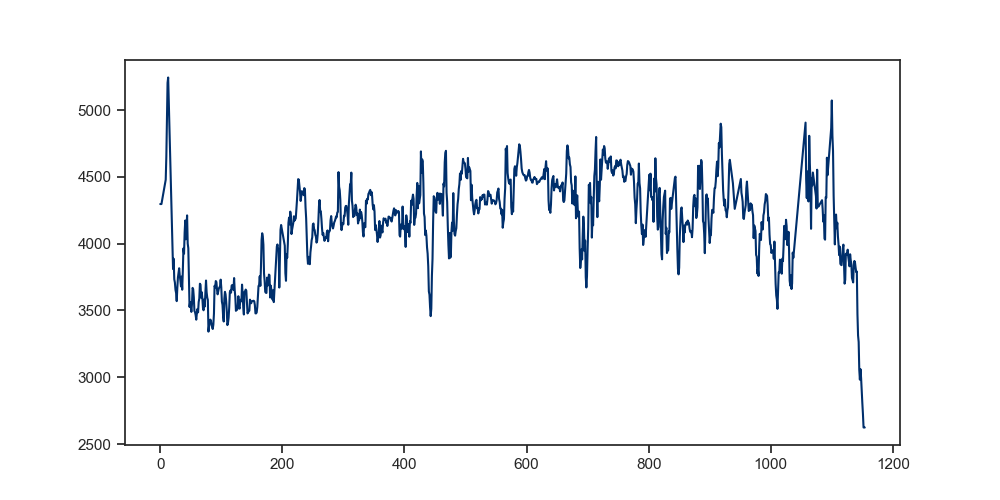

In [45]:
plt.close("all")
df_features["RRV_MeanBB"].plot()
plt.show()

In [46]:
df_features = df_features.set_index(resp_signal.index.floor("30s").drop_duplicates(), drop=True)

In [47]:
df_features

,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,RRV_LFn,RRV_HFn,RRV_SD1,RRV_SD2,RRV_SD2SD1,RRV_ApEn,RRV_SampEn
date (Europe/Berlin),,,,,,,,,,,,,,,,,,,,
2023-03-29 23:03:30+02:00,1615.388277,4296.806400,1633.025039,1416.123417,0.380056,0.375951,3835.392,412.186522,0.107469,0.0,0.0,0.0,0.0,0.0,0.0,1001.350471,2081.066744,2.078260,0.287682,1.299283
2023-03-29 23:04:00+02:00,1615.388277,4296.806400,1633.025039,1416.123417,0.380056,0.375951,3835.392,412.186522,0.107469,0.0,0.0,0.0,0.0,0.0,0.0,1001.350471,2081.066744,2.078260,0.287682,1.299283
2023-03-29 23:04:30+02:00,1615.388277,4296.806400,1633.025039,1416.123417,0.380056,0.375951,3835.392,412.186522,0.107469,0.0,0.0,0.0,0.0,0.0,0.0,1001.350471,2081.066744,2.078260,0.287682,1.299283
2023-03-29 23:05:00+02:00,1880.797155,4322.864387,1763.186993,1720.220672,0.406904,0.433017,3771.904,505.663181,0.137048,0.0,0.0,0.0,0.0,0.0,0.0,1216.379702,2152.516436,1.928478,0.310760,1.299283
2023-03-29 23:05:30+02:00,2146.206033,4348.922374,1893.348947,2024.317927,0.433752,0.490084,3708.416,599.139840,0.166626,0.0,0.0,0.0,0.0,0.0,0.0,1431.408933,2223.966127,1.778696,0.333838,1.299283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-30 08:38:30+02:00,714.019064,2806.980923,552.586788,721.106792,0.196862,0.254373,2510.848,163.963699,0.065302,0.0,0.0,0.0,0.0,0.0,0.0,509.899502,592.205045,1.161415,0.662205,1.278874
2023-03-30 08:39:00+02:00,599.689275,2724.228741,521.495933,605.016334,0.191429,0.220132,2400.256,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,427.811153,600.744233,1.404228,0.602643,0.642227
2023-03-30 08:39:30+02:00,500.820116,2623.699478,387.772373,506.328496,0.147796,0.190883,2400.256,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,358.028313,415.392047,1.160221,0.565278,0.576887
